# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

/Users/xicheng/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


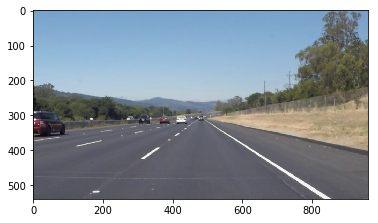

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [27]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image




def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [ ]:
"""
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
"""

In [28]:

def intersection_x(coef1, intercept1, coef2, intercept2):
    """Returns x-coordinate of intersection of two lines."""
    x = (intercept2-intercept1)/(coef1-coef2)
    return x

def draw_linear_regression_line(coef, intercept, intersection_x, img, imshape=[540,960], color=[255, 0, 0], thickness=2):
    
    # Get starting and ending points of regression line, ints.
    print("Coef: ", coef, "Intercept: ", intercept, 
          "intersection_x: ", intersection_x)
    point_one = (int(intersection_x), int(intersection_x * coef + intercept))
    if coef > 0:
        point_two = (imshape[1], int(imshape[1] * coef + intercept))
    elif coef < 0:
        point_two = (0, int(0 * coef + intercept))
    print("Point one: ", point_one, "Point two: ", point_two)
    
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)

In [29]:
def find_line_fit(slope_intercept):
    """slope_intercept is an array [[slope, intercept], [slope, intercept]...]."""

    # Initialise arrays
    kept_slopes = []
    kept_intercepts = []
    print("Slope & intercept: ", slope_intercept)
    if len(slope_intercept) == 1:
        return slope_intercept[0][0], slope_intercept[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intercept]
    mean_slope = np.mean(slopes)
    slope_std = np.std(slopes)
    for pair in slope_intercept:
        slope = pair[0]
        if slope - mean_slope < 1.5 * slope_std:
            kept_slopes.append(slope)
            kept_intercepts.append(pair[1])
    if not kept_slopes:
        kept_slopes = slopes
        kept_intercepts = [pair[1] for pair in slope_intercept]
    # Take estimate of slope, intercept to be the mean of remaining values
    slope = np.mean(kept_slopes)
    intercept = np.mean(kept_intercepts)
    print("Slope: ", slope, "Intercept: ", intercept)
    return slope, intercept

In [30]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Image parameters (hard-coded. TODO: Make not hard-coded.)
    imshape = [540, 960]
    
    # Initialise arrays
    positive_slope_points = []
    negative_slope_points = []
    positive_slope_intercept = []
    negative_slope_intercept = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:            
            slope = (y1-y2)/(x1-x2)
            # print("Points: ", [x1, y1, x2, y2])
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            # print("Length: ", length)
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        positive_slope_points.append([x1, y1])
                        positive_slope_points.append([x2, y2])
                        positive_slope_intercept.append([slope, y1-slope*x1])
                    elif slope < 0:
                        negative_slope_points.append([x1, y1])
                        negative_slope_points.append([x2, y2])
                        negative_slope_intercept.append([slope, y1-slope*x1])
        
    # If either array is empty, waive length requirement
    if not positive_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope > 0:
                    positive_slope_points.append([x1, y1])
                    positive_slope_points.append([x2, y2])
                    positive_slope_intercept.append([slope, y1-slope*x1])
    if not negative_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope < 0:
                    negative_slope_points.append([x1, y1])
                    negative_slope_points.append([x2, y2])
                    negative_slope_intercept.append([slope, y1-slope*x1])
    if not positive_slope_points:
        print("positive_slope_points still empty")
    if not negative_slope_points:
        print("negative_slope_points still empty")
    # Even though positive_slope_points is not used, I am keeping it for debugging purposes.
    positive_slope_points = np.array(positive_slope_points)
    negative_slope_points = np.array(negative_slope_points)
    # print("Positive slope line points: ", positive_slope_points)
    # print("Negative slope line points: ", negative_slope_points)
    # print("positive slope points dtype: ", positive_slope_points.dtype)

    # Get intercept and coefficient of fitted lines
    pos_coef, pos_intercept = find_line_fit(positive_slope_intercept)
    neg_coef, neg_intercept = find_line_fit(negative_slope_intercept)
    
    # Discarded Linear Regression Option:
    # Get intercept and coefficient of linear regression lines
    # pos_coef, pos_intercept = find_linear_regression_line(positive_slope_points)
    # neg_coef, neg_intercept = find_linear_regression_line(negative_slope_points)
    
    # Get intersection point
    intersection_x_coord = intersection_x(pos_coef, pos_intercept, neg_coef, neg_intercept)
    
    # Plot lines
    draw_linear_regression_line(pos_coef, pos_intercept, intersection_x_coord, img)
    draw_linear_regression_line(neg_coef, neg_intercept, intersection_x_coord, img)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [31]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

In [ ]:
Pipeline
Steps:
1, Read in and grayscale the image
2, Define a kernel size and apply Gaussian smoothing
3, Define our parameters for Canny and apply to get edges image
4, Mask edges image using cv2.fillPoly() (ignore everything outside region of interest)
5, Define Hough transform parameters and run Hough transform on masked edge-detected image
6, Draw line segments
7, Draw lines extrapolated from line segments
8, Combine line image with original image to see how accurate the line annotations are.

In [32]:
def read_image(image_path):
    """Reads and returns image."""
    return mpimg.imread(image_path)

def read_image_and_print_dims(image_path):
    """Reads and returns image.
    Helper function to examine how an image is represented.
    """
    #reading in an image
    image = mpimg.imread(image_path)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    return image

In [33]:
# Read and save test images to array
test_images = [read_image('test_images/' + i) for i in os.listdir('test_images/')]

In [35]:
# Pipeline

def draw_lane_lines(image):
    """Draw lane lines in white on original image."""
    # Print image details
    # print("image.shape: ", image.shape)
    imshape = image.shape
    
    # Greyscale image
    greyscaled_image = grayscale(image)
    plt.subplot(2,2,1)
    plt.imshow(greyscaled_image, cmap="gray")
    
    # Gaussian Blur
    blurred_grey_image = gaussian_blur(greyscaled_image, 5)
    
    # Canny edge detection
    edges_image = canny(blurred_grey_image, 50, 150)
    
    # Mask edges image
    border = 0
    vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_image_with_mask = region_of_interest(edges_image, vertices)
    ## Plot masked edges image
    bw_edges_image_with_mask = cv2.cvtColor(edges_image_with_mask, cv2.COLOR_GRAY2BGR)
    plt.subplot(2,2,2)
    plt.imshow(bw_edges_image_with_mask)
    
    # Hough lines
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    lines_image = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Convert Hough from single channel to RGB to prep for weighted
    # TODO: Have it convert the lines to red, not white.
    hough_rgb_image = cv2.cvtColor(lines_image, cv2.COLOR_GRAY2BGR)
    # hough_rgb_image.dtype: uint8.  Shape: (540,960,3).
    # hough_rgb_image is like [[[0 0 0], [0 0 0],...] [[0 0 0], [0 0 0],...]]
    ## Plot Hough lines image
    plt.subplot(2,2,3)
    plt.imshow(hough_rgb_image)    
    
    # Combine lines image with original image
    final_image = weighted_img(hough_rgb_image, image)
    ## Plot final image
    plt.subplot(2,2,4)
    plt.imshow(final_image)
    return final_image



Slope & intercept:  [[0.55350553505535061, 41.505535055350492], [0.57482993197278909, 33.874149659863974], [0.57740585774058573, 31.3305439330544], [0.55284552845528456, 41.097560975609724]]
Slope:  0.564646713306 Intercept:  36.951947406
Slope & intercept:  [[-0.81065088757396453, 698.71005917159766], [-0.75555555555555554, 671.55555555555554], [-0.70542635658914732, 653.67441860465124], [-0.78333333333333333, 688.60000000000002]]
Slope:  -0.763741533263 Intercept:  678.135008333
Coef:  0.564646713306 Intercept:  36.951947406 intersection_x:  482.677457124
Point one:  (482, 309) Point two:  (960, 579)
Coef:  -0.763741533263 Intercept:  678.135008333 intersection_x:  482.677457124
Point one:  (482, 309) Point two:  (0, 678)


array([[[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 82, 118, 151]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       ..., 
       [[ 68,  70,  76],
        [ 68,  70,  76],
        [ 68,  70,  76],
        ..., 
        [ 65,  65,  73],
        [ 64,  64,  72],
        [ 63,  63,  71]],

       [[ 69,  69,  75],
        [ 69,  69,  75],
        [ 70,  70,  76],
        ..., 
        [ 62,  64,  71],
        [ 62,  64,  71],
        [ 61,  63,  70]],

       [[ 67,  67,  74],
        [ 67,  67,  74],
        [ 67,  67,  74],
        ..., 
        [ 61,  62,  72],
        [ 60,  62,  71],
        [ 59,  61,

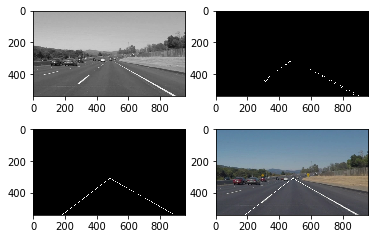

In [36]:
draw_lane_lines(test_images[0])

Slope & intercept:  [[0.62142857142857144, 7.9214285714285779], [0.6512455516014235, -4.1850533807829038], [0.65071770334928225, -4.5454545454545041]]
Slope:  0.641130608793 Intercept:  -0.26969311827
Slope & intercept:  [[-0.67132867132867136, 630.11188811188811], [-0.72222222222222221, 655.83333333333337], [-0.67333333333333334, 631.73333333333335], [-0.69736842105263153, 646.76315789473688]]
Slope:  -0.691063161984 Intercept:  641.110428168
Coef:  0.641130608793 Intercept:  -0.26969311827 intersection_x:  481.446569828
Point one:  (481, 308) Point two:  (960, 615)
Coef:  -0.691063161984 Intercept:  641.110428168 intersection_x:  481.446569828
Point one:  (481, 308) Point two:  (0, 641)


array([[[144, 157, 167],
        [114, 129, 141],
        [107, 125, 143],
        ..., 
        [109, 123, 142],
        [117, 127, 141],
        [149, 156, 168]],

       [[114, 129, 141],
        [114, 133, 147],
        [107, 128, 146],
        ..., 
        [110, 127, 146],
        [114, 127, 143],
        [118, 129, 142]],

       [[105, 126, 143],
        [106, 129, 146],
        [102, 127, 150],
        ..., 
        [103, 125, 148],
        [109, 126, 146],
        [107, 122, 141]],

       ..., 
       [[ 96,  97, 100],
        [ 73,  74,  78],
        [ 66,  67,  71],
        ..., 
        [ 70,  71,  74],
        [ 75,  76,  79],
        [ 96,  97, 100]],

       [[110, 111, 114],
        [ 84,  85,  88],
        [ 71,  72,  76],
        ..., 
        [ 78,  78,  82],
        [ 87,  88,  91],
        [111, 112, 115]],

       [[144, 145, 148],
        [112, 113, 116],
        [ 94,  94,  98],
        ..., 
        [ 98,  98, 100],
        [112, 113, 114],
        [143, 144,

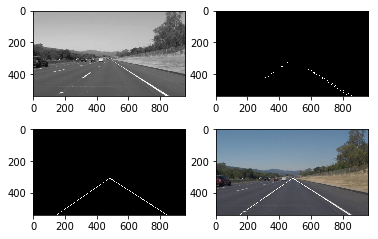

In [37]:
draw_lane_lines(test_images[1])

Slope & intercept:  [[0.62295081967213117, 15.327868852459005], [0.55384615384615388, 51.569230769230728], [0.59999999999999998, 25.0], [0.59813084112149528, 25.028037383177605]]
Slope:  0.59373195366 Intercept:  29.2312842512
Slope & intercept:  [[-0.75547445255474455, 671.20802919708035], [-0.67839195979899503, 639.7437185929648], [-0.68852459016393441, 643.42622950819668], [-0.75, 668.5], [-0.80620155038759689, 689.17829457364337], [-0.77500000000000002, 680.77500000000009], [-0.80952380952380953, 691.19047619047615], [-0.70034843205574915, 646.55400696864115], [-0.70198675496688745, 646.10596026490066]]
Slope:  -0.740605727717 Intercept:  664.075746144
Coef:  0.59373195366 Intercept:  29.2312842512 intersection_x:  475.774963679
Point one:  (475, 311) Point two:  (960, 599)
Coef:  -0.740605727717 Intercept:  664.075746144 intersection_x:  475.774963679
Point one:  (475, 311) Point two:  (0, 664)


array([[[ 82, 125, 162],
        [ 82, 125, 162],
        [ 82, 125, 162],
        ..., 
        [ 77, 122, 157],
        [ 75, 121, 155],
        [ 70, 116, 150]],

       [[ 82, 125, 160],
        [ 82, 125, 160],
        [ 82, 125, 160],
        ..., 
        [ 77, 122, 157],
        [ 75, 121, 155],
        [ 70, 116, 150]],

       [[ 82, 126, 158],
        [ 82, 126, 158],
        [ 82, 126, 158],
        ..., 
        [ 78, 122, 157],
        [ 77, 120, 155],
        [ 72, 115, 150]],

       ..., 
       [[ 76,  80,  85],
        [ 76,  80,  85],
        [ 76,  80,  85],
        ..., 
        [ 58,  63,  74],
        [ 58,  63,  74],
        [ 58,  63,  74]],

       [[ 76,  80,  85],
        [ 76,  80,  85],
        [ 76,  80,  85],
        ..., 
        [ 57,  62,  73],
        [ 57,  62,  73],
        [ 57,  62,  73]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ..., 
        [ 58,  62,  71],
        [ 58,  62,  71],
        [ 58,  62,

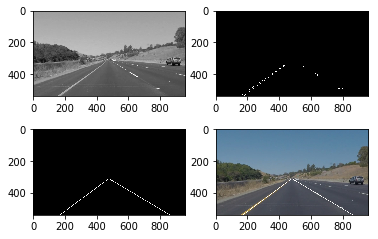

In [38]:
draw_lane_lines(test_images[2])

Slope & intercept:  [[0.60264900662251653, 25.145695364238406], [0.57704918032786889, 34.659016393442585], [0.57770270270270274, 32.510135135135101], [0.55882352941176472, 47.91176470588232]]
Slope:  0.571191804147 Intercept:  38.3603054115
Slope & intercept:  [[-0.72635135135135132, 655.21621621621625], [-0.75423728813559321, 671.94915254237287], [-0.74444444444444446, 658.02222222222224], [-0.7570093457943925, 673.50467289719631], [-0.74576271186440679, 657.32203389830511], [-0.67948717948717952, 640.25641025641028]]
Slope:  -0.745561028318 Intercept:  663.202859555
Coef:  0.571191804147 Intercept:  38.3603054115 intersection_x:  474.53291061
Point one:  (474, 309) Point two:  (960, 586)
Coef:  -0.745561028318 Intercept:  663.202859555 intersection_x:  474.53291061
Point one:  (474, 309) Point two:  (0, 663)


array([[[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ..., 
        [ 78, 125, 160],
        [ 76, 123, 158],
        [ 74, 122, 157]],

       [[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ..., 
        [ 77, 124, 159],
        [ 75, 122, 158],
        [ 72, 121, 156]],

       [[ 82, 126, 161],
        [ 83, 126, 162],
        [ 82, 127, 162],
        ..., 
        [ 75, 124, 159],
        [ 74, 122, 158],
        [ 72, 121, 156]],

       ..., 
       [[ 82,  82,  88],
        [ 82,  82,  88],
        [ 82,  82,  88],
        ..., 
        [ 62,  66,  74],
        [ 62,  66,  74],
        [ 62,  66,  74]],

       [[ 82,  81,  87],
        [ 82,  81,  87],
        [ 82,  81,  87],
        ..., 
        [ 62,  66,  73],
        [ 62,  65,  72],
        [ 62,  65,  72]],

       [[ 79,  78,  85],
        [ 79,  78,  85],
        [ 79,  78,  85],
        ..., 
        [ 62,  65,  72],
        [ 62,  65,  72],
        [ 62,  65,

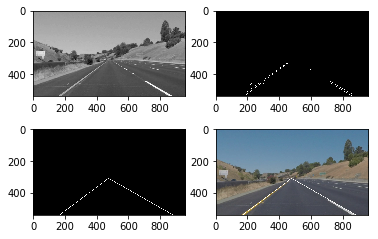

In [39]:
draw_lane_lines(test_images[3])

Slope & intercept:  [[0.64734299516908211, -3.2173913043478137], [0.60180995475113119, 20.782805429864254], [0.67484662576687116, -24.607361963190158]]
Slope:  0.641333191896 Intercept:  -2.34731594589
Slope & intercept:  [[-0.72602739726027399, 653.71232876712327], [-0.70050761421319796, 638.72081218274116], [-0.70046082949308752, 638.29953917050693], [-0.65853658536585369, 628.48780487804879], [-0.72689075630252098, 654.65126050420167]]
Slope:  -0.713471649317 Intercept:  646.345985156
Coef:  0.641333191896 Intercept:  -2.34731594589 intersection_x:  478.809405878
Point one:  (478, 304) Point two:  (960, 613)
Coef:  -0.713471649317 Intercept:  646.345985156 intersection_x:  478.809405878
Point one:  (478, 304) Point two:  (0, 646)


array([[[147, 157, 168],
        [115, 127, 142],
        [106, 123, 142],
        ..., 
        [102, 122, 141],
        [112, 129, 142],
        [146, 159, 171]],

       [[114, 126, 142],
        [115, 130, 147],
        [106, 125, 146],
        ..., 
        [ 99, 123, 144],
        [110, 127, 144],
        [113, 128, 142]],

       [[105, 122, 141],
        [106, 125, 146],
        [100, 123, 147],
        ..., 
        [ 94, 120, 145],
        [ 98, 120, 142],
        [100, 121, 139]],

       ..., 
       [[103, 102, 107],
        [ 92,  91,  96],
        [ 88,  87,  92],
        ..., 
        [ 66,  66,  74],
        [ 70,  70,  78],
        [ 95,  95, 103]],

       [[113, 112, 116],
        [100,  99, 103],
        [ 92,  91,  95],
        ..., 
        [ 70,  70,  78],
        [ 85,  85,  91],
        [109, 109, 115]],

       [[141, 140, 144],
        [111, 110, 114],
        [102, 102, 106],
        ..., 
        [ 95,  95, 102],
        [110, 110, 116],
        [146, 146,

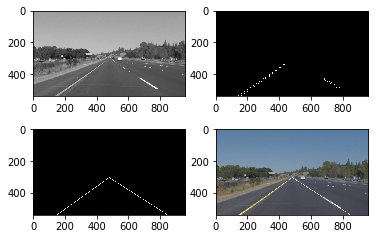

In [40]:
draw_lane_lines(test_images[4])

Slope & intercept:  [[0.55298013245033117, 49.165562913907252], [0.58139534883720934, 36.255813953488371], [0.61979166666666663, 5.84375], [0.55369127516778527, 46.751677852348962]]
Slope:  0.562688918818 Intercept:  44.0576849066
Slope & intercept:  [[-0.78378378378378377, 691.83783783783781], [-0.72881355932203384, 664.72881355932202], [-0.76106194690265483, 682.08849557522126], [-0.75939849624060152, 682.4511278195489], [-0.75257731958762886, 671.45360824742261], [-0.75, 671.75], [-0.80246913580246915, 695.54320987654319]]
Slope:  -0.76821511372 Intercept:  682.520713226
Coef:  0.562688918818 Intercept:  44.0576849066 intersection_x:  479.721311763
Point one:  (479, 313) Point two:  (960, 584)
Coef:  -0.76821511372 Intercept:  682.520713226 intersection_x:  479.721311763
Point one:  (479, 313) Point two:  (0, 682)


array([[[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       ..., 
       [[ 76,  80,  85],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ..., 
        [ 67,  70,  82],
        [ 66,  68,  80],
        [ 63,  66,  78]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 74,  78,  83],
        ..., 
        [ 67,  70,  80],
        [ 66,  69,  78],
        [ 62,  66,  75]],

       [[ 72,  78,  82],
        [ 71,  77,  82],
        [ 71,  77,  82],
        ..., 
        [ 66,  70,  79],
        [ 65,  68,  78],
        [ 62,  66,

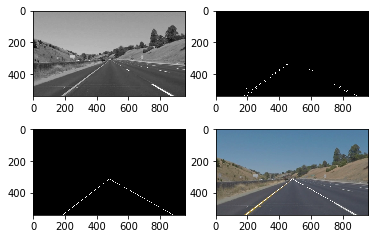

In [41]:
draw_lane_lines(test_images[5])

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [44]:
import imageio
imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg.osx' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.osx (28.8 MB)
Downloading: 8192/30241064 bytes (0.0%)262144/30241064 bytes (0.9%)770048/30241064 bytes (2.5%)1474560/30241064 bytes (4.9%)2048000/30241064 bytes (6.8%)2580480/30241064 bytes (8.5%)3375104/30241064 bytes (11.2%)4210688/30241064 bytes (13.9%)4874240/30241064 bytes (16.1%)5701632/30241064 bytes (18.9%)6414336/30241064 bytes (21.2%)6979584/30241064 bytes (23.1%)7766016/30241064 bytes (25.7%)8396800/30241064 bytes (27.8%)

In [45]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [46]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    """Puts image through pipeline and returns 3-channel image for processing video below."""
    result = draw_lane_lines(image)
    print(result.shape)
    return result

Let's try the one with the solid white lane on the right first ...

Slope & intercept:  [[0.59925093632958804, 16.65168539325839], [0.64615384615384619, -7.2923076923077019], [0.6470588235294118, -9.058823529411768], [0.59999999999999998, 15.600000000000023]]
Slope:  0.623115901503 Intercept:  3.97513854288
Slope & intercept:  [[-0.70037453183520604, 642.97003745318352], [-0.75217391304347825, 665.93913043478256], [-0.6742424242424242, 635.77272727272725], [-0.70270270270270274, 640.56756756756761], [-0.64646464646464652, 626.60606060606062]]
Slope:  -0.695191643658 Intercept:  642.371104667
Coef:  0.623115901503 Intercept:  3.97513854288 intersection_x:  484.25420037
Point one:  (484, 305) Point two:  (960, 602)
Coef:  -0.695191643658 Intercept:  642.371104667 intersection_x:  484.25420037
Point one:  (484, 305) Point two:  (0, 642)
(540, 960, 3)
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|          | 1/222 [00:00<00:22,  9.71it/s]

Slope & intercept:  [[0.59925093632958804, 16.65168539325839], [0.64615384615384619, -7.2923076923077019], [0.6470588235294118, -9.058823529411768], [0.59999999999999998, 15.600000000000023]]
Slope:  0.623115901503 Intercept:  3.97513854288
Slope & intercept:  [[-0.70037453183520604, 642.97003745318352], [-0.75217391304347825, 665.93913043478256], [-0.6742424242424242, 635.77272727272725], [-0.70270270270270274, 640.56756756756761], [-0.64646464646464652, 626.60606060606062]]
Slope:  -0.695191643658 Intercept:  642.371104667
Coef:  0.623115901503 Intercept:  3.97513854288 intersection_x:  484.25420037
Point one:  (484, 305) Point two:  (960, 602)
Coef:  -0.695191643658 Intercept:  642.371104667 intersection_x:  484.25420037
Point one:  (484, 305) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.64651162790697669, -8.3023255813953369], [0.60223048327137552, 15.263940520446056], [0.59999999999999998, 21.199999999999989], [0.58904109589041098, 26.835616438356169], [0.66037735849

  1%|▏         | 3/222 [00:00<00:21, 10.02it/s]

(540, 960, 3)
Slope & intercept:  [[0.60073260073260071, 16.564102564102598], [0.625, 7.0], [0.62337662337662336, 10.0], [0.61403508771929827, 15.31578947368422], [0.58441558441558439, 25.597402597402606]]
Slope:  0.609511979249 Intercept:  14.895458927
Slope & intercept:  [[-0.7678571428571429, 668.76785714285711], [-0.6875, 639.75], [-0.72093023255813948, 652.74418604651157], [-0.69918699186991873, 640.13821138211381], [-0.69747899159663862, 638.58823529411757]]
Slope:  -0.714590671776 Intercept:  647.997697973
Coef:  0.609511979249 Intercept:  14.895458927 intersection_x:  478.136826141
Point one:  (478, 306) Point two:  (960, 600)
Coef:  -0.714590671776 Intercept:  647.997697973 intersection_x:  478.136826141
Point one:  (478, 306) Point two:  (0, 647)
(540, 960, 3)


  2%|▏         | 5/222 [00:00<00:21, 10.33it/s]

Slope & intercept:  [[0.62686567164179108, 6.4179104477611872], [0.59778597785977861, 17.926199261992622], [0.59999999999999998, 15.600000000000023], [0.62416107382550334, 6.9798657718121149], [0.62544169611307421, 7.0]]
Slope:  0.614850883888 Intercept:  10.7847950963
Slope & intercept:  [[-0.72916666666666663, 656.5], [-0.72807017543859653, 650.24561403508778], [-0.69318181818181823, 638.5454545454545]]
Slope:  -0.716806220096 Intercept:  648.430356194
Coef:  0.614850883888 Intercept:  10.7847950963 intersection_x:  478.836150229
Point one:  (478, 305) Point two:  (960, 601)
Coef:  -0.716806220096 Intercept:  648.430356194 intersection_x:  478.836150229
Point one:  (478, 305) Point two:  (0, 648)
(540, 960, 3)
Slope & intercept:  [[0.62745098039215685, 5.9215686274509949], [0.60073260073260071, 16.362637362637372], [0.6097560975609756, 15.951219512195109], [0.60150375939849621, 14.691729323308266], [0.60869565217391308, 17.217391304347814], [0.5957446808510638, 27.957446808510667]]
S

  3%|▎         | 7/222 [00:00<00:20, 10.68it/s]

(540, 960, 3)
Slope & intercept:  [[0.62277580071174377, 8.0177935943060561], [0.60074626865671643, 15.149253731343265], [0.59693877551020413, 18.433673469387713], [0.61224489795918369, 3.5102040816326507]]
Slope:  0.608176435709 Intercept:  11.2777312192
Slope & intercept:  [[-0.69369369369369371, 636.14414414414409], [-0.7232142857142857, 652.89285714285711], [-0.75242718446601942, 663.31553398058259]]
Slope:  -0.723111721291 Intercept:  650.784178423
Coef:  0.608176435709 Intercept:  11.2777312192 intersection_x:  480.366661297
Point one:  (480, 303) Point two:  (960, 595)
Coef:  -0.723111721291 Intercept:  650.784178423 intersection_x:  480.366661297
Point one:  (480, 303) Point two:  (0, 650)


  4%|▍         | 9/222 [00:00<00:19, 10.85it/s]

(540, 960, 3)
Slope & intercept:  [[0.62633451957295372, 6.2419928825622719], [0.59999999999999998, 17.0], [0.5985130111524164, 17.687732342007394], [0.59808612440191389, 17.066985645933016], [0.60784313725490191, 22.54901960784315], [0.61538461538461542, 14.53846153846149]]
Slope:  0.603965377639 Intercept:  17.7684398268
Slope & intercept:  [[-0.72262773722627738, 652.6277372262773], [-0.69841269841269837, 638.50793650793651], [-0.7279411764705882, 655.48529411764707]]
Slope:  -0.716327204037 Intercept:  648.873655951
Coef:  0.603965377639 Intercept:  17.7684398268 intersection_x:  478.004061284
Point one:  (478, 306) Point two:  (960, 597)
Coef:  -0.716327204037 Intercept:  648.873655951 intersection_x:  478.004061284
Point one:  (478, 306) Point two:  (0, 648)
(540, 960, 3)
Slope & intercept:  [[0.60357142857142854, 16.910714285714334], [0.62704918032786883, 8.7704918032787305], [0.58823529411764708, 28.176470588235304], [0.61702127659574468, 14.191489361702111], [0.611111111111111

  5%|▍         | 11/222 [00:00<00:19, 11.02it/s]

Slope & intercept:  [[0.602112676056338, 20.18309859154931], [0.64550264550264547, -0.73544973544971981], [0.64393939393939392, -0.9772727272726911], [0.65909090909090906, -11.568181818181813]]
Slope:  0.637661406147 Intercept:  1.72554857766
Slope & intercept:  [[-0.67721518987341767, 634.90506329113919], [-0.78030303030303028, 675.14393939393938], [-0.67567567567567566, 636.70270270270271], [-0.69945355191256831, 642.45355191256829]]
Slope:  -0.708161861941 Intercept:  647.301314325
Coef:  0.637661406147 Intercept:  1.72554857766 intersection_x:  479.688367006
Point one:  (479, 307) Point two:  (960, 613)
Coef:  -0.708161861941 Intercept:  647.301314325 intersection_x:  479.688367006
Point one:  (479, 307) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.64935064935064934, -1.6493506493506516], [0.60377358490566035, 20.566037735849079], [0.60191082802547768, 23.764331210191074], [0.66101694915254239, -11.203389830508513], [0.609375, 16.53125], [0.64685314685314688, -0.47552

  6%|▌         | 13/222 [00:01<00:18, 11.00it/s]

(540, 960, 3)
Slope & intercept:  [[0.65284974093264247, -4.8238341968911982], [0.62230215827338131, 6.9316546762589724], [0.65151515151515149, -5.8939393939393767], [0.62439024390243902, 6.2292682926829457], [0.64000000000000001, 1.9599999999999795], [0.58461538461538465, 37.569230769230728]]
Slope:  0.629278779873 Intercept:  6.99539669122
Slope & intercept:  [[-0.6988847583643123, 638.63940520446101], [-0.75090252707581229, 662.14801444043326], [-0.75095785440613028, 661.15708812260539], [-0.69999999999999996, 644.79999999999995]]
Slope:  -0.725186284962 Intercept:  651.686126942
Coef:  0.629278779873 Intercept:  6.99539669122 intersection_x:  475.974424877
Point one:  (475, 306) Point two:  (960, 611)
Coef:  -0.725186284962 Intercept:  651.686126942 intersection_x:  475.974424877
Point one:  (475, 306) Point two:  (0, 651)
(540, 960, 3)


  7%|▋         | 15/222 [00:01<00:18, 11.04it/s]

Slope & intercept:  [[0.65289256198347112, -7.1652892561983776], [0.62445414847161573, 4.445414847161544], [0.62361623616236161, 4.560885608856097], [0.65161290322580645, -5.0967741935484128], [0.65384615384615385, -9.0769230769230944]]
Slope:  0.641284400738 Intercept:  -2.46653721413
Slope & intercept:  [[-0.69964664310954061, 637.34982332155482], [-0.72695035460992907, 654.76595744680856], [-0.72689075630252098, 653.73949579831935], [-0.69741697416974169, 638.19188191881915]]
Slope:  -0.712726182048 Intercept:  646.011789621
Coef:  0.641284400738 Intercept:  -2.46653721413 intersection_x:  478.93150547
Point one:  (478, 304) Point two:  (960, 613)
Coef:  -0.712726182048 Intercept:  646.011789621 intersection_x:  478.93150547
Point one:  (478, 304) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.62213740458015265, 3.5839694656488632], [0.67142857142857137, -21.414285714285711], [0.67272727272727273, -21.472727272727298], [0.64000000000000001, -8.6800000000000068]]
Slope:  

  8%|▊         | 17/222 [00:01<00:19, 10.66it/s]

Slope & intercept:  [[0.66990291262135926, -21.281553398058293], [0.62645914396887159, 0.87159533073929651], [0.625, 0.5], [0.67241379310344829, -23.810344827586221], [0.68852459016393441, -32.032786885245912]]
Slope:  0.656460087972 Intercept:  -15.150617956
Slope & intercept:  [[-0.72413793103448276, 649.20689655172418], [-0.69999999999999996, 634.79999999999995], [-0.76000000000000001, 658.08000000000004], [-0.67883211678832112, 631.043795620438], [-0.69999999999999996, 641.20000000000005]]
Slope:  -0.712594009565 Intercept:  642.866138434
Coef:  0.656460087972 Intercept:  -15.150617956 intersection_x:  480.636051983
Point one:  (480, 300) Point two:  (960, 615)
Coef:  -0.712594009565 Intercept:  642.866138434 intersection_x:  480.636051983
Point one:  (480, 300) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.62809917355371903, 0.71900826446278643], [0.67136150234741787, -21.586854460093889], [0.62595419847328249, 1.5572519083968928], [0.68181818181818177, -27.9090909090

  9%|▊         | 19/222 [00:01<00:18, 11.09it/s]

(540, 960, 3)
Slope & intercept:  [[0.62271062271062272, 6.205128205128176], [0.65333333333333332, -6.6133333333333439], [0.62903225806451613, 6.8870967741935374], [0.66891891891891897, -18.540540540540576]]
Slope:  0.643498783257 Intercept:  -3.01541222364
Slope & intercept:  [[-0.7232142857142857, 654.23214285714289], [-0.69841269841269837, 638.65079365079362]]
Slope:  -0.710813492063 Intercept:  646.441468254
Coef:  0.643498783257 Intercept:  -3.01541222364 intersection_x:  479.547363125
Point one:  (479, 305) Point two:  (960, 614)
Coef:  -0.710813492063 Intercept:  646.441468254 intersection_x:  479.547363125
Point one:  (479, 305) Point two:  (0, 646)
(540, 960, 3)


  9%|▉         | 21/222 [00:01<00:17, 11.34it/s]

Slope & intercept:  [[0.62230215827338131, 7.1762589928057423], [0.6512455516014235, -4.1850533807829038], [0.65071770334928225, -4.5454545454545041], [0.625, 5.875]]
Slope:  0.637316353306 Intercept:  1.08018776664
Slope & intercept:  [[-0.67333333333333334, 631.73333333333335], [-0.72340425531914898, 656.38297872340422], [-0.77659574468085102, 673.28723404255311], [-0.69999999999999996, 644.79999999999995]]
Slope:  -0.718333333333 Intercept:  651.550886525
Coef:  0.637316353306 Intercept:  1.08018776664 intersection_x:  479.8221142
Point one:  (479, 306) Point two:  (960, 612)
Coef:  -0.718333333333 Intercept:  651.550886525 intersection_x:  479.8221142
Point one:  (479, 306) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.62454873646209386, 5.6353790613718502], [0.64912280701754388, -2.7192982456140271], [0.6495726495726496, -3.9145299145299077], [0.62318840579710144, 6.9130434782608745], [0.64000000000000001, 4.4399999999999977]]
Slope:  0.63728651977 Intercept:  2.07091

 10%|█         | 23/222 [00:02<00:19, 10.13it/s]

Slope & intercept:  [[0.62454873646209386, 5.6353790613718502], [0.64981949458483756, -3.4007220216606697], [0.66901408450704225, -16.704225352112701], [0.63793103448275867, 6.1206896551723844]]
Slope:  0.645328337509 Intercept:  -2.08721966431
Slope & intercept:  [[-0.72340425531914898, 655.65957446808511], [-0.67708333333333337, 633.75], [-0.72727272727272729, 652.63636363636363]]
Slope:  -0.709253438642 Intercept:  647.348646035
Coef:  0.645328337509 Intercept:  -2.08721966431 intersection_x:  479.436440925
Point one:  (479, 307) Point two:  (960, 617)
Coef:  -0.709253438642 Intercept:  647.348646035 intersection_x:  479.436440925
Point one:  (479, 307) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.62271062271062272, 6.205128205128176], [0.67032967032967028, -18.14285714285711], [0.66896551724137931, -16.63448275862072], [0.63636363636363635, 7.2727272727272521]]
Slope:  0.649592361661 Intercept:  -5.32487110591
Slope & intercept:  [[-0.67391304347826086, 632.3478260869

 11%|█▏        | 25/222 [00:02<00:20,  9.48it/s]

Slope & intercept:  [[0.62361623616236161, 4.808118081180794], [0.67045454545454541, -18.943181818181813], [0.660377358490566, -11.471698113207538], [0.63636363636363635, 7.2727272727273089], [0.62406015037593987, 4.0526315789473415], [0.65486725663716816, -8.893805309734546]]
Slope:  0.644956530581 Intercept:  -3.86253471804
Slope & intercept:  [[-0.67537313432835822, 632.61940298507466], [-0.70588235294117652, 651.17647058823536], [-0.75221238938053092, 662.2035398230089], [-0.67206477732793524, 632.67611336032394], [-0.65405405405405403, 626.35675675675679], [-0.77685950413223137, 669.75206611570252]]
Slope:  -0.706074368694 Intercept:  645.797391605
Coef:  0.644956530581 Intercept:  -3.86253471804 intersection_x:  480.862374555
Point one:  (480, 306) Point two:  (960, 615)
Coef:  -0.706074368694 Intercept:  645.797391605 intersection_x:  480.862374555
Point one:  (480, 306) Point two:  (0, 645)
(540, 960, 3)


 12%|█▏        | 26/222 [00:02<00:20,  9.36it/s]

Slope & intercept:  [[0.62453531598513012, 4.271375464684013], [0.64968152866242035, -5.1719745222929987], [0.65625, -7.65625], [0.65346534653465349, -6.3366336633663423], [0.63793103448275867, 3.931034482758605]]
Slope:  0.644372645133 Intercept:  -2.19248964764
Slope & intercept:  [[-0.67656765676567654, 633.39603960396039], [-0.72962962962962963, 657.92962962962963], [-0.726962457337884, 655.49488054607514], [-0.72881355932203384, 656.79661016949149], [-0.69696969696969702, 639.15151515151513]]
Slope:  -0.720593835815 Intercept:  652.343158874
Coef:  0.644372645133 Intercept:  -2.19248964764 intersection_x:  479.525070877
Point one:  (479, 306) Point two:  (960, 616)
Coef:  -0.720593835815 Intercept:  652.343158874 intersection_x:  479.525070877
Point one:  (479, 306) Point two:  (0, 652)
(540, 960, 3)
Slope & intercept:  [[0.62361623616236161, 5.4317343173431709], [0.65079365079365081, -4.8888888888889142], [0.65306122448979587, -5.9999999999999432], [0.62453531598513012, 4.0223048

 12%|█▏        | 27/222 [00:02<00:24,  7.99it/s]

(540, 960, 3)
Slope & intercept:  [[0.62230215827338131, 6.9316546762589724], [0.65027322404371579, -5.2021857923497237], [0.63461538461538458, 8.7307692307692832], [0.63461538461538458, -4.5961538461538112], [0.63636363636363635, 5.636363636363626], [0.63888888888888884, -6.0555555555555429], [0.68181818181818177, -29.0], [0.63636363636363635, -3.181818181818187]]
Slope:  0.636203187595 Intercept:  0.323296309645
Slope & intercept:  [[-0.75, 661.25], [-0.72131147540983609, 657.01639344262298], [-0.676056338028169, 635.0], [-0.67647058823529416, 633.17647058823536], [-0.75, 665.5]]
Slope:  -0.714767680335 Intercept:  650.388572806
Coef:  0.636203187595 Intercept:  0.323296309645 intersection_x:  481.183785623
Point one:  (481, 306) Point two:  (960, 611)
Coef:  -0.714767680335 Intercept:  650.388572806 intersection_x:  481.183785623
Point one:  (481, 306) Point two:  (0, 650)


 13%|█▎        | 28/222 [00:02<00:24,  7.94it/s]

(540, 960, 3)


 13%|█▎        | 29/222 [00:02<00:26,  7.21it/s]

Slope & intercept:  [[0.62222222222222223, 6.0], [0.65017667844522964, -4.2473498233215423], [0.65306122448979587, -5.9999999999999432], [0.62272727272727268, 4.9454545454545951]]
Slope:  0.637046849471 Intercept:  0.174526180533
Slope & intercept:  [[-0.67320261437908502, 631.67320261437908], [-0.76923076923076927, 673.38461538461547], [-0.70512820512820518, 642.25641025641028], [-0.7265625, 656.140625]]
Slope:  -0.718531022185 Intercept:  650.863713314
Coef:  0.637046849471 Intercept:  0.174526180533 intersection_x:  480.008711221
Point one:  (480, 305) Point two:  (960, 611)
Coef:  -0.718531022185 Intercept:  650.863713314 intersection_x:  480.008711221
Point one:  (480, 305) Point two:  (0, 650)
(540, 960, 3)
Slope & intercept:  [[0.65000000000000002, -4.75], [0.62132352941176472, 6.1470588235293917], [0.63414634146341464, 4.2926829268292863], [0.63793103448275867, 2.5517241379309894]]
Slope:  0.635850226339 Intercept:  2.06036647207
Slope & intercept:  [[-0.7239263803680982, 654.5

 14%|█▍        | 31/222 [00:03<00:23,  8.13it/s]

Slope & intercept:  [[0.65040650406504064, -5.8780487804878021], [0.62361623616236161, 4.560885608856097], [0.63513513513513509, 6.8243243243243796], [0.625, 15.5]]
Slope:  0.627917123766 Intercept:  8.96173664439
Slope & intercept:  [[-0.72432432432432436, 653.84324324324325], [-0.69999999999999996, 639.29999999999995]]
Slope:  -0.712162162162 Intercept:  646.571621622
Coef:  0.627917123766 Intercept:  8.96173664439 intersection_x:  475.800119943
Point one:  (475, 307) Point two:  (960, 611)
Coef:  -0.712162162162 Intercept:  646.571621622 intersection_x:  475.800119943
Point one:  (475, 307) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.65289256198347112, -6.8181818181818699], [0.62313432835820892, 4.3507462686567351], [0.66666666666666663, -17.333333333333314], [0.62352941176470589, 4.8588235294117794], [0.63414634146341464, 4.2439024390243958], [0.64748201438848918, -3.9424460431654325]]
Slope:  0.636236931592 Intercept:  0.538568875149
Slope & intercept:  [[-0.7281105

 15%|█▍        | 33/222 [00:03<00:21,  8.76it/s]

(540, 960, 3)
Slope & intercept:  [[0.64874551971326166, -4.351254480286741], [0.60666666666666669, 16.326666666666654], [0.62222222222222223, 5.1333333333333258], [0.6228813559322034, 5.2372881355931895]]
Slope:  0.617256748274 Intercept:  8.8990960452
Slope & intercept:  [[-0.69655172413793098, 638.39310344827584], [-0.7289719626168224, 656.87850467289718], [-0.73043478260869565, 656.8608695652174]]
Slope:  -0.718652823121 Intercept:  650.710825895
Coef:  0.617256748274 Intercept:  8.8990960452 intersection_x:  480.430519844
Point one:  (480, 305) Point two:  (960, 601)
Coef:  -0.718652823121 Intercept:  650.710825895 intersection_x:  480.430519844
Point one:  (480, 305) Point two:  (0, 650)


 15%|█▌        | 34/222 [00:03<00:22,  8.33it/s]

(540, 960, 3)


 16%|█▌        | 35/222 [00:03<00:23,  8.00it/s]

Slope & intercept:  [[0.62142857142857144, 7.6785714285714448], [0.65000000000000002, -4.4499999999999886], [0.65234375, -5.0546875], [0.64000000000000001, -8.3600000000000136], [0.6376811594202898, -5.6956521739130039]]
Slope:  0.64029069617 Intercept:  -3.17635364907
Slope & intercept:  [[-0.69714285714285718, 639.53142857142859], [-0.75151515151515147, 664.67272727272723], [-0.74842767295597479, 660.8176100628931], [-0.72777777777777775, 656.59444444444443]]
Slope:  -0.742573534083 Intercept:  660.69492726
Coef:  0.64029069617 Intercept:  -3.17635364907 intersection_x:  480.069746824
Point one:  (480, 304) Point two:  (960, 611)
Coef:  -0.742573534083 Intercept:  660.69492726 intersection_x:  480.069746824
Point one:  (480, 304) Point two:  (0, 660)
(540, 960, 3)
Slope & intercept:  [[0.62181818181818183, 6.9672727272727002], [0.6517857142857143, -3.9375], [0.6235955056179775, 7.0561797752808957], [0.65248226950354615, -5.5177304964539076]]
Slope:  0.637420417806 Intercept:  1.14205

 16%|█▌        | 36/222 [00:03<00:25,  7.32it/s]

(540, 960, 3)
Slope & intercept:  [[0.65145228215767637, -3.6597510373443924], [0.60396039603960394, 21.217821782178248], [0.61194029850746268, 13.746268656716438], [0.60162601626016265, 23.609756097560933], [0.56043956043956045, 48.505494505494482], [0.64000000000000001, 3.0399999999999636]]
Slope:  0.611569758901 Intercept:  17.7432650008
Slope & intercept:  [[-0.67391304347826086, 634.71739130434776], [-0.75210084033613445, 664.68487394957981], [-0.69803921568627447, 641.32549019607836], [-0.65217391304347827, 627.43478260869563], [-0.75221238938053092, 663.95575221238937], [-0.78048780487804881, 673.60975609756099]]
Slope:  -0.718154534467 Intercept:  650.954674395
Coef:  0.611569758901 Intercept:  17.7432650008 intersection_x:  476.197518954
Point one:  (476, 308) Point two:  (960, 604)
Coef:  -0.718154534467 Intercept:  650.954674395 intersection_x:  476.197518954
Point one:  (476, 308) Point two:  (0, 650)


 17%|█▋        | 37/222 [00:03<00:25,  7.39it/s]

(540, 960, 3)
Slope & intercept:  [[0.65040650406504064, -3.7886178861788267], [0.62277580071174377, 7.1494661921708484], [0.65454545454545454, -6.9636363636363399], [0.62441314553990612, 6.4647887323943678]]
Slope:  0.638035226216 Intercept:  0.715500168688
Slope & intercept:  [[-0.75451263537906132, 665.00361010830329], [-0.70134228187919467, 642.09731543624162], [-0.69841269841269837, 639.96825396825398], [-0.75103734439834025, 664.96265560165978]]
Slope:  -0.726326240017 Intercept:  653.007958779
Coef:  0.638035226216 Intercept:  0.715500168688 intersection_x:  478.09358059
Point one:  (478, 305) Point two:  (960, 613)
Coef:  -0.726326240017 Intercept:  653.007958779 intersection_x:  478.09358059
Point one:  (478, 305) Point two:  (0, 653)


 17%|█▋        | 38/222 [00:03<00:23,  7.85it/s]

(540, 960, 3)
Slope & intercept:  [[0.62271062271062272, 6.205128205128176], [0.65198237885462551, -5.1013215859030652], [0.65648854961832059, -8.6641221374045472], [0.6376811594202898, -3.4202898550724399]]
Slope:  0.642215677651 Intercept:  -2.74515134331
Slope & intercept:  [[-0.75179856115107913, 663.79856115107918], [-0.70169491525423733, 640.74576271186447], [-0.75247524752475248, 665.09900990099004], [-0.7007575757575758, 641.11363636363637], [-0.73039215686274506, 658.42647058823525]]
Slope:  -0.72742369131 Intercept:  653.836688143
Coef:  0.642215677651 Intercept:  -2.74515134331 intersection_x:  479.383007211
Point one:  (479, 305) Point two:  (960, 613)
Coef:  -0.72742369131 Intercept:  653.836688143 intersection_x:  479.383007211
Point one:  (479, 305) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.62641509433962261, 4.0415094339622897], [0.65151515151515149, -6.5], [0.64963503649635035, -3.145985401459825], [0.65517241379310343, -8.4137931034482563], [0.6236162

 18%|█▊        | 40/222 [00:04<00:22,  8.11it/s]

(540, 960, 3)
Slope & intercept:  [[0.62686567164179108, 3.0298507462686644], [0.6556291390728477, -8.95364238410599], [0.65027322404371579, -4.3278688524590052]]
Slope:  0.644256011586 Intercept:  -3.41722016343
Slope & intercept:  [[-0.6962962962962963, 638.45925925925928], [-0.67500000000000004, 635.25], [-0.7570093457943925, 661.97196261682245]]
Slope:  -0.70943521403 Intercept:  645.227073959
Coef:  0.644256011586 Intercept:  -3.41722016343 intersection_x:  479.16709649
Point one:  (479, 305) Point two:  (960, 615)
Coef:  -0.70943521403 Intercept:  645.227073959 intersection_x:  479.16709649
Point one:  (479, 305) Point two:  (0, 645)


 18%|█▊        | 41/222 [00:04<00:27,  6.58it/s]

(540, 960, 3)
Slope & intercept:  [[0.62453531598513012, 4.0223048327137576], [0.67068273092369479, -18.947791164658668], [0.67105263157894735, -18.473684210526301], [0.68852459016393441, -33.852459016393482]]
Slope:  0.663698817163 Intercept:  -16.8129073897
Slope & intercept:  [[-0.77600000000000002, 672.024], [-0.75384615384615383, 659.36923076923074], [-0.78205128205128205, 675.88461538461536]]
Slope:  -0.770632478632 Intercept:  669.092615385
Coef:  0.663698817163 Intercept:  -16.8129073897 intersection_x:  478.205784664
Point one:  (478, 300) Point two:  (960, 620)
Coef:  -0.770632478632 Intercept:  669.092615385 intersection_x:  478.205784664
Point one:  (478, 300) Point two:  (0, 669)


 19%|█▉        | 42/222 [00:04<00:27,  6.49it/s]

(540, 960, 3)


 19%|█▉        | 43/222 [00:04<00:27,  6.42it/s]

Slope & intercept:  [[0.62546816479400746, 3.4756554307116403], [0.67195767195767198, -18.984126984126988], [0.6244897959183674, 4.6857142857142549], [0.63492063492063489, 8.5396825396825875], [0.67105263157894735, -19.157894736842081]]
Slope:  0.645577779834 Intercept:  -4.28819389297
Slope & intercept:  [[-0.72670807453416153, 648.21739130434787], [-0.75, 662.75]]
Slope:  -0.738354037267 Intercept:  655.483695652
Coef:  0.645577779834 Intercept:  -4.28819389297 intersection_x:  476.737279534
Point one:  (476, 303) Point two:  (960, 615)
Coef:  -0.738354037267 Intercept:  655.483695652 intersection_x:  476.737279534
Point one:  (476, 303) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.62450592885375489, 4.0474308300395592], [0.67281105990783407, -20.156682027649765], [0.625, 3.25], [0.66000000000000003, -10.779999999999973]]
Slope:  0.64557924719 Intercept:  -5.9098127994
Slope & intercept:  [[-0.70050761421319796, 637.51269035532994], [-0.75252525252525249, 662.3585858585

 20%|█▉        | 44/222 [00:04<00:29,  6.12it/s]

(540, 960, 3)
Slope & intercept:  [[0.62893081761006286, 2.5220125786163976], [0.67105263157894735, -18.473684210526301], [0.6244897959183674, 4.6857142857142549], [0.68518518518518523, -30.259259259259238], [0.61702127659574468, 8.6382978723404449]]
Slope:  0.645335941378 Intercept:  -6.57738374662
Slope & intercept:  [[-0.75, 661.5], [-0.69607843137254899, 636.56862745098033], [-0.70192307692307687, 640.40384615384619]]
Slope:  -0.716000502765 Intercept:  646.157491202
Coef:  0.645335941378 Intercept:  -6.57738374662 intersection_x:  479.480937836
Point one:  (479, 302) Point two:  (960, 612)
Coef:  -0.716000502765 Intercept:  646.157491202 intersection_x:  479.480937836
Point one:  (479, 302) Point two:  (0, 646)


 20%|██        | 45/222 [00:05<00:27,  6.54it/s]

(540, 960, 3)
Slope & intercept:  [[0.62857142857142856, 2.1999999999999886], [0.67000000000000004, -17.879999999999995], [0.68181818181818177, -28.272727272727252], [0.61194029850746268, 12.208955223880594], [0.69047619047619047, -34.547619047619037], [0.61290322580645162, 12.903225806451587], [0.72093023255813948, -55.441860465116235], [0.69230769230769229, -35.076923076923038]]
Slope:  0.655431002498 Intercept:  -12.6378697667
Slope & intercept:  [[-0.75757575757575757, 664.30303030303025], [-0.6962962962962963, 636.40740740740739]]
Slope:  -0.726936026936 Intercept:  650.355218855
Coef:  0.655431002498 Intercept:  -12.6378697667 intersection_x:  479.607133637
Point one:  (479, 301) Point two:  (960, 616)
Coef:  -0.726936026936 Intercept:  650.355218855 intersection_x:  479.607133637
Point one:  (479, 301) Point two:  (0, 650)


 21%|██        | 46/222 [00:05<00:25,  6.87it/s]

(540, 960, 3)


 21%|██        | 47/222 [00:05<00:24,  7.13it/s]

Slope & intercept:  [[0.625, 3.625], [0.67088607594936711, -19.063291139240505], [0.62595419847328249, 2.4351145038167488], [0.68518518518518523, -31.0], [0.69999999999999996, -43.399999999999977]]
Slope:  0.661405091922 Intercept:  -17.4806353271
Slope & intercept:  [[-0.67682926829268297, 630.18902439024396], [-0.80769230769230771, 679.53846153846155], [-0.75324675324675328, 661.66233766233768], [-0.72992700729927007, 647.08029197080293]]
Slope:  -0.741923834133 Intercept:  654.61752889
Coef:  0.661405091922 Intercept:  -17.4806353271 intersection_x:  478.931312353
Point one:  (478, 299) Point two:  (960, 617)
Coef:  -0.741923834133 Intercept:  654.61752889 intersection_x:  478.931312353
Point one:  (478, 299) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.62555066079295152, 3.7797356828194211], [0.6730038022813688, -20.266159695817464], [0.69047619047619047, -35.333333333333371], [0.61538461538461542, 9.6153846153845848]]
Slope:  0.651103817234 Intercept:  -10.5510931827

 22%|██▏       | 48/222 [00:05<00:25,  6.74it/s]

(540, 960, 3)
Slope & intercept:  [[0.67193675889328064, -19.316205533596815], [0.6243386243386243, 5.4391534391534719], [0.69387755102040816, -37.530612244897952], [0.6428571428571429, -6.7142857142857224], [0.67231638418079098, -18.84180790960454], [0.64596273291925466, -10.32919254658384]]
Slope:  0.651482328638 Intercept:  -9.95246765298
Slope & intercept:  [[-0.70085470085470081, 638.76923076923072], [-0.75342465753424659, 660.21917808219177], [-0.72115384615384615, 652.72115384615381], [-0.67841409691629961, 631.89427312775331]]
Slope:  -0.713461825365 Intercept:  645.900958956
Coef:  0.651482328638 Intercept:  -9.95246765298 intersection_x:  480.498359355
Point one:  (480, 303) Point two:  (960, 615)
Coef:  -0.713461825365 Intercept:  645.900958956 intersection_x:  480.498359355
Point one:  (480, 303) Point two:  (0, 645)


 22%|██▏       | 49/222 [00:05<00:25,  6.67it/s]

(540, 960, 3)


 23%|██▎       | 50/222 [00:05<00:25,  6.70it/s]

Slope & intercept:  [[0.62616822429906538, 3.8785046728972361], [0.6742424242424242, -20.621212121212125], [0.67307692307692313, -19.269230769230774], [0.61111111111111116, 12.111111111111086], [0.6428571428571429, -7.0], [0.64516129032258063, -9.5161290322580498]]
Slope:  0.645436185985 Intercept:  -6.73615935645
Slope & intercept:  [[-0.70138888888888884, 637.89583333333337], [-0.75203252032520329, 660.3739837398374], [-0.75471698113207553, 659.50943396226421], [-0.67391304347826086, 628.89130434782612], [-0.67692307692307696, 631.55384615384617]]
Slope:  -0.71179490215 Intercept:  643.644880307
Coef:  0.645436185985 Intercept:  -6.73615935645 intersection_x:  479.196980787
Point one:  (479, 302) Point two:  (960, 612)
Coef:  -0.71179490215 Intercept:  643.644880307 intersection_x:  479.196980787
Point one:  (479, 302) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.62406015037593987, 4.5488721804510988], [0.6730038022813688, -20.266159695817464], [0.63855421686746983, -6.

 23%|██▎       | 51/222 [00:05<00:26,  6.57it/s]

(540, 960, 3)
Slope & intercept:  [[0.67432950191570884, -21.367816091954012], [0.628, 2.3159999999999741], [0.61194029850746268, 11.835820895522374], [0.61818181818181817, 7.0363636363636601]]
Slope:  0.619374038896 Intercept:  7.0627281773
Slope & intercept:  [[-0.70370370370370372, 635.40740740740739], [-0.72727272727272729, 652.18181818181824], [-0.7276785714285714, 651.45089285714289], [-0.72625698324022347, 645.13407821229055], [-0.75378787878787878, 658.09848484848487]]
Slope:  -0.733749040182 Intercept:  651.716318525
Coef:  0.619374038896 Intercept:  7.0627281773 intersection_x:  476.419034096
Point one:  (476, 302) Point two:  (960, 601)
Coef:  -0.733749040182 Intercept:  651.716318525 intersection_x:  476.419034096
Point one:  (476, 302) Point two:  (0, 651)


 23%|██▎       | 52/222 [00:06<00:27,  6.08it/s]

(540, 960, 3)


 24%|██▍       | 53/222 [00:06<00:25,  6.61it/s]

Slope & intercept:  [[0.67441860465116277, -21.441860465116292], [0.62790697674418605, 2.3953488372093261], [0.61038961038961037, 12.48051948051949], [0.69090909090909092, -30.818181818181813], [0.61403508771929827, 14.298245614035068]]
Slope:  0.643531874083 Intercept:  -4.61718567031
Slope & intercept:  [[-0.66911764705882348, 627.75], [-0.75268817204301075, 655.58064516129036], [-0.72566371681415931, 649.40707964601768], [-0.75268817204301075, 656.33333333333337], [-0.6964285714285714, 633.71428571428567], [-0.67647058823529416, 629.32352941176475], [-0.80000000000000004, 677.20000000000005]]
Slope:  -0.72472240966 Intercept:  647.044124752
Coef:  0.643531874083 Intercept:  -4.61718567031 intersection_x:  476.272077614
Point one:  (476, 301) Point two:  (960, 613)
Coef:  -0.72472240966 Intercept:  647.044124752 intersection_x:  476.272077614
Point one:  (476, 301) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.6730038022813688, -20.266159695817464], [0.6278195488721805, 

 24%|██▍       | 54/222 [00:06<00:23,  7.00it/s]


Coef:  0.653864856776 Intercept:  -11.2288648918 intersection_x:  478.504102145
Point one:  (478, 301) Point two:  (960, 616)
Coef:  -0.71452790819 Intercept:  643.552686489 intersection_x:  478.504102145
Point one:  (478, 301) Point two:  (0, 643)
(540, 960, 3)


 25%|██▍       | 55/222 [00:06<00:22,  7.45it/s]

Slope & intercept:  [[0.67206477732793524, -19.0445344129555], [0.62698412698412698, 3.1825396825396979], [0.61194029850746268, 11.955223880597032], [0.68852459016393441, -33.032786885245855], [0.6428571428571429, -8.7142857142857224], [0.67391304347826086, -19.739130434782624]]
Slope:  0.652713996553 Intercept:  -10.8988289807
Slope & intercept:  [[-0.72549019607843135, 648.70588235294122], [-0.62352941176470589, 609.12941176470588], [-0.77049180327868849, 666.8360655737705], [-0.69565217391304346, 633.695652173913], [-0.72352941176470587, 649.62941176470588]]
Slope:  -0.728790896259 Intercept:  649.716752966
Coef:  0.652713996553 Intercept:  -10.8988289807 intersection_x:  478.185481198
Point one:  (478, 301) Point two:  (960, 615)
Coef:  -0.728790896259 Intercept:  649.716752966 intersection_x:  478.185481198
Point one:  (478, 301) Point two:  (0, 649)
(540, 960, 3)
Slope & intercept:  [[0.62546816479400746, 4.6029962546816705], [0.67455621301775148, -20.881656804733723], [0.6615384

 26%|██▌       | 57/222 [00:06<00:23,  7.06it/s]

(540, 960, 3)
Slope & intercept:  [[0.66666666666666663, -13.333333333333314], [0.62365591397849462, 6.6451612903225623], [0.6692913385826772, -16.842519685039406], [0.67320261437908502, -19.084967320261455], [0.68181818181818177, -24.545454545454504], [0.62727272727272732, 5.1909090909090878]]
Slope:  0.656984573783 Intercept:  -10.3283674171
Slope & intercept:  [[-0.67441860465116277, 627.37209302325584], [-0.69503546099290781, 640.54609929078015]]
Slope:  -0.684727032822 Intercept:  633.959096157
Coef:  0.656984573783 Intercept:  -10.3283674171 intersection_x:  480.198174036
Point one:  (480, 305) Point two:  (960, 620)
Coef:  -0.684727032822 Intercept:  633.959096157 intersection_x:  480.198174036
Point one:  (480, 305) Point two:  (0, 633)
(540, 960, 3)


 27%|██▋       | 59/222 [00:07<00:21,  7.41it/s]

Slope & intercept:  [[0.62190812720848054, 8.75618374558303], [0.65217391304347827, -2.652173913043498], [0.65625, -6.3125], [0.65116279069767447, -3.8372093023256184], [0.64233576642335766, -4.5547445255474486]]
Slope:  0.644766119475 Intercept:  -1.72008879907
Slope & intercept:  [[-0.64772727272727271, 620.25], [-0.72413793103448276, 651.9655172413793], [-0.74803149606299213, 659.14960629921256], [-0.67808219178082196, 629.60958904109589]]
Slope:  -0.699494722901 Intercept:  640.243678145
Coef:  0.644766119475 Intercept:  -1.72008879907 intersection_x:  477.55892808
Point one:  (477, 306) Point two:  (960, 617)
Coef:  -0.699494722901 Intercept:  640.243678145 intersection_x:  477.55892808
Point one:  (477, 306) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.62411347517730498, 7.5035460992907588], [0.64925373134328357, 0.41791044776118724], [0.65454545454545454, -5.3818181818181756], [0.63636363636363635, 8.7272727272727479], [0.62765957446808507, 6.1170212765957785]]
Slo

 27%|██▋       | 61/222 [00:07<00:20,  7.72it/s]

Slope & intercept:  [[0.67272727272727273, -16.672727272727286], [0.62844036697247707, 5.0825688073394417], [0.62804878048780488, 6.0426829268292863], [0.61290322580645162, 14.161290322580612], [0.69047619047619047, -31.64285714285711]]
Slope:  0.646519167294 Intercept:  -4.60580847177
Slope & intercept:  [[-0.65086206896551724, 621.09482758620686], [-0.72395833333333337, 649.02604166666674], [-0.67475728155339809, 628.495145631068], [-0.69907407407407407, 642.37962962962956]]
Slope:  -0.687162939482 Intercept:  635.248911128
Coef:  0.646519167294 Intercept:  -4.60580847177 intersection_x:  479.76554259
Point one:  (479, 305) Point two:  (960, 616)
Coef:  -0.687162939482 Intercept:  635.248911128 intersection_x:  479.76554259
Point one:  (479, 305) Point two:  (0, 635)
(540, 960, 3)
Slope & intercept:  [[0.67391304347826086, -16.304347826086939], [0.64601769911504425, -6.8849557522124201], [0.64550264550264547, -5.2275132275132137]]
Slope:  0.655144462699 Intercept:  -9.4722722686
Slop

 28%|██▊       | 63/222 [00:07<00:20,  7.82it/s]

Slope & intercept:  [[0.67148014440433212, -14.628158844765323], [0.64912280701754388, -9.8596491228070136], [0.64516129032258063, -5.0322580645160997], [0.64655172413793105, -6.6896551724137794]]
Slope:  0.646945273826 Intercept:  -7.19385411991
Slope & intercept:  [[-0.67346938775510201, 626.89795918367349], [-0.72348484848484851, 648.48106060606062], [-0.72764227642276424, 648.8739837398374], [-0.67597765363128492, 632.59776536312847]]
Slope:  -0.700143541574 Intercept:  639.212692223
Coef:  0.646945273826 Intercept:  -7.19385411991 intersection_x:  479.854437921
Point one:  (479, 303) Point two:  (960, 613)
Coef:  -0.700143541574 Intercept:  639.212692223 intersection_x:  479.854437921
Point one:  (479, 303) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.67391304347826086, -15.956521739130437], [0.62903225806451613, 5.9032258064515872], [0.62758620689655176, 6.2965517241378848], [0.6607142857142857, -18.35714285714289], [0.61538461538461542, 16.692307692307679], [0.6129

 29%|██▉       | 65/222 [00:07<00:19,  8.02it/s]

Slope & intercept:  [[0.67500000000000004, -15.850000000000023], [0.6428571428571429, -2.2857142857143344], [0.6470588235294118, -7.4705882352941444], [0.64556962025316456, -4.3924050632911644], [0.66265060240963858, -17.951807228915698], [0.65909090909090906, -13.909090909090878], [0.67391304347826086, -15.956521739130437], [0.66129032258064513, -18.4677419354839]]
Slope:  0.658428808025 Intercept:  -12.0354836746
Slope & intercept:  [[-0.66666666666666663, 625.33333333333326], [-0.64864864864864868, 622.97297297297303], [-0.69672131147540983, 640.43442622950818], [-0.734375, 649.890625]]
Slope:  -0.686602906698 Intercept:  634.657839384
Coef:  0.658428808025 Intercept:  -12.0354836746 intersection_x:  480.801542432
Point one:  (480, 304) Point two:  (960, 620)
Coef:  -0.686602906698 Intercept:  634.657839384 intersection_x:  480.801542432
Point one:  (480, 304) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.64150943396226412, -1.5283018867924625], [0.6741573033707865, -15

 30%|███       | 67/222 [00:08<00:20,  7.72it/s]

Slope & intercept:  [[0.67509025270758127, -16.249097472924234], [0.62941176470588234, 6.0941176470588516], [0.67615658362989328, -16.124555160142393], [0.6619718309859155, -18.436619718309885], [0.625, 7.75]]
Slope:  0.653526086406 Intercept:  -7.39323094086
Slope & intercept:  [[-0.65000000000000002, 617.70000000000005], [-0.67241379310344829, 631.98275862068965], [-0.64971751412429379, 620.27118644067798]]
Slope:  -0.657377102409 Intercept:  623.317981687
Coef:  0.653526086406 Intercept:  -7.39323094086 intersection_x:  481.127224351
Point one:  (481, 307) Point two:  (960, 619)
Coef:  -0.657377102409 Intercept:  623.317981687 intersection_x:  481.127224351
Point one:  (481, 307) Point two:  (0, 623)
(540, 960, 3)
Slope & intercept:  [[0.67272727272727273, -15.654545454545428], [0.62871287128712872, 5.1485148514851744], [0.62903225806451613, 5.9838709677419502], [0.61538461538461542, 12.461538461538453]]
Slope:  0.624376581579 Intercept:  7.86464142692
Slope & intercept:  [[-0.70114

 31%|███       | 69/222 [00:08<00:19,  7.82it/s]

Slope & intercept:  [[0.67399267399267404, -17.369963369963386], [0.625, 7.25], [0.62844036697247707, 5.7110091743119256]]
Slope:  0.642477680322 Intercept:  -1.46965139855
Slope & intercept:  [[-0.67164179104477617, 624.05970149253733], [-0.6964285714285714, 638.91071428571422], [-0.72413793103448276, 646.51724137931035]]
Slope:  -0.697402764503 Intercept:  636.495885719
Coef:  0.642477680322 Intercept:  -1.46965139855 intersection_x:  476.136165418
Point one:  (476, 304) Point two:  (960, 615)
Coef:  -0.697402764503 Intercept:  636.495885719 intersection_x:  476.136165418
Point one:  (476, 304) Point two:  (0, 636)
(540, 960, 3)
Slope & intercept:  [[0.67518248175182483, -17.350364963503637], [0.62621359223300976, 7.5970873786407651], [0.62376237623762376, 8.1980198019801946]]
Slope:  0.641719483407 Intercept:  -0.518419260961
Slope & intercept:  [[-0.67368421052631577, 624.14736842105265], [-0.69767441860465118, 639.06976744186045], [-0.64566929133858264, 615.8661417322835]]
Slope: 

 32%|███▏      | 70/222 [00:08<00:19,  7.76it/s]

Slope & intercept:  [[0.62721893491124259, 8.0], [0.67266187050359716, -14.928057553956876], [0.625, 7.25], [0.67500000000000004, -15.850000000000023], [0.64500000000000002, -4.9650000000000318]]
Slope:  0.648976161083 Intercept:  -4.09861151079
Slope & intercept:  [[-0.67320261437908502, 630.24836601307197], [-0.67479674796747968, 625.99186991869919], [-0.69863013698630139, 639.79452054794524], [-0.64827586206896548, 617.351724137931]]
Slope:  -0.67372634035 Intercept:  628.346620154
Coef:  0.648976161083 Intercept:  -4.09861151079 intersection_x:  478.146242999
Point one:  (478, 306) Point two:  (960, 618)
Coef:  -0.67372634035 Intercept:  628.346620154 intersection_x:  478.146242999
Point one:  (478, 306) Point two:  (0, 628)
(540, 960, 3)
Slope & intercept:  [[0.67391304347826086, -15.956521739130437], [0.64761904761904765, -7.5904761904762381], [0.64516129032258063, -4.4516129032257936], [0.64628820960698685, -5.9082969432313917], [0.67625899280575541, -16.884892086330922]]
Slope:

 33%|███▎      | 73/222 [00:08<00:16,  8.85it/s]

(540, 960, 3)
Slope & intercept:  [[0.67509025270758127, -16.249097472924234], [0.64928909952606639, -7.7014218009479123], [0.67615658362989328, -16.124555160142393], [0.66666666666666663, -17.333333333333314], [0.6462585034013606, -6.7959183673469852]]
Slope:  0.662692221186 Intercept:  -12.8408652269
Slope & intercept:  [[-0.69747899159663862, 638.89075630252103], [-0.6484375, 617.2578125], [-0.65116279069767447, 615.39534883720933], [-0.72258064516129028, 644.58709677419347]]
Slope:  -0.679914981864 Intercept:  629.032753603
Coef:  0.662692221186 Intercept:  -12.8408652269 intersection_x:  478.079975567
Point one:  (478, 303) Point two:  (960, 623)
Coef:  -0.679914981864 Intercept:  629.032753603 intersection_x:  478.079975567
Point one:  (478, 303) Point two:  (0, 629)
(540, 960, 3)
Slope & intercept:  [[0.67500000000000004, -15.5], [0.64864864864864868, -7.1621621621621898], [0.67500000000000004, -16.550000000000011], [0.66233766233766234, -14.194805194805213]]
Slope:  0.665246577

 34%|███▍      | 75/222 [00:08<00:15,  9.51it/s]

Slope & intercept:  [[0.67625899280575541, -15.856115107913695], [0.64516129032258063, -3.5806451612903061], [0.625, 11.0], [0.63076923076923075, 7.5230769230769283], [0.67509025270758127, -15.898916967509024]]
Slope:  0.650455953321 Intercept:  -3.36252006273
Slope & intercept:  [[-0.64838709677419359, 616.93870967741941], [-0.69818181818181824, 637.84000000000003], [-0.66666666666666663, 621.66666666666663], [-0.67204301075268813, 629.37096774193549], [-0.64150943396226412, 612.0]]
Slope:  -0.665357605268 Intercept:  623.563268817
Coef:  0.650455953321 Intercept:  -3.36252006273 intersection_x:  476.454878267
Point one:  (476, 306) Point two:  (960, 621)
Coef:  -0.665357605268 Intercept:  623.563268817 intersection_x:  476.454878267
Point one:  (476, 306) Point two:  (0, 623)
(540, 960, 3)
Slope & intercept:  [[0.67625899280575541, -16.179856115107896], [0.64532019704433496, -3.6699507389162704], [0.62450592885375489, 11.51778656126487], [0.67420814479638014, -15.443438914027183]]
Sl

 36%|███▌      | 79/222 [00:09<00:13, 10.44it/s]

(540, 960, 3)
Slope & intercept:  [[0.6767676767676768, -16.454545454545496], [0.64981949458483756, -6.1985559566787174], [0.66216216216216217, -4.1621621621621898], [0.65517241379310343, 1.6896551724138362], [0.66666666666666663, -9.0], [0.647887323943662, -3.9295774647887356]]
Slope:  0.65634161223 Intercept:  -4.32012808224
Slope & intercept:  [[-0.70454545454545459, 638.90909090909099], [-0.6063829787234043, 598.59574468085111]]
Slope:  -0.655464216634 Intercept:  618.752417795
Coef:  0.65634161223 Intercept:  -4.32012808224 intersection_x:  474.973149354
Point one:  (474, 307) Point two:  (960, 625)
Coef:  -0.655464216634 Intercept:  618.752417795 intersection_x:  474.973149354
Point one:  (474, 307) Point two:  (0, 618)
(540, 960, 3)
Slope & intercept:  [[0.65027322404371579, -4.6284153005464077], [0.6796875, -16.4453125], [0.65107913669064743, -5.6510791366906119], [0.67938931297709926, -16.816793893129784], [0.65079365079365081, 6.9523809523809632], [0.65957446808510634, -6.510

 36%|███▋      | 81/222 [00:09<00:20,  6.84it/s]

Slope & intercept:  [[0.6967741935483871, -26.561290322580646], [0.65090909090909088, -5.5563636363636419], [0.6988847583643123, -29.193308550185861], [0.65030674846625769, -4.3558282208588821]]
Slope:  0.674218697822 Intercept:  -16.4166976825
Slope & intercept:  [[-0.69607843137254899, 635.48039215686276], [-0.66981132075471694, 621.28301886792451], [-0.62406015037593987, 605.46616541353387]]
Slope:  -0.663316634168 Intercept:  620.743192146
Coef:  0.674218697822 Intercept:  -16.4166976825 intersection_x:  476.368642076
Point one:  (476, 304) Point two:  (960, 630)
Coef:  -0.663316634168 Intercept:  620.743192146 intersection_x:  476.368642076
Point one:  (476, 304) Point two:  (0, 620)
(540, 960, 3)


 37%|███▋      | 82/222 [00:09<00:22,  6.25it/s]

Slope & intercept:  [[0.69736842105263153, -26.881578947368382], [0.66891891891891897, -17.783783783783804], [0.72251308900523559, -45.884816753926714], [0.68518518518518523, -27.0], [0.63218390804597702, 10.28735632183907], [0.69999999999999996, -29.399999999999977], [0.6517857142857143, -5.5892857142857224]]
Slope:  0.679707890928 Intercept:  -20.3217298396
Slope & intercept:  [[-0.62251655629139069, 605.5496688741722], [-0.6962962962962963, 636.49629629629635], [-0.72448979591836737, 644.86734693877554]]
Slope:  -0.681100882835 Intercept:  628.971104036
Coef:  0.679707890928 Intercept:  -20.3217298396 intersection_x:  477.137454134
Point one:  (477, 303) Point two:  (960, 632)
Coef:  -0.681100882835 Intercept:  628.971104036 intersection_x:  477.137454134
Point one:  (477, 303) Point two:  (0, 628)
(540, 960, 3)
Slope & intercept:  [[0.70110701107011075, -29.597785977859814], [0.65000000000000002, -5.3500000000000227], [0.65340909090909094, -6.2897727272727479], [0.62987012987012991

 38%|███▊      | 84/222 [00:10<00:19,  6.94it/s]

(540, 960, 3)
Slope & intercept:  [[0.70037453183520604, -30.00374531835206], [0.65284974093264247, -6.6373056994818853], [0.65346534653465349, -6.4158415841584429], [0.70110701107011075, -29.597785977859814]]
Slope:  0.676949157593 Intercept:  -18.163669645
Slope & intercept:  [[-0.64550264550264547, 611.88359788359787], [-0.69729729729729728, 634.65405405405409], [-0.70063694267515919, 636.47133757961785], [-0.64912280701754388, 614.08771929824559], [-0.62376237623762376, 607.8415841584158]]
Slope:  -0.663264413746 Intercept:  620.987658595
Coef:  0.676949157593 Intercept:  -18.163669645 intersection_x:  476.902593667
Point one:  (476, 304) Point two:  (960, 631)
Coef:  -0.663264413746 Intercept:  620.987658595 intersection_x:  476.902593667
Point one:  (476, 304) Point two:  (0, 620)
(540, 960, 3)
Slope & intercept:  [[0.69999999999999996, -29.0], [0.66863905325443784, -17.289940828402337], [0.66896551724137931, -16.696551724137919], [0.6875, -32.9375], [0.68181818181818177, -24.090

 39%|███▊      | 86/222 [00:10<00:20,  6.72it/s]

 482.04336195
Point one:  (482, 303) Point two:  (960, 626)
Coef:  -0.654433678942 Intercept:  618.925221377 intersection_x:  482.04336195
Point one:  (482, 303) Point two:  (0, 618)
(540, 960, 3)
Slope & intercept:  [[0.6988847583643123, -28.79553903345726], [0.65238095238095239, -5.5095238095238415], [0.62962962962962965, 13.518518518518476], [0.63793103448275867, 2.4482758620689538], [0.69999999999999996, -29.0], [0.63793103448275867, 5.86206896551721]]
Slope:  0.659459568223 Intercept:  -6.91269991615
Slope & intercept:  [[-0.67540983606557381, 629.53114754098362], [-0.64802631578947367, 614.05921052631584], [-0.6488294314381271, 613.80602006688969]]
Slope:  -0.657421861098 Intercept:  619.132126045
Coef:  0.659459568223 Intercept:  -6.91269991615 intersection_x:  475.399540172
Point one:  (475, 306) Point two:  (960, 626)
Coef:  -0.657421861098 Intercept:  619.132126045 intersection_x:  475.399540172
Point one:  (475, 306) Point two:  (0, 619)
(540, 960, 3)


 39%|███▉      | 87/222 [00:10<00:21,  6.36it/s]

Slope & intercept:  [[0.70196078431372544, -29.588235294117624], [0.67005076142131981, -17.812182741116771], [0.66923076923076918, -16.438461538461524], [0.7007575757575758, -29.613636363636374], [0.65296803652968038, -5.7625570776255586]]
Slope:  0.678993585451 Intercept:  -19.843014603
Slope & intercept:  [[-0.67540983606557381, 629.85573770491806], [-0.6470588235294118, 613.70588235294122], [-0.69819819819819817, 635.73423423423424]]
Slope:  -0.673555619264 Intercept:  626.431951431
Coef:  0.678993585451 Intercept:  -19.843014603 intersection_x:  477.819929789
Point one:  (477, 304) Point two:  (960, 631)
Coef:  -0.673555619264 Intercept:  626.431951431 intersection_x:  477.819929789
Point one:  (477, 304) Point two:  (0, 626)
(540, 960, 3)
Slope & intercept:  [[0.69999999999999996, -29.0], [0.65492957746478875, -6.2464788732394254], [0.65384615384615385, -6.8076923076923208], [0.70078740157480313, -28.63779527559052], [0.65625, -6.6875], [0.65277777777777779, -5.3055555555555429]]


 40%|████      | 89/222 [00:11<00:20,  6.37it/s]

(540, 960, 3)
Slope & intercept:  [[0.70078740157480313, -28.937007874015762], [0.64948453608247425, -1.7216494845361012], [0.67149758454106279, -17.710144927536248], [0.6875, -26.3125]]
Slope:  0.67731738055 Intercept:  -18.6703255715
Slope & intercept:  [[-0.69230769230769229, 631.69230769230762], [-0.67647058823529416, 629.64705882352939], [-0.64227642276422769, 617.96747967479678], [-0.64444444444444449, 614.33333333333337]]
Slope:  -0.663874786938 Intercept:  623.410044881
Coef:  0.67731738055 Intercept:  -18.6703255715 intersection_x:  478.73853279
Point one:  (478, 305) Point two:  (960, 631)
Coef:  -0.663874786938 Intercept:  623.410044881 intersection_x:  478.73853279
Point one:  (478, 305) Point two:  (0, 623)
(540, 960, 3)
Slope & intercept: 

 41%|████      | 90/222 [00:11<00:21,  6.27it/s]

 [[0.70238095238095233, -30.226190476190425], [0.65000000000000002, -3.1999999999999886], [0.67241379310344829, -19.103448275862092], [0.70232558139534884, -29.181395348837214], [0.66153846153846152, -12.123076923076894], [0.6741071428571429, -19.848214285714334]]
Slope:  0.677127655213 Intercept:  -18.9470542183
Slope & intercept:  [[-0.67272727272727273, 630.07272727272721], [-0.64772727272727271, 614.125], [-0.64583333333333337, 614.60416666666674]]
Slope:  -0.655429292929 Intercept:  619.600631313
Coef:  0.677127655213 Intercept:  -18.9470542183 intersection_x:  479.189791042
Point one:  (479, 305) Point two:  (960, 631)
Coef:  -0.655429292929 Intercept:  619.600631313 intersection_x:  479.189791042
Point one:  (479, 305) Point two:  (0, 619)
(540, 960, 3)


 41%|████      | 91/222 [00:11<00:30,  4.32it/s]

Slope & intercept:  [[0.67094017094017089, -17.055555555555543], [0.70129870129870131, -28.649350649350652], [0.70334928229665072, -30.808612440191382], [0.69565217391304346, -37.695652173913004], [0.65027322404371579, -2.7486338797813801]]
Slope:  0.684302710498 Intercept:  -23.3915609398
Slope & intercept:  [[-0.61946902654867253, 605.90265486725662], [-0.67346938775510201, 631.10204081632651]]
Slope:  -0.646469207152 Intercept:  618.502347842
Coef:  0.684302710498 Intercept:  -23.3915609398 intersection_x:  482.34705006
Point one:  (482, 306) Point two:  (960, 633)
Coef:  -0.646469207152 Intercept:  618.502347842 intersection_x:  482.34705006
Point one:  (482, 306) Point two:  (0, 618)
(540, 960, 3)
Slope & intercept:  [[0.67241379310344829, -18.224137931034477], [0.69999999999999996, -28.299999999999955], [0.6875, -30.4375], [0.69047619047619047, -23.595238095238074], [0.65432098765432101, -5.0864197530864317], [0.72093023255813948, -42.511627906976685]]
Slope:  0.680942194247 Inte

 42%|████▏     | 93/222 [00:11<00:23,  5.49it/s]

(540, 960, 3)
Slope & intercept:  [[0.67547169811320751, -20.2905660377358], [0.72058823529411764, -42.70588235294116], [0.72340425531914898, -43.425531914893668], [0.70192307692307687, -29.153846153846132], [0.68518518518518523, -28.629629629629676]]
Slope:  0.701314490167 Intercept:  -32.8410912178
Slope & intercept:  [[-0.67123287671232879, 630.76712328767121], [-0.6428571428571429, 615.07142857142856]]
Slope:  -0.657045009785 Intercept:  622.91927593
Coef:  0.701314490167 Intercept:  -32.8410912178 intersection_x:  482.759068693
Point one:  (482, 305) Point two:  (960, 640)
Coef:  -0.657045009785 Intercept:  622.91927593 intersection_x:  482.759068693
Point one:  (482, 305) Point two:  (0, 622)
(540, 960, 3)


 42%|████▏     | 94/222 [00:12<00:24,  5.28it/s]

Slope & intercept:  [[0.7055555555555556, -33.0555555555556], [0.67669172932330823, -21.300751879699249], [0.71052631578947367, -35.105263157894683], [0.67169811320754713, -18.837735849056571], [0.68493150684931503, -17.534246575342422], [0.68965517241379315, -21.896551724137964]]
Slope:  0.689843065523 Intercept:  -24.6216841236
Slope & intercept:  [[-0.67272727272727273, 631.4545454545455], [-0.65100671140939592, 618.18791946308727], [-0.625, 609.75]]
Slope:  -0.649577994712 Intercept:  619.797488306
Coef:  0.689843065523 Intercept:  -24.6216841236 intersection_x:  481.117694473
Point one:  (481, 307) Point two:  (960, 637)
Coef:  -0.649577994712 Intercept:  619.797488306 intersection_x:  481.117694473
Point one:  (481, 307) Point two:  (0, 619)
(540, 960, 3)
Slope & intercept:  [[0.70297029702970293, -31.405940594059359], [0.65322580645161288, -5.1935483870967687], [0.69411764705882351, -32.647058823529392], [0.67557251908396942, -21.725190839694619], [0.71232876712328763, -38.49315

 43%|████▎     | 96/222 [00:12<00:23,  5.27it/s]

(540, 960, 3)
Slope & intercept:  [[0.67441860465116277, -22.441860465116292], [0.702247191011236, -31.522471910112415], [0.70243902439024386, -32.380487804878044], [0.65217391304347827, -5.652173913043498], [0.65957446808510634, -9.5531914893616658], [0.63157894736842102, 9.1052631578947398], [0.61111111111111116, 19.055555555555543], [0.62857142857142856, 12.685714285714312]]
Slope:  0.657764336029 Intercept:  -7.58795657292
Slope & intercept:  [[-0.65000000000000002, 616.14999999999998], [-0.67475728155339809, 631.29126213592235], [-0.65024630541871919, 617.20689655172418], [-0.67464114832535882, 630.23923444976072]]
Slope:  -0.662411183824 Intercept:  623.721848284
Coef:  0.657764336029 Intercept:  -7.58795657292 intersection_x:  478.201417435
Point one:  (478, 306) Point two:  (960, 623)
Coef:  -0.662411183824 Intercept:  623.721848284 intersection_x:  478.201417435
Point one:  (478, 306) Point two:  (0, 623)
(540, 960, 3)


 44%|████▎     | 97/222 [00:12<00:28,  4.45it/s]

Slope & intercept:  [[0.72164948453608246, -45.40206185567007], [0.67578125, -23.25], [0.66000000000000003, 1.0399999999999636], [0.66666666666666663, -16.666666666666629], [0.69655172413793098, -36.696551724137919], [0.72435897435897434, -46.46794871794873]]
Slope:  0.690834683283 Intercept:  -27.9072048274
Slope & intercept:  [[-0.69777777777777783, 635.25333333333333], [-0.67729083665338641, 632.49003984063745], [-0.67619047619047623, 623.47619047619048], [-0.67045454545454541, 628.02272727272725], [-0.70454545454545459, 627.86363636363637], [-0.67579908675799083, 631.08219178082186], [-0.64876033057851235, 616.2644628099174]]
Slope:  -0.683676362897 Intercept:  629.698019845
Coef:  0.690834683283 Intercept:  -27.9072048274 intersection_x:  478.428475711
Point one:  (478, 302) Point two:  (960, 635)
Coef:  -0.683676362897 Intercept:  629.698019845 intersection_x:  478.428475711
Point one:  (478, 302) Point two:  (0, 629)
(540, 960, 3)
Slope & intercept:  [[0.72398190045248867, -47.8

 44%|████▍     | 98/222 [00:12<00:25,  4.79it/s]

 Point two:  (0, 627)
(540, 960, 3)
Slope & intercept:  [[0.70714285714285718, -37.185714285714312], [0.67588932806324109, -24.339920948616566], [0.7068965517241379, -37.517241379310349], [0.67721518987341767, -24.765822784810098], [0.68852459016393441, -22.540983606557347], [0.73809523809523814, -59.904761904761926]]
Slope:  0.691133703394 Intercept:  -29.269936601
Slope & intercept:  [[-0.67313915857605178, 629.54692556634302], [-0.64743589743589747, 614.75], [-0.66176470588235292, 616.36764705882354], [-0.67625899280575541, 631.64748201438852]]
Slope:  -0.670387619088 Intercept:  625.854018213
Coef:  0.691133703394 Intercept:  -29.269936601 intersection_x:  481.170543565
Point one:  (481, 303) Point two:  (960, 634)
Coef:  -0.670387619088 Intercept:  625.854018213 intersection_x:  481.170543565
Point one:  (481, 303) Point two:  (0, 625)


 45%|████▌     | 100/222 [00:13<00:22,  5.32it/s]

(540, 960, 3)
Slope & intercept:  [[0.67469879518072284, -24.349397590361434], [0.71969696969696972, -47.113636363636374], [0.70833333333333337, -39.041666666666686], [0.65405405405405403, -8.4648648648648646], [0.70085470085470081, -32.094017094017033], [0.6875, -33.6875], [0.69047619047619047, -26.095238095238074]]
Slope:  0.690802006228 Intercept:  -30.1209029535
Slope & intercept:  [[-0.67045454545454541, 629.18181818181813], [-0.62244897959183676, 609.82653061224494], [-0.62666666666666671, 609.48000000000002], [-0.70149253731343286, 640.35820895522397], [-0.60483870967741937, 599.94354838709683], [-0.65079365079365081, 615.14285714285711]]
Slope:  -0.64611584825 Intercept:  617.322160547
Coef:  0.690802006228 Intercept:  -30.1209029535 intersection_x:  484.280362725
Point one:  (484, 304) Point two:  (960, 633)
Coef:  -0.64611584825 Intercept:  617.322160547 intersection_x:  484.280362725
Point one:  (484, 304) Point two:  (0, 617)
(540, 960, 3)
Slope & intercept:  [[0.6762295081

 45%|████▌     | 101/222 [00:13<00:23,  5.22it/s]

(540, 960, 3)
Slope & intercept:  [[0.72435897435897434, -48.089743589743591], [0.67450980392156867, -23.192156862745151], [0.67588932806324109, -23.664031620553374], [0.72121212121212119, -46.903030303030278]]
Slope:  0.698992556889 Intercept:  -35.462240594
Slope & intercept:  [[-0.69892473118279574, 641.51612903225805], [-0.65000000000000002, 618.95000000000005]]
Slope:  -0.674462365591 Intercept:  630.233064516
Coef:  0.698992556889 Intercept:  -35.462240594 intersection_x:  484.686678983
Point one:  (484, 303) Point two:  (960, 635)
Coef:  -0.674462365591 Intercept:  630.233064516 intersection_x:  484.686678983
Point one:  (484, 303) Point two:  (0, 630)
(540, 960, 3)


 46%|████▋     | 103/222 [00:13<00:22,  5.25it/s]

Slope & intercept:  [[0.70440251572327039, -35.352201257861623], [0.6731517509727627, -22.062256809338578], [0.72727272727272729, -51.545454545454504], [0.72058823529411764, -44.808823529411768], [0.67567567567567566, -23.162162162162133], [0.68888888888888888, -22.844444444444434]]
Slope:  0.698329965638 Intercept:  -33.2958904581
Slope & intercept:  [[-0.61904761904761907, 607.85714285714289], [-0.72727272727272729, 653.4545454545455], [-0.7466666666666667, 658.34666666666669]]
Slope:  -0.697662337662 Intercept:  639.886118326
Coef:  0.698329965638 Intercept:  -33.2958904581 intersection_x:  482.224728025
Point one:  (482, 303) Point two:  (960, 637)
Coef:  -0.697662337662 Intercept:  639.886118326 intersection_x:  482.224728025
Point one:  (482, 303) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.70351758793969854, -33.256281407035203], [0.67428571428571427, -22.039999999999964], [0.67441860465116277, -22.790697674418595], [0.6875, -24.4375], [0.68333333333333335, -20.93

 47%|████▋     | 105/222 [00:14<00:22,  5.17it/s]

(540, 960, 3)
Slope & intercept:  [[0.69999999999999996, -31.799999999999955], [0.67193675889328064, -21.707509881422936], [0.703125, -35.046875], [0.67455621301775148, -22.917159763313634]]
Slope:  0.687404492978 Intercept:  -27.8678861612
Slope & intercept:  [[-0.65277777777777779, 622.01388888888891], [-0.70085470085470081, 643.57264957264954], [-0.64516129032258063, 620.64516129032256]]
Slope:  -0.666264589652 Intercept:  628.743899917
Coef:  0.687404492978 Intercept:  -27.8678861612 intersection_x:  485.060783691
Point one:  (485, 305) Point two:  (960, 632)
Coef:  -0.666264589652 Intercept:  628.743899917 intersection_x:  485.060783691
Point one:  (485, 305) Point two:  (0, 628)
(540, 960, 3)


 48%|████▊     | 106/222 [00:14<00:21,  5.35it/s]

Slope & intercept:  [[0.67063492063492058, -21.638888888888857], [0.70129870129870131, -34.259740259740283], [0.69047619047619047, -28.404761904761926], [0.68852459016393441, -36.606557377049171]]
Slope:  0.687733600643 Intercept:  -30.2274871076
Slope & intercept:  [[-0.72307692307692306, 650.70769230769224], [-0.62913907284768211, 612.5496688741722], [-0.67132867132867136, 626.69930069930069]]
Slope:  -0.674514889084 Intercept:  629.98555396
Coef:  0.687733600643 Intercept:  -30.2274871076 intersection_x:  484.649493867
Point one:  (484, 303) Point two:  (960, 629)
Coef:  -0.674514889084 Intercept:  629.98555396 intersection_x:  484.649493867
Point one:  (484, 303) Point two:  (0, 629)
(540, 960, 3)


 49%|████▊     | 108/222 [00:14<00:23,  4.93it/s]

Slope & intercept:  [[0.70078740157480313, -35.244094488188978], [0.65040650406504064, -7.4308943089430954], [0.66153846153846152, -17.0], [0.63793103448275867, 3.1551724137930819], [0.72027972027972031, -47.321678321678348], [0.67391304347826086, -24.565217391304373]]
Slope:  0.664915289028 Intercept:  -16.2170067549
Slope & intercept:  [[-0.64835164835164838, 618.75824175824175], [-0.69886363636363635, 642.68181818181824], [-0.67096774193548392, 625.81935483870973], [-0.69767441860465118, 642.93023255813955]]
Slope:  -0.678964361314 Intercept:  632.547411834
Coef:  0.664915289028 Intercept:  -16.2170067549 intersection_x:  482.75484968
Point one:  (482, 304) Point two:  (960, 622)
Coef:  -0.678964361314 Intercept:  632.547411834 intersection_x:  482.75484968
Point one:  (482, 304) Point two:  (0, 632)
(540, 960, 3)
Slope & intercept:  [[0.70161290322580649, -35.919354838709694], [0.67479674796747968, -26.479674796747986], [0.6733668341708543, -24.5929648241206], [0.72340425531914898,

 50%|████▉     | 110/222 [00:15<00:17,  6.38it/s]

Slope & intercept:  [[0.70238095238095233, -36.547619047619037], [0.67338709677419351, -25.29838709677415], [0.67582417582417587, -26.384615384615415], [0.68421052631578949, -22.421052631578959], [0.70454545454545459, -37.31818181818187]]
Slope:  0.688069641168 Intercept:  -29.5939711958
Slope & intercept:  [[-0.67372881355932202, 627.72457627118638], [-0.67647058823529416, 637.38235294117646], [-0.66887417218543044, 629.68211920529802], [-0.6785714285714286, 632.0], [-0.69874476987447698, 643.82008368200832]]
Slope:  -0.679277954485 Intercept:  634.12182642
Coef:  0.688069641168 Intercept:  -29.5939711958 intersection_x:  485.403857604
Point one:  (485, 304) Point two:  (960, 630)
Coef:  -0.679277954485 Intercept:  634.12182642 intersection_x:  485.403857604
Point one:  (485, 304) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.70078740157480313, -35.244094488188978], [0.67200000000000004, -24.136000000000024], [0.67567567567567566, -25.945945945945937], [0.6857142857142857

 50%|█████     | 111/222 [00:15<00:15,  6.95it/s]

Slope & intercept:  [[0.70408163265306123, -36.234693877551024], [0.67330677290836649, -24.557768924302763], [0.68656716417910446, -26.850746268656735], [0.68852459016393441, -27.0], [0.65765765765765771, -13.504504504504553]]
Slope:  0.682027563512 Intercept:  -25.629542715
Slope & intercept:  [[-0.69968051118210861, 645.35143769968045], [-0.6696428571428571, 626.39285714285711], [-0.67200000000000004, 628.36799999999994], [-0.6983240223463687, 640.35754189944134], [-0.7192982456140351, 645.84210526315792], [-0.70138888888888884, 643.43055555555554], [-0.67346938775510201, 627.89795918367349], [-0.69999999999999996, 644.39999999999998]]
Slope:  -0.691725489116 Intercept:  637.755057093
Coef:  0.682027563512 Intercept:  -25.629542715 intersection_x:  482.899454555
Point one:  (482, 303) Point two:  (960, 629)
Coef:  -0.691725489116 Intercept:  637.755057093 intersection_x:  482.899454555
Point one:  (482, 303) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.70078740157480313

 52%|█████▏    | 115/222 [00:15<00:12,  8.48it/s]

 0.68159335938 Intercept:  -27.5180049902
Slope & intercept:  [[-0.72727272727272729, 650.63636363636363], [-0.72093023255813948, 650.53488372093022], [-0.72641509433962259, 649.64150943396226], [-0.75342465753424659, 657.31506849315065], [-0.72972972972972971, 652.1351351351351]]
Slope:  -0.731554488287 Intercept:  652.052592084
Coef:  0.68159335938 Intercept:  -27.5180049902 intersection_x:  480.891364761
Point one:  (480, 300) Point two:  (960, 626)
Coef:  -0.731554488287 Intercept:  652.052592084 intersection_x:  480.891364761
Point one:  (480, 300) Point two:  (0, 652)
(540, 960, 3)
Slope & intercept:  [[0.69803921568627447, -34.090196078431347], [0.65088757396449703, -10.047337278106511], [0.63793103448275867, -3.8275862068965694], [0.67032967032967028, -23.83516483516479]]
Slope:  0.664296873616 Intercept:  -17.9500710996
Slope & intercept:  [[-0.65142857142857147, 623.65714285714284], [-0.60606060606060608, 602.21212121212125], [-0.72789115646258506, 652.91156462585036]]
Slope:

 53%|█████▎    | 117/222 [00:15<00:11,  9.25it/s]

Slope & intercept:  [[0.67080745341614911, -26.155279503105589], [0.69999999999999996, -37.099999999999966], [0.67171717171717171, -27.929292929292899], [0.69957081545064381, -37.746781115879855]]
Slope:  0.685523860146 Intercept:  -32.2328383871
Slope & intercept:  [[-0.69811320754716977, 641.54716981132071], [-0.676056338028169, 628.78873239436621], [-0.67357512953367871, 627.22797927461136], [-0.67105263157894735, 631.02631578947364]]
Slope:  -0.679699326672 Intercept:  632.147549317
Coef:  0.685523860146 Intercept:  -32.2328383871 intersection_x:  486.645988817
Point one:  (486, 301) Point two:  (960, 625)
Coef:  -0.679699326672 Intercept:  632.147549317 intersection_x:  486.645988817
Point one:  (486, 301) Point two:  (0, 632)
(540, 960, 3)
Slope & intercept:  [[0.69747899159663862, -36.420168067226882], [0.65079365079365081, -12.571428571428555], [0.69565217391304346, -34.608695652173878], [0.6333333333333333, -2.3666666666666742], [0.63076923076923075, -0.061538461538475531], [0

 54%|█████▎    | 119/222 [00:16<00:11,  9.06it/s]

(540, 960, 3)
Slope & intercept:  [[0.6954022988505747, -35.540229885057443], [0.64940239043824699, -12.693227091633446], [0.69565217391304346, -34.608695652173878], [0.71111111111111114, -48.688888888888869]]
Slope:  0.687891993578 Intercept:  -32.8827603794
Slope & intercept:  [[-0.62658227848101267, 610.7341772151899], [-0.72108843537414968, 648.67346938775518], [-0.59999999999999998, 604.79999999999995], [-0.70121951219512191, 641.7439024390244], [-0.65217391304347827, 619.695652173913]]
Slope:  -0.660212827819 Intercept:  625.129440243
Coef:  0.687891993578 Intercept:  -32.8827603794 intersection_x:  488.101659588
Point one:  (488, 302) Point two:  (960, 627)
Coef:  -0.660212827819 Intercept:  625.129440243 intersection_x:  488.101659588
Point one:  (488, 302) Point two:  (0, 625)
(540, 960, 3)


 54%|█████▍    | 120/222 [00:16<00:12,  8.26it/s]

Slope & intercept:  [[0.67547169811320751, -20.615094339622601], [0.6428571428571429, -7.0], [0.67512690355329952, -21.121827411167544], [0.67105263157894735, -30.381578947368439], [0.66249999999999998, -22.675000000000011], [0.66666666666666663, -23.666666666666629]]
Slope:  0.665612507128 Intercept:  -20.9100278941
Slope & intercept:  [[-0.65384615384615385, 621.53846153846155], [-0.67441860465116277, 634.2790697674418], [-0.62790697674418605, 611.97674418604652], [-0.72368421052631582, 649.26315789473688]]
Slope:  -0.669963986442 Intercept:  629.264358347
Coef:  0.665612507128 Intercept:  -20.9100278941 intersection_x:  486.81179204
Point one:  (486, 303) Point two:  (960, 618)
Coef:  -0.669963986442 Intercept:  629.264358347 intersection_x:  486.81179204
Point one:  (486, 303) Point two:  (0, 629)
(540, 960, 3)
Slope & intercept:  [[0.64583333333333337, -9.0416666666666856], [0.6742424242424242, -19.924242424242379], [0.66666666666666663, -27.0], [0.66666666666666663, -26.0]]
Slope

 55%|█████▍    | 122/222 [00:16<00:12,  7.87it/s]

(540, 960, 3)
Slope & intercept:  [[0.64473684210526316, -7.8157894736842195], [0.67286245353159846, -18.13011152416351], [0.67330677290836649, -19.498007968127467], [0.640625, -7.171875], [0.66000000000000003, -19.939999999999998]]
Slope:  0.658306213709 Intercept:  -14.5111567932
Slope & intercept:  [[-0.69896193771626303, 644.72664359861596], [-0.67407407407407405, 628.45925925925928], [-0.67647058823529416, 638.26470588235293], [-0.65158371040723984, 621.4253393665158], [-0.67407407407407405, 636.85185185185185], [-0.69444444444444442, 639.16666666666663], [-0.69811320754716977, 645.32075471698113]]
Slope:  -0.686023054349 Intercept:  638.798313663
Coef:  0.658306213709 Intercept:  -14.5111567932 intersection_x:  485.974296609
Point one:  (485, 305) Point two:  (960, 617)
Coef:  -0.686023054349 Intercept:  638.798313663 intersection_x:  485.974296609
Point one:  (485, 305) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.62576687116564422, 4.8466257668711137], [0.67346938

 56%|█████▌    | 124/222 [00:16<00:12,  7.75it/s]

Coef:  -0.698693998908 Intercept:  642.778228552 intersection_x:  481.073317415
Point one:  (481, 306) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.67063492063492058, -18.626984126984098], [0.62745098039215685, 3.4117647058823763], [0.6071428571428571, 15.035714285714334], [0.60126582278481011, 20.886075949367125], [0.671875, -18.59375]]
Slope:  0.635673916191 Intercept:  0.422564162796
Slope & intercept:  [[-0.64970059880239517, 622.76047904191614], [-0.70032573289902278, 644.7491856677525], [-0.67777777777777781, 637.75555555555559], [-0.69934640522875813, 642.9019607843137], [-0.63218390804597702, 618.35632183908046], [-0.65517241379310343, 622.24137931034488]]
Slope:  -0.669084472758 Intercept:  631.4608137
Coef:  0.635673916191 Intercept:  0.422564162796 intersection_x:  483.643757252
Point one:  (483, 307) Point two:  (960, 610)
Coef:  -0.669084472758 Intercept:  631.4608137 intersection_x:  483.643757252
Point one:  (483, 307) Point two:  (0, 631)
(540, 960, 3)
Slo

 57%|█████▋    | 126/222 [00:16<00:11,  8.60it/s]

Slope & intercept:  [[-0.65359477124183007, 624.92156862745105], [-0.64814814814814814, 622.90740740740739], [-0.69852941176470584, 641.73529411764707], [-0.70138888888888884, 646.14583333333326], [-0.71739130434782605, 646.60869565217388], [-0.65000000000000002, 621.79999999999995]]
Slope:  -0.678175420732 Intercept:  634.019799856
Coef:  0.639723697081 Intercept:  -3.31158953749 intersection_x:  483.5964914
Point one:  (483, 306) Point two:  (960, 610)
Coef:  -0.678175420732 Intercept:  634.019799856 intersection_x:  483.5964914
Point one:  (483, 306) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.65540540540540537, -8.952702702702652], [0.62436548223350252, 3.1269035532994849], [0.60655737704918034, 18.786885245901658], [0.65000000000000002, -6.6000000000000227], [0.64000000000000001, 0.56000000000000227], [0.61194029850746268, 13.014925373134361], [0.64000000000000001, 1.7199999999999704], [0.53535353535353536, 73.606060606060623]]
Slope:  0.620452762319 Intercept:  11.

 58%|█████▊    | 129/222 [00:17<00:09,  9.41it/s]

Point two:  (960, 619)
Coef:  -0.666747051669 Intercept:  630.584614734 intersection_x:  486.42598742
Point one:  (486, 306) Point two:  (0, 630)
(540, 960, 3)
Slope & intercept:  [[0.62357414448669202, 2.9733840304182309], [0.64963503649635035, -6.0948905109489147], [0.65000000000000002, -6.0500000000000114]]
Slope:  0.641069726994 Intercept:  -3.05716882684
Slope & intercept:  [[-0.6711711711711712, 630.05405405405406], [-0.69863013698630139, 645.56164383561645], [-0.69863013698630139, 646.2602739726027], [-0.69953051643192488, 641.78873239436621]]
Slope:  -0.698930263468 Intercept:  644.536883401
Coef:  0.641069726994 Intercept:  -3.05716882684 intersection_x:  483.279146893
Point one:  (483, 306) Point two:  (960, 612)
Coef:  -0.698930263468 Intercept:  644.536883401 intersection_x:  483.279146893
Point one:  (483, 306) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.62313432835820892, 4.3507462686567351], [0.65022421524663676, -7.0269058295963873], [0.65073529411764708,

 59%|█████▊    | 130/222 [00:17<00:09,  9.53it/s]

Slope & intercept:  [[0.62313432835820892, 4.3507462686567351], [0.65090909090909088, -6.8109090909090924], [0.64000000000000001, -10.840000000000032], [0.62068965517241381, 6.5172413793103487], [0.63636363636363635, -6.545454545454561]]
Slope:  0.634219342161 Intercept:  -2.66567519768
Slope & intercept:  [[-0.65306122448979587, 625.63265306122446], [-0.72185430463576161, 656.66225165562912], [-0.75, 665.5], [-0.69852941176470584, 641.95588235294122]]
Slope:  -0.705861235223 Intercept:  647.437696767
Coef:  0.634219342161 Intercept:  -2.66567519768 intersection_x:  485.122598549
Point one:  (485, 305) Point two:  (960, 606)
Coef:  -0.705861235223 Intercept:  647.437696767 intersection_x:  485.122598549
Point one:  (485, 305) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.62114537444933926, 5.5242290748898313], [0.65217391304347827, -7.5217391304348098], [0.63265306122448983, -5.0816326530612059], [0.62043795620437958, 6.6642335766423457], [0.64963503649635035, -6.394160583

 60%|██████    | 134/222 [00:17<00:08, 10.48it/s]

(540, 960, 3)
Slope & intercept:  [[0.62083333333333335, 5.9499999999999886], [0.64963503649635035, -5.744525547445221], [0.64855072463768115, -5.4855072463768124], [0.64444444444444449, -14.577777777777783], [0.62234042553191493, 5.5531914893616658]]
Slope:  0.637160792889 Intercept:  -2.86092381645
Slope & intercept:  [[-0.75, 664.0], [-0.72765957446808516, 659.81702127659582], [-0.69696969696969702, 641.72727272727275], [-0.72457627118644063, 657.92796610169489], [-0.69958847736625518, 643.41152263374488]]
Slope:  -0.719758803998 Intercept:  653.376756548
Coef:  0.637160792889 Intercept:  -2.86092381645 intersection_x:  483.62311361
Point one:  (483, 305) Point two:  (960, 608)
Coef:  -0.719758803998 Intercept:  653.376756548 intersection_x:  483.62311361
Point one:  (483, 305) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.62083333333333335, 5.4666666666666401], [0.65037593984962405, -7.015037593984971], [0.63636363636363635, -7.545454545454561], [0.6690647482014388, -2

 61%|██████▏   | 136/222 [00:17<00:07, 10.84it/s]

Slope & intercept:  [[0.6489795918367347, -7.1428571428571672], [0.6228070175438597, 1.7631578947368212], [0.62357414448669202, 2.7262357414448388], [0.64971751412429379, -8.2881355932203178]]
Slope:  0.636269566998 Intercept:  -2.73539977497
Slope & intercept:  [[-0.67601246105919, 634.34579439252332], [-0.75247524752475248, 663.85148514851483], [-0.72781065088757402, 655.05917159763317], [-0.75217391304347825, 661.11739130434785], [-0.7769784172661871, 667.61151079136698], [-0.78048780487804881, 669.26829268292681], [-0.6745762711864407, 633.00338983050847], [-0.72483221476510062, 655.42281879194627]]
Slope:  -0.741538672775 Intercept:  658.096637816
Coef:  0.636269566998 Intercept:  -2.73539977497 intersection_x:  479.625552029
Point one:  (479, 302) Point two:  (960, 608)
Coef:  -0.741538672775 Intercept:  658.096637816 intersection_x:  479.625552029
Point one:  (479, 302) Point two:  (0, 658)
(540, 960, 3)
Slope & intercept:  [[0.62352941176470589, 0.89411764705880614], [0.6501901

 62%|██████▏   | 138/222 [00:18<00:07, 11.10it/s]

(540, 960, 3)
Slope & intercept:  [[0.60465116279069764, 13.860465116279101], [0.65000000000000002, -10.600000000000023], [0.58620689655172409, 30.344827586206918], [0.55844155844155841, 51.545454545454561], [0.65019011406844107, -9.7604562737642482], [0.59183673469387754, 21.510204081632651]]
Slope:  0.606887744424 Intercept:  16.1500825093
Slope & intercept:  [[-0.69930069930069927, 639.39160839160832], [-0.72368421052631582, 654.8947368421052]]
Slope:  -0.711492454914 Intercept:  647.143172617
Coef:  0.606887744424 Intercept:  16.1500825093 intersection_x:  478.612383912
Point one:  (478, 306) Point two:  (960, 598)
Coef:  -0.711492454914 Intercept:  647.143172617 intersection_x:  478.612383912
Point one:  (478, 306) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 19.600000000000023], [0.65055762081784385, -8.7695167286245237], [0.64794007490636707, -7.5655430711610734], [0.60919540229885061, 11.172413793103431], [0.61788617886178865, 4.7642276422764098

 63%|██████▎   | 140/222 [00:18<00:07, 10.94it/s]

Slope & intercept:  [[0.64684014869888473, -5.9925650557620429], [0.62100456621004563, 4.2602739726027608], [0.625, 0.875], [0.66666666666666663, -19.0]]
Slope:  0.639877845394 Intercept:  -4.96432277079
Slope & intercept:  [[-0.72248803827751196, 655.95693779904309], [-0.69953051643192488, 642.58685446009395]]
Slope:  -0.711009277355 Intercept:  649.27189613
Coef:  0.639877845394 Intercept:  -4.96432277079 intersection_x:  484.301173565
Point one:  (484, 304) Point two:  (960, 609)
Coef:  -0.711009277355 Intercept:  649.27189613 intersection_x:  484.301173565
Point one:  (484, 304) Point two:  (0, 649)
(540, 960, 3)
Slope & intercept:  [[0.65090909090909088, -7.1127272727272839], [0.62114537444933926, 5.0396475770924667], [0.61194029850746268, 12.119402985074657], [0.65030674846625769, -6.3006134969325558], [0.63043478260869568, 3.9130434782608745]]
Slope:  0.632947258988 Intercept:  1.53175065415
Slope & intercept:  [[-0.67375886524822692, 634.64539007092196], [-0.69696969696969702, 

 65%|██████▍   | 144/222 [00:18<00:06, 11.33it/s]

(540, 960, 3)
Slope & intercept:  [[0.624, 2.9839999999999804], [0.65000000000000002, -6.0500000000000114], [0.64963503649635035, -6.3941605839415843], [0.62256809338521402, 4.4396887159533094], [0.62200956937799046, 5.7464114832535529]]
Slope:  0.633642539852 Intercept:  0.145187923053
Slope & intercept:  [[-0.75609756097560976, 670.31707317073165], [-0.70114942528735635, 644.52873563218395], [-0.72413793103448276, 658.17241379310349]]
Slope:  -0.727128305766 Intercept:  657.672740865
Coef:  0.633642539852 Intercept:  0.145187923053 intersection_x:  483.202263673
Point one:  (483, 306) Point two:  (960, 608)
Coef:  -0.727128305766 Intercept:  657.672740865 intersection_x:  483.202263673
Point one:  (483, 306) Point two:  (0, 657)
(540, 960, 3)
Slope & intercept:  [[0.64944649446494462, -6.5867158671586594], [0.62204724409448819, 3.6614173228346658], [0.65467625899280579, -9.6187050359712316], [0.62109375, 5.5546875]]
Slope:  0.636815936888 Intercept:  -1.74732902007
Slope & intercept:

 66%|██████▌   | 146/222 [00:18<00:06, 11.33it/s]

Slope & intercept:  [[0.65055762081784385, -7.5167286245352898], [0.625, 2.125], [0.62389380530973448, 2.0752212389380702], [0.6495726495726496, -6.3418803418803691]]
Slope:  0.637256018925 Intercept:  -2.41459693187
Slope & intercept:  [[-0.70042194092827004, 644.19409282700417], [-0.75355450236966826, 669.09952606635068], [-0.67582417582417587, 639.43956043956041], [-0.70370370370370372, 649.33333333333337]]
Slope:  -0.708376080706 Intercept:  650.516628167
Coef:  0.637256018925 Intercept:  -2.41459693187 intersection_x:  485.222688488
Point one:  (485, 306) Point two:  (960, 609)
Coef:  -0.708376080706 Intercept:  650.516628167 intersection_x:  485.222688488
Point one:  (485, 306) Point two:  (0, 650)
(540, 960, 3)
Slope & intercept:  [[0.62256809338521402, 2.3463035019454992], [0.64940239043824699, -8.7051792828685279], [0.65267175572519087, -9.8969465648855248], [0.6179775280898876, 6.0674157303371317], [0.63636363636363635, -10.0]]
Slope:  0.6357966808 Intercept:  -4.03768132309


 67%|██████▋   | 148/222 [00:18<00:06, 11.19it/s]

(540, 960, 3)
Slope & intercept:  [[0.61931818181818177, 1.9147727272727479], [0.64885496183206104, -9.9312977099236264], [0.61832061068702293, 3.3511450381679424], [0.63636363636363635, -13.18181818181813]]
Slope:  0.630714347675 Intercept:  -4.46179953158
Slope & intercept:  [[-0.70163934426229513, 645.64918032786886], [-0.75444839857651247, 667.0106761565836], [-0.75438596491228072, 668.0], [-0.70353982300884954, 643.59292035398232], [-0.67811158798283266, 640.17596566523605], [-0.67487684729064035, 638.30049261083741]]
Slope:  -0.711166994339 Intercept:  650.454872519
Coef:  0.630714347675 Intercept:  -4.46179953158 intersection_x:  488.058557449
Point one:  (488, 303) Point two:  (960, 601)
Coef:  -0.711166994339 Intercept:  650.454872519 intersection_x:  488.058557449
Point one:  (488, 303) Point two:  (0, 650)
(540, 960, 3)
Slope & intercept:  [[0.60236220472440949, 13.342519685039349], [0.64583333333333337, -9.0416666666666856], [0.64566929133858264, -8.3622047244094233], [0.60

 68%|██████▊   | 150/222 [00:19<00:06, 10.87it/s]

Slope & intercept:  [[0.60311284046692604, 12.085603112840488], [0.64467005076142136, -8.6446700507614196], [0.64634146341463417, -11.390243902439011], [0.59322033898305082, 20.796610169491544], [0.6607142857142857, -18.571428571428555]]
Slope:  0.629611795868 Intercept:  -1.14482584846
Slope & intercept:  [[-0.66990291262135926, 632.17475728155341], [-0.77647058823529413, 678.29411764705878]]
Slope:  -0.723186750428 Intercept:  655.234437464
Coef:  0.629611795868 Intercept:  -1.14482584846 intersection_x:  485.201041286
Point one:  (485, 304) Point two:  (960, 603)
Coef:  -0.723186750428 Intercept:  655.234437464 intersection_x:  485.201041286
Point one:  (485, 304) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.62857142857142856, 3.3428571428571558], [0.60077519379844957, 14.124031007751967], [0.60280373831775702, 13.957943925233621], [0.625, 4.0], [0.64676616915422891, -9.8855721393035196]]
Slope:  0.614287590172 Intercept:  8.85620801896
Slope & intercept:  [[-0.7005649

 69%|██████▉   | 154/222 [00:19<00:06, 10.65it/s]

(540, 960, 3)
Slope & intercept:  [[0.60416666666666663, 13.583333333333371], [0.64638783269961975, -8.4904942965779355], [0.60747663551401865, 10.439252336448646], [0.64935064935064934, -10.168831168831161]]
Slope:  0.626845446058 Intercept:  1.34081505109
Slope & intercept:  [[-0.74809160305343514, 668.61068702290072], [-0.70542635658914732, 646.37984496124034], [-0.75396825396825395, 669.82539682539687]]
Slope:  -0.73582873787 Intercept:  661.605309603
Coef:  0.626845446058 Intercept:  1.34081505109 intersection_x:  484.535850418
Point one:  (484, 305) Point two:  (960, 603)
Coef:  -0.73582873787 Intercept:  661.605309603 intersection_x:  484.535850418
Point one:  (484, 305) Point two:  (0, 661)
(540, 960, 3)
Slope & intercept:  [[0.6484375, -10.875], [0.62068965517241381, 0.55172413793104624], [0.624, -2.632000000000005], [0.64974619289340096, -11.096446700507556]]
Slope:  0.635718337016 Intercept:  -6.01293064064
Slope & intercept:  [[-0.69999999999999996, 644.0], [-0.751724137931

 70%|███████   | 156/222 [00:19<00:06, 10.77it/s]

Slope & intercept:  [[0.64822134387351782, -11.691699604743121], [0.61875000000000002, 1.9937499999999773], [0.61842105263157898, 0.59210526315786183], [0.6484375, -10.875], [0.63492063492063489, -11.888888888888857], [0.63636363636363635, -11.272727272727252]]
Slope:  0.634185694632 Intercept:  -7.19041008387
Slope & intercept:  [[-0.70285714285714285, 646.82857142857142], [-0.72781065088757402, 658.9763313609468], [-0.77622377622377625, 675.53846153846155], [-0.83333333333333337, 694.66666666666674], [-0.69714285714285718, 643.47428571428577], [-0.77857142857142858, 678.47142857142853]]
Slope:  -0.752656531503 Intercept:  666.325957547
Coef:  0.634185694632 Intercept:  -7.19041008387 intersection_x:  485.647433384
Point one:  (485, 300) Point two:  (960, 601)
Coef:  -0.752656531503 Intercept:  666.325957547 intersection_x:  485.647433384
Point one:  (485, 300) Point two:  (0, 666)
(540, 960, 3)
Slope & intercept:  [[0.62105263157894741, -1.9368421052631675], [0.64960629921259838, -12

 71%|███████   | 158/222 [00:19<00:06, 10.35it/s]

(540, 960, 3)
Slope & intercept:  [[0.60323886639676116, 10.37246963562751], [0.64467005076142136, -10.446700507614253], [0.60199004975124382, 11.860696517412919], [0.66129032258064513, -24.790322580645125], [0.66666666666666663, -28.0]]
Slope:  0.635571191231 Intercept:  -8.20077138704
Slope & intercept:  [[-0.72432432432432436, 651.92972972972973], [-0.78125, 676.6875], [-0.75182481751824815, 669.59854014598545], [-0.75563909774436089, 669.57142857142856]]
Slope:  -0.753259559897 Intercept:  666.946799612
Coef:  0.635571191231 Intercept:  -8.20077138704 intersection_x:  486.126599984
Point one:  (486, 300) Point two:  (960, 601)
Coef:  -0.753259559897 Intercept:  666.946799612 intersection_x:  486.126599984
Point one:  (486, 300) Point two:  (0, 666)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 11.800000000000011], [0.6292134831460674, -0.73033707865170072], [0.61111111111111116, 14.888888888888857], [0.59999999999999998, 16.600000000000023], [0.64661654135338342, -12.556

 72%|███████▏  | 160/222 [00:20<00:06,  9.98it/s]

(540, 960, 3)
Slope & intercept:  [[0.625, 1.75], [0.59832635983263593, 11.472803347280376], [0.59999999999999998, 11.600000000000023], [0.61194029850746268, 9.9701492537313356]]
Slope:  0.603422219447 Intercept:  11.0143175337
Slope & intercept:  [[-0.75524475524475521, 671.94405594405589], [-0.7303370786516854, 653.39325842696633], [-0.72906403940886699, 655.99507389162568], [-0.74509803921568629, 657.78431372549016], [-0.72682926829268291, 656.88780487804877], [-0.7007299270072993, 648.81751824817525], [-0.74137931034482762, 669.63793103448279]]
Slope:  -0.73799208186 Intercept:  660.940406317
Coef:  0.603422219447 Intercept:  11.0143175337 intersection_x:  484.508095784
Point one:  (484, 303) Point two:  (960, 590)
Coef:  -0.73799208186 Intercept:  660.940406317 intersection_x:  484.508095784
Point one:  (484, 303) Point two:  (0, 660)
(540, 960, 3)
Slope & intercept:  [[0.59751037344398339, 11.995850622406635], [0.62256809338521402, 2.5914396887159228], [0.62452107279693492, 1.911

 73%|███████▎  | 162/222 [00:20<00:06,  9.66it/s]

(540, 960, 3)
Slope & intercept:  [[0.59740259740259738, 11.675324675324703], [0.62645914396887159, -0.38132295719844933], [0.62343096234309625, 2.3179916317991456], [0.59459459459459463, 12.972972972972968]]
Slope:  0.610471824577 Intercept:  6.64624158072
Slope & intercept:  [[-0.77777777777777779, 684.0], [-0.72972972972972971, 659.48648648648646], [-0.81176470588235294, 696.03529411764703], [-0.75342465753424659, 668.06849315068496]]
Slope:  -0.768174217731 Intercept:  676.897568439
Coef:  0.610471824577 Intercept:  6.64624158072 intersection_x:  486.166359086
Point one:  (486, 303) Point two:  (960, 592)
Coef:  -0.768174217731 Intercept:  676.897568439 intersection_x:  486.166359086
Point one:  (486, 303) Point two:  (0, 676)
(540, 960, 3)
Slope & intercept:  [[0.62447257383966248, 0.080168776371294825], [0.57657657657657657, 25.567567567567551], [0.58208955223880599, 22.850746268656678], [0.56862745098039214, 32.470588235294144], [0.63829787234042556, -8.3829787234042783]]
Slope:

 74%|███████▍  | 164/222 [00:20<00:06,  8.60it/s]

(540, 960, 3)
Slope & intercept:  [[0.57826086956521738, 25.382608695652152], [0.62091503267973858, 2.9673202614379193], [0.60824742268041232, 11.845360824742329], [0.57894736842105265, 25.052631578947341], [0.59183673469387754, 26.653061224489818], [0.60126582278481011, 16.24683544303798]]
Slope:  0.591711643629 Intercept:  21.0360995534
Slope & intercept:  [[-0.75376884422110557, 669.24120603015081], [-0.78181818181818186, 685.89090909090908], [-0.73015873015873012, 658.19047619047615]]
Slope:  -0.755248585399 Intercept:  671.107530437
Coef:  0.591711643629 Intercept:  21.0360995534 intersection_x:  482.621102594
Point one:  (482, 306) Point two:  (960, 589)
Coef:  -0.755248585399 Intercept:  671.107530437 intersection_x:  482.621102594
Point one:  (482, 306) Point two:  (0, 671)
(540, 960, 3)
Slope & intercept:  [[0.60084033613445376, 17.302521008403403], [0.57707509881422925, 26.134387351778685], [0.60666666666666669, 13.233333333333292]]
Slope:  0.594860700538 Intercept:  18.89008

 75%|███████▍  | 166/222 [00:20<00:06,  9.25it/s]

(540, 960, 3)
Slope & intercept:  [[0.57692307692307687, 26.846153846153868], [0.599290780141844, 19.014184397163092], [0.60101010101010099, 17.202020202020208]]
Slope:  0.592407986025 Intercept:  21.0207861484
Slope & intercept:  [[-0.72413793103448276, 659.44827586206895], [-0.77777777777777779, 684.11111111111109], [-0.72307692307692306, 656.61538461538453], [-0.83478260869565213, 705.33043478260868]]
Slope:  -0.764943810146 Intercept:  676.376301593
Coef:  0.592407986025 Intercept:  21.0207861484 intersection_x:  482.81920523
Point one:  (482, 307) Point two:  (960, 589)
Coef:  -0.764943810146 Intercept:  676.376301593 intersection_x:  482.81920523
Point one:  (482, 307) Point two:  (0, 676)
(540, 960, 3)
Slope & intercept:  [[0.5993031358885017, 20.202090592334514], [0.5757575757575758, 28.454545454545439], [0.5892857142857143, 24.857142857142833]]
Slope:  0.588115475311 Intercept:  24.504592968
Slope & intercept:  [[-0.72189349112426038, 659.28994082840234], [-0.80620155038759689

 76%|███████▌  | 168/222 [00:21<00:07,  7.00it/s]


Slope & intercept:  [[0.57777777777777772, 27.666666666666686], [0.60070671378091878, 18.989399293286169], [0.58904109589041098, 16.876712328767098]]
Slope:  0.589175195816 Intercept:  21.1775927629
Slope & intercept:  [[-0.83453237410071945, 703.69064748201436], [-0.70422535211267601, 653.47887323943655], [-0.8359375, 705.3359375], [-0.70714285714285718, 656.46428571428578], [-0.81142857142857139, 695.25714285714287], [-0.72680412371134018, 660.87113402061857]]
Slope:  -0.770011796416 Intercept:  679.183003469
Coef:  0.589175195816 Intercept:  21.1775927629 intersection_x:  484.11691288
Point one:  (484, 306) Point two:  (960, 586)
Coef:  -0.770011796416 Intercept:  679.183003469 intersection_x:  484.11691288
Point one:  (484, 306) Point two:  (0, 679)
(540, 960, 3)
Slope & intercept:  [[0.57777777777777772, 27.666666666666686], [0.59861591695501726, 20.79584775086505]]
Slope:  0.588196847366 Intercept:  24.2312572088
Slope & intercept:  [[-0.75229357798165142, 668.05504587155963], [

 77%|███████▋  | 170/222 [00:21<00:07,  6.78it/s]

(540, 960, 3)
Slope & intercept:  [[0.59861591695501726, 20.79584775086505], [0.57509157509157505, 30.043956043956086], [0.60207612456747406, 19.010380622837374]]
Slope:  0.591927872205 Intercept:  23.2833948059
Slope & intercept:  [[-0.72862453531598514, 662.453531598513], [-0.80800000000000005, 694.29600000000005], [-0.83636363636363631, 703.30909090909086], [-0.70491803278688525, 658.86885245901635], [-0.80952380952380953, 696.33333333333337], [-0.72727272727272729, 660.63636363636363]]
Slope:  -0.769117123544 Intercept:  679.316195323
Coef:  0.591927872205 Intercept:  23.2833948059 intersection_x:  482.006695272
Point one:  (482, 308) Point two:  (960, 591)
Coef:  -0.769117123544 Intercept:  679.316195323 intersection_x:  482.006695272
Point one:  (482, 308) Point two:  (0, 679)
(540, 960, 3)


 77%|███████▋  | 172/222 [00:21<00:06,  7.77it/s]

Slope & intercept:  [[0.5757575757575758, 29.030303030303003], [0.59999999999999998, 20.199999999999989], [0.58333333333333337, 24.833333333333314]]
Slope:  0.586363636364 Intercept:  24.6878787879
Slope & intercept:  [[-0.80916030534351147, 695.45038167938935], [-0.75272727272727269, 669.72727272727275], [-0.75524475524475521, 669.92307692307691], [-0.80864197530864201, 697.40123456790127], [-0.77777777777777779, 685.55555555555554], [-0.78301886792452835, 689.12264150943395]]
Slope:  -0.781095159054 Intercept:  684.53002716
Coef:  0.586363636364 Intercept:  24.6878787879 intersection_x:  482.531649643
Point one:  (482, 307) Point two:  (960, 587)
Coef:  -0.781095159054 Intercept:  684.53002716 intersection_x:  482.531649643
Point one:  (482, 307) Point two:  (0, 684)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 19.800000000000011], [0.57407407407407407, 30.518518518518533], [0.60207612456747406, 19.408304498269899]]
Slope:  0.592050066214 Intercept:  23.2422743389
Slope &

 78%|███████▊  | 173/222 [00:21<00:06,  8.06it/s]

Slope & intercept:  [[0.59999999999999998, 19.600000000000023], [0.57620817843866168, 28.631970260223056], [0.59090909090909094, 27.818181818181813]]
Slope:  0.589039089783 Intercept:  25.3500506928
Slope & intercept:  [[-0.75, 670.0], [-0.81196581196581197, 696.69230769230762], [-0.8375634517766497, 701.48730964467006], [-0.76086956521739135, 671.1521739130435], [-0.77777777777777779, 678.88888888888891], [-0.80672268907563027, 695.70588235294122]]
Slope:  -0.790816549302 Intercept:  685.654427082
Coef:  0.589039089783 Intercept:  25.3500506928 intersection_x:  478.531491039
Point one:  (478, 307) Point two:  (960, 590)
Coef:  -0.790816549302 Intercept:  685.654427082 intersection_x:  478.531491039
Point one:  (478, 307) Point two:  (0, 685)
(540, 960, 3)
Slope & intercept:  [[0.60215053763440862, 18.344086021505348], [0.57633587786259544, 27.94274809160305], [0.58974358974358976, 19.435897435897402], [0.60869565217391308, 8.0], [0.56716417910447758, 36.462686567164212], [0.5652173913

 79%|███████▉  | 176/222 [00:22<00:05,  8.76it/s]

Slope & intercept:  [[0.60215053763440862, 18.139784946236546], [0.57620817843866168, 28.479553903345732], [0.55430711610486894, 45.838951310861432]]
Slope:  0.577555277393 Intercept:  30.8194300535
Slope & intercept:  [[-0.77639751552795033, 678.59006211180122], [-0.80769230769230771, 697.38461538461536], [-0.8351648351648352, 706.17582417582412]]
Slope:  -0.806418219462 Intercept:  694.050167224
Coef:  0.577555277393 Intercept:  30.8194300535 intersection_x:  479.22213733
Point one:  (479, 307) Point two:  (960, 585)
Coef:  -0.806418219462 Intercept:  694.050167224 intersection_x:  479.22213733
Point one:  (479, 307) Point two:  (0, 694)
(540, 960, 3)
Slope & intercept:  [[0.60071942446043169, 18.978417266187023], [0.57777777777777772, 27.666666666666686], [0.59999999999999998, 20.600000000000023], [0.56081081081081086, 41.121621621621614]]
Slope:  0.584827003262 Intercept:  27.0916763886
Slope & intercept:  [[-0.8089887640449438, 697.75280898876406], [-0.78010471204188481, 680.84816

 80%|████████  | 178/222 [00:22<00:05,  8.55it/s]

Slope & intercept:  [[0.57564575645756455, 29.553505535055365], [0.60357142857142854, 16.514285714285734], [0.59090909090909094, 26.545454545454504], [0.58620689655172409, 19.793103448275929], [0.58823529411764708, 29.70588235294116]]
Slope:  0.585249259509 Intercept:  26.3994864704
Slope & intercept:  [[-0.75714285714285712, 672.07142857142856], [-0.80769230769230771, 697.76923076923072], [-0.80851063829787229, 691.57446808510645], [-0.86324786324786329, 717.77777777777783]]
Slope:  -0.809148416595 Intercept:  694.798226301
Coef:  0.585249259509 Intercept:  26.3994864704 intersection_x:  479.345850387
Point one:  (479, 306) Point two:  (960, 588)
Coef:  -0.809148416595 Intercept:  694.798226301 intersection_x:  479.345850387
Point one:  (479, 306) Point two:  (0, 694)
(540, 960, 3)
Slope & intercept:  [[0.60165975103734437, 18.165975103734468], [0.57692307692307687, 28.153846153846189], [0.56470588235294117, 36.847058823529437], [0.58823529411764708, 18.352941176470551], [0.5961538461

 81%|████████  | 180/222 [00:22<00:05,  7.67it/s]

481.910597198
Point one:  (481, 308) Point two:  (0, 697)
(540, 960, 3)
Slope & intercept:  [[0.57587548638132291, 27.198443579766547], [0.6029411764705882, 15.25], [0.60087719298245612, 17.640350877192986], [0.57874015748031493, 25.657480314960651]]
Slope:  0.589608503329 Intercept:  21.436568693
Slope & intercept:  [[-0.83647798742138368, 706.92452830188677], [-0.77906976744186052, 678.69767441860472], [-0.75539568345323738, 671.48201438848923], [-0.78212290502793291, 684.68715083798884], [-0.78034682080924855, 679.83815028901734]]
Slope:  -0.786682632831 Intercept:  684.325903647
Coef:  0.589608503329 Intercept:  21.436568693 intersection_x:  481.649062134
Point one:  (481, 305) Point two:  (960, 587)
Coef:  -0.786682632831 Intercept:  684.325903647 intersection_x:  481.649062134
Point one:  (481, 305) Point two:  (0, 684)
(540, 960, 3)


 82%|████████▏ | 182/222 [00:22<00:04,  8.01it/s]

Slope & intercept:  [[0.57692307692307687, 26.692307692307736], [0.60076045627376429, 16.539923954372625], [0.60360360360360366, 15.67567567567562], [0.57768924302788849, 25.011952191235025]]
Slope:  0.589744094957 Intercept:  20.9799648784
Slope & intercept:  [[-0.83854166666666663, 706.375], [-0.77990430622009566, 680.97607655502395], [-0.83870967741935487, 707.9354838709678], [-0.7839195979899497, 680.7638190954774], [-0.83571428571428574, 708.10000000000002]]
Slope:  -0.815357906802 Intercept:  696.830075904
Coef:  0.589744094957 Intercept:  20.9799648784 intersection_x:  480.997187521
Point one:  (480, 304) Point two:  (960, 587)
Coef:  -0.815357906802 Intercept:  696.830075904 intersection_x:  480.997187521
Point one:  (480, 304) Point two:  (0, 696)
(540, 960, 3)
Slope & intercept:  [[0.60370370370370374, 14.381481481481444], [0.5714285714285714, 29.428571428571445], [0.5957446808510638, 13.510638297872333], [0.58823529411764708, 17.117647058823536], [0.61805555555555558, 4.6944

 83%|████████▎ | 184/222 [00:23<00:04,  8.72it/s]

Slope & intercept:  [[0.5714285714285714, 29.428571428571445], [0.60074626865671643, 15.951492537313413], [0.57707509881422925, 25.403162055335997], [0.61935483870967745, 3.6709677419354421]]
Slope:  0.592151194402 Intercept:  18.6135484408
Slope & intercept:  [[-0.7806691449814126, 679.30111524163567], [-0.8359375, 705.1875], [-0.83720930232558144, 706.44186046511629], [-0.78181818181818186, 685.89090909090908]]
Slope:  -0.808908532281 Intercept:  694.205346199
Coef:  0.592151194402 Intercept:  18.6135484408 intersection_x:  482.200569249
Point one:  (482, 304) Point two:  (960, 587)
Coef:  -0.808908532281 Intercept:  694.205346199 intersection_x:  482.200569249
Point one:  (482, 304) Point two:  (0, 694)
(540, 960, 3)
Slope & intercept:  [[0.60109289617486339, 16.650273224043701], [0.57936507936507942, 23.9444444444444], [0.64814814814814814, 1.5740740740740762], [0.58904109589041098, 23.219178082191775], [0.59183673469387754, 22.306122448979579], [0.55555555555555558, 43.22222222222

 84%|████████▍ | 186/222 [00:23<00:04,  8.07it/s]

0.588378545241 Intercept:  21.9367789339 intersection_x:  480.562559288
Point one:  (480, 304) Point two:  (960, 586)
Coef:  -0.811260904924 Intercept:  694.551095186 intersection_x:  480.562559288
Point one:  (480, 304) Point two:  (0, 694)
(540, 960, 3)
Slope & intercept:  [[0.57999999999999996, 23.54000000000002], [0.60122699386503065, 16.736196319018404], [0.62019230769230771, 2.5192307692307736], [0.56521739130434778, 36.478260869565247]]
Slope:  0.591659173215 Intercept:  19.8184219895
Slope & intercept:  [[-0.8359375, 705.1875], [-0.70526315789473681, 650.06315789473683], [-0.78169014084507038, 684.26760563380276]]
Slope:  -0.774296932913 Intercept:  679.839421176
Coef:  0.591659173215 Intercept:  19.8184219895 intersection_x:  483.193417582
Point one:  (483, 305) Point two:  (960, 587)
Coef:  -0.774296932913 Intercept:  679.839421176 intersection_x:  483.193417582
Point one:  (483, 305) Point two:  (0, 679)
(540, 960, 3)


 84%|████████▍ | 187/222 [00:23<00:04,  8.48it/s]

Slope & intercept:  [[0.57587548638132291, 27.198443579766547], [0.60326086956521741, 14.440217391304316], [0.61682242990654201, 4.4485981308411624], [0.5892857142857143, 16.89285714285711], [0.61956521739130432, 3.1413043478261216]]
Slope:  0.600961943506 Intercept:  13.2242841185
Slope & intercept:  [[-0.83673469387755106, 707.22448979591832], [-0.81318681318681318, 690.5164835164835], [-0.8666666666666667, 716.66666666666674]]
Slope:  -0.838862724577 Intercept:  704.80254666
Coef:  0.600961943506 Intercept:  13.2242841185 intersection_x:  480.321165397
Point one:  (480, 301) Point two:  (960, 590)
Coef:  -0.838862724577 Intercept:  704.80254666 intersection_x:  480.321165397
Point one:  (480, 301) Point two:  (0, 704)
(540, 960, 3)
Slope & intercept:  [[0.60150375939849621, 14.691729323308266], [0.5761316872427984, 24.666666666666629], [0.57480314960629919, 26.850393700787436], [0.6033755274261603, 14.063291139240505]]
Slope:  0.588953530918 Intercept:  20.0680202075
Slope & interce

 86%|████████▌ | 190/222 [00:23<00:03,  9.31it/s]

(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 9.8000000000000114], [0.55769230769230771, 33.75], [0.54545454545454541, 44.81818181818187], [0.54385964912280704, 43.438596491228054]]
Slope:  0.549002167423 Intercept:  40.6689261031
Slope & intercept:  [[-0.83486238532110091, 700.67889908256882], [-0.75438596491228072, 664.17543859649118]]
Slope:  -0.794624175117 Intercept:  682.42716884
Coef:  0.549002167423 Intercept:  40.6689261031 intersection_x:  477.631483113
Point one:  (477, 302) Point two:  (960, 567)
Coef:  -0.794624175117 Intercept:  682.42716884 intersection_x:  477.631483113
Point one:  (477, 302) Point two:  (0, 682)
(540, 960, 3)
Slope & intercept:  [[0.55309734513274333, 36.893805309734546], [0.59638554216867468, 12.71686746987956], [0.57999999999999996, 25.28000000000003], [0.55392156862745101, 35.887254901960773]]
Slope:  0.570851113982 Intercept:  27.6944819204
Slope & intercept:  [[-0.75172413793103443, 666.02758620689656], [-0.86538461538461542, 711.461538

 86%|████████▋ | 192/222 [00:23<00:03,  9.18it/s]

(540, 960, 3)
Slope & intercept:  [[0.55555555555555558, 36.333333333333314], [0.57837837837837835, 27.870270270270282], [0.61250000000000004, 3.0], [0.58119658119658124, 24.709401709401675], [0.55411255411255411, 36.744588744588725]]
Slope:  0.567310767311 Intercept:  31.4143985144
Slope & intercept:  [[-0.75287356321839083, 668.31034482758628], [-0.81065088757396453, 696.33136094674558], [-0.77844311377245512, 676.74251497005991]]
Slope:  -0.780655854855 Intercept:  680.461406915
Coef:  0.567310767311 Intercept:  31.4143985144 intersection_x:  481.500801079
Point one:  (481, 304) Point two:  (960, 576)
Coef:  -0.780655854855 Intercept:  680.461406915 intersection_x:  481.500801079
Point one:  (481, 304) Point two:  (0, 680)
(540, 960, 3)
Slope & intercept:  [[0.59740259740259738, 15.597402597402606], [0.57541899441340782, 23.798882681564237], [0.56756756756756754, 29.756756756756772], [0.5901639344262295, 20.836065573770497], [0.61363636363636365, 5.704545454545439], [0.5882352941176

 87%|████████▋ | 194/222 [00:24<00:03,  9.16it/s]

(540, 960, 3)
Slope & intercept:  [[0.55633802816901412, 41.190140845070403], [0.59778597785977861, 17.73062730627305], [0.56122448979591832, 36.846938775510239], [0.60416666666666663, 6.2708333333333712], [0.59999999999999998, 15.400000000000034]]
Slope:  0.583903032498 Intercept:  23.487708052
Slope & intercept:  [[-0.75294117647058822, 672.10588235294119], [-0.83796296296296291, 706.02777777777783], [-0.75502008032128509, 673.28915662650604], [-0.83589743589743593, 706.6615384615385], [-0.80995475113122173, 698.38009049773757]]
Slope:  -0.798355281357 Intercept:  691.292889143
Coef:  0.583903032498 Intercept:  23.487708052 intersection_x:  483.126181552
Point one:  (483, 305) Point two:  (960, 584)
Coef:  -0.798355281357 Intercept:  691.292889143 intersection_x:  483.126181552
Point one:  (483, 305) Point two:  (0, 691)
(540, 960, 3)


 88%|████████▊ | 195/222 [00:24<00:03,  7.94it/s]

Slope & intercept:  [[0.6021897810218978, 15.697080291970792], [0.57936507936507942, 23.9444444444444], [0.58974358974358976, 22.564102564102541]]
Slope:  0.59043281671 Intercept:  20.7352091002
Slope & intercept:  [[-0.75088967971530252, 670.90747330960858], [-0.83613445378151263, 704.55462184873954], [-0.75457875457875456, 673.31501831501828], [-0.83783783783783783, 705.67567567567562]]
Slope:  -0.794860181478 Intercept:  688.613197287
Coef:  0.59043281671 Intercept:  20.7352091002 intersection_x:  482.120381075
Point one:  (482, 305) Point two:  (960, 587)
Coef:  -0.794860181478 Intercept:  688.613197287 intersection_x:  482.120381075
Point one:  (482, 305) Point two:  (0, 688)
(540, 960, 3)
Slope & intercept:  [[0.599290780141844, 19.014184397163092], [0.57692307692307687, 26.846153846153868], [0.60073260073260071, 17.366300366300379], [0.57735849056603772, 27.460377358490575]]
Slope:  0.588576237091 Intercept:  22.671753992
Slope & intercept:  [[-0.755868544600939, 671.47887323943

 89%|████████▊ | 197/222 [00:24<00:03,  7.42it/s]

(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 18.199999999999989], [0.57429718875502012, 27.449799196787126], [0.60098522167487689, 15.773399014778306], [0.60150375939849621, 16.10526315789474]]
Slope:  0.594196542457 Intercept:  19.3821153424
Slope & intercept:  [[-0.80952380952380953, 698.28571428571422], [-0.75555555555555554, 675.11111111111109], [-0.78139534883720929, 680.50232558139533], [-0.77083333333333337, 675.97916666666674], [-0.80701754385964908, 696.61403508771923], [-0.75572519083969469, 670.6564885496183]]
Slope:  -0.780008463658 Intercept:  682.858140214
Coef:  0.594196542457 Intercept:  19.3821153424 intersection_x:  482.807166266
Point one:  (482, 306) Point two:  (960, 589)
Coef:  -0.780008463658 Intercept:  682.858140214 intersection_x:  482.807166266
Point one:  (482, 306) Point two:  (0, 682)
(540, 960, 3)


 89%|████████▉ | 198/222 [00:24<00:03,  7.16it/s]

Slope & intercept:  [[0.59999999999999998, 16.600000000000023], [0.57370517928286857, 27.402390438246982], [0.6071428571428571, 12.75]]
Slope:  0.593616012142 Intercept:  18.9174634794
Slope & intercept:  [[-0.78169014084507038, 685.83098591549287], [-0.75609756097560976, 669.26829268292681], [-0.75182481751824815, 669.57664233576645]]
Slope:  -0.763204173113 Intercept:  674.891973645
Coef:  0.593616012142 Intercept:  18.9174634794 intersection_x:  483.464586755
Point one:  (483, 305) Point two:  (960, 588)
Coef:  -0.763204173113 Intercept:  674.891973645 intersection_x:  483.464586755
Point one:  (483, 305) Point two:  (0, 674)
(540, 960, 3)
Slope & intercept:  [[0.59854014598540151, 17.671532846715309], [0.56097560975609762, 36.756097560975547], [0.59905660377358494, 16.221698113207538], [0.54285714285714282, 48.514285714285734], [0.55913978494623651, 39.247311827957049], [0.51000000000000001, 70.550000000000011]]
Slope:  0.561761547886 Intercept:  38.1601543439
Slope & intercept:  [

 91%|█████████ | 202/222 [00:25<00:02,  8.67it/s]

483.64830532
Point one:  (483, 305) Point two:  (0, 683)
(540, 960, 3)
Slope & intercept:  [[0.55851063829787229, 38.627659574468112], [0.59740259740259738, 17.064935064935071], [0.59523809523809523, 19.833333333333314], [0.53459119496855345, 55.641509433962256], [0.58333333333333337, 21.25], [0.609375, 8.875], [0.55882352941176472, 38.970588235294088]]
Slope:  0.576753484093 Intercept:  28.6090036631
Slope & intercept:  [[-0.8366336633663366, 707.50495049504946], [-0.80582524271844658, 688.56310679611647], [-0.78125, 685.625], [-0.74789915966386555, 667.28571428571422], [-0.7265625, 659.3046875]]
Slope:  -0.77963411315 Intercept:  681.656691815
Coef:  0.576753484093 Intercept:  28.6090036631 intersection_x:  481.460969917
Point one:  (481, 306) Point two:  (960, 582)
Coef:  -0.77963411315 Intercept:  681.656691815 intersection_x:  481.460969917
Point one:  (481, 306) Point two:  (0, 681)
(540, 960, 3)
Slope & intercept:  [[0.59740259740259738, 16.974025974026006], [0.55855855855855852

 92%|█████████▏| 204/222 [00:25<00:02,  8.51it/s]

Slope & intercept:  [[0.57823129251700678, 32.047619047619037], [0.55744680851063833, 38.085106382978722], [0.58333333333333337, 26.75], [0.56862745098039214, 37.607843137254918], [0.55555555555555558, 39.111111111111086], [0.56521739130434778, 37.304347826086996], [0.57657657657657657, 33.225225225225245]]
Slope:  0.569284058397 Intercept:  34.8758932472
Slope & intercept:  [[-0.83571428571428574, 706.42857142857144], [-0.72868217054263562, 660.29457364341079], [-0.77777777777777779, 677.22222222222217], [-0.78358208955223885, 679.99253731343288]]
Slope:  -0.781439080897 Intercept:  680.984476152
Coef:  0.569284058397 Intercept:  34.8758932472 intersection_x:  478.342721842
Point one:  (478, 307) Point two:  (960, 581)
Coef:  -0.781439080897 Intercept:  680.984476152 intersection_x:  478.342721842
Point one:  (478, 307) Point two:  (0, 680)
(540, 960, 3)
Slope & intercept:  [[0.55510204081632653, 38.408163265306143], [0.59728506787330315, 15.669683257918564], [0.55555555555555558, 39.

 93%|█████████▎| 206/222 [00:25<00:01,  9.10it/s]

Slope & intercept:  [[0.59677419354838712, 15.596774193548356], [0.5561797752808989, 37.438202247190986], [0.6071428571428571, 6.071428571428612], [0.54385964912280704, 46.245614035087726], [0.64462809917355368, -22.09917355371897], [0.51219512195121952, 68.536585365853625]]
Slope:  0.563230319409 Intercept:  34.7777208826
Slope & intercept:  [[-0.78109452736318408, 678.49253731343288], [-0.83957219251336901, 704.9679144385027], [-0.84153005464480879, 707.05464480874321], [-0.79661016949152541, 681.5593220338983]]
Slope:  -0.814701736003 Intercept:  693.018604649
Coef:  0.563230319409 Intercept:  34.7777208826 intersection_x:  477.701989137
Point one:  (477, 303) Point two:  (960, 575)
Coef:  -0.814701736003 Intercept:  693.018604649 intersection_x:  477.701989137
Point one:  (477, 303) Point two:  (0, 693)
(540, 960, 3)
Slope & intercept:  [[0.59708737864077666, 15.014563106796118], [0.55612244897959184, 36.93367346938777], [0.6071428571428571, 6.1428571428571672], [0.5543478260869565

 94%|█████████▎| 208/222 [00:25<00:01,  9.71it/s]

(540, 960, 3)
Slope & intercept:  [[0.55319148936170215, 37.914893617021278], [0.5780346820809249, 27.040462427745638], [0.56923076923076921, 35.292307692307702], [0.53191489361702127, 51.617021276595779], [0.56862745098039214, 34.45098039215685], [0.61290322580645162, -0.70967741935487538]]
Slope:  0.560199857054 Intercept:  37.2631330812
Slope & intercept:  [[-0.84063745019920322, 704.60557768924309], [-0.75432525951557095, 670.76124567474051], [-0.75518672199170123, 669.60995850622407], [-0.86559139784946237, 712.06989247311822], [-0.8393574297188755, 703.35341365461841]]
Slope:  -0.811019651855 Intercept:  692.0800176
Coef:  0.560199857054 Intercept:  37.2631330812 intersection_x:  477.543442362
Point one:  (477, 304) Point two:  (960, 575)
Coef:  -0.811019651855 Intercept:  692.0800176 intersection_x:  477.543442362
Point one:  (477, 304) Point two:  (0, 692)
(540, 960, 3)
Slope & intercept:  [[0.57633587786259544, 27.94274809160305], [0.55111111111111111, 38.142222222222244], [0.

 95%|█████████▍| 210/222 [00:25<00:01, 10.11it/s]

Slope & intercept:  [[0.57620817843866168, 28.631970260223056], [0.55084745762711862, 38.932203389830534]]
Slope:  0.563527818033 Intercept:  33.782086825
Slope & intercept:  [[-0.77692307692307694, 679.94615384615383], [-0.72368421052631582, 654.0], [-0.78294573643410847, 683.45736434108528], [-0.78048780487804881, 677.7560975609756]]
Slope:  -0.780118872745 Intercept:  680.386538583
Coef:  0.563527818033 Intercept:  33.782086825 intersection_x:  481.231008267
Point one:  (481, 304) Point two:  (960, 574)
Coef:  -0.780118872745 Intercept:  680.386538583 intersection_x:  481.231008267
Point one:  (481, 304) Point two:  (0, 680)
(540, 960, 3)
Slope & intercept:  [[0.5799256505576208, 26.345724907063186], [0.55223880597014929, 37.671641791044749], [0.56578947368421051, 28.28947368421052], [0.58333333333333337, 17.0], [0.55508474576271183, 36.093220338983087]]
Slope:  0.567274401862 Intercept:  29.0800121443
Slope & intercept:  [[-0.70192307692307687, 647.79807692307691], [-0.803921568627

 96%|█████████▋| 214/222 [00:26<00:00, 10.87it/s]

(540, 960, 3)
Slope & intercept:  [[0.57746478873239437, 30.253521126760575], [0.55241935483870963, 39.7177419354839], [0.56716417910447758, 35.791044776119406], [0.55511811023622049, 38.283464566929126]]
Slope:  0.563041608228 Intercept:  36.0114431013
Slope & intercept:  [[-0.70434782608695656, 650.33913043478265], [-0.83574879227053145, 706.44444444444446], [-0.75490196078431371, 668.66666666666674], [-0.80645161290322576, 693.58064516129025]]
Slope:  -0.775362548011 Intercept:  679.757721677
Coef:  0.563041608228 Intercept:  36.0114431013 intersection_x:  480.980483791
Point one:  (480, 306) Point two:  (960, 576)
Coef:  -0.775362548011 Intercept:  679.757721677 intersection_x:  480.980483791
Point one:  (480, 306) Point two:  (0, 679)
(540, 960, 3)
Slope & intercept:  [[0.57792207792207795, 29.824675324675297], [0.5513307984790875, 41.802281368821241], [0.59292035398230092, 18.415929203539804], [0.55598455598455598, 39.169884169884199], [0.56896551724137934, 37.5], [0.559322033898

 97%|█████████▋| 216/222 [00:26<00:00, 10.98it/s]

Slope & intercept:  [[0.57692307692307687, 31.46153846153851], [0.5513307984790875, 41.802281368821241], [0.55471698113207546, 40.309433962264166], [0.5821917808219178, 27.835616438356169]]
Slope:  0.566290659339 Intercept:  35.3522175577
Slope & intercept:  [[-0.83333333333333337, 704.5], [-0.72839506172839508, 661.88888888888891], [-0.75182481751824815, 668.59124087591238], [-0.72727272727272729, 662.81818181818176], [-0.80794701986754969, 695.69536423841055]]
Slope:  -0.769754591944 Intercept:  678.698735164
Coef:  0.566290659339 Intercept:  35.3522175577 intersection_x:  481.530484831
Point one:  (481, 308) Point two:  (960, 578)
Coef:  -0.769754591944 Intercept:  678.698735164 intersection_x:  481.530484831
Point one:  (481, 308) Point two:  (0, 678)
(540, 960, 3)
Slope & intercept:  [[0.55185185185185182, 42.437037037037044], [0.57482993197278909, 33.874149659863974], [0.57714285714285718, 31.251428571428562]]
Slope:  0.567941546989 Intercept:  35.8542050894
Slope & intercept:  [

 98%|█████████▊| 218/222 [00:26<00:00, 11.18it/s]

(540, 960, 3)
Slope & intercept:  [[0.5757575757575758, 33.636363636363626], [0.55160142348754448, 43.765124555160128], [0.55350553505535061, 41.505535055350492]]
Slope:  0.5602881781 Intercept:  39.6356744156
Slope & intercept:  [[-0.75378787878787878, 672.01893939393938], [-0.81333333333333335, 699.30666666666662], [-0.726457399103139, 663.61434977578472], [-0.755, 670.31999999999994], [-0.8666666666666667, 714.4666666666667], [-0.75396825396825395, 673.05555555555554], [-0.78703703703703709, 690.42592592592587]]
Slope:  -0.779464366985 Intercept:  683.315443426
Coef:  0.5602881781 Intercept:  39.6356744156 intersection_x:  480.446759644
Point one:  (480, 308) Point two:  (960, 577)
Coef:  -0.779464366985 Intercept:  683.315443426 intersection_x:  480.446759644
Point one:  (480, 308) Point two:  (0, 683)
(540, 960, 3)
Slope & intercept:  [[0.55223880597014929, 42.089552238805936], [0.57679180887372017, 32.730375426621151], [0.55555555555555558, 40.222222222222229]]
Slope:  0.56152872

100%|█████████▉| 221/222 [00:26<00:00,  8.25it/s]

 [[0.57851239669421484, 31.801652892562004], [0.55350553505535061, 42.059040590405857], [0.56451612903225812, 39.629032258064512], [0.56578947368421051, 39.89473684210526]]
Slope:  0.565580883617 Intercept:  38.3461156458
Slope & intercept:  [[-0.7558139534883721, 669.67441860465112], [-0.81203007518796988, 697.15789473684208], [-0.75457875457875456, 670.80586080586079], [-0.80991735537190079, 695.80165289256195]]
Slope:  -0.783085034657 Intercept:  683.35995676
Coef:  0.565580883617 Intercept:  38.3461156458 intersection_x:  478.260651785
Point one:  (478, 308) Point two:  (960, 581)
Coef:  -0.783085034657 Intercept:  683.35995676 intersection_x:  478.260651785
Point one:  (478, 308) Point two:  (0, 683)
(540, 960, 3)
Slope & intercept:  [[0.55555555555555558, 40.222222222222229], [0.57894736842105265, 30.842105263157862], [0.56896551724137934, 36.775862068965523]]
Slope:  0.567822813739 Intercept:  35.9467298514
Slope & intercept:  [[-0.81512605042016806, 697.77310924369749], [-0.837

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 19.7 s, sys: 4.01 s, total: 23.7 s
Wall time: 27.6 s


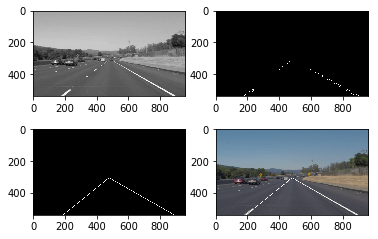

In [48]:
#tewhite_output = 'test_videos_output/solidWhiteRight.mp4'
white_output = 'white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

Slope & intercept:  [[0.64928909952606639, -6.1990521327014676], [0.69897959183673475, -33.525510204081684], [0.62576687116564422, 9.6625766871165411]]
Slope:  0.658011854176 Intercept:  -10.0206618832
Slope & intercept:  [[-0.60285714285714287, 600.9028571428571], [-0.62745098039215685, 615.17647058823525], [-0.60139860139860135, 610.65734265734261], [-0.6018957345971564, 601.19905213270147], [-0.64757709251101325, 620.59471365638763], [-0.72131147540983609, 650.70491803278696], [-0.64903846153846156, 621.61057692307691]]
Slope:  -0.635932784101 Intercept:  617.263704448
Coef:  0.658011854176 Intercept:  -10.0206618832 intersection_x:  484.784547789
Point one:  (484, 308) Point two:  (960, 621)
Coef:  -0.635932784101 Intercept:  617.263704448 intersection_x:  484.784547789
Point one:  (484, 308) Point two:  (0, 617)
(540, 960, 3)
[MoviePy] >>>> Building video test_videos_output/yellow.mp4
[MoviePy] Writing audio in yellowTEMP_MPY_wvf_snd.mp3


100%|██████████| 601/601 [00:00<00:00, 758.87it/s]

[MoviePy] Done.
[MoviePy] Writing video test_videos_output/yellow.mp4



  0%|          | 1/682 [00:00<01:09,  9.74it/s]

Slope & intercept:  [[0.64928909952606639, -6.1990521327014676], [0.69897959183673475, -33.525510204081684], [0.62576687116564422, 9.6625766871165411]]
Slope:  0.658011854176 Intercept:  -10.0206618832
Slope & intercept:  [[-0.60285714285714287, 600.9028571428571], [-0.62745098039215685, 615.17647058823525], [-0.60139860139860135, 610.65734265734261], [-0.6018957345971564, 601.19905213270147], [-0.64757709251101325, 620.59471365638763], [-0.72131147540983609, 650.70491803278696], [-0.64903846153846156, 621.61057692307691]]
Slope:  -0.635932784101 Intercept:  617.263704448
Coef:  0.658011854176 Intercept:  -10.0206618832 intersection_x:  484.784547789
Point one:  (484, 308) Point two:  (960, 621)
Coef:  -0.635932784101 Intercept:  617.263704448 intersection_x:  484.784547789
Point one:  (484, 308) Point two:  (0, 617)
(540, 960, 3)
Slope & intercept:  [[0.69918699186991873, -33.439024390243901], [0.6489795918367347, -7.3020408163265529]]
Slope:  0.674083291853 Intercept:  -20.3705326033

  0%|          | 3/682 [00:00<01:09,  9.72it/s]

-0.609757801458 Intercept:  607.811092733 intersection_x:  489.400360584
Point one:  (489, 309) Point two:  (0, 607)
(540, 960, 3)
Slope & intercept:  [[0.69683257918552033, -31.678733031674199], [0.65116279069767447, -9.3255813953488769], [0.72566371681415931, -56.04424778761063], [0.647887323943662, -7.1830985915493102], [0.72486772486772488, -53.597883597883595], [0.64444444444444449, -3.3333333333333712]]
Slope:  0.681809763326 Intercept:  -26.8604796229
Slope & intercept:  [[-0.65094339622641506, 624.92452830188677], [-0.62403100775193798, 609.43023255813955], [-0.62179487179487181, 608.01923076923072], [-0.6506024096385542, 621.32530120481931], [-0.6470588235294118, 622.76470588235293], [-0.66666666666666663, 632.66666666666663], [-0.62087912087912089, 608.26923076923072]]
Slope:  -0.64028232807 Intercept:  618.199985165
Coef:  0.681809763326 Intercept:  -26.8604796229 intersection_x:  487.90887487
Point one:  (487, 305) Point two:  (960, 627)
Coef:  -0.64028232807 Intercept:  61

  1%|          | 4/682 [00:00<01:10,  9.56it/s]

(540, 960, 3)
Slope & intercept:  [[0.72058823529411764, -53.308823529411768], [0.70666666666666667, -39.866666666666674], [0.71621621621621623, -49.702702702702709]]
Slope:  0.714490372726 Intercept:  -47.6260642996
Slope & intercept:  [[-0.6257309941520468, 610.95906432748541], [-0.65189873417721522, 625.35443037974687], [-0.65100671140939592, 626.88590604026842], [-0.6376811594202898, 611.8840579710145], [-0.65048543689320393, 625.81553398058259]]
Slope:  -0.647768010475 Intercept:  622.484982093
Coef:  0.714490372726 Intercept:  -47.6260642996 intersection_x:  491.911853622
Point one:  (491, 303) Point two:  (960, 638)
Coef:  -0.647768010475 Intercept:  622.484982093 intersection_x:  491.911853622
Point one:  (491, 303) Point two:  (0, 622)


  1%|          | 5/682 [00:00<01:11,  9.49it/s]

(540, 960, 3)
Slope & intercept:  [[0.64516129032258063, -2.0645161290322562], [0.75, -68.75]]
Slope:  0.697580645161 Intercept:  -35.4072580645
Slope & intercept:  [[-0.65048543689320393, 626.46601941747576], [-0.62426035502958577, 611.66272189349115], [-0.63414634146341464, 624.26829268292681], [-0.67441860465116277, 631.1395348837209], [-0.64983164983164987, 627.02693602693603]]
Slope:  -0.646628477574 Intercept:  624.112700981
Coef:  0.697580645161 Intercept:  -35.4072580645 intersection_x:  490.637913321
Point one:  (490, 306) Point two:  (960, 634)
Coef:  -0.646628477574 Intercept:  624.112700981 intersection_x:  490.637913321
Point one:  (490, 306) Point two:  (0, 624)
(540, 960, 3)

  1%|          | 7/682 [00:00<01:08,  9.81it/s]


Slope & intercept:  [[0.72268907563025209, -49.823529411764696], [0.66990291262135926, -23.61165048543694]]
Slope:  0.696295994126 Intercept:  -36.7175899486
Slope & intercept:  [[-0.62574850299401197, 612.7155688622754], [-0.6518518518518519, 628.25925925925924], [-0.64919354838709675, 628.23790322580646], [-0.58904109589041098, 599.76712328767121], [-0.64661654135338342, 620.79699248120301], [-0.63636363636363635, 616.27272727272725]]
Slope:  -0.64195481619 Intercept:  621.25649022
Coef:  0.696295994126 Intercept:  -36.7175899486 intersection_x:  491.667238381
Point one:  (491, 305) Point two:  (960, 631)
Coef:  -0.64195481619 Intercept:  621.25649022 intersection_x:  491.667238381
Point one:  (491, 305) Point two:  (0, 621)
(540, 960, 3)


  1%|          | 8/682 [00:00<01:11,  9.39it/s]

Slope & intercept:  [[0.64963503649635035, -11.029197080291965], [0.67741935483870963, -22.838709677419331], [0.69354838709677424, -39.45161290322585]]
Slope:  0.673534259477 Intercept:  -24.439839887
Slope & intercept:  [[-0.62691131498470953, 614.2293577981651], [-0.64876033057851235, 628.17768595041321], [-0.72268907563025209, 651.76470588235293], [-0.67346938775510201, 635.67346938775506], [-0.66956521739130437, 633.31304347826085], [-0.59999999999999998, 605.0], [-0.63513513513513509, 615.71621621621625], [-0.62613981762917936, 612.76291793313067]]
Slope:  -0.650333784888 Intercept:  624.579674581
Coef:  0.673534259477 Intercept:  -24.439839887 intersection_x:  490.244867855
Point one:  (490, 305) Point two:  (960, 622)
Coef:  -0.650333784888 Intercept:  624.579674581 intersection_x:  490.244867855
Point one:  (490, 305) Point two:  (0, 624)
(540, 960, 3)
Slope & intercept:  [[0.66666666666666663, -17.666666666666629], [0.67441860465116277, -27.767441860465112]]
Slope:  0.67054263

  1%|▏         | 10/682 [00:01<01:26,  7.81it/s]

(540, 960, 3)
Slope & intercept:  [[0.62264150943396224, 3.8490566037735903], [0.6987951807228916, -38.795180722891587], [0.68000000000000005, -25.800000000000011]]
Slope:  0.667145563386 Intercept:  -20.2487080397
Slope & intercept:  [[-0.62461538461538457, 612.95384615384614], [-0.66666666666666663, 632.0], [-0.65573770491803274, 628.95081967213116], [-0.69955156950672648, 641.0], [-0.69918699186991873, 640.13821138211381], [-0.62874251497005984, 615.07784431137725], [-0.69938650306748462, 643.22085889570553]]
Slope:  -0.667698190802 Intercept:  630.477368631
Coef:  0.667145563386 Intercept:  -20.2487080397 intersection_x:  487.49231858
Point one:  (487, 304) Point two:  (960, 620)
Coef:  -0.667698190802 Intercept:  630.477368631 intersection_x:  487.49231858
Point one:  (487, 304) Point two:  (0, 630)
(540, 960, 3)
Slope & intercept:  [[0.61682242990654201, 7.6074766355140468], [0.7010309278350515, -40.309278350515456]]
Slope:  0.658926678871 Intercept:  -16.3509008575
Slope & inter

  2%|▏         | 12/682 [00:01<01:17,  8.68it/s]

(540, 960, 3)
Slope & intercept:  [[0.62015503875968991, 5.2868217054263482], [0.70085470085470081, -41.811965811965763], [0.64473684210526316, -3.5657894736842195]]
Slope:  0.655248860573 Intercept:  -13.3636445267
Slope & intercept:  [[-0.64848484848484844, 619.41212121212118], [-0.67586206896551726, 636.32413793103444], [-0.65000000000000002, 621.14999999999998], [-0.67666666666666664, 635.44000000000005], [-0.66101694915254239, 620.62711864406776]]
Slope:  -0.662406106654 Intercept:  626.590675557
Coef:  0.655248860573 Intercept:  -13.3636445267 intersection_x:  485.676702931
Point one:  (485, 304) Point two:  (960, 615)
Coef:  -0.662406106654 Intercept:  626.590675557 intersection_x:  485.676702931
Point one:  (485, 304) Point two:  (0, 626)
(540, 960, 3)
Slope & intercept:  [[0.67333333333333334, -24.366666666666674], [0.62420382165605093, 2.2356687898089262], [0.67333333333333334, -23.693333333333328]]
Slope:  0.656956829441 Intercept:  -15.2747770701
Slope & intercept:  [[-0.67

  2%|▏         | 14/682 [00:01<01:15,  8.83it/s]

Slope & intercept:  [[0.62189054726368154, 4.6716417910448058], [0.67441860465116277, -24.883720930232528], [0.69918699186991873, -40.699186991869965], [0.60209424083769636, 19.0]]
Slope:  0.649397596156 Intercept:  -10.4778165328
Slope & intercept:  [[-0.64853556485355646, 622.652719665272], [-0.68032786885245899, 637.98360655737702], [-0.72727272727272729, 653.0], [-0.67567567567567566, 638.0], [-0.63025210084033612, 618.0420168067227], [-0.65109034267912769, 622.33956386292834], [-0.660377358490566, 631.39622641509436]]
Slope:  -0.667647376952 Intercept:  631.916304758
Coef:  0.649397596156 Intercept:  -10.4778165328 intersection_x:  487.754127162
Point one:  (487, 306) Point two:  (960, 612)
Coef:  -0.667647376952 Intercept:  631.916304758 intersection_x:  487.754127162
Point one:  (487, 306) Point two:  (0, 631)
(540, 960, 3)
Slope & intercept:  [[0.64976958525345618, -7.1566820276497651], [0.60357142857142854, 19.1357142857143], [0.59999999999999998, 20.0]]
Slope:  0.617780337942

  2%|▏         | 16/682 [00:01<01:18,  8.53it/s]

Slope & intercept:  [[0.64761904761904765, -5.3523809523809973], [0.60073260073260071, 20.377289377289401], [0.60144927536231885, 20.753623188405811]]
Slope:  0.616600307905 Intercept:  11.9261772044
Slope & intercept:  [[-0.69945355191256831, 646.76502732240442], [-0.6741573033707865, 631.69662921348311], [-0.66666666666666663, 628.0], [-0.69999999999999996, 645.39999999999998], [-0.67142857142857137, 627.62857142857138], [-0.75, 653.25], [-0.66666666666666663, 627.33333333333337]]
Slope:  -0.689767537149 Intercept:  637.1533659
Coef:  0.616600307905 Intercept:  11.9261772044 intersection_x:  478.599646388
Point one:  (478, 307) Point two:  (960, 603)
Coef:  -0.689767537149 Intercept:  637.1533659 intersection_x:  478.599646388
Point one:  (478, 307) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.59459459459459463, 26.054054054054006], [0.66129032258064513, -17.5], [0.59722222222222221, 23.388888888888914], [0.65079365079365081, -8.3650793650793958], [0.62337662337662336, 

  2%|▏         | 17/682 [00:01<01:27,  7.63it/s]

(540, 960, 3)


  3%|▎         | 18/682 [00:02<01:29,  7.45it/s]

Slope & intercept:  [[0.59999999999999998, 20.800000000000011], [0.6470588235294118, -5.8235294117647527], [0.61956521739130432, 6.4565217391304373]]
Slope:  0.62220801364 Intercept:  7.14433077579
Slope & intercept:  [[-0.67399267399267404, 631.2967032967033], [-0.70318021201413428, 646.99293286219086], [-0.67213114754098358, 629.40983606557381], [-0.70181818181818179, 647.48363636363638], [-0.67226890756302526, 630.42857142857144]]
Slope:  -0.684678224586 Intercept:  637.122336003
Coef:  0.62220801364 Intercept:  7.14433077579 intersection_x:  482.045021824
Point one:  (482, 307) Point two:  (960, 604)
Coef:  -0.684678224586 Intercept:  637.122336003 intersection_x:  482.045021824
Point one:  (482, 307) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.59459459459459463, 20.621621621621614], [0.625, 7.375], [0.59813084112149528, 23.112149532710305]]
Slope:  0.605908478572 Intercept:  17.0362570514
Slope & intercept:  [[-0.69915254237288138, 648.06779661016947], [-0.674576271

  3%|▎         | 21/682 [00:02<01:17,  8.58it/s]

(540, 960, 3)
Slope & intercept:  [[0.6097560975609756, 9.3902439024390105], [0.65000000000000002, -9.1999999999999886]]
Slope:  0.62987804878 Intercept:  0.0951219512195
Slope & intercept:  [[-0.67202572347266876, 628.72347266881025], [-0.70370370370370372, 646.07407407407413], [-0.7008928571428571, 646.63839285714289]]
Slope:  -0.692207428106 Intercept:  640.478646533
Coef:  0.62987804878 Intercept:  0.0951219512195 intersection_x:  484.373768397
Point one:  (484, 305) Point two:  (960, 604)
Coef:  -0.692207428106 Intercept:  640.478646533 intersection_x:  484.373768397
Point one:  (484, 305) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.65432098765432101, -13.123456790123441], [0.60784313725490191, 10.705882352941217]]
Slope:  0.631082062455 Intercept:  -1.20878721859
Slope & intercept:  [[-0.67419354838709677, 629.341935483871], [-0.703125, 645.125], [-0.67313915857605178, 628.20064724919098], [-0.68852459016393441, 642.39344262295083], [-0.67924528301886788, 641.92452

  3%|▎         | 23/682 [00:02<01:09,  9.44it/s]

Slope & intercept:  [[0.61904761904761907, 5.1428571428571104], [0.6428571428571429, -4.3571428571428896], [0.64406779661016944, -12.915254237288082], [0.66666666666666663, -21.333333333333314]]
Slope:  0.643159806295 Intercept:  -8.36571832123
Slope & intercept:  [[-0.70292887029288698, 644.55648535564853], [-0.6737967914438503, 629.1657754010696], [-0.67586206896551726, 628.21379310344832], [-0.70188679245283014, 645.09056603773581], [-0.68181818181818177, 630.0], [-0.67207792207792205, 627.73051948051943]]
Slope:  -0.684728437842 Intercept:  634.126189896
Coef:  0.643159806295 Intercept:  -8.36571832123 intersection_x:  483.844864998
Point one:  (483, 302) Point two:  (960, 609)
Coef:  -0.684728437842 Intercept:  634.126189896 intersection_x:  483.844864998
Point one:  (483, 302) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.59836065573770492, 17.188524590163922], [0.64912280701754388, -9.5263157894736992], [0.59523809523809523, 20.047619047619037]]
Slope:  0.6142405193

  4%|▎         | 25/682 [00:02<01:04, 10.16it/s]

(540, 960, 3)
Slope & intercept:  [[0.64878048780487807, -8.8878048780487688], [0.625, -0.75], [0.58149779735682816, 32.312775330396505], [0.67515923566878977, -27.222929936305718], [0.64347826086956517, -12.426086956521715]]
Slope:  

  4%|▍         | 27/682 [00:03<01:46,  6.14it/s]

0.63478315634 Intercept:  -3.3948092881
Slope & intercept:  [[-0.67357512953367871, 632.33160621761658], [-0.70281124497991965, 648.34136546184743], [-0.70175438596491224, 648.87719298245611], [-0.68965517241379315, 634.10344827586209], [-0.67450980392156867, 632.10980392156864], [-0.67213114754098358, 630.08196721311469]]
Slope:  -0.685739480726 Intercept:  637.640897345
Coef:  0.63478315634 Intercept:  -3.3948092881 intersection_x:  485.440906987
Point one:  (485, 304) Point two:  (960, 605)
Coef:  -0.685739480726 Intercept:  637.640897345 intersection_x:  485.440906987
Point one:  (485, 304) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.65022421524663676, -12.390134529147986], [0.59836065573770492, 17.827868852459005], [0.64583333333333337, -8.0416666666666856], [0.57727272727272727, 33.068181818181813]]
Slope:  0.617922732898 Intercept:  7.61606236871
Slope & intercept:  [[-0.67558528428093645, 632.23076923076928], [-0.70192307692307687, 648.90384615384619], [-0.708737

  4%|▍         | 30/682 [00:03<01:28,  7.38it/s]

Slope & intercept:  [[0.6292134831460674, 0.022471910112358273], [0.57425742574257421, 35.524752475247567], [0.56140350877192979, 44.684210526315837]]
Slope:  0.588291472554 Intercept:  26.7438116372
Slope & intercept:  [[-0.6759581881533101, 632.63414634146341], [-0.72868217054263562, 656.31782945736438], [-0.72631578947368425, 656.34736842105258], [-0.68333333333333335, 633.93333333333339], [-0.69668246445497628, 638.23696682464458]]
Slope:  -0.702194389192 Intercept:  643.493928876
Coef:  0.588291472554 Intercept:  26.7438116372 intersection_x:  477.92086339
Point one:  (477, 307) Point two:  (960, 591)
Coef:  -0.702194389192 Intercept:  643.493928876 intersection_x:  477.92086339
Point one:  (477, 307) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.61728395061728392, 7.5679012345678984], [0.62222222222222223, -6.6888888888888687]]
Slope:  0.61975308642 Intercept:  0.43950617284
Slope & intercept:  [[-0.67719298245614035, 632.83859649122803], [-0.72727272727272729, 655.8

  5%|▍         | 31/682 [00:03<01:26,  7.50it/s]

Slope & intercept:  [[0.59803921568627449, 18.166666666666686]]
Slope & intercept:  [[-0.67509025270758127, 633.1877256317689], [-0.70731707317073167, 651.73170731707319], [-0.75, 665.0], [-0.75, 658.75], [-0.70192307692307687, 651.00961538461536], [-0.77931034482758621, 674.18620689655177], [-0.77922077922077926, 671.83116883116884]]
Slope:  -0.74462854569 Intercept:  662.084783072
Coef:  0.598039215686 Intercept:  18.1666666667 intersection_x:  479.581125672
Point one:  (479, 304) Point two:  (960, 592)
Coef:  -0.74462854569 Intercept:  662.084783072 intersection_x:  479.581125672
Point one:  (479, 304) Point two:  (0, 662)
(540, 960, 3)
Slope & intercept:  [[0.62393162393162394, 3.2649572649572747], [0.59999999999999998, 17.400000000000034]]
Slope:  0.611965811966 Intercept:  10.3324786325
Slope & intercept:  [[-0.67407407407407405, 634.39259259259256], [-0.72769953051643188, 657.61502347417843], [-0.72033898305084743, 648.66949152542372], [-0.65540540540540537, 628.60810810810813],

  5%|▍         | 34/682 [00:04<01:15,  8.57it/s]

 [[0.6223776223776224, 3.2167832167831989]]
Slope & intercept:  [[-0.6992481203007519, 639.36842105263156], [-0.72857142857142854, 657.48571428571427], [-0.70048309178743962, 640.71014492753625], [-0.74468085106382975, 662.59574468085111], [-0.7142857142857143, 641.42857142857144]]
Slope:  -0.717453841202 Intercept:  648.317719275
Coef:  0.622377622378 Intercept:  3.21678321678 intersection_x:  481.479166294
Point one:  (481, 302) Point two:  (960, 600)
Coef:  -0.717453841202 Intercept:  648.317719275 intersection_x:  481.479166294
Point one:  (481, 302) Point two:  (0, 648)
(540, 960, 3)
Slope & intercept:  [[0.60869565217391308, 12.652173913043441]]
Slope & intercept:  [[-0.73184357541899436, 659.75418994413405], [-0.67704280155642027, 635.49416342412451], [-0.72093023255813948, 648.48837209302326], [-0.80882352941176472, 687.26470588235293], [-0.86842105263157898, 707.21052631578948], [-0.75, 658.25]]
Slope:  -0.759510198596 Intercept:  666.076992943
Coef:  0.608695652174 Intercept:

  5%|▌         | 36/682 [00:04<01:20,  8.07it/s]

(540, 960, 3)
Slope & intercept:  [[0.62121212121212122, 3.6666666666666856], [0.59154929577464788, 17.633802816901436]]
Slope:  0.606380708493 Intercept:  10.6502347418
Slope & intercept:  [[-0.75348837209302322, 665.17674418604656], [-0.7021276595744681, 641.51063829787233], [-0.77586206896551724, 667.9655172413793], [-0.74390243902439024, 662.23170731707319], [-0.78125, 675.78125], [-0.72289156626506024, 648.45783132530119]]
Slope:  -0.75547888927 Intercept:  663.922610014
Coef:  0.606380708493 Intercept:  10.6502347418 intersection_x:  479.691428063
Point one:  (479, 301) Point two:  (960, 592)
Coef:  -0.75547888927 Intercept:  663.922610014 intersection_x:  479.691428063
Point one:  (479, 301) Point two:  (0, 663)
(540, 960, 3)
Slope & intercept:  [[0.5730337078651685, 30.516853932584297], [0.62195121951219512, 3.4878048780487916]]
Slope:  0.597492463689 Intercept:  17.0023294053
Slope & intercept:  [[-0.71951219512195119, 645.39024390243901], [-0.75518672199170123, 665.1161825726

  6%|▌         | 38/682 [00:04<01:26,  7.48it/s]

 476.189584905
Point one:  (476, 301) Point two:  (960, 590)
Coef:  -0.752553903957 Intercept:  659.880348817 intersection_x:  476.189584905
Point one:  (476, 301) Point two:  (0, 659)
(540, 960, 3)
Slope & intercept:  [[0.57894736842105265, 26.947368421052602], [0.62135922330097082, 4.3106796116505279], [0.625, -6.625], [0.62857142857142856, -1.8857142857143003]]
Slope:  0.613469505073 Intercept:  5.68683343675
Slope & intercept:  [[-0.72614107883817425, 646.7053941908714], [-0.78666666666666663, 677.39999999999998], [-0.76923076923076927, 669.23076923076928], [-0.7531914893617021, 663.78297872340431], [-0.70357142857142863, 641.42499999999995], [-0.75257731958762886, 664.68041237113403], [-0.68493150684931503, 633.15068493150682], [-0.70833333333333337, 643.83333333333337]]
Slope:  -0.742816012227 Intercept:  658.151126836
Coef:  0.613469505073 Intercept:  5.68683343675 intersection_x:  481.067065213
Point one:  (481, 300) Point two:  (960, 594)
Coef:  -0.742816012227 Intercept:  658

  6%|▌         | 39/682 [00:04<01:28,  7.30it/s]

(540, 960, 3)
Slope & intercept:  [[0.6223776223776224, 2.0], [0.57768924302788849, 27.90039840637445], [0.5641025641025641, 37.487179487179503], [0.5547945205479452, 43.924657534246592], [0.6473214285714286, -19.63839285714289]]
Slope:  0.579740987514 Intercept:  27.828058857
Slope & intercept:  [[-0.75336322869955152, 663.30493273542606], [-0.70250896057347667, 639.56630824372758], [-0.69999999999999996, 636.89999999999998], [-0.7021276595744681, 638.61702127659578], [-0.95918367346938771, 742.9387755102041]]
Slope:  -0.763436704463 Intercept:  664.265407553
Coef:  0.579740987514 Intercept:  27.828058857 intersection_x:  473.829600132
Point one:  (473, 302) Point two:  (960, 584)
Coef:  -0.763436704463 Intercept:  664.265407553 intersection_x:  473.829600132
Point one:  (473, 302) Point two:  (0, 664)
(540, 960, 3)
Slope & intercept:  [[0.57599999999999996, 28.816000000000031], [0.62608695652173918, -0.68695652173914823]]
Slope:  0.601043478261 Intercept:  14.0645217391
Slope & inter

  6%|▌         | 42/682 [00:05<01:20,  7.95it/s]


Slope & intercept:  [[0.61971830985915488, 4.4225352112676433], [0.55555555555555558, 47.0]]
Slope:  0.587636932707 Intercept:  25.7112676056
Slope & intercept:  [[-0.75308641975308643, 662.25925925925924], [-0.7007299270072993, 639.60583941605842], [-0.70279720279720281, 638.90559440559446], [-0.83892617449664431, 690.95973154362423]]
Slope:  -0.748884931014 Intercept:  657.932606156
Coef:  0.587636932707 Intercept:  25.7112676056 intersection_x:  473.034789562
Point one:  (473, 303) Point two:  (960, 589)
Coef:  -0.748884931014 Intercept:  657.932606156 intersection_x:  473.034789562
Point one:  (473, 303) Point two:  (0, 657)
(540, 960, 3)
Slope & intercept:  [[0.56976744186046513, 34.569767441860449]]
Slope & intercept:  [[-0.70034843205574915, 637.44947735191636], [-0.75416666666666665, 662.68333333333339], [-0.7021276595744681, 639.40425531914889], [-0.75502008032128509, 662.33333333333337], [-0.70138888888888884, 638.29861111111109], [-0.72093023255813948, 643.8604651162791]]
S

  6%|▋         | 44/682 [00:05<01:23,  7.64it/s]

(540, 960, 3)
Slope & intercept:  [[0.59813084112149528, 18.317757009345826]]
Slope & intercept:  [[-0.75590551181102361, 662.96850393700788], [-0.70138888888888884, 638.29861111111109], [-0.80555555555555558, 677.0], [-0.70106761565836295, 639.25266903914587], [-0.83695652173913049, 691.17391304347825], [-0.78260869565217395, 672.73913043478262]]
Slope:  -0.763913798218 Intercept:  663.572137928
Coef:  0.598130841121 Intercept:  18.3177570093 intersection_x:  473.73952533
Point one:  (473, 301) Point two:  (960, 592)
Coef:  -0.763913798218 Intercept:  663.572137928 intersection_x:  473.73952533
Point one:  (473, 301) Point two:  (0, 663)
(540, 960, 3)
Slope & intercept:  [[0.578125, 32.34375]]
Slope & intercept:  [[-0.69999999999999996, 638.89999999999998], [-0.75348837209302322, 664.07906976744187], [-0.70138888888888884, 639.70138888888891], [-0.7441860465116279, 660.20930232558135], [-0.76595744680851063, 666.23404255319156], [-0.70370370370370372, 639.2962962962963]]
Slope:  -0.72

  7%|▋         | 46/682 [00:05<01:19,  7.98it/s]

(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 19.199999999999989]]
Slope & intercept:  [[-0.70307167235494883, 640.24232081911259], [-0.75342465753424659, 663.63013698630141], [-0.7678571428571429, 662.89285714285711], [-0.77083333333333337, 666.1875], [-0.70149253731343286, 639.14925373134326], [-0.7441860465116279, 659.06976744186045]]
Slope:  -0.740144231651 Intercept:  655.19530602
Coef:  0.6 Intercept:  19.2 intersection_x:  474.572281848
Point one:  (474, 303) Point two:  (960, 595)
Coef:  -0.740144231651 Intercept:  655.19530602 intersection_x:  474.572281848
Point one:  (474, 303) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.62, 7.2200000000000273], [0.61818181818181817, 2.8727272727272748], [0.63265306122448983, -7.4081632653061433]]
Slope:  0.623611626469 Intercept:  0.89485466914
Slope & intercept:  [[-0.75527426160337552, 664.37552742616037], [-0.70270270270270274, 639.67567567567562], [-0.70068027210884354, 639.59863945578229], [-0.7289719626168224

  7%|▋         | 48/682 [00:05<01:22,  7.67it/s]

(540, 960, 3)
Slope & intercept:  [[0.6166666666666667, 10.116666666666674], [0.625, -1.875], [0.63829787234042556, -11.808510638297889]]
Slope:  0.626654846336 Intercept:  -1.18894799054
Slope & intercept:  [[-0.75590551181102361, 664.48031496062993], [-0.70186335403726707, 639.71428571428578], [-0.72151898734177211, 644.34177215189868], [-0.72677595628415304, 647.51912568306011], [-0.68421052631578949, 636.73684210526312], [-0.75342465753424659, 664.67123287671234]]
Slope:  -0.731897693402 Intercept:  652.145346277
Coef:  0.626654846336 Intercept:  -1.18894799054 intersection_x:  480.904694635
Point one:  (480, 300) Point two:  (960, 600)
Coef:  -0.731897693402 Intercept:  652.145346277 intersection_x:  480.904694635
Point one:  (480, 300) Point two:  (0, 652)
(540, 960, 3)
Slope & intercept:  [[0.6495726495726496, -12.495726495726501], [0.58024691358024694, 27.160493827160451]]
Slope:  0.614909781576 Intercept:  7.33238366572
Slope & intercept:  [[-0.70068027210884354, 639.598639455

  7%|▋         | 50/682 [00:06<01:19,  7.95it/s]

Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 13.800000000000011], [0.6428571428571429, -8.9285714285714448], [0.59375, 16.5625], [0.62328767123287676, 4.1575342465753238]]
Slope:  0.614973703523 Intercept:  6.3978657045
Slope & intercept:  [[-0.75348837209302322, 663.32558139534888], [-0.72093023255813948, 643.53488372093022], [-0.77192982456140347, 664.12280701754389], [-0.75091575091575091, 661.15018315018312], [-0.74193548387096775, 649.83870967741939], [-0.70059880239520955, 638.35928143712567], [-0.70454545454545459, 640.86363636363637]]
Slope:  -0.73490627442 Intercept:  651.599297537
Coef:  0.614973703523 Intercept:  6.3978657045 intersection_x:  477.969480528
Point one:  (477, 300) Point two:  (960, 596)
Coef:  -0.73490627442 Intercept:  651.599297537 intersection_x:  477.969480528
Point one:  (477, 300) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.62295081967213117, 4.3770491803278446], [0.59836065573770492, 13.52459016393442], [0

  8%|▊         | 52/682 [00:06<01:20,  7.84it/s]

 5.43145065612
Slope & intercept:  [[-0.69965870307167233, 638.75085324232077], [-0.70044052863436124, 638.18942731277536], [-0.75600000000000001, 663.74000000000001], [-0.75555555555555554, 662.66666666666663]]
Slope:  -0.727913696815 Intercept:  650.836736805
Coef:  0.616363894605 Intercept:  5.43145065612 intersection_x:  480.113103327
Point one:  (480, 301) Point two:  (960, 597)
Coef:  -0.727913696815 Intercept:  650.836736805 intersection_x:  480.113103327
Point one:  (480, 301) Point two:  (0, 650)
(540, 960, 3)
Slope & intercept:  [[0.57539682539682535, 31.678571428571445], [0.60465116279069764, 17.976744186046517], [0.64676616915422891, -14.582089552238813], [0.59999999999999998, 12.199999999999989], [0.62439024390243902, 3.6292682926829229]]
Slope:  0.601109558022 Intercept:  16.3711459768
Slope & intercept:  [[-0.72222222222222221, 644.77777777777783], [-0.75555555555555554, 663.66666666666663], [-0.75091575091575091, 661.15018315018312], [-0.73809523809523814, 645.5], [-0.7

  8%|▊         | 54/682 [00:06<01:12,  8.68it/s]

(540, 960, 3)
Slope & intercept:  [[0.5714285714285714, 37.428571428571445], [0.60824742268041232, 16.948453608247462], [0.5625, 43.1875], [0.62244897959183676, 5.1836734693877133], [0.58252427184466016, 27.126213592233057]]
Slope:  0.589429849109 Intercept:  25.9748824197
Slope & intercept:  [[-0.75355450236966826, 662.81042654028442], [-0.70967741935483875, 640.61290322580646], [-0.75182481751824815, 661.54744525547449], [-0.71590909090909094, 641.38636363636363], [-0.71739130434782605, 643.1521739130435], [-0.72307692307692306, 646.03076923076924], [-0.74468085106382975, 645.48936170212767]]
Slope:  -0.730873558377 Intercept:  648.718491929
Coef:  0.589429849109 Intercept:  25.9748824197 intersection_x:  471.667047118
Point one:  (471, 303) Point two:  (960, 591)
Coef:  -0.730873558377 Intercept:  648.718491929 intersection_x:  471.667047118
Point one:  (471, 303) Point two:  (0, 648)
(540, 960, 3)
Slope & intercept:  [[0.57954545454545459, 31.704545454545439], [0.65306122448979587,

  8%|▊         | 56/682 [00:06<01:06,  9.45it/s]

 [[0.55434782608695654, 48.5]]
Slope & intercept:  [[-0.70175438596491224, 636.9473684210526], [-0.72941176470588232, 655.435294117647], [-0.73529411764705888, 656.61764705882354], [-0.6797385620915033, 631.64705882352939], [-0.67804878048780493, 632.67804878048787]]
Slope:  -0.704849522179 Intercept:  642.66508344
Coef:  0.554347826087 Intercept:  48.5 intersection_x:  471.860176849
Point one:  (471, 310) Point two:  (960, 580)
Coef:  -0.704849522179 Intercept:  642.66508344 intersection_x:  471.860176849
Point one:  (471, 310) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.57851239669421484, 29.628099173553721]]
Slope & intercept:  [[-0.70106761565836295, 636.85053380782915], [-0.75221238938053092, 660.85840707964599], [-0.76666666666666672, 667.26666666666665], [-0.75, 661.25], [-0.7192982456140351, 642.49122807017545]]
Slope:  -0.747044325415 Intercept:  657.966575454
Coef:  0.578512396694 Intercept:  29.6280991736 intersection_x:  474.018550697
Point one:  (474, 303) P

  9%|▉         | 60/682 [00:07<00:58, 10.57it/s]

(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 22.0], [0.5957446808510638, 19.212765957446834]]
Slope:  0.597872340426 Intercept:  20.6063829787
Slope & intercept:  [[-0.70155038759689925, 637.91860465116281], [-0.75, 660.75], [-0.75, 661.25], [-0.74390243902439024, 657.76829268292681], [-0.77653631284916202, 666.39106145251401], [-0.70175438596491224, 636.9473684210526]]
Slope:  -0.737290587573 Intercept:  653.504221201
Coef:  0.597872340426 Intercept:  20.6063829787 intersection_x:  474.022926304
Point one:  (474, 304) Point two:  (960, 594)
Coef:  -0.737290587573 Intercept:  653.504221201 intersection_x:  474.022926304
Point one:  (474, 304) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.5892857142857143, 24.285714285714278], [0.62222222222222223, 7.8666666666666742], [0.61538461538461542, 6.153846153846132], [0.60784313725490191, 18.13725490196083]]
Slope:  0.608683922287 Intercept:  14.110870502
Slope & intercept:  [[-0.70106761565836295, 637.14946619217085],

  9%|▉         | 62/682 [00:07<00:59, 10.49it/s]

Slope & intercept:  [[0.609375, 18.09375], [0.59633027522935778, 19.183486238532112]]
Slope:  0.602852637615 Intercept:  18.6386181193
Slope & intercept:  [[-0.69930069930069927, 635.90209790209792], [-0.72727272727272729, 653.63636363636363], [-0.71014492753623193, 645.8115942028985], [-0.67741935483870963, 629.74193548387098], [-0.7142857142857143, 648.42857142857144]]
Slope:  -0.712751017099 Intercept:  645.944656792
Coef:  0.602852637615 Intercept:  18.6386181193 intersection_x:  476.819927055
Point one:  (476, 306) Point two:  (960, 597)
Coef:  -0.712751017099 Intercept:  645.944656792 intersection_x:  476.819927055
Point one:  (476, 306) Point two:  (0, 645)
(540, 960, 3)
Slope & intercept:  [[0.59848484848484851, 18.106060606060566], [0.62204724409448819, 8.2598425196850371]]
Slope:  0.61026604629 Intercept:  13.1829515629
Slope & intercept:  [[-0.72953736654804269, 652.53736654804266], [-0.69767441860465118, 633.58139534883719], [-0.69999999999999996, 636.10000000000002], [-0.6

  9%|▉         | 64/682 [00:07<00:58, 10.53it/s]

(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 16.400000000000034], [0.62393162393162394, 7.1111111111110858], [0.59900990099009899, 15.212871287128735]]
Slope:  0.607647174974 Intercept:  12.9079941327
Slope & intercept:  [[-0.67763157894736847, 629.4802631578948], [-0.72727272727272729, 652.4545454545455], [-0.75, 656.0], [-0.72695035460992907, 650.67730496453896], [-0.68493150684931503, 630.30136986301363], [-0.69849246231155782, 635.1608040201005]]
Slope:  -0.710879771665 Intercept:  642.345714577
Coef:  0.607647174974 Intercept:  12.9079941327 intersection_x:  477.379489322
Point one:  (477, 302) Point two:  (960, 596)
Coef:  -0.710879771665 Intercept:  642.345714577 intersection_x:  477.379489322
Point one:  (477, 302) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.57894736842105265, 33.78947368421052], [0.62365591397849462, 7.5161290322580498], [0.62411347517730498, 7.5035460992907588], [0.59999999999999998, 16.800000000000011]]
Slope:  0.606679189394 Inter

 10%|▉         | 66/682 [00:07<00:57, 10.67it/s]

Slope & intercept:  [[0.62454873646209386, 7.7581227436822928], [0.59677419354838712, 19.806451612903231], [0.578125, 34.453125]]
Slope:  0.59981597667 Intercept:  20.6725664522
Slope & intercept:  [[-0.72573839662447259, 652.63291139240505], [-0.67656765676567654, 630.013201320132], [-0.67567567567567566, 628.97297297297291], [-0.75418994413407825, 659.53072625698326], [-0.72693726937269376, 652.40221402214024]]
Slope:  -0.711821788515 Intercept:  644.710405193
Coef:  0.59981597667 Intercept:  20.6725664522 intersection_x:  475.769953645
Point one:  (475, 306) Point two:  (960, 596)
Coef:  -0.711821788515 Intercept:  644.710405193 intersection_x:  475.769953645
Point one:  (475, 306) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.57647058823529407, 37.047058823529426], [0.64000000000000001, -3.7200000000000273], [0.57746478873239437, 34.070422535211264], [0.57499999999999996, 36.800000000000011]]
Slope:  0.576311792323 Intercept:  35.9724937862
Slope & intercept:  [[-0.725

 10%|█         | 70/682 [00:07<00:53, 11.43it/s]

Slope & intercept:  [[0.57657657657657657, 33.396396396396426], [0.60439560439560436, 21.362637362637372], [0.55140186915887845, 51.22429906542061]]
Slope:  0.57745801671 Intercept:  35.3277776082
Slope & intercept:  [[-0.72759856630824371, 653.96057347670251], [-0.67708333333333337, 630.97916666666663], [-0.67647058823529416, 631.35294117647061], [-0.65454545454545454, 620.27272727272725], [-0.73913043478260865, 655.39130434782612]]
Slope:  -0.694965675441 Intercept:  638.391342588
Coef:  0.57745801671 Intercept:  35.3277776082 intersection_x:  473.948708044
Point one:  (473, 309) Point two:  (960, 589)
Coef:  -0.694965675441 Intercept:  638.391342588 intersection_x:  473.948708044
Point one:  (473, 309) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.59523809523809523, 26.428571428571445], [0.57692307692307687, 32.000000000000057]]
Slope:  0.586080586081 Intercept:  29.2142857143
Slope & intercept:  [[-0.67441860465116277, 629.79069767441865], [-0.72262773722627738, 651.45

 11%|█         | 72/682 [00:08<00:55, 11.05it/s]


Slope & intercept:  [[0.61904761904761907, 12.047619047619037], [0.59999999999999998, 19.800000000000011], [0.61702127659574468, 14.617021276595722]]
Slope:  0.612022965214 Intercept:  15.4882134414
Slope & intercept:  [[-0.6763754045307443, 630.66343042071196], [-0.70183486238532111, 648.1880733944954], [-0.7142857142857143, 649.0], [-0.67532467532467533, 640.59740259740261], [-0.77777777777777779, 670.66666666666663], [-0.67558528428093645, 631.23076923076928], [-0.77500000000000002, 667.77499999999998], [-0.70547945205479456, 646.90410958904113]]
Slope:  -0.71270789633 Intercept:  648.128181487
Coef:  0.612022965214 Intercept:  15.4882134414 intersection_x:  477.56113065
Point one:  (477, 307) Point two:  (960, 603)
Coef:  -0.71270789633 Intercept:  648.128181487 intersection_x:  477.56113065
Point one:  (477, 307) Point two:  (0, 648)
(540, 960, 3)
Slope & intercept:  [[0.61403508771929827, 16.912280701754355], [0.59999999999999998, 20.400000000000034], [0.60194174757281549, 18.06

 11%|█         | 74/682 [00:08<00:54, 11.12it/s]

(540, 960, 3)
Slope & intercept:  [[0.6449704142011834, -2.5384615384614904], [0.57718120805369133, 36.73154362416102], [0.57608695652173914, 35.086956521739125], [0.58181818181818179, 32.272727272727309]]
Slope:  0.578362115465 Intercept:  34.6970758062
Slope & intercept:  [[-0.67576791808873715, 632.25597269624575], [-0.67741935483870963, 631.48387096774195], [-0.72602739726027399, 654.95890410958907], [-0.74285714285714288, 658.79999999999995], [-0.74509803921568629, 656.72549019607845], [-0.77966101694915257, 671.47457627118649], [-0.7407407407407407, 656.74074074074076], [-0.74509803921568629, 658.66666666666663], [-0.71232876712328763, 649.36986301369859]]
Slope:  -0.741687306195 Intercept:  658.105177285
Coef:  0.578362115465 Intercept:  34.6970758062 intersection_x:  472.261182991
Point one:  (472, 307) Point two:  (960, 589)
Coef:  -0.741687306195 Intercept:  658.105177285 intersection_x:  472.261182991
Point one:  (472, 307) Point two:  (0, 658)


 11%|█         | 76/682 [00:08<01:20,  7.55it/s]

(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 21.199999999999989], [0.64903846153846156, -4.8125]]
Slope:  0.624519230769 Intercept:  8.19375
Slope & intercept:  [[-0.67763157894736847, 632.51315789473688], [-0.72661870503597126, 653.97841726618708], [-0.69047619047619047, 635.07142857142856], [-0.72758620689655173, 653.95862068965516], [-0.67619047619047623, 630.58095238095234]]
Slope:  -0.699700631509 Intercept:  641.220515361
Coef:  0.624519230769 Intercept:  8.19375 intersection_x:  478.037509777
Point one:  (478, 306) Point two:  (960, 607)
Coef:  -0.699700631509 Intercept:  641.220515361 intersection_x:  478.037509777
Point one:  (478, 306) Point two:  (0, 641)
(540, 960, 3)


 11%|█▏        | 77/682 [00:09<01:39,  6.08it/s]

Slope & intercept:  [[0.59922178988326846, 21.653696498054501], [0.65053763440860213, -4.9516129032257936], [0.67123287671232879, -23.0], [0.647887323943662, -4.1126760563380458], [0.64853556485355646, -6.0962343096234122]]
Slope:  0.64348303796 Intercept:  -3.30136535423
Slope & intercept:  [[-0.67441860465116277, 632.41860465116281], [-0.72822299651567945, 654.78745644599303], [-0.70085470085470081, 640.05128205128199], [-0.72664359861591699, 653.53633217993081], [-0.70053475935828879, 638.73262032085563], [-0.69907407407407407, 637.69907407407413], [-0.6607142857142857, 629.05357142857144]]
Slope:  -0.704958122345 Intercept:  642.870894954
Coef:  0.64348303796 Intercept:  -3.30136535423 intersection_x:  479.199448467
Point one:  (479, 305) Point two:  (960, 614)
Coef:  -0.704958122345 Intercept:  642.870894954 intersection_x:  479.199448467
Point one:  (479, 305) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.59863945578231292, 22.571428571428555], [0.6470588235294118, -

 11%|█▏        | 78/682 [00:09<01:44,  5.78it/s]


Slope & intercept:  [[-0.69736842105263153, 636.56578947368416], [-0.72758620689655173, 653.95862068965516], [-0.70063694267515919, 638.66878980891715], [-0.72641509433962259, 654.2735849056603], [-0.70833333333333337, 637.625], [-0.6987951807228916, 636.68674698795178]]
Slope:  -0.70985586317 Intercept:  642.963088644
Coef:  0.643833107523 Intercept:  -4.01291150555 intersection_x:  477.935488991
Point one:  (477, 303) Point two:  (960, 614)
Coef:  -0.70985586317 Intercept:  642.963088644 intersection_x:  477.935488991
Point one:  (477, 303) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.59813084112149528, 23.607476635514047], [0.59999999999999998, 34.0], [0.65079365079365081, -5.6031746031746366], [0.67096774193548392, -20.896774193548424], [0.67317073170731712, -24.131707317073221], [0.67298578199052128, -24.715639810426524]]
Slope:  0.644341457925 Intercept:  -2.95663654812
Slope & intercept:  [[-0.72508591065292094, 652.83848797250857], [-0.69948186528497414, 637.4766

 12%|█▏        | 80/682 [00:09<01:44,  5.79it/s]

(540, 960, 3)
Slope & intercept:  [[0.5901639344262295, 29.868852459016409], [0.6166666666666667, 21.0], [0.64912280701754388, -7.263157894736878], [0.60256410256410253, 22.128205128205138], [0.66153846153846152, -18.307692307692321], [0.6428571428571429, -1.7142857142857792]]
Slope:  0.627152185845 Intercept:  7.61865361175
Slope & intercept:  [[-0.67426710097719866, 630.37459283387625], [-0.7407407407407407, 656.0], [-0.80555555555555558, 681.13888888888891], [-0.74193548387096775, 658.41935483870964], [-0.77692307692307694, 666.78461538461534], [-0.80487804878048785, 681.68292682926835], [-0.75147928994082835, 662.5976331360946], [-0.74545454545454548, 656.0363636363636], [-0.7008928571428571, 636.87946428571422], [-0.63235294117647056, 615.52941176470586]]
Slope:  -0.749125188821 Intercept:  658.879315537
Coef:  0.627152185845 Intercept:  7.61865361175 intersection_x:  473.204510888
Point one:  (473, 304) Point two:  (960, 609)
Coef:  -0.749125188821 Intercept:  658.879315537 inter

 12%|█▏        | 81/682 [00:09<01:39,  6.01it/s]

 0.631205673759 Intercept:  4.13829787234
Slope & intercept:  [[-0.69714285714285718, 636.86285714285714], [-0.72413793103448276, 651.9655172413793], [-0.72649572649572647, 653.74358974358972], [-0.69230769230769229, 634.0], [-0.71153846153846156, 638.75], [-0.67524115755627012, 630.50803858520896]]
Slope:  -0.710324533704 Intercept:  643.064392826
Coef:  0.631205673759 Intercept:  4.13829787234 intersection_x:  476.266647891
Point one:  (476, 304) Point two:  (960, 610)
Coef:  -0.710324533704 Intercept:  643.064392826 intersection_x:  476.266647891
Point one:  (476, 304) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.625, 9.375], [0.59999999999999998, 20.199999999999989], [0.59259259259259256, 23.370370370370381]]
Slope:  0.605864197531 Intercept:  17.6484567901
Slope & intercept:  [[-0.72641509433962259, 652.80188679245282], [-0.7010309278350515, 638.03092783505156], [-0.67441860465116277, 629.72093023255809], [-0.74626865671641796, 655.41791044776119], [-0.74193548387096

 12%|█▏        | 84/682 [00:10<01:19,  7.52it/s]

 intersection_x:  475.582705029
Point one:  (475, 305) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.64666666666666661, -3.3533333333332962], [0.64748201438848918, -11.143884892086305], [0.67142857142857137, -25.242857142857133]]
Slope:  0.655192417495 Intercept:  -13.2466917894
Slope & intercept:  [[-0.72649572649572647, 652.29059829059827], [-0.67313915857605178, 628.20064724919098], [-0.72401433691756267, 650.49820788530462], [-0.71875, 643.75], [-0.69421487603305787, 633.2066115702479]]
Slope:  -0.715868734862 Intercept:  644.936354437
Coef:  0.655192417495 Intercept:  -13.2466917894 intersection_x:  480.053748948
Point one:  (480, 301) Point two:  (960, 615)
Coef:  -0.715868734862 Intercept:  644.936354437 intersection_x:  480.053748948
Point one:  (480, 301) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.62264150943396224, 5.0754716981132333], [0.65116279069767447, -6.4186046511628092]]
Slope:  0.636902150066 Intercept:  -0.671566476525
Slope & intercept:

 13%|█▎        | 86/682 [00:10<01:11,  8.31it/s]

Slope & intercept:  [[0.65000000000000002, -5.6500000000000341], [0.6428571428571429, -7.6428571428571672], [0.61538461538461542, 17.307692307692264]]
Slope:  0.636080586081 Intercept:  1.33827838828
Slope & intercept:  [[-0.67441860465116277, 627.69767441860461], [-0.72413793103448276, 649.51724137931035], [-0.72327044025157228, 650.85534591194971], [-0.7533333333333333, 658.91999999999996], [-0.67547169811320751, 627.51320754716983]]
Slope:  -0.710126401477 Intercept:  642.900693851
Coef:  0.636080586081 Intercept:  1.33827838828 intersection_x:  476.570409597
Point one:  (476, 304) Point two:  (960, 611)
Coef:  -0.710126401477 Intercept:  642.900693851 intersection_x:  476.570409597
Point one:  (476, 304) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.66666666666666663, -16.333333333333314], [0.59868421052631582, 22.342105263157862], [0.58156028368794321, 32.90780141843976]]
Slope:  0.615637053627 Intercept:  12.9721911161
Slope & intercept:  [[-0.67449664429530198, 626.

 13%|█▎        | 89/682 [00:10<01:03,  9.28it/s]

(540, 960, 3)
Slope & intercept:  [[0.62303664921465973, 4.43979057591622], [0.65000000000000002, -4.6999999999999886], [0.64864864864864868, -4.5945945945946391]]
Slope:  0.640561765954 Intercept:  -1.61826800623
Slope & intercept:  [[-0.7007299270072993, 642.40875912408762], [-0.67441860465116277, 626.32558139534888], [-0.67449664429530198, 626.010067114094], [-0.68571428571428572, 636.42857142857144], [-0.75409836065573765, 664.57377049180332]]
Slope:  -0.697891564465 Intercept:  639.149349911
Coef:  0.640561765954 Intercept:  -1.61826800623 intersection_x:  478.73736301
Point one:  (478, 305) Point two:  (960, 613)
Coef:  -0.697891564465 Intercept:  639.149349911 intersection_x:  478.73736301
Point one:  (478, 305) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.65201465201465203, -7.432234432234452], [0.62337662337662336, 4.3766233766233995], [0.64963503649635035, -5.0948905109489147], [0.62105263157894741, 4.5157894736841513], [0.62393162393162394, 3.4102564102564088],

 13%|█▎        | 91/682 [00:10<01:00,  9.70it/s]

Slope & intercept:  [[0.60137457044673537, 23.22336769759454], [0.67193675889328064, -22.051383399209499], [0.66666666666666663, -16.0], [0.57746478873239437, 42.126760563380287], [0.57868020304568524, 39.375634517766514], [0.65098039215686276, -4.5686274509803866]]
Slope:  0.62451722999 Intercept:  10.3509586548
Slope & intercept:  [[-0.67434210526315785, 627.33881578947364], [-0.70070422535211263, 643.80633802816897], [-0.70169491525423733, 643.25423728813564], [-0.67326732673267331, 628.18811881188117]]
Slope:  -0.687502143151 Intercept:  635.646877479
Coef:  0.62451722999 Intercept:  10.3509586548 intersection_x:  476.590461715
Point one:  (476, 307) Point two:  (960, 609)
Coef:  -0.687502143151 Intercept:  635.646877479 intersection_x:  476.590461715
Point one:  (476, 307) Point two:  (0, 635)
(540, 960, 3)
Slope & intercept:  [[0.61855670103092786, 9.1340206185566899], [0.64772727272727271, -2.204545454545439], [0.65957446808510634, -10.319148936170166], [0.63829787234042556, -5.

 14%|█▍        | 95/682 [00:11<00:56, 10.38it/s]

(540, 960, 3)
Slope & intercept:  [[0.55769230769230771, 48.692307692307679], [0.66935483870967738, -12.451612903225794]]
Slope:  0.613523573201 Intercept:  18.1203473945
Slope & intercept:  [[-0.671875, 630.375], [-0.69999999999999996, 646.5], [-0.67549668874172186, 630.54304635761594], [-0.70388349514563109, 646.93203883495153]]
Slope:  -0.687813795972 Intercept:  638.587521298
Coef:  0.613523573201 Intercept:  18.1203473945 intersection_x:  476.791943889
Point one:  (476, 310) Point two:  (960, 607)
Coef:  -0.687813795972 Intercept:  638.587521298 intersection_x:  476.791943889
Point one:  (476, 310) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.58024691358024694, 36.086419753086432], [0.62037037037037035, 16.46296296296299]]
Slope:  0.600308641975 Intercept:  26.274691358
Slope & intercept:  [[-0.7007299270072993, 647.31386861313865], [-0.67400881057268724, 631.69603524229069], [-0.67647058823529416, 631.0], [-0.6875, 641.625], [-0.6875, 640.8125]]
Slope:  -0.685241865

 14%|█▍        | 97/682 [00:11<00:54, 10.71it/s]

Slope & intercept:  [[0.5714285714285714, 40.714285714285722], [0.625, 14.375]]
Slope:  0.598214285714 Intercept:  27.5446428571
Slope & intercept:  [[-0.70714285714285718, 648.67857142857144], [-0.67289719626168221, 631.18691588785043], [-0.68493150684931503, 643.84931506849318], [-0.67434210526315785, 630.3848684210526], [-0.6607142857142857, 639.92857142857144], [-0.68627450980392157, 643.01960784313724], [-0.72857142857142854, 658.0428571428572]]
Slope:  -0.687839127087 Intercept:  642.155815317
Coef:  0.598214285714 Intercept:  27.5446428571 intersection_x:  477.904857094
Point one:  (477, 313) Point two:  (960, 601)
Coef:  -0.687839127087 Intercept:  642.155815317 intersection_x:  477.904857094
Point one:  (477, 313) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.57425742574257421, 38.881188118811906], [0.67032967032967028, -14.340659340659329]]
Slope:  0.622293548036 Intercept:  12.2702643891
Slope & intercept:  [[-0.70110701107011075, 646.67158671586719], [-0.672955

 15%|█▍        | 99/682 [00:11<00:56, 10.34it/s]

(540, 960, 3)
Slope & intercept:  [[0.65454545454545454, -5.818181818181813], [0.64583333333333337, -6.75], [0.57999999999999996, 35.0]]
Slope:  0.626792929293 Intercept:  7.47727272727
Slope & intercept:  [[-0.67301587301587307, 630.2031746031746], [-0.70370370370370372, 647.77777777777783], [-0.70552147239263807, 647.31288343558276], [-0.67405063291139244, 631.01898734177212], [-0.68181818181818177, 644.5454545454545]]
Slope:  -0.687621972768 Intercept:  640.171655541
Coef:  0.626792929293 Intercept:  7.47727272727 intersection_x:  481.350585589
Point one:  (481, 309) Point two:  (960, 609)
Coef:  -0.687621972768 Intercept:  640.171655541 intersection_x:  481.350585589
Point one:  (481, 309) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.64179104477611937, 2.3880597014925797], [0.59740259740259738, 24.44155844155847]]
Slope:  0.619596821089 Intercept:  13.4148090715
Slope & intercept:  [[-0.67719298245614035, 630.51578947368421], [-0.70491803278688525, 648.67213114754099]

 15%|█▍        | 101/682 [00:11<00:59,  9.77it/s]

(540, 960, 3)
Slope & intercept:  [[0.65151515151515149, -4.3030303030303116], [0.60326086956521741, 20.983695652173878], [0.59999999999999998, 22.199999999999989]]
Slope:  0.618258673693 Intercept:  12.960221783
Slope & intercept:  [[-0.67405063291139244, 630.6708860759494], [-0.703125, 647.390625], [-0.70454545454545459, 647.06818181818187], [-0.67549668874172186, 629.19205298013242]]
Slope:  -0.68930444405 Intercept:  638.580436469
Coef:  0.618258673693 Intercept:  12.960221783 intersection_x:  478.462726729
Point one:  (478, 308) Point two:  (960, 606)
Coef:  -0.68930444405 Intercept:  638.580436469 intersection_x:  478.462726729
Point one:  (478, 308) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.6009174311926605, 22.486238532110121], [0.65000000000000002, -3.8500000000000227], [0.57627118644067798, 42.355932203389841]]
Slope:  0.609062872544 Intercept:  20.3307235785
Slope & intercept:  [[-0.6768707482993197, 630.37755102040819], [-0.72799999999999998, 655.7839999999

 15%|█▌        | 103/682 [00:11<00:57, 10.05it/s]

Slope & intercept:  [[0.64748201438848918, -1.2302158273380996], [0.62213740458015265, 7.0267175572519136], [0.62452107279693492, 6.0268199233715904]]
Slope:  0.631380163922 Intercept:  3.94110721776
Slope & intercept:  [[-0.6745762711864407, 629.06779661016947], [-0.70270270270270274, 646.91891891891896], [-0.70232558139534884, 646.19069767441863], [-0.67204301075268813, 630.10752688172045]]
Slope:  -0.687911891509 Intercept:  638.071235021
Coef:  0.631380163922 Intercept:  3.94110721776 intersection_x:  480.659400012
Point one:  (480, 307) Point two:  (960, 610)
Coef:  -0.687911891509 Intercept:  638.071235021 intersection_x:  480.659400012
Point one:  (480, 307) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.64800000000000002, -1.7839999999999918], [0.62365591397849462, 6.3978494623655706], [0.67213114754098358, -18.770491803278674], [0.6015325670498084, 23.329501915708818]]
Slope:  0.636329907142 Intercept:  2.2932148937
Slope & intercept:  [[-0.67193675889328064, 629.3

 15%|█▌        | 105/682 [00:12<01:01,  9.45it/s]

Slope & intercept:  [[0.59722222222222221, 25.791666666666686], [0.61616161616161613, 11.181818181818187], [0.62820512820512819, 13.5], [0.67441860465116277, -22.790697674418595]]
Slope:  0.613862988863 Intercept:  16.8244949495
Slope & intercept:  [[-0.67543859649122806, 629.38596491228077], [-0.70289855072463769, 645.05797101449275], [-0.66666666666666663, 626.0], [-0.72727272727272729, 651.09090909090912], [-0.70149253731343286, 645.32835820895525], [-0.66878980891719741, 626.94904458598728], [-0.70183486238532111, 646.38073394495416]]
Slope:  -0.692056249967 Intercept:  638.598997394
Coef:  0.613862988863 Intercept:  16.8244949495 intersection_x:  476.120179531
Point one:  (476, 309) Point two:  (960, 606)
Coef:  -0.692056249967 Intercept:  638.598997394 intersection_x:  476.120179531
Point one:  (476, 309) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.61538461538461542, 11.846153846153811], [0.66666666666666663, -19.666666666666629], [0.63829787234042556, 6.2978723404

 16%|█▌        | 109/682 [00:12<00:55, 10.33it/s]

(540, 960, 3)
Slope & intercept:  [[0.57377049180327866, 36.245901639344254], [0.62831858407079644, 8.9203539823009237]]
Slope:  0.601044537937 Intercept:  22.5831278108
Slope & intercept:  [[-0.67449664429530198, 628.42953020134223], [-0.72455089820359286, 653.94610778443121], [-0.72350230414746541, 652.57603686635946], [-0.71951219512195119, 647.42682926829264], [-0.75, 657.5], [-0.78378378378378377, 663.75675675675677], [-0.68888888888888888, 633.91111111111104], [-0.67142857142857137, 627.62857142857138]]
Slope:  -0.717020410734 Intercept:  645.646867927
Coef:  0.601044537937 Intercept:  22.5831278108 intersection_x:  472.710954604
Point one:  (472, 306) Point two:  (960, 599)
Coef:  -0.717020410734 Intercept:  645.646867927 intersection_x:  472.710954604
Point one:  (472, 306) Point two:  (0, 645)
(540, 960, 3)
Slope & intercept:  [[0.60240963855421692, 20.012048192771033], [0.62686567164179108, 11.134328358208961]]
Slope:  0.614637655098 Intercept:  15.5731882755
Slope & intercep

 16%|█▋        | 111/682 [00:12<00:54, 10.56it/s]

Slope & intercept:  [[0.57692307692307687, 36.692307692307736], [0.65306122448979587, -4.8775510204081343]]
Slope:  0.614992150706 Intercept:  15.9073783359
Slope & intercept:  [[-0.70370370370370372, 647.18518518518522], [-0.6745762711864407, 630.06779661016947], [-0.66990291262135926, 630.15533980582529], [-0.68493150684931503, 644.1232876712329], [-0.72222222222222221, 653.38888888888891], [-0.70512820512820518, 647.19230769230774]]
Slope:  -0.693410803619 Intercept:  642.018800976
Coef:  0.614992150706 Intercept:  15.9073783359 intersection_x:  478.531037071
Point one:  (478, 310) Point two:  (960, 606)
Coef:  -0.693410803619 Intercept:  642.018800976 intersection_x:  478.531037071
Point one:  (478, 310) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.6517857142857143, -4.1339285714285552], [0.62068965517241381, 8.8965517241379075], [0.59829059829059827, 24.341880341880369]]
Slope:  0.623588655916 Intercept:  9.70150116486
Slope & intercept:  [[-0.65359477124183007, 626.

 17%|█▋        | 113/682 [00:12<00:52, 10.77it/s]

(540, 960, 3)
Slope & intercept:  [[0.58273381294964033, 34.0], [0.67153284671532842, -18.11678832116786], [0.57792207792207795, 37.740259740259717]]
Slope:  0.610729579196 Intercept:  17.874490473
Slope & intercept:  [[-0.67708333333333337, 631.76041666666663], [-0.69999999999999996, 647.20000000000005], [-0.70256410256410251, 649.00512820512824], [-0.6875, 635.625], [-0.6588235294117647, 625.71764705882356], [-0.66972477064220182, 631.37614678899081], [-0.6333333333333333, 618.0], [-0.62295081967213117, 612.49180327868851], [-0.62264150943396224, 608.66037735849056]]
Slope:  -0.663846822043 Intercept:  628.870724373
Coef:  0.610729579196 Intercept:  17.874490473 intersection_x:  479.371996301
Point one:  (479, 310) Point two:  (960, 604)
Coef:  -0.663846822043 Intercept:  628.870724373 intersection_x:  479.371996301
Point one:  (479, 310) Point two:  (0, 628)
(540, 960, 3)
Slope & intercept:  [[0.67484662576687116, -21.061349693251543], [0.6216216216216216, 6.4324324324324493], [0.64

 17%|█▋        | 115/682 [00:13<00:55, 10.19it/s]

Slope & intercept:  [[0.64888888888888885, -3.9733333333333007], [0.62085308056872035, 7.2843601895734764], [0.65137614678899081, -4.6330275229357767]]
Slope:  0.640372705416 Intercept:  -0.440666888899
Slope & intercept:  [[-0.67355371900826444, 632.18181818181824], [-0.70175438596491224, 648.17543859649118], [-0.6875, 635.25], [-0.65934065934065933, 628.32967032967031], [-0.65740740740740744, 627.12962962962968], [-0.69047619047619047, 641.42857142857144], [-0.68627450980392157, 641.96078431372553], [-0.65765765765765771, 625.60360360360369]]
Slope:  -0.676745566207 Intercept:  635.00743951
Coef:  0.640372705416 Intercept:  -0.440666888899 intersection_x:  482.453337783
Point one:  (482, 308) Point two:  (960, 614)
Coef:  -0.676745566207 Intercept:  635.00743951 intersection_x:  482.453337783
Point one:  (482, 308) Point two:  (0, 635)
(540, 960, 3)
Slope & intercept:  [[0.65037593984962405, -4.7142857142857224], [0.62222222222222223, 5.0], [0.62096774193548387, 6.9758064516129252], 

 17%|█▋        | 119/682 [00:13<00:52, 10.77it/s]

(540, 960, 3)
Slope & intercept:  [[0.64935064935064934, -5.1558441558441359], [0.5730337078651685, 45.191011235955102], [0.67123287671232879, -21.986301369863043], [0.59999999999999998, 22.800000000000011], [0.64835164835164838, -4.4285714285714448], [0.66101694915254239, -13.694915254237287], [0.61842105263157898, 7.486842105263122]]
Slope:  0.631629554866 Intercept:  4.31603159039
Slope & intercept:  [[-0.67206477732793524, 631.49392712550605], [-0.70386266094420602, 648.02575107296138], [-0.68571428571428572, 634.71428571428578], [-0.65625, 626.84375], [-0.70256410256410251, 649.00512820512824], [-0.65384615384615385, 627.57692307692309], [-0.69047619047619047, 641.92857142857144], [-0.63513513513513509, 617.47297297297291], [-0.65408805031446537, 625.10691823899367]]
Slope:  -0.677358277648 Intercept:  635.586906858
Coef:  0.631629554866 Intercept:  4.31603159039 intersection_x:  482.258780095
Point one:  (482, 308) Point two:  (960, 610)
Coef:  -0.677358277648 Intercept:  635.586

 18%|█▊        | 121/682 [00:13<00:52, 10.77it/s]

Slope & intercept:  [[0.65040650406504064, -5.479674796747986], [0.62264150943396224, 6.1509433962264097]]
Slope:  0.63652400675 Intercept:  0.335634299739
Slope & intercept:  [[-0.67207792207792205, 631.84415584415581], [-0.72314049586776863, 654.39669421487611], [-0.72192513368983957, 655.08556149732624], [-0.6767676767676768, 631.07070707070704], [-0.67790262172284643, 632.55056179775283]]
Slope:  -0.694362770025 Intercept:  640.989536085
Coef:  0.63652400675 Intercept:  0.335634299739 intersection_x:  481.37370734
Point one:  (481, 306) Point two:  (960, 611)
Coef:  -0.694362770025 Intercept:  640.989536085 intersection_x:  481.37370734
Point one:  (481, 306) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.64383561643835618, -1.9863013698630425], [0.67241379310344829, -25.13793103448279]]
Slope:  0.658124704771 Intercept:  -13.5621162022
Slope & intercept:  [[-0.67301587301587307, 631.54920634920632], [-0.72522522522522526, 654.31081081081084], [-0.72486772486772488, 656

 18%|█▊        | 123/682 [00:13<00:51, 10.95it/s]

(540, 960, 3)
Slope & intercept:  [[0.64423076923076927, -1.8365384615385096], [0.62068965517241381, 7.1379310344827331]]
Slope:  0.632460212202 Intercept:  2.65069628647
Slope & intercept:  [[-0.72463768115942029, 656.95652173913049], [-0.67391304347826086, 632.3478260869565], [-0.72413793103448276, 655.31034482758616], [-0.69668246445497628, 639.02369668246445], [-0.6983240223463687, 640.45251396648041], [-0.72516556291390732, 656.47682119205297]]
Slope:  -0.713789532382 Intercept:  649.643979682
Coef:  0.632460212202 Intercept:  2.65069628647 intersection_x:  480.589345326
Point one:  (480, 306) Point two:  (960, 609)
Coef:  -0.713789532382 Intercept:  649.643979682 intersection_x:  480.589345326
Point one:  (480, 306) Point two:  (0, 649)
(540, 960, 3)
Slope & intercept:  [[0.6484375, -3.5859375], [0.62376237623762376, 4.9801980198020033], [0.60176991150442483, 20.194690265486713], [0.6428571428571429, -1.071428571428612]]
Slope:  0.62920673265 Intercept:  5.12938055347
Slope & int

 18%|█▊        | 125/682 [00:13<00:52, 10.52it/s]

Slope & intercept:  [[0.6462585034013606, -3.2585034013605991], [0.59589041095890416, 23.150684931506817]]
Slope:  0.62107445718 Intercept:  9.94609076507
Slope & intercept:  [[-0.72666666666666668, 657.44666666666672], [-0.69841269841269837, 639.79365079365084], [-0.69473684210526321, 640.02105263157898], [-0.65217391304347827, 629.95652173913049], [-0.69892473118279574, 641.11827956989248]]
Slope:  -0.704685234592 Intercept:  644.594912415
Coef:  0.62107445718 Intercept:  9.94609076507 intersection_x:  478.705775707
Point one:  (478, 307) Point two:  (960, 606)
Coef:  -0.704685234592 Intercept:  644.594912415 intersection_x:  478.705775707
Point one:  (478, 307) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.64772727272727271, -3.375], [0.59677419354838712, 23.822580645161281], [0.6460674157303371, -3.4438202247191043]]
Slope:  0.630189627335 Intercept:  5.66792014015
Slope & intercept:  [[-0.72425249169435213, 656.7774086378738], [-0.69565217391304346, 639.13043478260875

 19%|█▉        | 129/682 [00:14<00:50, 10.90it/s]

 9.72682437851
Slope & intercept:  [[-0.72580645161290325, 656.75806451612902], [-0.67757009345794394, 633.90186915887853], [-0.75, 667.75], [-0.68333333333333335, 636.7166666666667], [-0.77450980392156865, 674.65686274509812], [-0.67500000000000004, 634.52499999999998], [-0.72377622377622375, 656.69930069930069], [-0.75177304964539005, 669.82269503546104]]
Slope:  -0.720221119468 Intercept:  653.853807353
Coef:  0.622824779471 Intercept:  9.72682437851 intersection_x:  479.601615613
Point one:  (479, 308) Point two:  (960, 607)
Coef:  -0.720221119468 Intercept:  653.853807353 intersection_x:  479.601615613
Point one:  (479, 308) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.64925373134328357, -4.7761194029850458], [0.60278745644599308, 19.616724738675941], [0.58620689655172409, 34.206896551724185], [0.62181818181818183, 6.7236363636363876]]
Slope:  0.61501656654 Intercept:  13.9427845628
Slope & intercept:  [[-0.72661870503597126, 656.89208633093529], [-0.6769230769230769

 19%|█▉        | 131/682 [00:14<00:50, 11.01it/s]

Slope & intercept:  [[0.5957446808510638, 25.063829787234056], [0.62222222222222223, 15.95555555555552], [0.61971830985915488, 7.943661971831034], [0.62318840579710144, 11.043478260869563], [0.6470588235294118, -5.2941176470588402]]
Slope:  0.615218404682 Intercept:  15.0016313939
Slope & intercept:  [[-0.72516556291390732, 657.92715231788077], [-0.69565217391304346, 640.43478260869563], [-0.69565217391304346, 638.47826086956525], [-0.7142857142857143, 644.0], [-0.80508474576271183, 671.5], [-0.72444444444444445, 658.31555555555553], [-0.72222222222222221, 655.72222222222217], [-0.71999999999999997, 651.55999999999995]]
Slope:  -0.725313379682 Intercept:  652.242246697
Coef:  0.615218404682 Intercept:  15.0016313939 intersection_x:  475.364047862
Point one:  (475, 307) Point two:  (960, 605)
Coef:  -0.725313379682 Intercept:  652.242246697 intersection_x:  475.364047862
Point one:  (475, 307) Point two:  (0, 652)
(540, 960, 3)
Slope & intercept:  [[0.64646464646464652, -2.6666666666666

 20%|█▉        | 133/682 [00:14<00:50, 10.97it/s]

(540, 960, 3)
Slope & intercept:  [[0.65137614678899081, -6.2660550458715534], [0.61946902654867253, 7.3185840707964758]]
Slope:  0.635422586669 Intercept:  0.526264512462
Slope & intercept:  [[-0.72327044025157228, 655.89308176100633], [-0.67669172932330823, 634.09022556390983], [-0.72527472527472525, 656.94505494505495], [-0.67647058823529416, 633.14705882352939], [-0.74242424242424243, 664.66666666666674], [-0.77570093457943923, 674.75700934579436], [-0.74468085106382975, 666.36170212765956]]
Slope:  -0.723501930165 Intercept:  655.122971319
Coef:  0.635422586669 Intercept:  0.526264512462 intersection_x:  481.702036204
Point one:  (481, 306) Point two:  (960, 610)
Coef:  -0.723501930165 Intercept:  655.122971319 intersection_x:  481.702036204
Point one:  (481, 306) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.625, 4.0], [0.6460674157303371, -2.5674157303370748]]
Slope:  0.635533707865 Intercept:  0.716292134831
Slope & intercept:  [[-0.72563176895306858, 658.003610108

 20%|█▉        | 135/682 [00:14<00:54, 10.05it/s]


Slope & intercept:  [[0.57692307692307687, 35.807692307692321], [0.64383561643835618, -1.1369863013698591], [0.59999999999999998, 20.0]]
Slope:  0.606919564454 Intercept:  18.2235686688
Slope & intercept:  [[-0.67731629392971249, 634.21086261980827], [-0.72463768115942029, 657.1159420289855], [-0.72556390977443608, 658.83834586466162], [-0.67839195979899503, 636.0100502512563], [-0.63793103448275867, 617.27586206896558]]
Slope:  -0.701477461166 Intercept:  646.543800191
Coef:  0.606919564454 Intercept:  18.2235686688 intersection_x:  480.221384809
Point one:  (480, 309) Point two:  (960, 600)
Coef:  -0.701477461166 Intercept:  646.543800191 intersection_x:  480.221384809
Point one:  (480, 309) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.6179775280898876, 9.2471910112359978], [0.64655172413793105, -2.5431034482758719]]
Slope:  0.632264626114 Intercept:  3.35204378148
Slope & intercept:  [[-0.72425249169435213, 657.7774086378738], [-0.67721518987341767, 634.16455696202536

 20%|██        | 139/682 [00:15<00:51, 10.51it/s]

(540, 960, 3)
Slope & intercept:  [[0.64779874213836475, -4.1194968553459148], [0.59999999999999998, 21.0], [0.65189873417721522, -5.7594936708861155]]
Slope:  0.633232492105 Intercept:  3.70700315792
Slope & intercept:  [[-0.6728395061728395, 634.88888888888891], [-0.72425249169435213, 657.7774086378738], [-0.6962962962962963, 641.51111111111118], [-0.67622950819672134, 634.70081967213116], [-0.70399999999999996, 652.75199999999995]]
Slope:  -0.694723560472 Intercept:  644.326045662
Coef:  0.633232492105 Intercept:  3.70700315792 intersection_x:  482.409821666
Point one:  (482, 309) Point two:  (960, 611)
Coef:  -0.694723560472 Intercept:  644.326045662 intersection_x:  482.409821666
Point one:  (482, 309) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.64736842105263159, -3.8210526315789366], [0.59893048128342241, 22.219251336898424], [0.671875, -19.34375]]
Slope:  0.639391300779 Intercept:  -0.315183764894
Slope & intercept:  [[-0.72490706319702602, 657.15985130111528], [

 21%|██        | 141/682 [00:15<00:51, 10.58it/s]

Slope & intercept:  [[0.60434782608695647, 17.456521739130437], [0.64680851063829792, -4.0936170212766001], [0.57999999999999996, 37.460000000000036], [0.64935064935064934, -4.5324675324675354], [0.59913793103448276, 22.702586206896569]]
Slope:  0.615928983422 Intercept:  13.7986046785
Slope & intercept:  [[-0.72426470588235292, 656.33088235294122], [-0.69480519480519476, 640.0519480519481], [-0.69148936170212771, 637.97872340425533], [-0.72043010752688175, 654.70967741935488], [-0.7142857142857143, 640.57142857142856], [-0.65714285714285714, 630.65714285714284], [-0.73809523809523814, 663.21428571428578], [-0.67500000000000004, 632.97500000000002]]
Slope:  -0.708338617471 Intercept:  646.547420788
Coef:  0.615928983422 Intercept:  13.7986046785 intersection_x:  477.810387933
Point one:  (477, 308) Point two:  (960, 605)
Coef:  -0.708338617471 Intercept:  646.547420788 intersection_x:  477.810387933
Point one:  (477, 308) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.59931

 21%|██        | 143/682 [00:15<00:50, 10.62it/s]

(540, 960, 3)
Slope & intercept:  [[0.59210526315789469, 27.605263157894797], [0.6166666666666667, 20.549999999999955], [0.62337662337662336, 5.5714285714285552], [0.65079365079365081, -5.7142857142857224], [0.57746478873239437, 40.84507042253523]]
Slope:  0.602403335483 Intercept:  23.642940538
Slope & intercept:  [[-0.72480620155038755, 657.75968992248067], [-0.6954022988505747, 640.41379310344826], [-0.69607843137254899, 639.56862745098033], [-0.65671641791044777, 631.25373134328356], [-0.72426470588235292, 657.05514705882354], [-0.6875, 636.3125]]
Slope:  -0.705610327531 Intercept:  646.221951507
Coef:  0.602403335483 Intercept:  23.642940538 intersection_x:  475.972865248
Point one:  (475, 310) Point two:  (960, 601)
Coef:  -0.705610327531 Intercept:  646.221951507 intersection_x:  475.972865248
Point one:  (475, 310) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.64761904761904765, -3.6095238095238074], [0.61445783132530118, 10.397590361445793], [0.62222222222222223, 

 21%|██▏       | 145/682 [00:15<00:51, 10.53it/s]

Slope & intercept:  [[0.57894736842105265, 33.157894736842081], [0.67521367521367526, -19.846153846153868]]
Slope:  0.627080521817 Intercept:  6.65587044534
Slope & intercept:  [[-0.72413793103448276, 656.75862068965512], [-0.69607843137254899, 640.17647058823525], [-0.6964285714285714, 638.28571428571422], [-0.7142857142857143, 643.42857142857144], [-0.71186440677966101, 646.37288135593224], [-0.72438162544169615, 658.28621908127207], [-0.67816091954022983, 633.9540229885057], [-0.69354838709677424, 638.88709677419354]]
Slope:  -0.708675009634 Intercept:  646.027939172
Coef:  0.627080521817 Intercept:  6.65587044534 intersection_x:  478.659495448
Point one:  (478, 306) Point two:  (960, 608)
Coef:  -0.708675009634 Intercept:  646.027939172 intersection_x:  478.659495448
Point one:  (478, 306) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.64864864864864868, -5.3783783783783861], [0.61904761904761907, 8.3333333333333144], [0.6015625, 24.46875]]
Slope:  0.623086255899 Interc

 22%|██▏       | 149/682 [00:16<00:48, 10.93it/s]

(540, 960, 3)
Slope & intercept:  [[0.64485981308411211, -1.3177570093457689], [0.61904761904761907, 7.8571428571428328], [0.66666666666666663, -16.0]]
Slope:  0.643524699599 Intercept:  -3.15353805073
Slope & intercept:  [[-0.72623574144486691, 657.37642585551328], [-0.67697594501718217, 633.63917525773195], [-0.67582417582417587, 633.96703296703299], [-0.65714285714285714, 624.34285714285716], [-0.6292134831460674, 614.21348314606735], [-0.6097560975609756, 608.85365853658539], [-0.68085106382978722, 638.51063829787233]]
Slope:  -0.674373877734 Intercept:  633.674935445
Coef:  0.643524699599 Intercept:  -3.15353805073 intersection_x:  483.215085324
Point one:  (483, 307) Point two:  (960, 614)
Coef:  -0.674373877734 Intercept:  633.674935445 intersection_x:  483.215085324
Point one:  (483, 307) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.58163265306122447, 32.0], [0.64462809917355368, -2.3471074380165078]]
Slope:  0.613130376117 Intercept:  14.826446281
Slope & interce

 22%|██▏       | 151/682 [00:16<00:54,  9.74it/s]

Slope & intercept:  [[0.64583333333333337, -3.0208333333333712], [0.5957446808510638, 23.04255319148939], [0.64601769911504425, -5.7345132743362797]]
Slope:  0.6291985711 Intercept:  4.76240219461
Slope & intercept:  [[-0.72695035460992907, 656.49290780141848], [-0.67628205128205132, 633.35576923076928], [-0.60919540229885061, 607.91954022988511], [-0.72635135135135132, 655.66891891891896], [-0.65068493150684936, 624.21917808219177], [-0.60869565217391308, 605.04347826086962], [-0.68316831683168322, 636.00990099009903]]
Slope:  -0.668761151436 Intercept:  631.244241931
Coef:  0.6291985711 Intercept:  4.76240219461 intersection_x:  482.666625827
Point one:  (482, 308) Point two:  (960, 608)
Coef:  -0.668761151436 Intercept:  631.244241931 intersection_x:  482.666625827
Point one:  (482, 308) Point two:  (0, 631)
(540, 960, 3)
Slope & intercept:  [[0.57978723404255317, 34.739361702127667], [0.62068965517241381, 13.931034482758605], [0.5786516853932584, 34.797752808988776]]
Slope:  0.5930

 22%|██▏       | 153/682 [00:16<00:55,  9.53it/s]

Slope & intercept:  [[0.62285714285714289, 4.3199999999999932], [0.6160714285714286, 17.464285714285666], [0.57964601769911506, 35.5], [0.61290322580645162, 20.741935483870975]]
Slope:  0.607869453734 Intercept:  19.5065552995
Slope & intercept:  [[-0.72916666666666663, 658.58333333333337], [-0.67656765676567654, 634.7491749174917], [-0.676056338028169, 633.69014084507046], [-0.72789115646258506, 660.92517006802723]]
Slope:  -0.702420454481 Intercept:  646.986954791
Coef:  0.607869453734 Intercept:  19.5065552995 intersection_x:  478.886691836
Point one:  (478, 310) Point two:  (960, 603)
Coef:  -0.702420454481 Intercept:  646.986954791 intersection_x:  478.886691836
Point one:  (478, 310) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.60147601476014756, 18.542435424354267], [0.64885496183206104, -6.84732824427482], [0.59740259740259738, 23.012987012987026], [0.66995073891625612, -24.7192118226601], [0.6690647482014388, -20.417266187050302]]
Slope:  0.637349812223 Intercept

 23%|██▎       | 155/682 [00:16<00:53,  9.84it/s]

Slope & intercept:  [[0.59722222222222221, 20.625], [0.62637362637362637, 9.3406593406593288], [0.59183673469387754, 26.061224489795904], [0.63888888888888884, 0.72222222222228538], [0.59340659340659341, 27.098901098901081]]
Slope:  0.602209794174 Intercept:  20.7814462323
Slope & intercept:  [[-0.72881355932203384, 659.71186440677968], [-0.69480519480519476, 641.11688311688317], [-0.69599999999999995, 643.24800000000005], [-0.72222222222222221, 660.27777777777783], [-0.71153846153846156, 648.09615384615381], [-0.67816091954022983, 638.0114942528736], [-0.80434782608695654, 690.04347826086951], [-0.67601246105919, 636.37383177570098], [-0.77777777777777779, 680.77777777777783]]
Slope:  -0.721075380261 Intercept:  655.295251246
Coef:  0.602209794174 Intercept:  20.7814462323 intersection_x:  479.498914725
Point one:  (479, 309) Point two:  (960, 598)
Coef:  -0.721075380261 Intercept:  655.295251246 intersection_x:  479.498914725
Point one:  (479, 309) Point two:  (0, 655)
(540, 960, 3)


 23%|██▎       | 159/682 [00:17<00:50, 10.45it/s]

(540, 960, 3)
Slope & intercept:  [[0.57432432432432434, 35.763513513513487], [0.59880239520958078, 25.856287425149731]]
Slope:  0.586563359767 Intercept:  30.8099004693
Slope & intercept:  [[-0.67492260061919507, 639.23839009287929], [-0.72516556291390732, 662.27814569536429], [-0.67924528301886788, 638.88679245283015], [-0.71764705882352942, 661.88235294117646], [-0.74137931034482762, 670.74137931034488], [-0.74193548387096775, 664.80645161290317], [-0.69736842105263153, 645.57894736842104]]
Slope:  -0.711094817235 Intercept:  654.773208496
Coef:  0.586563359767 Intercept:  30.8099004693 intersection_x:  480.837958012
Point one:  (480, 312) Point two:  (960, 593)
Coef:  -0.711094817235 Intercept:  654.773208496 intersection_x:  480.837958012
Point one:  (480, 312) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.56976744186046513, 39.65116279069764], [0.6028368794326241, 24.680851063829778]]
Slope:  0.586302160647 Intercept:  32.1660069273
Slope & intercept:  [[-0.725165562

 24%|██▎       | 161/682 [00:17<00:50, 10.34it/s]

Slope & intercept:  [[0.59663865546218486, 27.025210084033631], [0.60204081632653061, 24.653061224489818], [0.58252427184466016, 31.456310679611647]]
Slope:  0.593734581211 Intercept:  27.7115273294
Slope & intercept:  [[-0.6741071428571429, 639.17857142857144], [-0.7010309278350515, 655.39175257731961], [-0.67889908256880738, 641.87155963302757], [-0.70930232558139539, 658.95348837209303], [-0.69047619047619047, 656.76190476190482], [-0.7483443708609272, 671.22516556291396], [-0.72635135135135132, 663.93243243243239]]
Slope:  -0.704073055933 Intercept:  655.330696395
Coef:  0.593734581211 Intercept:  27.7115273294 intersection_x:  483.599534402
Point one:  (483, 314) Point two:  (960, 597)
Coef:  -0.704073055933 Intercept:  655.330696395 intersection_x:  483.599534402
Point one:  (483, 314) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.58490566037735847, 36.433962264150978], [0.55813953488372092, 48.558139534883708], [0.57851239669421484, 33.561983471074427]]
Slope:  0.57

 24%|██▍       | 163/682 [00:17<00:50, 10.37it/s]

(540, 960, 3)
Slope & intercept:  [[0.62285714285714289, 10.805714285714259], [0.57627118644067798, 34.983050847457605], [0.67021276595744683, -22.829787234042556], [0.64473684210526316, -6.0131578947368212]]
Slope:  0.62851948434 Intercept:  4.2364550011
Slope & intercept:  [[-0.72757475083056478, 665.59800664451825], [-0.69354838709677424, 647.58064516129036], [-0.69811320754716977, 646.20754716981128], [-0.71153846153846156, 651.15384615384619], [-0.7142857142857143, 652.85714285714289], [-0.70270270270270274, 656.64864864864865], [-0.70454545454545459, 648.2045454545455], [-0.74545454545454548, 668.20000000000005], [-0.69736842105263153, 648.36842105263156]]
Slope:  -0.710570182784 Intercept:  653.868755905
Coef:  0.62851948434 Intercept:  4.2364550011 intersection_x:  485.129798887
Point one:  (485, 309) Point two:  (960, 607)
Coef:  -0.710570182784 Intercept:  653.868755905 intersection_x:  485.129798887
Point one:  (485, 309) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:

 24%|██▍       | 165/682 [00:17<00:48, 10.72it/s]

Slope & intercept:  [[0.62396694214876036, 7.4669421487603245], [0.57692307692307687, 33.423076923076962], [0.62222222222222223, 7.6444444444444457]]
Slope:  0.607704080431 Intercept:  16.1781545054
Slope & intercept:  [[-0.72666666666666668, 665.89333333333332], [-0.67790262172284643, 642.003745318352], [-0.70063694267515919, 648.29936305732485], [-0.67796610169491522, 640.61016949152543], [-0.75401069518716579, 672.82887700534764], [-0.74137931034482762, 667.74137931034488], [-0.75609756097560976, 672.58536585365846]]
Slope:  -0.719237128467 Intercept:  658.566033339
Coef:  0.607704080431 Intercept:  16.1781545054 intersection_x:  484.111786208
Point one:  (484, 310) Point two:  (960, 599)
Coef:  -0.719237128467 Intercept:  658.566033339 intersection_x:  484.111786208
Point one:  (484, 310) Point two:  (0, 658)
(540, 960, 3)
Slope & intercept:  [[0.57859531772575246, 32.729096989966592], [0.6028368794326241, 22.574468085106389], [0.57608695652173914, 33.347826086956502], [0.554655870

 24%|██▍       | 167/682 [00:18<00:56,  9.20it/s]

Slope & intercept:  [[0.60360360360360366, 20.7117117117117], [0.5714285714285714, 36.285714285714334], [0.56140350877192979, 42.526315789473699]]
Slope:  0.578811894601 Intercept:  33.1745805956
Slope & intercept:  [[-0.67796610169491522, 642.40677966101691], [-0.72759856630824371, 664.60215053763443], [-0.68181818181818177, 642.36363636363637], [-0.69565217391304346, 646.82608695652175], [-0.80952380952380953, 697.42857142857144], [-0.73999999999999999, 668.20000000000005], [-0.7846153846153846, 684.84615384615381], [-0.71014492753623193, 661.14492753623188], [-0.69651741293532343, 648.27363184079604]]
Slope:  -0.724870728705 Intercept:  661.78799313
Coef:  0.578811894601 Intercept:  33.1745805956 intersection_x:  482.182857466
Point one:  (482, 312) Point two:  (960, 588)
Coef:  -0.724870728705 Intercept:  661.78799313 intersection_x:  482.182857466
Point one:  (482, 312) Point two:  (0, 661)
(540, 960, 3)
Slope & intercept:  [[0.60869565217391308, 17.347826086956502], [0.5500000000

 25%|██▍       | 169/682 [00:18<01:03,  8.03it/s]


Slope:  -0.715114716295 Intercept:  657.044847692
Coef:  0.584003893946 Intercept:  29.8479402773 intersection_x:  482.786484983
Point one:  (482, 311) Point two:  (960, 590)
Coef:  -0.715114716295 Intercept:  657.044847692 intersection_x:  482.786484983
Point one:  (482, 311) Point two:  (0, 657)
(540, 960, 3)
Slope & intercept:  [[0.62222222222222223, 4.7777777777777715], [0.57291666666666663, 32.96875], [0.5982142857142857, 22.41964285714289]]
Slope:  0.597784391534 Intercept:  20.0553902116
Slope & intercept:  [[-0.72844827586206895, 667.66379310344826], [-0.69999999999999996, 649.89999999999998], [-0.73015873015873012, 667.0], [-0.71666666666666667, 652.86666666666667], [-0.69930069930069927, 650.57342657342656]]
Slope:  -0.714914874398 Intercept:  657.600777269
Coef:  0.597784391534 Intercept:  20.0553902116 intersection_x:  485.675130323
Point one:  (485, 310) Point two:  (960, 593)
Coef:  -0.714914874398 Intercept:  657.600777269 intersection_x:  485.675130323
Point one:  (485

 25%|██▍       | 170/682 [00:18<01:02,  8.21it/s]

Point one:  (486, 308) Point two:  (0, 662)
(540, 960, 3)
Slope & intercept:  [[0.57352941176470584, 32.573529411764753], [0.578125, 34.078125]]
Slope:  0.575827205882 Intercept:  33.3258272059
Slope & intercept:  [[-0.72999999999999998, 668.66999999999996], [-0.70032573289902278, 650.05211726384368], [-0.84090909090909094, 710.18181818181824], [-0.81176470588235294, 699.90588235294126], [-0.6996699669966997, 650.94719471947201], [-0.73529411764705888, 669.11764705882354], [-0.78106508875739644, 683.41420118343194]]
Slope:  -0.757004100442 Intercept:  676.041265823
Coef:  0.575827205882 Intercept:  33.3258272059 intersection_x:  482.218143862
Point one:  (482, 311) Point two:  (960, 586)
Coef:  -0.757004100442 Intercept:  676.041265823 intersection_x:  482.218143862
Point one:  (482, 311) Point two:  (0, 676)
(540, 960, 3)
Slope & intercept:  [[0.5714285714285714, 37.285714285714278], [0.54545454545454541, 49.272727272727309]]
Slope:  0.558441558442 Intercept:  43.2792207792
Slope & in

 25%|██▌       | 173/682 [00:18<01:01,  8.29it/s]

(540, 960, 3)
Slope & intercept:  [[0.57999999999999996, 33.340000000000032], [0.60465116279069764, 11.255813953488371]]
Slope:  0.592325581395 Intercept:  22.2979069767
Slope & intercept:  [[-0.75336322869955152, 676.24663677130047], [-0.70099667774086383, 651.56146179401992], [-0.70114942528735635, 650.43678160919535], [-0.72448979591836737, 669.13265306122446], [-0.77941176470588236, 682.42647058823536]]
Slope:  -0.73188217847 Intercept:  665.960800765
Coef:  0.592325581395 Intercept:  22.2979069767 intersection_x:  486.073947983
Point one:  (486, 310) Point two:  (960, 590)
Coef:  -0.73188217847 Intercept:  665.960800765 intersection_x:  486.073947983
Point one:  (486, 310) Point two:  (0, 665)
(540, 960, 3)
Slope & intercept:  [[0.62376237623762376, 3.2376237623762449], [0.55737704918032782, 41.049180327868896]]
Slope:  0.590569712709 Intercept:  22.1434020451
Slope & intercept:  [[-0.75572519083969469, 676.5419847328244], [-0.70169491525423733, 651.67457627118642], [-0.7058823529

 26%|██▌       | 175/682 [00:19<01:00,  8.40it/s]

 -0.738202070647 Intercept:  668.567422768
Coef:  0.590569712709 Intercept:  22.1434020451 intersection_x:  486.482350709
Point one:  (486, 309) Point two:  (960, 589)
Coef:  -0.738202070647 Intercept:  668.567422768 intersection_x:  486.482350709
Point one:  (486, 309) Point two:  (0, 668)
(540, 960, 3)
Slope & intercept:  [[0.62184873949579833, 4.0252100840336311], [0.55384615384615388, 43.923076923076906]]
Slope:  0.587847446671 Intercept:  23.9741435036
Slope & intercept:  [[-0.75294117647058822, 675.78823529411761], [-0.70036101083032487, 652.15884476534291], [-0.75462962962962965, 677.37962962962968], [-0.75423728813559321, 670.45762711864404], [-0.7483443708609272, 666.73509933774835], [-0.70454545454545459, 651.31818181818176]]
Slope:  -0.735843155079 Intercept:  665.639602994
Coef:  0.587847446671 Intercept:  23.9741435036 intersection_x:  484.754865406
Point one:  (484, 308) Point two:  (960, 588)
Coef:  -0.735843155079 Intercept:  665.639602994 intersection_x:  484.754865406

 26%|██▌       | 177/682 [00:19<00:55,  9.13it/s]

Slope & intercept:  [[0.6235955056179775, -0.1235955056179705], [0.5532994923857868, 44.847715736040641], [0.53164556962025311, 59.367088607594951], [0.64423076923076927, -13.644230769230774]]
Slope:  0.588192834214 Intercept:  22.6117445172
Slope & intercept:  [[-0.72666666666666668, 660.08000000000004], [-0.78191489361702127, 687.80851063829789], [-0.77551020408163263, 684.79591836734699], [-0.7277227722772277, 662.11881188118809], [-0.80952380952380953, 695.0], [-0.83206106870229013, 695.74809160305347]]
Slope:  -0.775566569145 Intercept:  680.925222082
Coef:  0.588192834214 Intercept:  22.6117445172 intersection_x:  482.719661506
Point one:  (482, 306) Point two:  (960, 587)
Coef:  -0.775566569145 Intercept:  680.925222082 intersection_x:  482.719661506
Point one:  (482, 306) Point two:  (0, 680)
(540, 960, 3)
Slope & intercept:  [[0.60256410256410253, 15.782051282051327], [0.57786885245901642, 25.741803278688508]]
Slope:  0.590216477512 Intercept:  20.7619272804
Slope & intercept:

 27%|██▋       | 181/682 [00:19<00:49, 10.17it/s]

(540, 960, 3)
Slope & intercept:  [[0.57608695652173914, 36.22826086956519], [0.55223880597014929, 44.865671641791039], [0.53164556962025311, 63.000000000000057], [0.50458715596330272, 88.412844036697265], [0.53164556962025311, 60.924050632911417]]
Slope:  0.530029275293 Intercept:  64.3006415778
Slope & intercept:  [[-0.72635135135135132, 662.20608108108104], [-0.78102189781021902, 688.17518248175179], [-0.7814569536423841, 689.74172185430461], [-0.72992700729927007, 662.60583941605842], [-0.78189300411522633, 689.23456790123453], [-0.75316455696202533, 671.72784810126586]]
Slope:  -0.75896912853 Intercept:  677.281873473
Coef:  0.530029275293 Intercept:  64.3006415778 intersection_x:  475.548480182
Point one:  (475, 316) Point two:  (960, 573)
Coef:  -0.75896912853 Intercept:  677.281873473 intersection_x:  475.548480182
Point one:  (475, 316) Point two:  (0, 677)
(540, 960, 3)
Slope & intercept:  [[0.53333333333333333, 59.733333333333348], [0.54166666666666663, 54.291666666666686]]


 27%|██▋       | 183/682 [00:19<00:48, 10.22it/s]

Slope & intercept:  [[0.51327433628318586, 70.548672566371692], [0.53271028037383172, 59.906542056074784]]
Slope:  0.522992308329 Intercept:  65.2276073112
Slope & intercept:  [[-0.78102189781021902, 687.17518248175179], [-0.75324675324675328, 669.50649350649348], [-0.72945205479452058, 662.73630136986299], [-0.7303370786516854, 661.79775280898878], [-0.80540540540540539, 696.12432432432433]]
Slope:  -0.759892637982 Intercept:  675.468010898
Coef:  0.522992308329 Intercept:  65.2276073112 intersection_x:  475.678201184
Point one:  (475, 314) Point two:  (960, 567)
Coef:  -0.759892637982 Intercept:  675.468010898 intersection_x:  475.678201184
Point one:  (475, 314) Point two:  (0, 675)
(540, 960, 3)
Slope & intercept:  [[0.52671755725190839, 60.229007633587798], [0.53097345132743368, 62.265486725663663], [0.57432432432432434, 35.040540540540519]]
Slope:  0.544005110968 Intercept:  52.5116782999
Slope & intercept:  [[-0.78102189781021902, 687.17518248175179], [-0.75342465753424659, 669.

 27%|██▋       | 185/682 [00:19<00:48, 10.22it/s]

(540, 960, 3)
Slope & intercept:  [[0.54166666666666663, 51.833333333333371], [0.55752212389380529, 46.787610619469035]]
Slope:  0.54959439528 Intercept:  49.3104719764
Slope & intercept:  [[-0.75, 670.5], [-0.77857142857142858, 688.26428571428573], [-0.75438596491228072, 670.26315789473688], [-0.75352112676056338, 672.38732394366195], [-0.76249999999999996, 679.75], [-0.76744186046511631, 674.18604651162786], [-0.759493670886076, 684.34177215189879], [-0.80891719745222934, 698.95541401273886]]
Slope:  -0.766853906131 Intercept:  679.831000029
Coef:  0.54959439528 Intercept:  49.3104719764 intersection_x:  478.955783813
Point one:  (478, 312) Point two:  (960, 576)
Coef:  -0.766853906131 Intercept:  679.831000029 intersection_x:  478.955783813
Point one:  (478, 312) Point two:  (0, 679)
(540, 960, 3)
Slope & intercept:  [[0.52713178294573648, 62.480620155038707], [0.5736434108527132, 36.612403100775168], [0.55172413793103448, 44.793103448275872]]
Slope:  0.550833110576 Intercept:  47.9

 27%|██▋       | 187/682 [00:20<00:47, 10.41it/s]

Slope & intercept:  [[0.55371900826446285, 44.0], [0.57792207792207795, 34.785714285714278], [0.55555555555555558, 49.111111111111086]]
Slope:  0.562398880581 Intercept:  42.6322751323
Slope & intercept:  [[-0.73006134969325154, 663.01840490797542], [-0.78339350180505418, 688.97833935018048], [-0.78136200716845883, 688.80286738351253], [-0.75342465753424659, 670.82191780821915], [-0.75308641975308643, 669.28395061728395], [-0.76190476190476186, 672.66666666666663]]
Slope:  -0.766634269633 Intercept:  678.110748365
Coef:  0.562398880581 Intercept:  42.6322751323 intersection_x:  478.150957431
Point one:  (478, 311) Point two:  (960, 582)
Coef:  -0.766634269633 Intercept:  678.110748365 intersection_x:  478.150957431
Point one:  (478, 311) Point two:  (0, 678)
(540, 960, 3)
Slope & intercept:  [[0.57608695652173914, 35.086956521739125], [0.55172413793103448, 45.344827586206918], [0.59854014598540151, 17.890510948905103]]
Slope:  0.575450413479 Intercept:  32.7740983523
Slope & intercept:

 28%|██▊       | 191/682 [00:20<00:45, 10.82it/s]

(540, 960, 3)
Slope & intercept:  [[0.57720588235294112, 34.415441176470608], [0.5311475409836065, 61.213114754098399], [0.532258064516129, 59.370967741935488]]
Slope:  0.546870495951 Intercept:  51.6665078908
Slope & intercept:  [[-0.77876106194690264, 688.30088495575228], [-0.7289377289377289, 664.29304029304035], [-0.75172413793103443, 669.79999999999995], [-0.78666666666666663, 689.07999999999993], [-0.75444839857651247, 670.02846975088971], [-0.75257731958762886, 678.32989690721649]]
Slope:  -0.764835516942 Intercept:  679.107850323
Coef:  0.546870495951 Intercept:  51.6665078908 intersection_x:  478.339914786
Point one:  (478, 313) Point two:  (960, 576)
Coef:  -0.764835516942 Intercept:  679.107850323 intersection_x:  478.339914786
Point one:  (478, 313) Point two:  (0, 679)
(540, 960, 3)
Slope & intercept:  [[0.57482993197278909, 36.819727891156504], [0.55200000000000005, 45.511999999999944], [0.5982142857142857, 16.348214285714278], [0.57931034482758625, 30.68275862068964]]
Sl

 28%|██▊       | 193/682 [00:20<00:45, 10.81it/s]

Slope & intercept:  [[0.5803571428571429, 31.76785714285711], [0.55045871559633031, 46.944954128440315], [0.56451612903225812, 34.483870967741893], [0.53623188405797106, 61.304347826086939], [0.57333333333333336, 34.74666666666667], [0.58490566037735847, 16.188679245283026], [0.59259259259259256, 22.888888888888914]]
Slope:  0.568913636835 Intercept:  35.475037838
Slope & intercept:  [[-0.80932203389830504, 696.71610169491521], [-0.75308641975308643, 670.1358024691358], [-0.75172413793103443, 669.04827586206898], [-0.77981651376146788, 688.50458715596324], [-0.83544303797468356, 709.08860759493678], [-0.84905660377358494, 716.11320754716985]]
Slope:  -0.796408124515 Intercept:  691.601097054
Coef:  0.568913636835 Intercept:  35.475037838 intersection_x:  480.565151593
Point one:  (480, 308) Point two:  (960, 581)
Coef:  -0.796408124515 Intercept:  691.601097054 intersection_x:  480.565151593
Point one:  (480, 308) Point two:  (0, 691)
(540, 960, 3)
Slope & intercept:  [[0.5737704918032

 29%|██▊       | 195/682 [00:21<01:08,  7.13it/s]

Slope & intercept:  [[0.53278688524590168, 62.459016393442596], [0.53020134228187921, 60.134228187919462]]
Slope:  0.531494113764 Intercept:  61.2966222907
Slope & intercept:  [[-0.75352112676056338, 667.85211267605632], [-0.80628272251308897, 694.50261780104711], [-0.75352112676056338, 667.6056338028169], [-0.75862068965517238, 682.13793103448279], [-0.76666666666666672, 682.79999999999995], [-0.78899082568807344, 687.77981651376149]]
Slope:  -0.771267193007 Intercept:  680.446351971
Coef:  0.531494113764 Intercept:  61.2966222907 intersection_x:  475.25953255
Point one:  (475, 313) Point two:  (960, 571)
Coef:  -0.771267193007 Intercept:  680.446351971 intersection_x:  475.25953255
Point one:  (475, 313) Point two:  (0, 680)
(540, 960, 3)
Slope & intercept:  [[0.52173913043478259, 64.869565217391312], [0.55319148936170215, 50.872340425531888]]
Slope:  0.537465309898 Intercept:  57.8709528215
Slope & intercept:  [[-0.75352112676056338, 667.6056338028169], [-0.80500000000000005, 693.91

 29%|██▉       | 198/682 [00:21<00:58,  8.34it/s]

(540, 960, 3)
Slope & intercept:  [[0.57258064516129037, 39.362903225806406], [0.54629629629629628, 51.703703703703695], [0.55319148936170215, 45.617021276595722]]
Slope:  0.557356143606 Intercept:  45.561209402
Slope & intercept:  [[-0.75367647058823528, 667.92279411764707], [-0.80748663101604279, 695.05882352941171], [-0.75438596491228072, 681.33333333333337], [-0.78260869565217395, 686.60869565217388], [-0.75087719298245614, 666.39999999999998], [-0.83720930232558144, 709.11627906976742]]
Slope:  -0.781040709579 Intercept:  684.406654284
Coef:  0.557356143606 Intercept:  45.561209402 intersection_x:  477.321388915
Point one:  (477, 311) Point two:  (960, 580)
Coef:  -0.781040709579 Intercept:  684.406654284 intersection_x:  477.321388915
Point one:  (477, 311) Point two:  (0, 684)
(540, 960, 3)
Slope & intercept:  [[0.57746478873239437, 35.929577464788736], [0.54887218045112784, 49.496240601503757], [0.54545454545454541, 57.727272727272748]]
Slope:  0.557263838213 Intercept:  47.717

 29%|██▉       | 201/682 [00:21<00:52,  9.14it/s]

(540, 960, 3)
Slope & intercept:  [[0.53201970443349755, 62.433497536945822], [0.59731543624161076, 22.946308724832193], [0.6198347107438017, 8.0991735537189697], [0.53216374269005851, 60.520467836257296], [0.67261904761904767, -24.916666666666686]]
Slope:  0.570333398527 Intercept:  38.4998619129
Slope & intercept:  [[-0.78339350180505418, 685.84476534296027], [-0.75111111111111106, 665.9377777777778], [-0.75348837209302322, 667.59069767441861], [-0.78504672897196259, 684.90654205607484], [-0.80733944954128445, 692.91743119266062], [-0.7558139534883721, 680.84883720930236]]
Slope:  -0.772698852835 Intercept:  679.674341876
Coef:  0.570333398527 Intercept:  38.4998619129 intersection_x:  477.408103426
Point one:  (477, 310) Point two:  (960, 586)
Coef:  -0.772698852835 Intercept:  679.674341876 intersection_x:  477.408103426
Point one:  (477, 310) Point two:  (0, 679)
(540, 960, 3)
Slope & intercept:  [[0.53333333333333333, 63.266666666666652], [0.59793814432989689, 23.360824742268051]

 30%|██▉       | 203/682 [00:21<00:50,  9.43it/s]

Slope & intercept:  [[0.55430711610486894, 48.468164794007464], [0.57599999999999996, 39.744000000000028], [0.58333333333333337, 33.166666666666629], [0.55411255411255411, 46.168831168831161]]
Slope:  0.566938250888 Intercept:  41.8869156574
Slope & intercept:  [[-0.75, 664.5], [-0.80975609756097566, 692.20000000000005], [-0.81203007518796988, 696.53383458646613], [-0.75376884422110557, 664.8793969849246], [-0.80000000000000004, 688.60000000000002], [-0.90291262135922334, 731.76699029126212]]
Slope:  -0.804744606388 Intercept:  689.746703644
Coef:  0.566938250888 Intercept:  41.8869156574 intersection_x:  472.310187847
Point one:  (472, 309) Point two:  (960, 586)
Coef:  -0.804744606388 Intercept:  689.746703644 intersection_x:  472.310187847
Point one:  (472, 309) Point two:  (0, 689)
(540, 960, 3)
Slope & intercept:  [[0.59931506849315064, 22.390410958904113], [0.5558912386706949, 47.5921450151057], [0.53333333333333333, 63.399999999999977], [0.6228070175438597, 1.7631578947368212], 

 30%|███       | 205/682 [00:22<00:50,  9.44it/s]

 [[-0.72844827586206895, 658.08620689655174], [-0.78142076502732238, 682.89071038251359], [-0.78148148148148144, 684.13703703703709], [-0.72670807453416153, 656.28571428571433], [-0.76666666666666672, 667.0333333333333], [-0.78228782287822873, 683.50553505535049]]
Slope:  -0.761168847742 Intercept:  671.989756165
Coef:  0.56360163989 Intercept:  45.1591770889 intersection_x:  473.161641906
Point one:  (473, 311) Point two:  (960, 586)
Coef:  -0.761168847742 Intercept:  671.989756165 intersection_x:  473.161641906
Point one:  (473, 311) Point two:  (0, 671)
(540, 960, 3)
Slope & intercept:  [[0.60240963855421692, 22.734939759036081], [0.54838709677419351, 55.9677419354839], [0.57462686567164178, 41.19402985074629], [0.620253164556962, 6.9240506329114169], [0.55238095238095242, 50.219047619047615], [0.55072463768115942, 51.521739130434753]]
Slope:  0.565705838212 Intercept:  44.3274996589
Slope & intercept:  [[-0.78136200716845883, 684.11469534050184], [-0.72822299651567945, 658.62369337

 30%|███       | 206/682 [00:22<00:50,  9.51it/s]

Slope & intercept:  [[0.55434782608695654, 53.260869565217376], [0.59848484848484851, 25.818181818181813], [0.51048951048951052, 76.335664335664319], [0.54887218045112784, 52.120300751879711]]
Slope:  0.553048591378 Intercept:  51.8837541177
Slope & intercept:  [[-0.72689075630252098, 657.27731092436977], [-0.78136200716845883, 683.33333333333337], [-0.78873239436619713, 688.54929577464782], [-0.75, 663.75], [-0.79411764705882348, 687.5], [-0.78136200716845883, 684.11469534050184]]
Slope:  -0.779114811152 Intercept:  681.44946489
Coef:  0.553048591378 Intercept:  51.8837541177 intersection_x:  472.588955361
Point one:  (472, 313) Point two:  (960, 582)
Coef:  -0.779114811152 Intercept:  681.44946489 intersection_x:  472.588955361
Point one:  (472, 313) Point two:  (0, 681)
(540, 960, 3)
Slope & intercept:  [[0.50943396226415094, 75.584905660377387], [0.57792207792207795, 38.766233766233768]]
Slope:  0.543678020093 Intercept:  57.1755697133
Slope & intercept:  [[-0.78136200716845883, 68

 30%|███       | 208/682 [00:22<01:05,  7.28it/s]

(540, 960, 3)
Slope & intercept:  [[0.53080568720379151, 63.857819905213262], [0.5977011494252874, 26.850574712643663]]
Slope:  0.564253418315 Intercept:  45.3541973089
Slope & intercept:  [[-0.7528089887640449, 674.84269662921349], [-0.72727272727272729, 656.5454545454545], [-0.75862068965517238, 674.41379310344826], [-0.75714285714285712, 676.55714285714282], [-0.73999999999999999, 668.91999999999996]]
Slope:  -0.752143133891 Intercept:  673.683408147
Coef:  0.564253418315 Intercept:  45.3541973089 intersection_x:  477.309979114
Point one:  (477, 314) Point two:  (960, 587)
Coef:  -0.752143133891 Intercept:  673.683408147 intersection_x:  477.309979114
Point one:  (477, 314) Point two:  (0, 673)
(540, 960, 3)


 31%|███       | 209/682 [00:22<01:06,  7.12it/s]

Slope & intercept:  [[0.52800000000000002, 65.216000000000008], [0.57851239669421484, 38.85950413223145]]
Slope:  0.553256198347 Intercept:  52.0377520661
Slope & intercept:  [[-0.72818791946308725, 656.96644295302008], [-0.75376884422110557, 674.9396984924623], [-0.77419354838709675, 680.77419354838707], [-0.7407407407407407, 669.07407407407413], [-0.80689655172413788, 690.10344827586209], [-0.72916666666666663, 656.125], [-0.72881355932203384, 664.49152542372883], [-0.75471698113207553, 675.35849056603774]]
Slope:  -0.752060601457 Intercept:  670.979109167
Coef:  0.553256198347 Intercept:  52.0377520661 intersection_x:  474.169456176
Point one:  (474, 314) Point two:  (960, 583)
Coef:  -0.752060601457 Intercept:  670.979109167 intersection_x:  474.169456176
Point one:  (474, 314) Point two:  (0, 670)
(540, 960, 3)
Slope & intercept:  [[0.5968992248062015, 28.240310077519382], [0.53472222222222221, 61.736111111111143], [0.61818181818181817, 13.381818181818176]]
Slope:  0.58326775507 I

 31%|███       | 211/682 [00:23<01:04,  7.27it/s]

(540, 960, 3)
Slope & intercept:  [[0.59859154929577463, 26.359154929577471], [0.5703125, 38.484375]]
Slope:  0.584452024648 Intercept:  32.4217649648
Slope & intercept:  [[-0.72483221476510062, 654.97315436241615], [-0.75555555555555554, 673.24444444444441], [-0.7579617834394905, 673.21019108280257], [-0.72527472527472525, 655.90109890109886], [-0.74193548387096775, 671.22580645161293]]
Slope:  -0.741111952581 Intercept:  665.710939048
Coef:  0.584452024648 Intercept:  32.4217649648 intersection_x:  477.750742297
Point one:  (477, 311) Point two:  (960, 593)
Coef:  -0.741111952581 Intercept:  665.710939048 intersection_x:  477.750742297
Point one:  (477, 311) Point two:  (0, 665)
(540, 960, 3)
Slope & intercept:  [[0.55614973262032086, 50.352941176470608], [0.625, 8.375], [0.60355029585798814, 24.10059171597635], [0.53125, 66.15625]]
Slope:  0.57898750712 Intercept:  37.2461957231
Slope & intercept:  [[-0.72340425531914898, 654.31914893617022], [-0.75555555555555554, 673.2444444444444

 31%|███       | 213/682 [00:23<00:57,  8.09it/s]

(540, 960, 3)
Slope & intercept:  [[0.62068965517241381, 12.413793103448256], [0.57309941520467833, 38.198830409356731], [0.601123595505618, 27.005617977528061]]
Slope:  0.598304221961 Intercept:  25.8727471634
Slope & intercept:  [[-0.72592592592592597, 654.66666666666674], [-0.75464684014869887, 673.08178438661707], [-0.75555555555555554, 672.75555555555559], [-0.72440944881889768, 655.77952755905517], [-0.74468085106382975, 657.40425531914889], [-0.70353982300884954, 648.40707964601768]]
Slope:  -0.741043724303 Intercept:  662.737557897
Coef:  0.598304221961 Intercept:  25.8727471634 intersection_x:  475.503630338
Point one:  (475, 310) Point two:  (960, 600)
Coef:  -0.741043724303 Intercept:  662.737557897 intersection_x:  475.503630338
Point one:  (475, 310) Point two:  (0, 662)
(540, 960, 3)
Slope & intercept:  [[0.55160142348754448, 54.234875444839872], [0.62019230769230771, 11.730769230769226], [0.60079051383399207, 27.790513833992122], [0.55508474576271183, 49.813559322033939]

 32%|███▏      | 215/682 [00:23<00:52,  8.83it/s]

Slope & intercept:  [[0.60067114093959728, 27.442953020134269], [0.57627118644067798, 37.474576271186436], [0.57823129251700678, 35.238095238095241], [0.59936908517350163, 29.722397476340689]]
Slope:  0.588635676268 Intercept:  32.4695055014
Slope & intercept:  [[-0.70149253731343286, 646.8955223880597], [-0.75555555555555554, 672.48888888888882], [-0.69811320754716977, 643.73584905660368], [-0.75471698113207553, 673.09433962264154], [-0.72413793103448276, 652.68965517241384], [-0.72727272727272729, 655.09090909090912]]
Slope:  -0.726881489976 Intercept:  657.33252737
Coef:  0.588635676268 Intercept:  32.4695055014 intersection_x:  474.994198405
Point one:  (474, 312) Point two:  (960, 597)
Coef:  -0.726881489976 Intercept:  657.33252737 intersection_x:  474.994198405
Point one:  (474, 312) Point two:  (0, 657)
(540, 960, 3)
Slope & intercept:  [[0.5993975903614458, 28.51204819277109], [0.57594936708860756, 36.924050632911417], [0.57643312101910826, 35.926751592356709]]
Slope:  0.58392

 32%|███▏      | 219/682 [00:23<00:45, 10.10it/s]

(540, 960, 3)
Slope & intercept:  [[0.54651162790697672, 59.569767441860506], [0.57377049180327866, 39.81967213114757], [0.60377358490566035, 26.0], [0.53289473684210531, 62.960526315789423], [0.57627118644067798, 36.644067796610159]]
Slope:  0.56664432558 Intercept:  44.9988067371
Slope & intercept:  [[-0.70198675496688745, 645.40397350993373], [-0.75636363636363635, 671.36363636363637], [-0.75451263537906132, 670.03971119133575], [-0.75384615384615383, 666.20000000000005], [-0.7008928571428571, 645.9375]]
Slope:  -0.73352040754 Intercept:  659.788964213
Coef:  0.56664432558 Intercept:  44.9988067371 intersection_x:  472.855586539
Point one:  (472, 312) Point two:  (960, 588)
Coef:  -0.73352040754 Intercept:  659.788964213 intersection_x:  472.855586539
Point one:  (472, 312) Point two:  (0, 659)
(540, 960, 3)
Slope & intercept:  [[0.55263157894736847, 50.578947368421041], [0.59876543209876543, 28.839506172839492]]
Slope:  0.575698505523 Intercept:  39.7092267706
Slope & intercept:  [

 32%|███▏      | 221/682 [00:23<00:45, 10.08it/s]

Slope & intercept:  [[0.5957446808510638, 30.404255319148945], [0.57471264367816088, 38.505747126436802]]
Slope:  0.585228662265 Intercept:  34.4550012228
Slope & intercept:  [[-0.70666666666666667, 646.65333333333331], [-0.75369458128078815, 670.40886699507382], [-0.69999999999999996, 645.10000000000002], [-0.74774774774774777, 667.36036036036035], [-0.77083333333333337, 674.22916666666674]]
Slope:  -0.735788465806 Intercept:  660.750345471
Coef:  0.585228662265 Intercept:  34.4550012228 intersection_x:  474.100850731
Point one:  (474, 311) Point two:  (960, 596)
Coef:  -0.735788465806 Intercept:  660.750345471 intersection_x:  474.100850731
Point one:  (474, 311) Point two:  (0, 660)
(540, 960, 3)
Slope & intercept:  [[0.55084745762711862, 53.559322033898297], [0.62176165803108807, 14.357512953367859], [0.55172413793103448, 52.241379310344826]]
Slope:  0.574777751196 Intercept:  40.0527380992
Slope & intercept:  [[-0.70261437908496727, 645.09477124183002], [-0.72727272727272729, 662.

 33%|███▎      | 223/682 [00:24<00:47,  9.70it/s]

Slope & intercept:  [[0.61946902654867253, 15.964601769911496], [0.59405940594059403, 26.108910891089124], [0.55555555555555558, 50.444444444444457]]
Slope:  0.589694662682 Intercept:  30.8393190351
Slope & intercept:  [[-0.69964664310954061, 644.33922261484099], [-0.72682926829268291, 662.28780487804875], [-0.73469387755102045, 663.30612244897964], [-0.87142857142857144, 717.65714285714284], [-0.67680608365019013, 639.19771863117876], [-0.69999999999999996, 645.39999999999998], [-0.70454545454545459, 649.7045454545455]]
Slope:  -0.730564271225 Intercept:  660.270365269
Coef:  0.589694662682 Intercept:  30.8393190351 intersection_x:  476.748181791
Point one:  (476, 311) Point two:  (960, 596)
Coef:  -0.730564271225 Intercept:  660.270365269 intersection_x:  476.748181791
Point one:  (476, 311) Point two:  (0, 660)
(540, 960, 3)
Slope & intercept:  [[0.55118110236220474, 52.850393700787379], [0.625, 11.5], [0.59836065573770492, 27.5], [0.57272727272727275, 38.427272727272737]]
Slope:  0

 33%|███▎      | 224/682 [00:24<00:51,  8.95it/s]

Slope & intercept:  [[0.6216216216216216, 13.702702702702709], [0.60144927536231885, 20.985507246376812], [0.5714285714285714, 39.428571428571445]]
Slope:  0.598166489471 Intercept:  24.7055937926
Slope & intercept:  [[-0.69934640522875813, 644.60130718954247], [-0.72928176795580113, 662.70718232044203], [-0.73404255319148937, 662.97872340425533], [-0.71739130434782605, 655.08695652173913], [-0.78021978021978022, 677.53846153846155], [-0.71212121212121215, 660.030303030303]]
Slope:  -0.728733837177 Intercept:  660.490489001
Coef:  0.598166489471 Intercept:  24.7055937926 intersection_x:  479.150454966
Point one:  (479, 311) Point two:  (960, 598)
Coef:  -0.728733837177 Intercept:  660.490489001 intersection_x:  479.150454966
Point one:  (479, 311) Point two:  (0, 660)
(540, 960, 3)
Slope & intercept:  [[0.62643678160919536, 10.218390804597732], [0.55555555555555558, 51.111111111111086], [0.59880239520958078, 22.473053892215603]]
Slope:  0.593598244125 Intercept:  27.9341852693
Slope & 

 33%|███▎      | 228/682 [00:24<00:45,  9.97it/s]

(540, 960, 3)
Slope & intercept:  [[0.624, 10.800000000000011], [0.59913793103448276, 19.905172413793082], [0.57735849056603772, 35.720754716981162], [0.57707509881422925, 36.529644268774689]]
Slope:  0.584523840138 Intercept:  30.7185237998
Slope & intercept:  [[-0.70065789473684215, 644.5], [-0.75438596491228072, 668.50877192982455], [-0.75355450236966826, 670.08530805687201], [-0.75357142857142856, 669.36785714285713], [-0.72674418604651159, 653.40116279069764]]
Slope:  -0.747064020475 Intercept:  665.34077498
Coef:  0.584523840138 Intercept:  30.7185237998 intersection_x:  476.590595297
Point one:  (476, 309) Point two:  (960, 591)
Coef:  -0.747064020475 Intercept:  665.34077498 intersection_x:  476.590595297
Point one:  (476, 309) Point two:  (0, 665)
(540, 960, 3)
Slope & intercept:  [[0.62244897959183676, 11.785714285714278], [0.57706093189964158, 37.534050179211476], [0.55631399317406138, 51.781569965870347], [0.57728706624605675, 35.760252365930626], [0.64651162790697669, -8.9

 34%|███▎      | 230/682 [00:24<00:47,  9.43it/s]

Slope & intercept:  [[0.60185185185185186, 27.629629629629619], [0.57643312101910826, 36.503184713375788], [0.64761904761904765, -7.6761904761904702]]
Slope:  0.608634673497 Intercept:  18.8188746223
Slope & intercept:  [[-0.70032573289902278, 643.7491856677525], [-0.75265017667844525, 667.96113074204948], [-0.71186440677966101, 646.62711864406776], [-0.77777777777777779, 680.11111111111109], [-0.8666666666666667, 715.5333333333333]]
Slope:  -0.76185695216 Intercept:  670.7963759
Coef:  0.608634673497 Intercept:  18.8188746223 intersection_x:  475.725271918
Point one:  (475, 308) Point two:  (960, 603)
Coef:  -0.76185695216 Intercept:  670.7963759 intersection_x:  475.725271918
Point one:  (475, 308) Point two:  (0, 670)
(540, 960, 3)
Slope & intercept:  [[0.54651162790697672, 61.988372093023258], [0.60606060606060608, 24.060606060606062], [0.58024691358024694, 32.4444444444444], [0.61290322580645162, 17.774193548387075], [0.59999999999999998, 23.0]]
Slope:  0.589144474671 Intercept:  

 34%|███▍      | 231/682 [00:25<00:53,  8.44it/s]

Slope & intercept:  [[0.62727272727272732, 7.8454545454545155], [0.59793814432989689, 21.010309278350519], [0.6404494382022472, -5.505617977528118]]
Slope:  0.621886769935 Intercept:  7.78338194876
Slope & intercept:  [[-0.70307167235494883, 641.86689419795221], [-0.73134328358208955, 659.44776119402991], [-0.7384615384615385, 662.79999999999995], [-0.69836065573770489, 642.05573770491799], [-0.72888888888888892, 659.60888888888894]]
Slope:  -0.720025207805 Intercept:  653.155856397
Coef:  0.621886769935 Intercept:  7.78338194876 intersection_x:  480.935027896
Point one:  (480, 306) Point two:  (960, 604)
Coef:  -0.720025207805 Intercept:  653.155856397 intersection_x:  480.935027896
Point one:  (480, 306) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.64356435643564358, -0.70297029702970804], [0.61818181818181817, 8.5636363636363626]]
Slope:  0.630873087309 Intercept:  3.9303330333
Slope & intercept:  [[-0.70307167235494883, 643.0546075085324], [-0.72900763358778631, 660.4

 34%|███▍      | 234/682 [00:25<00:55,  8.10it/s]

(540, 960, 3)
Slope & intercept:  [[0.5757575757575758, 35.090909090909065], [0.59999999999999998, 25.0]]
Slope:  0.587878787879 Intercept:  30.0454545455
Slope & intercept:  [[-0.72661870503597126, 658.61870503597129], [-0.69957081545064381, 642.2103004291846], [-0.69841269841269837, 642.8730158730159], [-0.71666666666666667, 644.35000000000002], [-0.71698113207547165, 644.90566037735846]]
Slope:  -0.711650003528 Intercept:  646.591536343
Coef:  0.587878787879 Intercept:  30.0454545455 intersection_x:  474.438185498
Point one:  (474, 308) Point two:  (960, 594)
Coef:  -0.711650003528 Intercept:  646.591536343 intersection_x:  474.438185498
Point one:  (474, 308) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.62135922330097082, 12.980582524271881], [0.625, 5.25]]
Slope:  0.62317961165 Intercept:  9.11529126214
Slope & intercept:  [[-0.72826086956521741, 659.61956521739125], [-0.6964285714285714, 642.66071428571422], [-0.69999999999999996, 642.79999999999995], [-0.7209302325

 34%|███▍      | 235/682 [00:25<00:55,  8.10it/s]

Slope & intercept:  [[0.61864406779661019, 14.838983050847446], [0.5955056179775281, 24.820224719101134], [0.61250000000000004, 13.074999999999989]]
Slope:  0.608883228591 Intercept:  17.5780692566
Slope & intercept:  [[-0.72692307692307689, 660.39615384615388], [-0.67741935483870963, 636.77419354838707], [-0.77500000000000002, 674.39999999999998], [-0.72727272727272729, 659.90909090909088], [-0.6967741935483871, 641.42580645161286], [-0.6785714285714286, 636.39285714285711], [-0.80000000000000004, 686.40000000000009]]
Slope:  -0.725994397308 Intercept:  656.528300271
Coef:  0.608883228591 Intercept:  17.5780692566 intersection_x:  478.658281941
Point one:  (478, 309) Point two:  (960, 602)
Coef:  -0.725994397308 Intercept:  656.528300271 intersection_x:  478.658281941
Point one:  (478, 309) Point two:  (0, 656)
(540, 960, 3)
Slope & intercept:  [[0.61940298507462688, 13.328358208955194], [0.57692307692307687, 35.192307692307736]]
Slope:  0.598163030999 Intercept:  24.2603329506
Slope 

 35%|███▍      | 238/682 [00:25<00:50,  8.86it/s]


Slope:  0.606695156695 Intercept:  16.1472934473
Slope & intercept:  [[-0.72982456140350882, 657.69122807017538], [-0.70046082949308752, 641.20276497695852], [-0.69999999999999996, 640.5], [-0.7289377289377289, 658.27472527472526]]
Slope:  -0.714805779959 Intercept:  649.41717958
Coef:  0.606695156695 Intercept:  16.1472934473 intersection_x:  479.205022538
Point one:  (479, 306) Point two:  (960, 598)
Coef:  -0.714805779959 Intercept:  649.41717958 intersection_x:  479.205022538
Point one:  (479, 306) Point two:  (0, 649)
(540, 960, 3)
Slope & intercept:  [[0.6216216216216216, 10.756756756756772], [0.57923497267759561, 33.836065573770497], [0.59722222222222221, 19.291666666666686], [0.55612244897959184, 48.352040816326507]]
Slope:  0.588550316375 Intercept:  28.0591324534
Slope & intercept:  [[-0.72862453531598514, 658.49442379182153], [-0.6745762711864407, 634.46440677966098], [-0.67741935483870963, 632.90322580645159], [-0.73999999999999999, 659.36000000000001], [-0.722772277227722

 35%|███▌      | 240/682 [00:26<00:48,  9.18it/s]

Slope & intercept:  [[0.64880952380952384, -10.017857142857167], [0.62146892655367236, 2.6892655367231555], [0.62666666666666671, 7.9466666666666583], [0.57657657657657657, 34.468468468468473], [0.51428571428571423, 84.200000000000045]]
Slope:  0.597561481578 Intercept:  23.8573087058
Slope & intercept:  [[-0.72653061224489801, 657.76734693877552], [-0.69945355191256831, 641.46448087431691], [-0.69999999999999996, 639.10000000000002], [-0.69918699186991873, 640.13821138211381], [-0.72982456140350882, 657.96140350877192], [-0.70731707317073167, 640.70731707317077]]
Slope:  -0.7103854651 Intercept:  646.189793296
Coef:  0.597561481578 Intercept:  23.8573087058 intersection_x:  475.808660413
Point one:  (475, 308) Point two:  (960, 597)
Coef:  -0.7103854651 Intercept:  646.189793296 intersection_x:  475.808660413
Point one:  (475, 308) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.62585034013605445, 8.0340136054421691], [0.6009174311926605, 17.022935779816521], [0.62190812720

 35%|███▌      | 241/682 [00:26<00:52,  8.44it/s]

Slope & intercept:  [[0.59911894273127753, 17.365638766519851], [0.65238095238095239, -14.219047619047615], [0.64678899082568808, -8.7247706422018609], [0.57516339869281041, 37.607843137254918]]
Slope:  0.618363071158 Intercept:  8.00741591063
Slope & intercept:  [[-0.72759856630824371, 658.05376344086017], [-0.69999999999999996, 641.70000000000005], [-0.69784172661870503, 640.1870503597122], [-0.7265625, 658.8828125], [-0.69620253164556967, 641.86075949367091], [-0.70181818181818179, 641.30909090909086]]
Slope:  -0.708337251065 Intercept:  646.998912784
Coef:  0.618363071158 Intercept:  8.00741591063 intersection_x:  481.639663585
Point one:  (481, 305) Point two:  (960, 601)
Coef:  -0.708337251065 Intercept:  646.998912784 intersection_x:  481.639663585
Point one:  (481, 305) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.6292134831460674, 3.7977528089887755], [0.57692307692307687, 35.96153846153851], [0.57647058823529407, 34.81176470588241], [0.55769230769230771, 52.25],

 36%|███▌      | 244/682 [00:26<00:51,  8.57it/s]

(540, 960, 3)
Slope & intercept:  [[0.57446808510638303, 37.638297872340388], [0.57894736842105265, 36.368421052631561], [0.61956521739130432, 8.75]]
Slope:  0.590993556973 Intercept:  27.585572975
Slope & intercept:  [[-0.72685185185185186, 658.5462962962963], [-0.67731629392971249, 634.85623003194883], [-0.67515923566878977, 633.22292993630572], [-0.72340425531914898, 656.63829787234044]]
Slope:  -0.700682909192 Intercept:  645.815938534
Coef:  0.590993556973 Intercept:  27.585572975 intersection_x:  478.626329234
Point one:  (478, 310) Point two:  (960, 594)
Coef:  -0.700682909192 Intercept:  645.815938534 intersection_x:  478.626329234
Point one:  (478, 310) Point two:  (0, 645)
(540, 960, 3)
Slope & intercept:  [[0.50704225352112675, 75.704225352112701], [0.55371900826446285, 51.950413223140458]]
Slope:  0.530380630893 Intercept:  63.8273192876
Slope & intercept:  [[-0.67763157894736847, 635.90131578947364], [-0.72791519434628971, 658.37809187279152], [-0.71844660194174759, 649.42

 36%|███▌      | 246/682 [00:26<00:50,  8.58it/s]

Slope & intercept:  [[0.56896551724137934, 39.810344827586164], [0.601123595505618, 25.595505617977494]]
Slope:  0.585044556373 Intercept:  32.7029252228
Slope & intercept:  [[-0.6763754045307443, 635.39805825242718], [-0.72661870503597126, 658.89208633093529], [-0.72664359861591699, 657.89619377162626], [-0.68181818181818177, 635.27272727272725], [-0.69834710743801653, 641.25619834710744]]
Slope:  -0.701960599488 Intercept:  645.743052795
Coef:  0.585044556373 Intercept:  32.7029252228 intersection_x:  476.330747224
Point one:  (476, 311) Point two:  (960, 594)
Coef:  -0.701960599488 Intercept:  645.743052795 intersection_x:  476.330747224
Point one:  (476, 311) Point two:  (0, 645)
(540, 960, 3)
Slope & intercept:  [[0.53333333333333333, 63.0], [0.5957446808510638, 28.659574468085111]]
Slope:  0.564539007092 Intercept:  45.829787234
Slope & intercept:  [[-0.67741935483870963, 635.90322580645159], [-0.72857142857142854, 659.94285714285718], [-0.67540983606557381, 635.93442622950818], 

 36%|███▋      | 248/682 [00:26<00:47,  9.19it/s]

Slope & intercept:  [[0.53465346534653468, 62.217821782178191], [0.62365591397849462, 11.978494623655934]]
Slope:  0.579154689663 Intercept:  37.0981582029
Slope & intercept:  [[-0.67515923566878977, 634.54777070063687], [-0.72695035460992907, 658.94680851063833], [-0.72631578947368425, 658.56842105263161], [-0.71844660194174759, 650.73786407766988]]
Slope:  -0.723904248675 Intercept:  656.084364547
Coef:  0.579154689663 Intercept:  37.0981582029 intersection_x:  475.02548667
Point one:  (475, 312) Point two:  (960, 593)
Coef:  -0.723904248675 Intercept:  656.084364547 intersection_x:  475.02548667
Point one:  (475, 312) Point two:  (0, 656)
(540, 960, 3)
Slope & intercept:  [[0.55284552845528456, 51.227642276422785], [0.61702127659574468, 15.936170212765944]]
Slope:  0.584933402526 Intercept:  33.5819062446
Slope & intercept:  [[-0.67628205128205132, 634.70833333333337], [-0.72619047619047616, 659.46428571428567], [-0.71999999999999997, 656.08000000000004], [-0.75213675213675213, 664.

 37%|███▋      | 250/682 [00:27<00:52,  8.28it/s]

(540, 960, 3)
Slope & intercept:  [[0.6216216216216216, 13.945945945945937], [0.57432432432432434, 38.547297297297291], [0.64566929133858264, -2.6377952755905199]]
Slope:  0.613871745762 Intercept:  16.6184826559
Slope & intercept:  [[-0.67628205128205132, 634.70833333333337], [-0.70270270270270274, 652.1351351351351], [-0.70138888888888884, 650.58333333333326], [-0.72887323943661975, 659.2640845070423], [-0.67500000000000004, 633.47500000000002], [-0.72222222222222221, 652.0]]
Slope:  -0.701078184089 Intercept:  647.027647718
Coef:  0.613871745762 Intercept:  16.6184826559 intersection_x:  479.416858963
Point one:  (479, 310) Point two:  (960, 605)
Coef:  -0.701078184089 Intercept:  647.027647718 intersection_x:  479.416858963
Point one:  (479, 310) Point two:  (0, 647)
(540, 960, 3)


 37%|███▋      | 251/682 [00:27<00:58,  7.40it/s]

Slope & intercept:  [[0.62209302325581395, 12.82558139534882], [0.55813953488372092, 49.67441860465118], [0.59589041095890416, 23.726027397260225], [0.62576687116564422, 9.95092024539872]]
Slope:  0.600472460066 Intercept:  24.0442369107
Slope & intercept:  [[-0.67492260061919507, 634.5139318885449], [-0.72924187725631773, 659.32490974729239], [-0.68354430379746833, 636.0632911392405], [-0.72674418604651159, 659.15116279069764], [-0.72549019607843135, 653.01960784313724]]
Slope:  -0.70798863276 Intercept:  648.414580682
Coef:  0.600472460066 Intercept:  24.0442369107 intersection_x:  477.179143648
Point one:  (477, 310) Point two:  (960, 600)
Coef:  -0.70798863276 Intercept:  648.414580682 intersection_x:  477.179143648
Point one:  (477, 310) Point two:  (0, 648)
(540, 960, 3)


 37%|███▋      | 253/682 [00:27<01:20,  5.35it/s]

Slope & intercept:  [[0.62621359223300976, 10.966019417475707], [0.57456140350877194, 39.758771929824547], [0.57798165137614677, 37.0], [0.6460674157303371, -4.3820224719101475]]
Slope:  0.606206015712 Intercept:  20.8356922188
Slope & intercept:  [[-0.67567567567567566, 635.97297297297291], [-0.7279411764705882, 659.83823529411768], [-0.7407407407407407, 663.77777777777783], [-0.68421052631578949, 636.68421052631584], [-0.74698795180722888, 661.40963855421683], [-0.71951219512195119, 656.71951219512198], [-0.80645161290322576, 688.67741935483878], [-0.67532467532467533, 635.2467532467532]]
Slope:  -0.722105569295 Intercept:  654.79081499
Coef:  0.606206015712 Intercept:  20.8356922188 intersection_x:  477.263866345
Point one:  (477, 310) Point two:  (960, 602)
Coef:  -0.722105569295 Intercept:  654.79081499 intersection_x:  477.263866345
Point one:  (477, 310) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.624, 13.656000000000006], [0.60085836909871249, 21.10300429184548],

 37%|███▋      | 254/682 [00:27<01:14,  5.76it/s]

Slope & intercept:  [[0.57784431137724546, 38.586826347305418], [0.60126582278481011, 30.531645569620252], [0.57999999999999996, 34.840000000000032], [0.5535714285714286, 59.589285714285666], [0.625, 12.375]]
Slope:  0.578170390683 Intercept:  40.8869394078
Slope & intercept:  [[-0.72906403940886699, 661.48275862068965], [-0.6738351254480287, 637.05376344086017], [-0.67816091954022983, 636.85057471264372], [-0.83974358974358976, 703.00641025641028], [-0.65441176470588236, 631.11029411764707], [-0.74285714285714288, 660.25714285714287], [-0.7441860465116279, 663.51162790697674], [-0.80606060606060603, 688.5030303030303]]
Slope:  -0.733539904284 Intercept:  660.221950277
Coef:  0.578170390683 Intercept:  40.8869394078 intersection_x:  472.158382263
Point one:  (472, 313) Point two:  (960, 595)
Coef:  -0.733539904284 Intercept:  660.221950277 intersection_x:  472.158382263
Point one:  (472, 313) Point two:  (0, 660)
(540, 960, 3)
Slope & intercept:  [[0.57446808510638303, 41.6595744680850

 38%|███▊      | 256/682 [00:28<01:03,  6.72it/s]

(540, 960, 3)
Slope & intercept:  [[0.625, 12.125], [0.57657657657657657, 38.531531531531527], [0.5714285714285714, 44.285714285714334], [0.62, 14.819999999999993], [0.59793814432989689, 33.340206185567013], [0.5714285714285714, 39.85714285714289], [0.56862745098039214, 45.333333333333371]]
Slope:  0.584333219124 Intercept:  36.0279880322
Slope & intercept:  [[-0.75423728813559321, 668.4406779661017], [-0.70032573289902278, 643.34853420195441], [-0.75342465753424659, 667.08219178082186], [-0.72222222222222221, 650.66666666666663], [-0.75268817204301075, 669.22580645161293]]
Slope:  -0.745643084984 Intercept:  663.853835716
Coef:  0.584333219124 Intercept:  36.0279880322 intersection_x:  472.057919938
Point one:  (472, 311) Point two:  (960, 596)
Coef:  -0.745643084984 Intercept:  663.853835716 intersection_x:  472.057919938
Point one:  (472, 311) Point two:  (0, 663)
(540, 960, 3)
Slope & intercept:  [[0.63265306122448983, 5.6734693877550626], [0.57831325301204817, 39.313253012048222],

 38%|███▊      | 259/682 [00:28<00:55,  7.60it/s]


Slope & intercept:  [[0.62121212121212122, 14.545454545454561], [0.62037037037037035, 9.8703703703703809]]
Slope:  0.620791245791 Intercept:  12.2079124579
Slope & intercept:  [[-0.70032573289902278, 643.7491856677525], [-0.75090252707581229, 668.1624548736462], [-0.70476190476190481, 644.75238095238092], [-0.75431034482758619, 669.9655172413793], [-0.71153846153846156, 646.96153846153845]]
Slope:  -0.724367794221 Intercept:  654.718215439
Coef:  0.620791245791 Intercept:  12.2079124579 intersection_x:  477.64634803
Point one:  (477, 308) Point two:  (960, 608)
Coef:  -0.724367794221 Intercept:  654.718215439 intersection_x:  477.64634803
Point one:  (477, 308) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.62745098039215685, 10.921568627450995], [0.59854014598540151, 23.029197080291965]]
Slope:  0.612995563189 Intercept:  16.9753828539
Slope & intercept:  [[-0.75177304964539005, 668.5602836879433], [-0.70032573289902278, 643.7491856677525], [-0.70491803278688525, 644.8032

 38%|███▊      | 261/682 [00:28<00:49,  8.50it/s]

Slope & intercept:  [[0.54117647058823526, 57.600000000000023], [0.62777777777777777, 9.48888888888888], [0.60122699386503065, 20.496932515337448]]
Slope:  0.590060414077 Intercept:  29.1952738014
Slope & intercept:  [[-0.75438596491228072, 668.75438596491222], [-0.70281124497991965, 644.82730923694783], [-0.7038461538461539, 644.2461538461539], [-0.76666666666666672, 675.36666666666667]]
Slope:  -0.731927507601 Intercept:  658.298628929
Coef:  0.590060414077 Intercept:  29.1952738014 intersection_x:  475.876779819
Point one:  (475, 309) Point two:  (960, 595)
Coef:  -0.731927507601 Intercept:  658.298628929 intersection_x:  475.876779819
Point one:  (475, 309) Point two:  (0, 658)
(540, 960, 3)
Slope & intercept:  [[0.62, 14.860000000000014], [0.60526315789473684, 18.157894736842081]]
Slope:  0.612631578947 Intercept:  16.5089473684
Slope & intercept:  [[-0.7526132404181185, 667.69686411149826], [-0.70261437908496727, 645.09477124183002], [-0.70169491525423733, 643.25423728813564], [-

 39%|███▊      | 263/682 [00:29<00:57,  7.29it/s]

666.925527544
Coef:  0.610181358929 Intercept:  18.5105435716 intersection_x:  476.313250925
Point one:  (476, 309) Point two:  (960, 604)
Coef:  -0.751139122316 Intercept:  666.925527544 intersection_x:  476.313250925
Point one:  (476, 309) Point two:  (0, 666)
(540, 960, 3)
Slope & intercept:  [[0.62121212121212122, 13.46969696969694], [0.60305343511450382, 19.877862595419856]]
Slope:  0.612132778163 Intercept:  16.6737797826
Slope & intercept:  [[-0.70032573289902278, 644.7491856677525], [-0.75087719298245614, 668.15087719298242], [-0.75342465753424659, 670.56164383561645], [-0.7023411371237458, 643.75585284280942], [-0.71999999999999997, 660.84000000000003], [-0.73026315789473684, 661.07894736842104]]
Slope:  -0.726205313072 Intercept:  658.189417818
Coef:  0.612132778163 Intercept:  16.6737797826 intersection_x:  479.337502412
Point one:  (479, 310) Point two:  (960, 604)
Coef:  -0.726205313072 Intercept:  658.189417818 intersection_x:  479.337502412
Point one:  (479, 310) Point t

 39%|███▉      | 265/682 [00:29<00:53,  7.74it/s]

Slope & intercept:  [[0.6227544910179641, 12.221556886227518], [0.59999999999999998, 20.199999999999989], [0.60130718954248363, 20.254901960784309]]
Slope:  0.608020560187 Intercept:  17.5588196157
Slope & intercept:  [[-0.6996699669966997, 642.2508250825083], [-0.72580645161290325, 660.38709677419354], [-0.69902912621359226, 643.15533980582529], [-0.7279411764705882, 659.48529411764707], [-0.73584905660377353, 664.09433962264154], [-0.72916666666666663, 661.95833333333337]]
Slope:  -0.719577074094 Intercept:  655.221871456
Coef:  0.608020560187 Intercept:  17.5588196157 intersection_x:  480.313489099
Point one:  (480, 309) Point two:  (960, 601)
Coef:  -0.719577074094 Intercept:  655.221871456 intersection_x:  480.313489099
Point one:  (480, 309) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.62365591397849462, 9.7526881720430083], [0.59602649006622521, 21.615894039735053], [0.64848484848484844, -6.8242424242424136]]
Slope:  0.62272241751 Intercept:  8.18144659585
Slope & 

 39%|███▉      | 267/682 [00:29<00:55,  7.48it/s]

Slope & intercept:  [[0.59999999999999998, 19.600000000000023], [0.62666666666666671, 8.9333333333333371], [0.59909909909909909, 19.12612612612611], [0.625, 9.625], [0.59893048128342241, 18.860962566844933]]
Slope:  0.60993924941 Intercept:  15.2290844053
Slope & intercept:  [[-0.6996699669966997, 641.85148514851483], [-0.72953736654804269, 660.29181494661918], [-0.7303370786516854, 659.57303370786519], [-0.69672131147540983, 642.49180327868851]]
Slope:  -0.714066430918 Intercept:  651.05203427
Coef:  0.60993924941 Intercept:  15.2290844053 intersection_x:  480.226753791
Point one:  (480, 308) Point two:  (960, 600)
Coef:  -0.714066430918 Intercept:  651.05203427 intersection_x:  480.226753791
Point one:  (480, 308) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.62244897959183676, 10.785714285714278], [0.60074626865671643, 18.164179104477626], [0.59915611814345993, 17.932489451476783], [0.64593301435406703, -5.181818181818187], [0.64840182648401823, -9.8995433789954177]]
Sl

 39%|███▉      | 269/682 [00:29<00:54,  7.61it/s]

Slope & intercept:  [[0.62413793103448278, 9.3551724137930705], [0.57692307692307687, 36.653846153846189], [0.64591439688715957, -6.0466926070039335], [0.57894736842105265, 33.68421052631578], [0.64130434782608692, -2.9782608695651902], [0.57565789473684215, 36.93421052631578]]
Slope:  0.607147502638 Intercept:  17.9337476906
Slope & intercept:  [[-0.72982456140350882, 661.61052631578946], [-0.69731800766283525, 642.76628352490422], [-0.69934640522875813, 642.50326797385617], [-0.76190476190476186, 674.71428571428578]]
Slope:  -0.72209843405 Intercept:  655.398590882
Coef:  0.607147502638 Intercept:  17.9337476906 intersection_x:  479.56877324
Point one:  (479, 309) Point two:  (960, 600)
Coef:  -0.72209843405 Intercept:  655.398590882 intersection_x:  479.56877324
Point one:  (479, 309) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.61956521739130432, 12.423913043478251], [0.59999999999999998, 16.600000000000023], [0.63888888888888884, -1.9444444444444002], [0.599999999999

 40%|███▉      | 271/682 [00:30<00:51,  8.00it/s]

Slope & intercept:  [[0.57777777777777772, 36.844444444444491], [0.64383561643835618, -8.5205479452054647], [0.5752212389380531, 35.274336283185846], [0.6470588235294118, -9.4117647058823763]]
Slope:  0.610973364171 Intercept:  13.5466170191
Slope & intercept:  [[-0.69787234042553192, 643.7191489361702], [-0.72727272727272729, 660.90909090909088], [-0.72695035460992907, 661.58156028368796], [-0.71604938271604934, 646.40740740740739], [-0.71153846153846156, 646.53846153846155], [-0.69811320754716977, 642.01886792452831]]
Slope:  -0.712966079018 Intercept:  650.195756167
Coef:  0.610973364171 Intercept:  13.5466170191 intersection_x:  480.874818273
Point one:  (480, 307) Point two:  (960, 600)
Coef:  -0.712966079018 Intercept:  650.195756167 intersection_x:  480.874818273
Point one:  (480, 307) Point two:  (0, 650)
(540, 960, 3)
Slope & intercept:  [[0.580952380952381, 35.495238095238051], [0.57547169811320753, 32.867924528301899], [0.55625000000000002, 48.399999999999977]]
Slope:  0.570

 40%|███▉      | 272/682 [00:30<00:59,  6.87it/s]

Slope & intercept:  [[0.59763313609467461, 24.11834319526622], [0.5714285714285714, 36.142857142857167]]
Slope:  0.584530853762 Intercept:  30.1306001691
Slope & intercept:  [[-0.69834710743801653, 644.93801652892557], [-0.72682926829268291, 662.28780487804875], [-0.72727272727272729, 660.90909090909088], [-0.69999999999999996, 644.70000000000005], [-0.71111111111111114, 645.91111111111115]]
Slope:  -0.712712042823 Intercept:  651.749204685
Coef:  0.584530853762 Intercept:  30.1306001691 intersection_x:  479.184435045
Point one:  (479, 310) Point two:  (960, 591)
Coef:  -0.712712042823 Intercept:  651.749204685 intersection_x:  479.184435045
Point one:  (479, 310) Point two:  (0, 651)
(540, 960, 3)


 40%|████      | 273/682 [00:30<01:03,  6.40it/s]

Slope & intercept:  [[0.59183673469387754, 28.489795918367349], [0.56944444444444442, 37.444444444444457]]
Slope:  0.580640589569 Intercept:  32.9671201814
Slope & intercept:  [[-0.72791519434628971, 662.47349823321554], [-0.69655172413793098, 643.87586206896549], [-0.69930069930069927, 645.3776223776224], [-0.72727272727272729, 661.63636363636363], [-0.71014492753623193, 659.82608695652175]]
Slope:  -0.712237054519 Intercept:  654.637886655
Coef:  0.580640589569 Intercept:  32.9671201814 intersection_x:  480.84269174
Point one:  (480, 312) Point two:  (960, 590)
Coef:  -0.712237054519 Intercept:  654.637886655 intersection_x:  480.84269174
Point one:  (480, 312) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.5982142857142857, 24.785714285714278], [0.59523809523809523, 20.809523809523796], [0.60416666666666663, 13.791666666666686], [0.62195121951219512, 8.4024390243902189]]
Slope:  0.599206349206 Intercept:  19.7956349206
Slope & intercept:  [[-0.73043478260869565, 663.3478

 40%|████      | 275/682 [00:30<01:03,  6.40it/s]

(540, 960, 3)
Slope & intercept:  [[0.59595959595959591, 19.212121212121247], [0.59999999999999998, 24.0]]
Slope:  0.59797979798 Intercept:  21.6060606061
Slope & intercept:  [[-0.72490706319702602, 662.68401486988841], [-0.69805194805194803, 645.8019480519481], [-0.70032573289902278, 645.85016286644952], [-0.78000000000000003, 683.79999999999995], [-0.7321428571428571, 665.66071428571422], [-0.71698113207547165, 657.22641509433959]]
Slope:  -0.725401455561 Intercept:  660.170542528
Coef:  0.59797979798 Intercept:  21.6060606061 intersection_x:  482.524956594
Point one:  (482, 310) Point two:  (960, 595)
Coef:  -0.725401455561 Intercept:  660.170542528 intersection_x:  482.524956594
Point one:  (482, 310) Point two:  (0, 660)
(540, 960, 3)


 41%|████      | 277/682 [00:30<00:56,  7.21it/s]

Slope & intercept:  [[0.60130718954248363, 22.470588235294144], [0.52500000000000002, 68.949999999999989], [0.53448275862068961, 59.293103448275872], [0.53333333333333333, 61.866666666666674]]
Slope:  0.530938697318 Intercept:  63.3699233716
Slope & intercept:  [[-0.72932330827067671, 662.38345864661653], [-0.70129870129870131, 646.2987012987013], [-0.70370370370370372, 657.11111111111109], [-0.7142857142857143, 647.28571428571433], [-0.7269076305220884, 663.02811244979921]]
Slope:  -0.715103811616 Intercept:  655.221419558
Coef:  0.530938697318 Intercept:  63.3699233716 intersection_x:  474.984996052
Point one:  (474, 315) Point two:  (960, 573)
Coef:  -0.715103811616 Intercept:  655.221419558 intersection_x:  474.984996052
Point one:  (474, 315) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.57432432432432434, 32.810810810810779], [0.61870503597122306, 8.683453237410049], [0.5977653631284916, 24.055865921787699]]
Slope:  0.596931574475 Intercept:  21.8500433233
Slope & in

 41%|████      | 279/682 [00:31<00:52,  7.62it/s]

Slope & intercept:  [[0.62318840579710144, 6.4202898550724967], [0.55421686746987953, 48.626506024096386], [0.53475935828877008, 60.973262032085529]]
Slope:  0.570721543852 Intercept:  38.6733526371
Slope & intercept:  [[-0.69902912621359226, 644.55339805825247], [-0.75409836065573765, 671.37704918032784], [-0.70547945205479456, 655.47945205479459], [-0.69871794871794868, 656.78205128205127], [-0.69047619047619047, 652.80952380952385], [-0.72659176029962547, 660.96629213483152], [-0.71698113207547165, 646.69811320754718]]
Slope:  -0.713053424356 Intercept:  655.523697104
Coef:  0.570721543852 Intercept:  38.6733526371 intersection_x:  480.497252044
Point one:  (480, 312) Point two:  (960, 586)
Coef:  -0.713053424356 Intercept:  655.523697104 intersection_x:  480.497252044
Point one:  (480, 312) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.59931506849315064, 23.780821917808225], [0.57746478873239437, 32.647887323943678], [0.58441558441558439, 37.584415584415581], [0.554216

 41%|████      | 280/682 [00:31<00:50,  7.90it/s]

Slope & intercept:  [[0.57425742574257421, 34.02970297029708], [0.57446808510638303, 34.7659574468085], [0.59999999999999998, 25.600000000000023], [0.59999999999999998, 23.400000000000034], [0.5757575757575758, 35.21212121212119], [0.60064935064935066, 24.646103896103909], [0.58620689655172409, 33.379310344827616]]
Slope:  0.587334190544 Intercept:  30.14759941
Slope & intercept:  [[-0.72623574144486691, 662.91254752851705], [-0.70032573289902278, 646.14983713355048], [-0.70129870129870131, 644.59740259740261], [-0.69805194805194803, 644.10389610389609], [-0.75, 670.0], [-0.75247524752475248, 672.12871287128712], [-0.70068027210884354, 645.60544217687072]]
Slope:  -0.718438234761 Intercept:  655.071119773
Coef:  0.587334190544 Intercept:  30.14759941 intersection_x:  478.585324864
Point one:  (478, 311) Point two:  (960, 593)
Coef:  -0.718438234761 Intercept:  655.071119773 intersection_x:  478.585324864
Point one:  (478, 311) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.

 41%|████▏     | 283/682 [00:31<00:44,  8.96it/s]

(540, 960, 3)
Slope & intercept:  [[0.57446808510638303, 43.617021276595722], [0.54966887417218546, 52.781456953642362], [0.014285714285714285, 388.34285714285716]]
Slope:  0.379474224521 Intercept:  161.580445124
Slope & intercept:  [[-0.69871794871794868, 646.30128205128199], [-0.73228346456692917, 664.5275590551181], [-0.72862453531598514, 664.7806691449814], [-0.7225433526011561, 654.64739884393066]]
Slope:  -0.727817117495 Intercept:  661.318542348
Coef:  0.379474224521 Intercept:  161.580445124 intersection_x:  451.315817492
Point one:  (451, 332) Point two:  (960, 525)
Coef:  -0.727817117495 Intercept:  661.318542348 intersection_x:  451.315817492
Point one:  (451, 332) Point two:  (0, 661)
(540, 960, 3)
Slope & intercept:  [[0.57345971563981046, 43.829383886255926], [0.55440414507772018, 50.393782383419705], [0.016393442622950821, 393.85245901639342]]
Slope:  0.381419101113 Intercept:  162.691875095
Slope & intercept:  [[-0.6996699669966997, 647.14851485148517], [-0.73124999999

 42%|████▏     | 285/682 [00:31<00:41,  9.57it/s]

Slope & intercept:  [[0.54867256637168138, 53.362831858407105], [0.58015267175572516, 40.122137404580144], [0.55147058823529416, 54.095588235294088], [0.59999999999999998, 26.400000000000034]]
Slope:  0.570073956591 Intercept:  43.4951393746
Slope & intercept:  [[-0.75396825396825395, 671.07142857142856], [-0.70322580645161292, 646.07741935483875], [-0.70198675496688745, 647.10596026490066], [-0.012658227848101266, 410.8354430379747], [-0.75438596491228072, 667.49122807017545], [-0.75257731958762886, 672.1649484536083], [-0.75367647058823528, 669.13970588235293], [-0.68852459016393441, 642.62295081967216], [-0.69836065573770489, 644.84918032786891]]
Slope:  -0.725838227047 Intercept:  657.565352718
Coef:  0.570073956591 Intercept:  43.4951393746 intersection_x:  473.851717035
Point one:  (473, 313) Point two:  (960, 590)
Coef:  -0.725838227047 Intercept:  657.565352718 intersection_x:  473.851717035
Point one:  (473, 313) Point two:  (0, 657)
(540, 960, 3)
Slope & intercept:  [[0.57142

 42%|████▏     | 289/682 [00:32<00:36, 10.74it/s]


Slope & intercept:  [[0.55238095238095242, 54.809523809523796], [0.57534246575342463, 46.109589041095887], [0.018691588785046728, 431.47663551401871], [0.55688622754491013, 54.167664670658723], [0.55660377358490565, 52.811320754716974]]
Slope:  0.45198100161 Intercept:  127.874946758
Slope & intercept:  [[-0.75265017667844525, 670.71378091872793], [-0.70099667774086383, 647.65448504983385], [-0.70065789473684215, 645.90131578947364], [-0.75539568345323738, 673.68345323741005], [-0.7303370786516854, 663.7303370786517]]
Slope:  -0.728007502252 Intercept:  660.336674415
Coef:  0.45198100161 Intercept:  127.874946758 intersection_x:  451.243148483
Point one:  (451, 331) Point two:  (960, 561)
Coef:  -0.728007502252 Intercept:  660.336674415 intersection_x:  451.243148483
Point one:  (451, 331) Point two:  (0, 660)
(540, 960, 3)
Slope & intercept:  [[0.59829059829059827, 32.846153846153868], [0.57560975609756093, 39.897560975609792], [0.034188034188034191, 443.64957264957263], [0.575892857

 43%|████▎     | 291/682 [00:32<00:36, 10.71it/s]

(540, 960, 3)
Slope & intercept:  [[0.62323943661971826, 14.943661971831034], [0.57632398753894076, 41.040498442367607], [0.01948051948051948, 494.46753246753246], [0.019607843137254902, 497.47058823529414], [0.5547945205479452, 55.260273972602761], [0.62313432835820892, 13.783582089552283]]
Slope:  0.40276343928 Intercept:  186.161022863
Slope & intercept:  [[-0.69999999999999996, 647.20000000000005], [-0.72727272727272729, 664.72727272727275], [-0.72653061224489801, 663.64897959183668], [-0.703125, 659.453125], [-0.66901408450704225, 655.07746478873241], [-0.028571428571428571, 499.82857142857142], [-0.70149253731343286, 649.47761194029852], [-0.6730038022813688, 637.65779467680613], [-0.67716535433070868, 655.62992125984249]]
Slope:  -0.697200514744 Intercept:  654.109021248
Coef:  0.40276343928 Intercept:  186.161022863 intersection_x:  425.421211916
Point one:  (425, 357) Point two:  (960, 572)
Coef:  -0.697200514744 Intercept:  654.109021248 intersection_x:  425.421211916
Point o

 43%|████▎     | 293/682 [00:32<00:37, 10.25it/s]

(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 30.800000000000011], [0.55263157894736847, 58.447368421052602], [0.578125, 39.0625], [0.60215053763440862, 18.139784946236546], [0.62318840579710144, 13.028985507246375], [0.58823529411764708, 30.529411764705856], [0.5714285714285714, 44.0]]
Slope:  0.582095163688 Intercept:  36.8298441887
Slope & intercept:  [[-0.70198675496688745, 647.10596026490066], [-0.72727272727272729, 663.18181818181824], [-0.70198675496688745, 645.80794701986758], [-0.73170731707317072, 666.78048780487802], [-0.7321428571428571, 665.89285714285711], [-0.7142857142857143, 657.85714285714289], [-0.80434782608695654, 694.36956521739125]]
Slope:  -0.730532850256 Intercept:  662.999396927
Coef:  0.582095163688 Intercept:  36.8298441887 intersection_x:  477.035036649
Point one:  (477, 314) Point two:  (960, 595)
Coef:  -0.730532850256 Intercept:  662.999396927 intersection_x:  477.035036649
Point one:  (477, 314) Point two:  (0, 662)
(540, 960, 3)
Slope & inte

 43%|████▎     | 295/682 [00:32<00:37, 10.32it/s]

(540, 960, 3)
Slope & intercept:  [[0.55555555555555558, 52.111111111111086], [0.56999999999999995, 48.690000000000055], [0.59459459459459463, 26.729729729729684], [0.59859154929577463, 25.169014084507069]]
Slope:  0.579685424861 Intercept:  38.1749637313
Slope & intercept:  [[-0.69999999999999996, 646.79999999999995], [-0.75092936802973975, 670.66542750929364], [-0.75555555555555554, 673.95555555555552], [-0.70065789473684215, 645.20065789473688], [-0.80851063829787229, 692.17021276595744], [-0.72727272727272729, 665.27272727272725], [-0.7142857142857143, 650.0]]
Slope:  -0.736744556883 Intercept:  663.437797285
Coef:  0.579685424861 Intercept:  38.1749637313 intersection_x:  474.968545403
Point one:  (474, 313) Point two:  (960, 594)
Coef:  -0.736744556883 Intercept:  663.437797285 intersection_x:  474.968545403
Point one:  (474, 313) Point two:  (0, 663)
(540, 960, 3)
Slope & intercept:  [[0.59876543209876543, 24.679012345679041], [0.61855670103092786, 17.876288659793829]]
Slope:  0

 44%|████▎     | 297/682 [00:32<00:35, 10.72it/s]

Slope & intercept:  [[0.57476635514018692, 39.5], [0.60093896713615025, 26.906103286384962], [0.62244897959183676, 14.989795918367349]]
Slope:  0.599384767289 Intercept:  27.1319664016
Slope & intercept:  [[-0.7544642857142857, 671.47321428571422], [-0.69867549668874174, 644.89735099337747], [-0.70068027210884354, 646.90476190476193], [-0.72815533980582525, 663.97087378640776], [-0.70068027210884354, 646.30612244897964], [-0.72549019607843135, 663.05882352941171]]
Slope:  -0.718024310417 Intercept:  656.101857825
Coef:  0.599384767289 Intercept:  27.1319664016 intersection_x:  477.429450022
Point one:  (477, 313) Point two:  (960, 602)
Coef:  -0.718024310417 Intercept:  656.101857825 intersection_x:  477.429450022
Point one:  (477, 313) Point two:  (0, 656)
(540, 960, 3)
Slope & intercept:  [[0.56060606060606055, 48.121212121212125], [0.56521739130434778, 51.04347826086962]]
Slope:  0.562911725955 Intercept:  49.582345191
Slope & intercept:  [[-0.70033670033670037, 645.85185185185185],

 44%|████▍     | 300/682 [00:33<00:40,  9.53it/s]

Slope & intercept:  [[0.59836065573770492, 24.508196721311492], [0.61870503597122306, 16.705035971223026], [0.59999999999999998, 30.400000000000034]]
Slope:  0.605688563903 Intercept:  23.8710775642
Slope & intercept:  [[-0.70099667774086383, 645.95348837209303], [-0.75451263537906132, 671.03971119133575], [-0.752, 672.11199999999997], [-0.72727272727272729, 655.27272727272725], [-0.7678571428571429, 672.91071428571433], [-0.75384615384615383, 671.69230769230762], [-0.70169491525423733, 647.06101694915253]]
Slope:  -0.736882893193 Intercept:  662.291709395
Coef:  0.605688563903 Intercept:  23.8710775642 intersection_x:  475.520783982
Point one:  (475, 311) Point two:  (960, 605)
Coef:  -0.736882893193 Intercept:  662.291709395 intersection_x:  475.520783982
Point one:  (475, 311) Point two:  (0, 662)
(540, 960, 3)
Slope & intercept:  [[0.5757575757575758, 38.96969696969694], [0.62345679012345678, 15.438271604938279], [0.59872611464968151, 25.490445859872636]]
Slope:  0.59931349351 Inte

 44%|████▍     | 301/682 [00:33<00:42,  8.93it/s]

Slope & intercept:  [[0.57788944723618085, 38.296482412060357], [0.62068965517241381, 16.344827586206861], [0.67153284671532842, -17.401459854014547], [0.66666666666666663, -12.333333333333314], [0.59890109890109888, 25.598901098901081]]
Slope:  0.627135942938 Intercept:  10.101083582
Slope & intercept:  [[-0.70033670033670037, 646.55218855218857], [-0.72540983606557374, 665.22131147540983], [-0.7289719626168224, 664.71028037383178], [-0.8666666666666667, 716.26666666666665], [-0.78014184397163122, 681.74468085106378], [-0.70085470085470081, 648.07692307692309], [-0.8392857142857143, 707.71428571428578]]
Slope:  -0.7630953464 Intercept:  675.755190959
Coef:  0.627135942938 Intercept:  10.101083582 intersection_x:  478.808175648
Point one:  (478, 310) Point two:  (960, 612)
Coef:  -0.7630953464 Intercept:  675.755190959 intersection_x:  478.808175648
Point one:  (478, 310) Point two:  (0, 675)
(540, 960, 3)
Slope & intercept:  [[0.5787234042553191, 38.697872340425533], [0.62105263157894

 45%|████▍     | 304/682 [00:33<00:42,  8.81it/s]

 0.595437065694 Intercept:  29.6298254892
Slope & intercept:  [[-0.7531914893617021, 671.37872340425531], [-0.70344827586206893, 648.0344827586207], [-0.72093023255813948, 652.74418604651169], [-0.76470588235294112, 673.29411764705878], [-0.70967741935483875, 648.61290322580646], [-0.77108433734939763, 672.13253012048199], [-0.77500000000000002, 674.625]]
Slope:  -0.742576805263 Intercept:  662.974563315
Coef:  0.595437065694 Intercept:  29.6298254892 intersection_x:  473.346914836
Point one:  (473, 311) Point two:  (960, 601)
Coef:  -0.742576805263 Intercept:  662.974563315 intersection_x:  473.346914836
Point one:  (473, 311) Point two:  (0, 662)
(540, 960, 3)
Slope & intercept:  [[0.59793814432989689, 23.577319587628892], [0.6071428571428571, 27.000000000000057], [0.57839721254355403, 38.891986062717763], [0.6484375, -6.8515625], [0.60330578512396693, 30.619834710743817]]
Slope:  0.596695999785 Intercept:  30.0222850903
Slope & intercept:  [[-0.70033670033670037, 645.15151515151513]

 45%|████▌     | 307/682 [00:34<00:37,  9.92it/s]

(540, 960, 3)
Slope & intercept:  [[0.65671641791044777, -10.671641791044806], [0.57333333333333336, 45.079999999999984], [0.57831325301204817, 38.734939759036138], [0.59756097560975607, 22.621951219512198]]
Slope:  0.583069187318 Intercept:  35.4789636595
Slope & intercept:  [[-0.70065789473684215, 643.79934210526312], [-0.75336322869955152, 669.20627802690581], [-0.76470588235294112, 671.47058823529414], [-0.67804878048780493, 639.64390243902437], [-0.77586206896551724, 673.29310344827582], [-0.83809523809523812, 683.6952380952381], [-0.8089887640449438, 686.21348314606735]]
Slope:  -0.773612179483 Intercept:  671.279672176
Coef:  0.583069187318 Intercept:  35.4789636595 intersection_x:  468.644092913
Point one:  (468, 308) Point two:  (960, 595)
Coef:  -0.773612179483 Intercept:  671.279672176 intersection_x:  468.644092913
Point one:  (468, 308) Point two:  (0, 671)
(540, 960, 3)
Slope & intercept:  [[0.64220183486238536, 0.4403669724770225], [0.60416666666666663, 18.14583333333337

 45%|████▌     | 309/682 [00:34<00:37, 10.06it/s]

Slope & intercept:  [[0.57446808510638303, 36.702127659574444], [0.60126582278481011, 24.310126582278485]]
Slope:  0.587866953946 Intercept:  30.5061271209
Slope & intercept:  [[-0.75352112676056338, 667.09859154929575], [-0.72043010752688175, 647.78494623655911], [-0.70873786407766992, 644.92233009708741], [-0.67721518987341767, 636.49367088607596], [-0.72619047619047616, 651.25], [-0.68131868131868134, 639.96703296703299], [-0.75373134328358204, 668.17910447761187], [-0.75308641975308643, 662.85185185185185]]
Slope:  -0.728145145559 Intercept:  654.579122454
Coef:  0.587866953946 Intercept:  30.5061271209 intersection_x:  474.21524131
Point one:  (474, 309) Point two:  (960, 594)
Coef:  -0.728145145559 Intercept:  654.579122454 intersection_x:  474.21524131
Point one:  (474, 309) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.62121212121212122, 7.1666666666666856], [0.6470588235294118, -2.5294117647059124]]
Slope:  0.634135472371 Intercept:  2.31862745098
Slope & intercep

 46%|████▌     | 311/682 [00:34<00:36, 10.18it/s]


(540, 960, 3)
Slope & intercept:  [[0.62068965517241381, 12.620689655172384], [0.5714285714285714, 37.285714285714278], [0.57657657657657657, 35.234234234234236]]
Slope:  0.589564934393 Intercept:  28.380212725
Slope & intercept:  [[-0.70033670033670037, 641.94949494949492], [-0.73103448275862071, 658.57241379310346], [-0.75177304964539005, 665.29787234042556], [-0.70181818181818179, 641.16727272727269], [-0.77653631284916202, 669.11731843575421], [-0.75, 661.25], [-0.72093023255813948, 656.37209302325573]]
Slope:  -0.733204137138 Intercept:  656.246637896
Coef:  0.589564934393 Intercept:  28.380212725 intersection_x:  474.660648396
Point one:  (474, 308) Point two:  (960, 594)
Coef:  -0.733204137138 Intercept:  656.246637896 intersection_x:  474.660648396
Point one:  (474, 308) Point two:  (0, 656)
(540, 960, 3)
Slope & intercept:  [[0.66666666666666663, -16.333333333333314], [0.5736434108527132, 37.59689922480618], [0.69565217391304346, -36.130434782608688], [0.57638888888888884, 37

 46%|████▌     | 313/682 [00:34<00:36, 10.06it/s]

Slope & intercept:  [[0.60162601626016265, 17.821138211382106], [0.62420382165605093, 10.318471337579638], [0.60317460317460314, 17.69841269841271], [0.62352941176470589, 12.047058823529426]]
Slope:  0.613133463214 Intercept:  14.4712702677
Slope & intercept:  [[-0.69711538461538458, 641.09615384615381], [-0.72983870967741937, 658.42338709677415], [-0.7009345794392523, 640.63551401869154], [-0.71186440677966101, 644.4406779661017], [-0.74242424242424243, 662.39393939393938], [-0.77777777777777779, 674.0], [-0.69565217391304346, 641.43478260869563], [-0.7441860465116279, 664.95348837209303]]
Slope:  -0.724974165142 Intercept:  653.422242913
Coef:  0.613133463214 Intercept:  14.4712702677 intersection_x:  477.503422823
Point one:  (477, 307) Point two:  (960, 603)
Coef:  -0.724974165142 Intercept:  653.422242913 intersection_x:  477.503422823
Point one:  (477, 307) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.59893048128342241, 20.81283422459893], [0.64971751412429379, -7.3

 46%|████▌     | 315/682 [00:34<00:37,  9.74it/s]

Slope & intercept:  [[0.64601769911504425, -4.6460176991150206], [0.57751937984496127, 36.364341085271292], [0.54918032786885251, 59.20491803278685], [0.62195121951219512, 13.792682926829286]]
Slope:  0.598667156585 Intercept:  26.1789810864
Slope & intercept:  [[-0.70042194092827004, 641.47679324894511], [-0.72727272727272729, 658.0], [-0.72558139534883725, 658.44651162790694], [-0.68627450980392157, 637.50980392156862], [-0.69863013698630139, 642.47945205479459], [-0.6966292134831461, 640.01123595505624], [-0.6785714285714286, 632.71428571428578]]
Slope:  -0.701911621771 Intercept:  644.376868932
Coef:  0.598667156585 Intercept:  26.1789810864 intersection_x:  475.325215307
Point one:  (475, 310) Point two:  (960, 600)
Coef:  -0.701911621771 Intercept:  644.376868932 intersection_x:  475.325215307
Point one:  (475, 310) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.62376237623762376, 12.168316831683171], [0.59999999999999998, 19.400000000000034], [0.59999999999999998, 20

 47%|████▋     | 319/682 [00:35<00:34, 10.51it/s]

(540, 960, 3)
Slope & intercept:  [[0.57831325301204817, 36.02409638554218], [0.6216216216216216, 13.351351351351354], [0.55434782608695654, 57.826086956521749], [0.57377049180327866, 39.885245901639337], [0.62666666666666671, 8.839999999999975], [0.60169491525423724, 25.491525423728831], [0.59259259259259256, 24.703703703703695], [0.56976744186046513, 44.011627906976742], [0.58163265306122447, 32.86734693877554]]
Slope:  0.584217599412 Intercept:  34.270123071
Slope & intercept:  [[-0.72888888888888892, 659.72444444444443], [-0.69834710743801653, 642.04958677685954], [-0.67669172932330823, 637.47368421052636], [-0.69999999999999996, 643.39999999999998], [-0.72765957446808516, 658.79148936170213], [-0.7533333333333333, 668.75333333333333]]
Slope:  -0.714153438909 Intercept:  651.698756354
Coef:  0.584217599412 Intercept:  34.270123071 intersection_x:  475.540977934
Point one:  (475, 312) Point two:  (960, 595)
Coef:  -0.714153438909 Intercept:  651.698756354 intersection_x:  475.540977

 47%|████▋     | 321/682 [00:35<00:33, 10.70it/s]

Slope & intercept:  [[0.57664233576642332, 34.467153284671554], [0.59999999999999998, 26.0]]
Slope:  0.588321167883 Intercept:  30.2335766423
Slope & intercept:  [[-0.69333333333333336, 639.91999999999996], [-0.72602739726027399, 658.52054794520552], [-0.67948717948717952, 636.0512820512821], [-0.70307167235494883, 642.16382252559731], [-0.72189349112426038, 648.97041420118342], [-0.7407407407407407, 663.0], [-0.67803030303030298, 636.73863636363637], [-0.77987421383647804, 675.48427672955972]]
Slope:  -0.715307291396 Intercept:  650.106122477
Coef:  0.588321167883 Intercept:  30.2335766423 intersection_x:  475.497862464
Point one:  (475, 309) Point two:  (960, 595)
Coef:  -0.715307291396 Intercept:  650.106122477 intersection_x:  475.497862464
Point one:  (475, 309) Point two:  (0, 650)
(540, 960, 3)
Slope & intercept:  [[0.60220994475138123, 24.602209944751394], [0.58024691358024694, 32.09876543209873]]
Slope:  0.591228429166 Intercept:  28.3504876884
Slope & intercept:  [[-0.7003484

 47%|████▋     | 323/682 [00:35<00:32, 10.98it/s]

(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 26.199999999999989], [0.5955056179775281, 22.224719101123583], [0.58333333333333337, 36.083333333333314]]
Slope:  0.592946317104 Intercept:  28.1693508115
Slope & intercept:  [[-0.72916666666666663, 659.04166666666663], [-0.6795580110497238, 635.12154696132598], [-0.70175438596491224, 640.47368421052624], [-0.68354430379746833, 638.11392405063293], [-0.67729083665338641, 635.7529880478088], [-0.74774774774774777, 663.55855855855862], [-0.67777777777777781, 632.35555555555561], [-0.72093023255813948, 654.25581395348831]]
Slope:  -0.702221245277 Intercept:  644.834217251
Coef:  0.592946317104 Intercept:  28.1693508115 intersection_x:  476.127479062
Point one:  (476, 310) Point two:  (960, 597)
Coef:  -0.702221245277 Intercept:  644.834217251 intersection_x:  476.127479062
Point one:  (476, 310) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.57894736842105265, 33.631578947368382], [0.60135135135135132, 24.871621621621614

 48%|████▊     | 325/682 [00:35<00:33, 10.75it/s]

Slope & intercept:  [[0.62209302325581395, 14.912790697674438], [0.57831325301204817, 34.879518072289159], [0.6227544910179641, 13.089820359281418], [0.5730337078651685, 39.269662921348356]]
Slope:  0.599048618788 Intercept:  25.5379480126
Slope & intercept:  [[-0.69731800766283525, 641.18773946360147], [-0.72695035460992907, 657.94680851063833], [-0.70370370370370372, 642.14814814814815], [-0.72677595628415304, 658.64480874316939], [-0.7192982456140351, 644.01754385964909], [-0.78640776699029125, 681.66990291262141], [-0.71052631578947367, 650.31578947368416]]
Slope:  -0.724425764379 Intercept:  653.704391587
Coef:  0.599048618788 Intercept:  25.5379480126 intersection_x:  474.634380207
Point one:  (474, 309) Point two:  (960, 600)
Coef:  -0.724425764379 Intercept:  653.704391587 intersection_x:  474.634380207
Point one:  (474, 309) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.57499999999999996, 37.575000000000045], [0.6009174311926605, 27.114678899082605], [0.6218905472

 48%|████▊     | 329/682 [00:36<00:31, 11.14it/s]

(540, 960, 3)
Slope & intercept:  [[0.60185185185185186, 29.657407407407391], [0.57957957957957962, 38.243243243243228], [0.57728706624605675, 38.264984227129332], [0.5816993464052288, 47.045751633986924], [0.60487804878048779, 26.03414634146344], [0.64864864864864868, -4.9729729729729684]]
Slope:  0.589059178573 Intercept:  35.8491065706
Slope & intercept:  [[-0.69795918367346943, 641.47755102040821], [-0.72887323943661975, 658.2640845070423], [-0.72847682119205293, 659.19867549668879], [-0.71186440677966101, 643.18644067796606], [-0.71186440677966101, 644.45762711864404], [-0.69999999999999996, 641.20000000000005]]
Slope:  -0.713173009644 Intercept:  647.964063137
Coef:  0.589059178573 Intercept:  35.8491065706 intersection_x:  470.050550205
Point one:  (470, 312) Point two:  (960, 601)
Coef:  -0.713173009644 Intercept:  647.964063137 intersection_x:  470.050550205
Point one:  (470, 312) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.62458471760797341, 11.475083056478411]

 49%|████▊     | 331/682 [00:36<00:31, 11.12it/s]

Slope & intercept:  [[0.5714285714285714, 42.571428571428612], [0.62820512820512819, 8.1666666666666856], [0.55696202531645567, 52.303797468354446], [0.64516129032258063, -4.1290322580645125], [0.53030303030303028, 64.757575757575751], [0.66666666666666663, -17.333333333333314], [0.57831325301204817, 36.493975903614455]]
Slope:  0.585062216431 Intercept:  33.3607353516
Slope & intercept:  [[-0.69834710743801653, 639.7644628099174], [-0.73529411764705888, 659.58823529411768], [-0.72631578947368425, 656.38947368421054], [-0.67816091954022983, 634.97701149425291], [-0.68421052631578949, 635.26315789473688]]
Slope:  -0.704465692083 Intercept:  645.196468235
Coef:  0.585062216431 Intercept:  33.3607353516 intersection_x:  474.464902112
Point one:  (474, 310) Point two:  (960, 595)
Coef:  -0.704465692083 Intercept:  645.196468235 intersection_x:  474.464902112
Point one:  (474, 310) Point two:  (0, 645)
(540, 960, 3)
Slope & intercept:  [[0.5752212389380531, 37.026548672566378], [0.620967741

 49%|████▉     | 333/682 [00:36<00:31, 11.24it/s]

(540, 960, 3)
Slope & intercept:  [[0.61988304093567248, 15.643274853801188], [0.60264900662251653, 20.490066225165606], [0.59477124183006536, 24.575163398692837]]
Slope:  0.605767763129 Intercept:  20.2361681592
Slope & intercept:  [[-0.72664359861591699, 654.26297577854666], [-0.67557251908396942, 631.00763358778624], [-0.6776859504132231, 632.19834710743805], [-0.72448979591836737, 653.19387755102036], [-0.69047619047619047, 640.57142857142856]]
Slope:  -0.698973610902 Intercept:  642.246852519
Coef:  0.605767763129 Intercept:  20.2361681592 intersection_x:  476.731018683
Point one:  (476, 309) Point two:  (960, 601)
Coef:  -0.698973610902 Intercept:  642.246852519 intersection_x:  476.731018683
Point one:  (476, 309) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.62441314553990612, 12.938967136150211], [0.59459459459459463, 25.10810810810807]]
Slope:  0.609503870067 Intercept:  19.0235376221
Slope & intercept:  [[-0.67412140575079871, 631.02875399361028], [-0.7241379310

 49%|████▉     | 335/682 [00:36<00:31, 11.15it/s]

Slope & intercept:  [[0.57983193277310929, 35.252100840336084], [0.62015503875968991, 15.937984496124045], [0.59482758620689657, 26.25]]
Slope:  0.598271519247 Intercept:  25.8133617788
Slope & intercept:  [[-0.70408163265306123, 648.0204081632653], [-0.67515923566878977, 631.171974522293], [-0.68627450980392157, 644.01960784313724], [-0.70192307692307687, 648.90384615384619]]
Slope:  -0.691859613762 Intercept:  643.028959171
Coef:  0.598271519247 Intercept:  25.8133617788 intersection_x:  478.413071044
Point one:  (478, 312) Point two:  (960, 600)
Coef:  -0.691859613762 Intercept:  643.028959171 intersection_x:  478.413071044
Point one:  (478, 312) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.62251655629139069, 15.556291390728518], [0.57534246575342463, 38.739726027397296], [0.59398496240601506, 26.932330827067631]]
Slope:  0.59728132815 Intercept:  27.0761160817
Slope & intercept:  [[-0.70175438596491224, 648.17543859649118], [-0.67515923566878977, 632.171974522293], [-

 49%|████▉     | 337/682 [00:36<00:30, 11.18it/s]

(540, 960, 3)
Slope & intercept:  [[0.5977011494252874, 23.517241379310292], [0.62439024390243902, 14.321951219512187], [0.62254901960784315, 14.426470588235304], [0.60106382978723405, 22.404255319148945]]
Slope:  0.611426060681 Intercept:  18.6674796266
Slope & intercept:  [[-0.70279720279720281, 647.33916083916085], [-0.67432950191570884, 631.12260536398469], [-0.67515923566878977, 630.82165605095543], [-0.67716535433070868, 642.20472440944877], [-0.6785714285714286, 643.85714285714289]]
Slope:  -0.681604544657 Intercept:  639.069057904
Coef:  0.611426060681 Intercept:  18.6674796266 intersection_x:  479.804248806
Point one:  (479, 312) Point two:  (960, 605)
Coef:  -0.681604544657 Intercept:  639.069057904 intersection_x:  479.804248806
Point one:  (479, 312) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.62601626016260159, 13.211382113821173], [0.59668508287292821, 24.425414364640858], [0.59842519685039375, 25.259842519685037], [0.5982142857142857, 24.803571428571445]]


 50%|█████     | 341/682 [00:37<00:31, 10.93it/s]


Slope & intercept:  [[0.6262295081967213, 13.472131147541006], [0.60085836909871249, 22.266094420600837], [0.62096774193548387, 11.669354838709694]]
Slope:  0.616018539744 Intercept:  15.8025268023
Slope & intercept:  [[-0.69964664310954061, 647.14487632508838], [-0.67368421052631577, 631.83157894736837], [-0.67405063291139244, 630.6708860759494]]
Slope:  -0.682460495516 Intercept:  636.549113783
Coef:  0.616018539744 Intercept:  15.8025268023 intersection_x:  478.056687959
Point one:  (478, 310) Point two:  (960, 607)
Coef:  -0.682460495516 Intercept:  636.549113783 intersection_x:  478.056687959
Point one:  (478, 310) Point two:  (0, 636)
(540, 960, 3)
Slope & intercept:  [[0.625, 13.25], [0.60074626865671643, 22.358208955223859], [0.6470588235294118, -2.8235294117646959], [0.65019011406844107, -4.2053231939163425]]
Slope:  0.630748801564 Intercept:  7.14483908739
Slope & intercept:  [[-0.70318021201413428, 647.80565371024738], [-0.6741071428571429, 632.02232142857144], [-0.67301587

 50%|█████     | 343/682 [00:37<00:30, 11.27it/s]

(540, 960, 3)
Slope & intercept:  [[0.62307692307692308, 14.392307692307668], [0.6470588235294118, -4.6470588235294485]]
Slope:  0.635067873303 Intercept:  4.87262443439
Slope & intercept:  [[-0.69964664310954061, 647.14487632508838], [-0.67619047619047623, 631.63809523809527], [-0.67045454545454541, 629.18181818181813], [-0.69911504424778759, 640.70796460176985], [-0.65686274509803921, 625.96078431372553]]
Slope:  -0.68045389082 Intercept:  634.926707732
Coef:  0.635067873303 Intercept:  4.87262443439 intersection_x:  478.938547792
Point one:  (478, 309) Point two:  (960, 614)
Coef:  -0.68045389082 Intercept:  634.926707732 intersection_x:  478.938547792
Point one:  (478, 309) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.55696202531645567, 48.240506329113941], [0.64341085271317833, 1.7674418604651123]]
Slope:  0.600186439015 Intercept:  25.0039740948
Slope & intercept:  [[-0.67399267399267404, 630.97069597069594], [-0.70034843205574915, 646.55400696864115], [-0.671052631

 51%|█████     | 345/682 [00:37<00:30, 11.05it/s]

Slope & intercept:  [[0.55670103092783507, 49.278350515463899], [0.64661654135338342, -0.27819548872179212]]
Slope:  0.601658786141 Intercept:  24.5000775134
Slope & intercept:  [[-0.67515923566878977, 631.49681528662416], [-0.70106761565836295, 647.36654804270461], [-0.67142857142857137, 629.98571428571427], [-0.69999999999999996, 647.89999999999998], [-0.70161290322580649, 641.70967741935488]]
Slope:  -0.689853665196 Intercept:  639.691751007
Coef:  0.601658786141 Intercept:  24.5000775134 intersection_x:  476.334295389
Point one:  (476, 311) Point two:  (960, 602)
Coef:  -0.689853665196 Intercept:  639.691751007 intersection_x:  476.334295389
Point one:  (476, 311) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.64893617021276595, -1.6702127659574444], [0.62209302325581395, 9.9186046511628092], [0.57954545454545459, 36.193181818181813]]
Slope:  0.616858216005 Intercept:  14.8138579011
Slope & intercept:  [[-0.67412140575079871, 631.02875399361028], [-0.70250896057347667, 

 51%|█████     | 349/682 [00:37<00:29, 11.43it/s]

(540, 960, 3)
Slope & intercept:  [[0.64615384615384619, 0.07692307692303757], [0.55932203389830504, 50.101694915254257], [0.62393162393162394, 8.102564102564088]]
Slope:  0.609802501328 Intercept:  19.4270606982
Slope & intercept:  [[-0.70036101083032487, 647.95667870036095], [-0.67426710097719866, 632.72312703583066], [-0.68852459016393441, 634.59016393442619], [-0.69999999999999996, 648.89999999999998]]
Slope:  -0.696295200331 Intercept:  643.815614212
Coef:  0.609802501328 Intercept:  19.4270606982 intersection_x:  478.056544101
Point one:  (478, 310) Point two:  (960, 604)
Coef:  -0.696295200331 Intercept:  643.815614212 intersection_x:  478.056544101
Point one:  (478, 310) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.64473684210526316, 0.90789473684208133], [0.62121212121212122, 8.9090909090909349]]
Slope:  0.632974481659 Intercept:  4.90849282297
Slope & intercept:  [[-0.70329670329670335, 650.82417582417588], [-0.67532467532467533, 632.87012987012986], [-0.6811594

 51%|█████▏    | 351/682 [00:38<00:28, 11.46it/s]

Slope & intercept:  [[0.580952380952381, 37.25714285714281], [0.64640883977900554, 0.0], [0.62195121951219512, 9.0], [0.61538461538461542, 21.230769230769226]]
Slope:  0.616174263907 Intercept:  16.871978022
Slope & intercept:  [[-0.67434210526315785, 633.40789473684208], [-0.70188679245283014, 649.60000000000002], [-0.67532467532467533, 632.5454545454545], [-0.70999999999999996, 651.55999999999995], [-0.67500000000000004, 644.17499999999995], [-0.6875, 648.0]]
Slope:  -0.687342262173 Intercept:  643.21472488
Coef:  0.616174263907 Intercept:  16.871978022 intersection_x:  480.502344486
Point one:  (480, 312) Point two:  (960, 608)
Coef:  -0.687342262173 Intercept:  643.21472488 intersection_x:  480.502344486
Point one:  (480, 312) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 24.0], [0.64814814814814814, -0.88888888888885731], [0.62666666666666671, 13.599999999999966], [0.625, 13.625]]
Slope:  0.624953703704 Intercept:  12.5840277778
Slope & intercept:  

 52%|█████▏    | 353/682 [00:38<00:28, 11.43it/s]

(540, 960, 3)
Slope & intercept:  [[0.64794007490636707, -4.3258426966292518], [0.60066006600660071, 23.633663366336577], [0.6028368794326241, 20.36879432624113], [0.62650602409638556, 13.180722891566234], [0.59890109890109888, 27.384615384615415], [0.67231638418079098, -22.559322033898297]]
Slope:  0.615368828669 Intercept:  16.0483906544
Slope & intercept:  [[-0.67540983606557381, 632.88196721311476], [-0.70161290322580649, 650.55645161290317], [-0.70547945205479456, 649.2397260273973], [-0.67400881057268724, 633.23788546255514], [-0.70329670329670335, 649.82417582417588], [-0.67346938775510201, 639.75510204081638]]
Slope:  -0.688879515495 Intercept:  642.582551363
Coef:  0.615368828669 Intercept:  16.0483906544 intersection_x:  480.379494835
Point one:  (480, 311) Point two:  (960, 606)
Coef:  -0.688879515495 Intercept:  642.582551363 intersection_x:  480.379494835
Point one:  (480, 311) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.64444444444444449, -0.755555555555588

 52%|█████▏    | 355/682 [00:38<00:29, 11.25it/s]

Slope & intercept:  [[0.59615384615384615, 26.5], [0.65306122448979587, -8.0204081632653015], [0.64646464646464652, -2.3737373737374128], [0.64444444444444449, 0.2444444444444116], [0.59848484848484851, 27.401515151515127], [0.59813084112149528, 23.644859813084111]]
Slope:  0.622789975193 Intercept:  11.2327789787
Slope & intercept:  [[-0.67391304347826086, 632.52173913043475], [-0.70270270270270274, 649.02702702702709], [-0.68571428571428572, 646.71428571428578], [-0.67647058823529416, 632.35294117647061], [-0.72413793103448276, 655.44827586206895]]
Slope:  -0.692587710233 Intercept:  643.212853782
Coef:  0.622789975193 Intercept:  11.2327789787 intersection_x:  480.455219672
Point one:  (480, 310) Point two:  (960, 609)
Coef:  -0.692587710233 Intercept:  643.212853782 intersection_x:  480.455219672
Point one:  (480, 310) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.53409090909090906, 61.465909090909122], [0.62318840579710144, 14.101449275362313]]
Slope:  0.578639657444 

 53%|█████▎    | 359/682 [00:38<00:29, 11.10it/s]

 intersection_x:  473.702295805
Point one:  (473, 311) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.59482758620689657, 30.689655172413779], [0.62130177514792895, 9.9940828402367288], [0.62068965517241381, 15.793103448275872]]
Slope:  0.612273005509 Intercept:  18.8256138203
Slope & intercept:  [[-0.67586206896551726, 631.43448275862067], [-0.703125, 648.203125], [-0.67368421052631577, 630.42105263157896], [-0.70183486238532111, 648.88990825688074], [-0.69999999999999996, 641.60000000000002], [-0.69811320754716977, 638.98113207547169]]
Slope:  -0.692103224904 Intercept:  639.921616787
Coef:  0.612273005509 Intercept:  18.8256138203 intersection_x:  476.163233034
Point one:  (476, 310) Point two:  (960, 606)
Coef:  -0.692103224904 Intercept:  639.921616787 intersection_x:  476.163233034
Point one:  (476, 310) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.62068965517241381, 16.172413793103431], [0.57499999999999996, 39.225000000000023], [0.580952380952381, 33.89

 53%|█████▎    | 361/682 [00:38<00:28, 11.18it/s]

Slope & intercept:  [[0.65254237288135597, -3.5932203389830875], [0.6015625, 23.34375], [0.55462184873949583, 53.075630252100837], [0.6696428571428571, -15.651785714285666], [0.58241758241758246, 33.450549450549431], [0.55555555555555558, 51.555555555555543]]
Slope:  0.589339971919 Intercept:  31.5664529838
Slope & intercept:  [[-0.70283018867924529, 648.64150943396226], [-0.65333333333333332, 625.39999999999998], [-0.65384615384615385, 623.76923076923072], [-0.70161290322580649, 647.45161290322585], [-0.67532467532467533, 630.16883116883116], [-0.70114942528735635, 639.0], [-0.65322580645161288, 624.27419354838707]]
Slope:  -0.677331783735 Intercept:  634.100768261
Coef:  0.589339971919 Intercept:  31.5664529838 intersection_x:  475.68307463
Point one:  (475, 311) Point two:  (960, 597)
Coef:  -0.677331783735 Intercept:  634.100768261 intersection_x:  475.68307463
Point one:  (475, 311) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.64864864864864868, -1.5675675675676075],

 53%|█████▎    | 363/682 [00:39<00:29, 10.71it/s]

(540, 960, 3)
Slope & intercept:  [[0.64646464646464652, -0.72727272727274794], [0.59715639810426535, 25.5924170616114], [0.55614973262032086, 52.363636363636374]]
Slope:  0.599923592396 Intercept:  25.7429268993
Slope & intercept:  [[-0.67330677290836649, 632.19521912350592], [-0.70053475935828879, 648.68449197860969], [-0.70454545454545459, 649.0], [-0.6875, 635.1875], [-0.65789473684210531, 628.78947368421052], [-0.83157894736842108, 694.09473684210525], [-0.80508474576271183, 688.06779661016947], [-0.67449664429530198, 631.755033557047]]
Slope:  -0.716867757635 Intercept:  650.971781474
Coef:  0.599923592396 Intercept:  25.7429268993 intersection_x:  474.812394963
Point one:  (474, 310) Point two:  (960, 601)
Coef:  -0.716867757635 Intercept:  650.971781474 intersection_x:  474.812394963
Point one:  (474, 310) Point two:  (0, 650)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 23.400000000000034], [0.64980544747081714, -3.3929961089494327], [0.57798165137614677, 41.238532

 54%|█████▎    | 365/682 [00:39<00:30, 10.28it/s]

(540, 960, 3)
Slope & intercept:  [[0.6071428571428571, 23.821428571428612], [0.64912280701754388, -3.6666666666666856], [0.60069444444444442, 22.604166666666686], [0.64772727272727271, -2.25], [0.60139860139860135, 22.601398601398614]]
Slope:  0.621217196546 Intercept:  12.6220654346
Slope & intercept:  [[-0.69791666666666663, 640.27083333333326], [-0.72687224669603523, 656.55947136563873], [-0.72093023255813948, 654.06976744186045], [-0.6875, 636.0], [-0.72440944881889768, 655.62992125984249], [-0.77631578947368418, 675.3552631578948], [-0.67361111111111116, 633.30555555555554], [-0.67586206896551726, 633.29655172413788], [-0.8666666666666667, 709.5333333333333]]
Slope:  -0.727787136773 Intercept:  654.891188575
Coef:  0.621217196546 Intercept:  12.6220654346 intersection_x:  476.10604894
Point one:  (476, 308) Point two:  (960, 608)
Coef:  -0.727787136773 Intercept:  654.891188575 intersection_x:  476.10604894
Point one:  (476, 308) Point two:  (0, 654)
(540, 960, 3)
Slope & interce

 54%|█████▍    | 367/682 [00:39<00:31,  9.92it/s]

(540, 960, 3)
Slope & intercept:  [[0.58064516129032262, 39.387096774193537], [0.64814814814814814, -3.5], [0.60144927536231885, 28.253623188405811], [0.59999999999999998, 23.199999999999989], [0.59677419354838712, 26.967741935483843]]
Slope:  0.59471715755 Intercept:  29.4521154745
Slope & intercept:  [[-0.67708333333333337, 634.14583333333337], [-0.72596153846153844, 657.67307692307691], [-0.70588235294117652, 643.11764705882354], [-0.67615658362989328, 634.6903914590747], [-0.80263157894736847, 686.97368421052636], [-0.75, 660.25], [-0.70270270270270274, 651.67567567567562]]
Slope:  -0.720059727145 Intercept:  652.646615523
Coef:  0.59471715755 Intercept:  29.4521154745 intersection_x:  473.992589391
Point one:  (473, 311) Point two:  (960, 600)
Coef:  -0.720059727145 Intercept:  652.646615523 intersection_x:  473.992589391
Point one:  (473, 311) Point two:  (0, 652)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 28.600000000000023], [0.55696202531645567, 50.03797468354429

 54%|█████▍    | 369/682 [00:39<00:33,  9.21it/s]

(540, 960, 3)
Slope & intercept:  [[0.59890109890109888, 29.967032967032992], [0.59999999999999998, 28.800000000000011], [0.55952380952380953, 46.738095238095241], [0.57558139534883723, 38.912790697674382]]
Slope:  0.583501575943 Intercept:  36.1044797257
Slope & intercept:  [[-0.67615658362989328, 634.0142348754448], [-0.71844660194174759, 656.03883495145635], [-0.72764227642276424, 656.60569105691059], [-0.67804878048780493, 633.88292682926829], [-0.77777777777777779, 670.33333333333337], [-0.80555555555555558, 683.80555555555554], [-0.72727272727272729, 657.72727272727275], [-0.68518518518518523, 634.53703703703707]]
Slope:  -0.724510686034 Intercept:  653.368110796
Coef:  0.583501575943 Intercept:  36.1044797257 intersection_x:  471.909667068
Point one:  (471, 311) Point two:  (960, 596)
Coef:  -0.724510686034 Intercept:  653.368110796 intersection_x:  471.909667068
Point one:  (471, 311) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 29.4000000000000

 55%|█████▍    | 372/682 [00:40<00:33,  9.24it/s]

Slope & intercept:  [[0.5968992248062015, 30.806201550387641], [0.5714285714285714, 41.285714285714278], [0.53030303030303028, 65.666666666666686]]
Slope:  0.566210275513 Intercept:  45.9195275009
Slope & intercept:  [[-0.75409836065573765, 665.31147540983602], [-0.70040485829959509, 639.27125506072878], [-0.74545454545454548, 661.34545454545457], [-0.74285714285714288, 660.08571428571429], [-0.72661870503597126, 649.6258992805756], [-0.77931034482758621, 665.02758620689656], [-0.7142857142857143, 641.57142857142856], [-0.7142857142857143, 644.14285714285711], [-0.80701754385964908, 670.57894736842104], [-0.73023255813953492, 657.52093023255816]]
Slope:  -0.74145654877 Intercept:  655.44815481
Coef:  0.566210275513 Intercept:  45.9195275009 intersection_x:  466.119210177
Point one:  (466, 309) Point two:  (960, 589)
Coef:  -0.74145654877 Intercept:  655.44815481 intersection_x:  466.119210177
Point one:  (466, 309) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.623188405797

 55%|█████▍    | 373/682 [00:40<00:33,  9.26it/s]

Slope & intercept:  [[0.62264150943396224, 15.245283018867951], [0.59722222222222221, 25.930555555555543], [0.59999999999999998, 31.400000000000034], [0.55629139072847678, 50.728476821192089]]
Slope:  0.594038780596 Intercept:  30.8260788489
Slope & intercept:  [[-0.72636815920398012, 656.39800995024871], [-0.70106761565836295, 639.25266903914587], [-0.68032786885245899, 633.62295081967216], [-0.74193548387096775, 660.45161290322585], [-0.72189349112426038, 647.13609467455626], [-0.73684210526315785, 659.15789473684208], [-0.66176470588235292, 631.51470588235293], [-0.6974358974358974, 651.37948717948711]]
Slope:  -0.715124374487 Intercept:  649.628388472
Coef:  0.594038780596 Intercept:  30.8260788489 intersection_x:  472.670123063
Point one:  (472, 311) Point two:  (960, 601)
Coef:  -0.715124374487 Intercept:  649.628388472 intersection_x:  472.670123063
Point one:  (472, 311) Point two:  (0, 649)
(540, 960, 3)
Slope & intercept:  [[0.57920792079207917, 38.653465346534688], [0.643835

 55%|█████▌    | 377/682 [00:40<00:30,  9.99it/s]

(540, 960, 3)
Slope & intercept:  [[0.62545454545454549, 15.261818181818171], [0.59925093632958804, 24.808988764044955], [0.60223048327137552, 24.386617100371723], [0.62545454545454549, 14.636363636363626]]
Slope:  0.613097627628 Intercept:  19.7734469206
Slope & intercept:  [[-0.69999999999999996, 639.20000000000005], [-0.73228346456692917, 656.74015748031502], [-0.70642201834862384, 651.99082568807341], [-0.71875, 641.78125], [-0.69736842105263153, 650.97368421052624], [-0.7142857142857143, 651.71428571428578], [-0.703125, 639.453125]]
Slope:  -0.710319231179 Intercept:  647.407618299
Coef:  0.613097627628 Intercept:  19.7734469206 intersection_x:  474.252815507
Point one:  (474, 310) Point two:  (960, 608)
Coef:  -0.710319231179 Intercept:  647.407618299 intersection_x:  474.252815507
Point one:  (474, 310) Point two:  (0, 647)
(540, 960, 3)
Slope & intercept:  [[0.6472868217054264, -1.0658914728682589], [0.60064935064935066, 23.844155844155864], [0.67619047619047623, -25.6190476190

 56%|█████▌    | 379/682 [00:40<00:29, 10.29it/s]

Slope & intercept:  [[0.59934853420195444, 24.358306188925042], [0.62264150943396224, 17.471698113207594], [0.625, 15.375], [0.60194174757281549, 26.174757281553411], [0.59907834101382484, 29.474654377880199]]
Slope:  0.609602026445 Intercept:  22.5708831923
Slope & intercept:  [[-0.70059880239520955, 637.95209580838321], [-0.72857142857142854, 653.84285714285716], [-0.72908366533864544, 654.92430278884467], [-0.69685039370078738, 635.94881889763781], [-0.7142857142857143, 638.28571428571433], [-0.69523809523809521, 634.94285714285718]]
Slope:  -0.710771349922 Intercept:  642.649441011
Coef:  0.609602026445 Intercept:  22.5708831923 intersection_x:  469.623645037
Point one:  (469, 308) Point two:  (960, 607)
Coef:  -0.710771349922 Intercept:  642.649441011 intersection_x:  469.623645037
Point one:  (469, 308) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.59722222222222221, 26.180555555555543], [0.64615384615384619, -1.5384615384615472], [0.59999999999999998, 29.19999999999

 56%|█████▌    | 381/682 [00:40<00:28, 10.65it/s]

(540, 960, 3)
Slope & intercept:  [[0.5357142857142857, 62.571428571428555], [0.6227544910179641, 15.922155688622752], [0.55681818181818177, 52.113636363636374], [0.59999999999999998, 24.400000000000034]]
Slope:  0.578821739638 Intercept:  38.7518051559
Slope & intercept:  [[-0.67426710097719866, 630.37459283387625], [-0.75, 659.75], [-0.74285714285714288, 657.20000000000005], [-0.74789915966386555, 661.81512605042019], [-0.6556291390728477, 623.57615894039736], [-0.79746835443037978, 678.5316455696202], [-0.80232558139534882, 676.26744186046517], [-0.83673469387755106, 673.77551020408168], [-0.77419354838709675, 667.67741935483866]]
Slope:  -0.765718197699 Intercept:  663.173966984
Coef:  0.578821739638 Intercept:  38.7518051559 intersection_x:  464.413249833
Point one:  (464, 307) Point two:  (960, 594)
Coef:  -0.765718197699 Intercept:  663.173966984 intersection_x:  464.413249833
Point one:  (464, 307) Point two:  (0, 663)
(540, 960, 3)
Slope & intercept:  [[0.57416267942583732, 41

 56%|█████▌    | 383/682 [00:41<00:27, 10.84it/s]

Slope & intercept:  [[0.57983193277310929, 37.109243697478973], [0.55905511811023623, 51.732283464566933]]
Slope:  0.569443525442 Intercept:  44.420763581
Slope & intercept:  [[-0.67419354838709677, 630.03870967741932], [-0.72659176029962547, 654.23970037453182], [-0.72115384615384615, 651.94230769230774], [-0.69999999999999996, 639.20000000000005], [-0.67628205128205132, 631.32692307692309]]
Slope:  -0.699644241225 Intercept:  641.349528164
Coef:  0.569443525442 Intercept:  44.420763581 intersection_x:  470.360506391
Point one:  (470, 312) Point two:  (960, 591)
Coef:  -0.699644241225 Intercept:  641.349528164 intersection_x:  470.360506391
Point one:  (470, 312) Point two:  (0, 641)
(540, 960, 3)
Slope & intercept:  [[0.57777777777777772, 39.04444444444448], [0.62318840579710144, 16.94202898550725], [0.5950413223140496, 28.107438016528931], [0.624, 14.536000000000001]]
Slope:  0.605001876472 Intercept:  24.6574778616
Slope & intercept:  [[-0.67301587301587307, 629.85714285714289], [-

 57%|█████▋    | 387/682 [00:41<00:26, 11.14it/s]

(540, 960, 3)
Slope & intercept:  [[0.64814814814814814, -0.29629629629630472], [0.59887005649717517, 25.610169491525426], [0.64534883720930236, 2.3197674418604493]]
Slope:  0.630789013952 Intercept:  9.2112135457
Slope & intercept:  [[-0.67558528428093645, 628.52842809364552], [-0.72401433691756267, 652.35842293906808], [-0.72538860103626945, 653.69948186528495], [-0.67692307692307696, 630.38461538461536]]
Slope:  -0.700477824789 Intercept:  641.242737071
Coef:  0.630789013952 Intercept:  9.2112135457 intersection_x:  474.759458534
Point one:  (474, 308) Point two:  (960, 614)
Coef:  -0.700477824789 Intercept:  641.242737071 intersection_x:  474.759458534
Point one:  (474, 308) Point two:  (0, 641)
(540, 960, 3)
Slope & intercept:  [[0.59905660377358494, 25.509433962264154], [0.59999999999999998, 32.199999999999989], [0.57754010695187163, 39.213903743315541], [0.62616822429906538, 14.635514018691595]]
Slope:  0.600691233756 Intercept:  27.8897129311
Slope & intercept:  [[-0.6727941176

 57%|█████▋    | 389/682 [00:41<00:26, 11.21it/s]

Slope & intercept:  [[0.60165975103734437, 23.07053941908714], [0.64757709251101325, -1.9955947136564305], [0.67361111111111116, -18.2430555555556], [0.62452107279693492, 14.87739463601531]]
Slope:  0.636842256864 Intercept:  4.42732094647
Slope & intercept:  [[-0.72327044025157228, 651.10691823899367], [-0.67524115755627012, 629.48231511254016], [-0.67549668874172186, 627.84105960264901], [-0.75, 662.0], [-0.74850299401197606, 659.1017964071857], [-0.7142857142857143, 648.28571428571422], [-0.70552147239263807, 647.06134969325149]]
Slope:  -0.713188352463 Intercept:  646.41130762
Coef:  0.636842256864 Intercept:  4.42732094647 intersection_x:  475.532911801
Point one:  (475, 307) Point two:  (960, 615)
Coef:  -0.713188352463 Intercept:  646.41130762 intersection_x:  475.532911801
Point one:  (475, 307) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.62758620689655176, 14.337931034482722], [0.57823129251700678, 41.612244897959215], [0.59090909090909094, 33.18181818181813], [

 57%|█████▋    | 391/682 [00:41<00:26, 11.16it/s]

(540, 960, 3)
Slope & intercept:  [[0.64383561643835618, 3.9726027397260282], [0.59259259259259256, 32.518518518518533], [0.59722222222222221, 30.138888888888914], [0.55555555555555558, 51.777777777777771]]
Slope:  0.597301496702 Intercept:  29.6019469812
Slope & intercept:  [[-0.67540983606557381, 628.82950819672135], [-0.70754716981132071, 646.56603773584902], [-0.7009803921568627, 645.95098039215691], [-0.68627450980392157, 632.64705882352939], [-0.70142180094786732, 644.62559241706163], [-0.70731707317073167, 640.2439024390244], [-0.69047619047619047, 641.47619047619048]]
Slope:  -0.699002856061 Intercept:  641.918293714
Coef:  0.597301496702 Intercept:  29.6019469812 intersection_x:  472.355388939
Point one:  (472, 311) Point two:  (960, 603)
Coef:  -0.699002856061 Intercept:  641.918293714 intersection_x:  472.355388939
Point one:  (472, 311) Point two:  (0, 641)
(540, 960, 3)
Slope & intercept:  [[0.55555555555555558, 51.777777777777771], [0.64516129032258063, 3.4838709677419502

 58%|█████▊    | 393/682 [00:42<00:25, 11.15it/s]

Slope & intercept:  [[0.57594936708860756, 40.291139240506368], [0.59999999999999998, 31.400000000000034], [0.57798165137614677, 42.614678899082605]]
Slope:  0.584643672822 Intercept:  38.1019393799
Slope & intercept:  [[-0.67088607594936711, 628.55696202531647], [-0.7055555555555556, 645.85555555555561], [-0.67426710097719866, 628.00325732899023], [-0.68292682926829273, 641.17073170731715], [-0.70833333333333337, 646.04166666666674], [-0.68292682926829273, 642.17073170731703], [-0.6875, 641.5]]
Slope:  -0.687485103479 Intercept:  639.042700713
Coef:  0.584643672822 Intercept:  38.1019393799 intersection_x:  472.389881063
Point one:  (472, 314) Point two:  (960, 599)
Coef:  -0.687485103479 Intercept:  639.042700713 intersection_x:  472.389881063
Point one:  (472, 314) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.57009345794392519, 43.411214953271042], [0.69230769230769229, -25.615384615384585]]
Slope:  0.631200575126 Intercept:  8.89791516894
Slope & intercept:  [[-0.7026

 58%|█████▊    | 397/682 [00:42<00:25, 11.03it/s]

(540, 960, 3)
Slope & intercept:  [[0.59836065573770492, 26.680327868852487], [0.64341085271317833, 5.782945736434101], [0.64566929133858264, 3.3779527559055396]]
Slope:  0.629146933263 Intercept:  11.9470754537
Slope & intercept:  [[-0.70138888888888884, 644.61111111111109], [-0.67207792207792205, 627.38636363636363], [-0.67434210526315785, 628.6875], [-0.70588235294117652, 645.05882352941171]]
Slope:  -0.688422817293 Intercept:  636.435949569
Coef:  0.629146933263 Intercept:  11.9470754537 intersection_x:  473.970257629
Point one:  (473, 310) Point two:  (960, 615)
Coef:  -0.688422817293 Intercept:  636.435949569 intersection_x:  473.970257629
Point one:  (473, 310) Point two:  (0, 636)
(540, 960, 3)
Slope & intercept:  [[0.64429530201342278, 5.6778523489933264], [0.59999999999999998, 27.400000000000034]]
Slope:  0.622147651007 Intercept:  16.5389261745
Slope & intercept:  [[-0.70205479452054798, 644.71232876712327], [-0.67426710097719866, 628.00325732899023], [-0.67441860465116277, 

 59%|█████▊    | 399/682 [00:42<00:25, 11.10it/s]

Slope & intercept:  [[0.6460674157303371, 4.3370786516853741], [0.62337662337662336, 11.896103896103909], [0.625, 10.125]]
Slope:  0.631481346369 Intercept:  8.78606084926
Slope & intercept:  [[-0.70134228187919467, 643.90268456375838], [-0.67229729729729726, 627.13851351351354], [-0.67368421052631577, 628.42105263157896], [-0.68888888888888888, 629.13333333333333], [-0.68656716417910446, 641.97014925373128]]
Slope:  -0.684555968554 Intercept:  634.113146659
Coef:  0.631481346369 Intercept:  8.78606084926 intersection_x:  475.159084563
Point one:  (475, 308) Point two:  (960, 615)
Coef:  -0.684555968554 Intercept:  634.113146659 intersection_x:  475.159084563
Point one:  (475, 308) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.6262626262626263, 10.565656565656525], [0.6470588235294118, 3.2941176470587834], [0.671875, -12.109375]]
Slope:  0.648398816597 Intercept:  0.583466404238
Slope & intercept:  [[-0.70068027210884354, 644.50340136054422], [-0.65040650406504064, 619.983

 59%|█████▉    | 401/682 [00:42<00:26, 10.79it/s]

(540, 960, 3)
Slope & intercept:  [[0.625, 12.75], [0.6518518518518519, 2.4370370370369869], [0.60194174757281549, 28.174757281553411], [0.65497076023391809, -0.47953216374264684], [0.625, 11.125], [0.67241379310344829, -12.086206896551744]]
Slope:  0.638529692127 Intercept:  6.98684254305
Slope & intercept:  [[-0.6523297491039427, 621.50537634408602], [-0.70033670033670037, 644.05050505050508], [-0.69930069930069927, 642.19580419580416], [-0.64984227129337535, 621.82965299684543], [-0.78014184397163122, 674.14184397163126], [-0.69945355191256831, 642.91803278688531]]
Slope:  -0.696900802653 Intercept:  641.106869224
Coef:  0.638529692127 Intercept:  6.98684254305 intersection_x:  474.843152946
Point one:  (474, 310) Point two:  (960, 619)
Coef:  -0.696900802653 Intercept:  641.106869224 intersection_x:  474.843152946
Point one:  (474, 310) Point two:  (0, 641)
(540, 960, 3)
Slope & intercept:  [[0.65454545454545454, 1.2727272727272521], [0.62214983713355054, 14.149837133550477], [0.62

 59%|█████▉    | 403/682 [00:42<00:25, 10.99it/s]

Slope & intercept:  [[0.66666666666666663, -8.6666666666666288], [0.6228070175438597, 14.043859649122794], [0.59210526315789469, 35.5], [0.64556962025316456, -3.9240506329114169], [0.68000000000000005, -18.600000000000023], [0.62037037037037035, 14.0], [0.61445783132530118, 21.469879518072332], [0.64864864864864868, 1.5675675675675507]]
Slope:  0.630089345424 Intercept:  10.570084205
Slope & intercept:  [[-0.69948186528497414, 644.26943005181352], [-0.65123456790123457, 621.00925925925924], [-0.69811320754716977, 639.86792452830184], [-0.69480519480519476, 641.52597402597405], [-0.65094339622641506, 622.32075471698113], [-0.72222222222222221, 649.5]]
Slope:  -0.686133408998 Intercept:  636.415557097
Coef:  0.630089345424 Intercept:  10.570084205 intersection_x:  475.48598502
Point one:  (475, 310) Point two:  (960, 615)
Coef:  -0.686133408998 Intercept:  636.415557097 intersection_x:  475.48598502
Point one:  (475, 310) Point two:  (0, 636)
(540, 960, 3)
Slope & intercept:  [[0.6190476

 60%|█████▉    | 407/682 [00:43<00:24, 11.36it/s]

(540, 960, 3)
Slope & intercept:  [[0.62285714285714289, 13.657142857142844], [0.66666666666666663, -6.6666666666666288], [0.65000000000000002, 2.6499999999999773]]
Slope:  0.646507936508 Intercept:  3.21349206349
Slope & intercept:  [[-0.69999999999999996, 644.60000000000002], [-0.67428571428571427, 629.38285714285712], [-0.66666666666666663, 626.0], [-0.69491525423728817, 641.54237288135596], [-0.67307692307692313, 625.15384615384619], [-0.72361809045226133, 650.1155778894472], [-0.70833333333333337, 645.54166666666674]]
Slope:  -0.691556568865 Intercept:  637.476617248
Coef:  0.646507936508 Intercept:  3.21349206349 intersection_x:  474.015357733
Point one:  (474, 309) Point two:  (960, 623)
Coef:  -0.691556568865 Intercept:  637.476617248 intersection_x:  474.015357733
Point one:  (474, 309) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.6470588235294118, 4.1764705882353041], [0.62200956937799046, 13.870813397129155]]
Slope:  0.634534196454 Intercept:  9.02364199268
Slo

 60%|█████▉    | 409/682 [00:43<00:24, 11.23it/s]

Slope & intercept:  [[0.59999999999999998, 28.800000000000011], [0.6216216216216216, 14.216216216216253], [0.6484375, 3.1640625]]
Slope:  0.623353040541 Intercept:  15.3934262387
Slope & intercept:  [[-0.69964664310954061, 644.44169611307416], [-0.6733668341708543, 628.9748743718593], [-0.66666666666666663, 626.33333333333337], [-0.69999999999999996, 645.70000000000005], [-0.64761904761904765, 622.19047619047615], [-0.68852459016393441, 641.27868852459017]]
Slope:  -0.685640946822 Intercept:  637.345718469
Coef:  0.623353040541 Intercept:  15.3934262387 intersection_x:  475.137623422
Point one:  (475, 311) Point two:  (960, 613)
Coef:  -0.685640946822 Intercept:  637.345718469 intersection_x:  475.137623422
Point one:  (475, 311) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.62204724409448819, 13.496062992125985], [0.65068493150684936, 2.3424657534246194], [0.65068493150684936, 1.6917808219178028]]
Slope:  0.641139035703 Intercept:  5.84343652249
Slope & intercept:  [[-0.7

 60%|██████    | 411/682 [00:43<00:24, 11.25it/s]

(540, 960, 3)
Slope & intercept:  [[0.67403314917127077, -14.977900552486233], [0.60487804878048779, 25.229268292682946], [0.69565217391304346, -29.869565217391312], [0.60115606936416188, 26.791907514450827]]
Slope:  0.643929860307 Intercept:  1.79342750931
Slope & intercept:  [[-0.65079365079365081, 622.90476190476193], [-0.69965870307167233, 645.34812286689419], [-0.65217391304347827, 621.08695652173913], [-0.7142857142857143, 647.14285714285711], [-0.65555555555555556, 622.93333333333339], [-0.67441860465116277, 629.44186046511629]]
Slope:  -0.674481023567 Intercept:  631.476315372
Coef:  0.643929860307 Intercept:  1.79342750931 intersection_x:  477.607470907
Point one:  (477, 309) Point two:  (960, 619)
Coef:  -0.674481023567 Intercept:  631.476315372 intersection_x:  477.607470907
Point one:  (477, 309) Point two:  (0, 631)
(540, 960, 3)
Slope & intercept:  [[0.69680851063829785, -31.212765957446777], [0.64848484848484844, -6.9272727272726797], [0.72483221476510062, -52.6979865771

 61%|██████    | 413/682 [00:43<00:24, 11.21it/s]

Slope & intercept:  [[0.67286245353159846, -15.037174721189558], [0.64748201438848918, -8.3525179856114846], [0.69565217391304346, -33.086956521739125], [0.67153284671532842, -24.029197080291965], [0.62453531598513012, 9.3866171003717227], [0.65116279069767447, -1.0697674418605061]]
Slope:  0.653515084264 Intercept:  -7.82040802572
Slope & intercept:  [[-0.70270270270270274, 645.10810810810813], [-0.66863905325443784, 626.31360946745565], [-0.67346938775510201, 628.9591836734694], [-0.69354838709677424, 629.87096774193549], [-0.67452830188679247, 628.46698113207549]]
Slope:  -0.682577566539 Intercept:  631.743770025
Coef:  0.653515084264 Intercept:  -7.82040802572 intersection_x:  478.682505787
Point one:  (478, 305) Point two:  (960, 619)
Coef:  -0.682577566539 Intercept:  631.743770025 intersection_x:  478.682505787
Point one:  (478, 305) Point two:  (0, 631)
(540, 960, 3)
Slope & intercept:  [[0.67441860465116277, -19.744186046511629], [0.62365591397849462, 8.5161290322580498], [0.6

 61%|██████    | 417/682 [00:44<00:23, 11.27it/s]

(540, 960, 3)
Slope & intercept:  [[0.620253164556962, 10.392405063291164], [0.5957446808510638, 30.617021276595779], [0.64655172413793105, 1.0948275862068613], [0.66666666666666663, -16.666666666666629]]
Slope:  0.632304059053 Intercept:  6.35939681486
Slope & intercept:  [[-0.67375886524822692, 628.82269503546104], [-0.7007299270072993, 646.62043795620434], [-0.70134228187919467, 645.30536912751677], [-0.66887417218543044, 629.34437086092714], [-0.660377358490566, 625.16981132075466], [-0.6741071428571429, 629.65178571428578], [-0.7010309278350515, 646.25773195876286]]
Slope:  -0.682888667929 Intercept:  635.881743139
Coef:  0.632304059053 Intercept:  6.35939681486 intersection_x:  478.654065985
Point one:  (478, 309) Point two:  (960, 613)
Coef:  -0.682888667929 Intercept:  635.881743139 intersection_x:  478.654065985
Point one:  (478, 309) Point two:  (0, 635)
(540, 960, 3)
Slope & intercept:  [[0.55696202531645567, 49.354430379746873], [0.60416666666666663, 25.979166666666686]]
Sl

 61%|██████▏   | 419/682 [00:44<00:23, 11.39it/s]

Slope & intercept:  [[0.59872611464968151, 24.101910828025495], [0.64935064935064934, 0.051948051948045304], [0.62318840579710144, 11.028985507246375]]
Slope:  0.623755056599 Intercept:  11.7276147957
Slope & intercept:  [[-0.70270270270270274, 647.21621621621625], [-0.66891891891891897, 628.6351351351351], [-0.67142857142857137, 630.51428571428573], [-0.68627450980392157, 630.82352941176475], [-0.7142857142857143, 653.28571428571422], [-0.6875, 634.25]]
Slope:  -0.688518402857 Intercept:  637.454146794
Coef:  0.623755056599 Intercept:  11.7276147957 intersection_x:  476.826325709
Point one:  (476, 309) Point two:  (960, 610)
Coef:  -0.688518402857 Intercept:  637.454146794 intersection_x:  476.826325709
Point one:  (476, 309) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.6470588235294118, 1.2941176470587834], [0.59798994974874375, 25.889447236180899]]
Slope:  0.622524386639 Intercept:  13.5917824416
Slope & intercept:  [[-0.70070422535211263, 647.60915492957747], [-0.6743

 62%|██████▏   | 421/682 [00:44<00:23, 11.16it/s]

(540, 960, 3)
Slope & intercept:  [[0.6495726495726496, 0.38461538461535838], [0.57692307692307687, 39.846153846153868], [0.67226890756302526, -15.403361344537871], [0.62204724409448819, 11.251968503937007]]
Slope:  0.630202969538 Intercept:  9.01984409754
Slope & intercept:  [[-0.69999999999999996, 647.20000000000005], [-0.67193675889328064, 631.43478260869563], [-0.67361111111111116, 630.61111111111109], [-0.70036101083032487, 648.25631768953065], [-0.64960629921259838, 625.38188976377955]]
Slope:  -0.686477220209 Intercept:  639.375552852
Coef:  0.630202969538 Intercept:  9.01984409754 intersection_x:  478.74625415
Point one:  (478, 310) Point two:  (960, 614)
Coef:  -0.686477220209 Intercept:  639.375552852 intersection_x:  478.74625415
Point one:  (478, 310) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.58156028368794321, 36.560283687943297], [0.6470588235294118, 0.8823529411764639]]
Slope:  0.614309553609 Intercept:  18.7213183146
Slope & intercept:  [[-0.70318021201

 62%|██████▏   | 423/682 [00:44<00:24, 10.66it/s]

Slope & intercept:  [[0.59895833333333337, 25.963541666666629], [0.65217391304347827, -2.2608695652173765], [0.58273381294964033, 36.0], [0.67295597484276726, -18.528301886792406]]
Slope:  0.626705508542 Intercept:  10.2935925537
Slope & intercept:  [[-0.70250896057347667, 647.88888888888891], [-0.67460317460317465, 630.19841269841277], [-0.67361111111111116, 631.86111111111109], [-0.65032679738562094, 624.49346405228755], [-0.7142857142857143, 649.14285714285711], [-0.65497076023391809, 624.32163742690057], [-0.70138888888888884, 646.71527777777783]]
Slope:  -0.68167077244 Intercept:  636.3745213
Coef:  0.626705508542 Intercept:  10.2935925537 intersection_x:  478.517486022
Point one:  (478, 310) Point two:  (960, 611)
Coef:  -0.68167077244 Intercept:  636.3745213 intersection_x:  478.517486022
Point one:  (478, 310) Point two:  (0, 636)
(540, 960, 3)
Slope & intercept:  [[0.62559241706161139, 7.417061611374379], [0.64814814814814814, -0.29629629629630472], [0.647887323943662, -9.3943

 63%|██████▎   | 427/682 [00:45<00:23, 10.85it/s]

(540, 960, 3)
Slope & intercept:  [[0.60069444444444442, 26.607638888888914], [0.64965986394557829, -0.86734693877554037], [0.58008658008658009, 42.666666666666686], [0.6711111111111111, -16.124444444444464], [0.62037037037037035, 9.9074074074074474]]
Slope:  0.624384473992 Intercept:  12.4379843159
Slope & intercept:  [[-0.7010309278350515, 646.65979381443299], [-0.67200000000000004, 631.12], [-0.67628205128205132, 630.97435897435901], [-0.68292682926829273, 643.46341463414637], [-0.68421052631578949, 643.1052631578948], [-0.65384615384615385, 637.65384615384619]]
Slope:  -0.68329006694 Intercept:  639.064566116
Coef:  0.624384473992 Intercept:  12.4379843159 intersection_x:  479.191543604
Point one:  (479, 311) Point two:  (960, 611)
Coef:  -0.68329006694 Intercept:  639.064566116 intersection_x:  479.191543604
Point one:  (479, 311) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.62264150943396224, 9.1320754716981583], [0.65346534653465349, -2.0693069306930738], [0.650847

 63%|██████▎   | 429/682 [00:45<00:23, 10.99it/s]

Slope & intercept:  [[0.58730158730158732, 38.793650793650784], [0.67391304347826086, -18.717391304347814], [0.65384615384615385, -2.7307692307692264], [0.65517241379310343, -4.1724137931034306], [0.59999999999999998, 27.600000000000023], [0.62666666666666671, 12.919999999999959], [0.56060606060606055, 47.075757575757621]]
Slope:  0.622500846527 Intercept:  14.3955477202
Slope & intercept:  [[-0.67123287671232879, 630.76712328767121], [-0.69999999999999996, 647.20000000000005], [-0.70305676855895194, 649.37991266375548], [-0.67515923566878977, 630.82165605095543]]
Slope:  -0.687362220235 Intercept:  639.542173001
Coef:  0.622500846527 Intercept:  14.3955477202 intersection_x:  477.261052047
Point one:  (477, 311) Point two:  (960, 611)
Coef:  -0.687362220235 Intercept:  639.542173001 intersection_x:  477.261052047
Point one:  (477, 311) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.65079365079365081, -1.4761904761904816], [0.66666666666666663, -16.333333333333314]]
Slope: 

 63%|██████▎   | 431/682 [00:45<00:22, 10.95it/s]


Slope & intercept:  [[0.67096774193548392, -13.703225806451655], [0.65034965034965031, -7.3496503496503465]]
Slope:  0.660658696143 Intercept:  -10.5264380781
Slope & intercept:  [[-0.70175438596491224, 646.77192982456143], [-0.67656765676567654, 631.013201320132], [-0.70481927710843373, 647.2831325301205], [-0.67206477732793524, 630.46153846153845], [-0.68656716417910446, 644.44776119402991]]
Slope:  -0.688354652269 Intercept:  639.995512666
Coef:  0.660658696143 Intercept:  -10.5264380781 intersection_x:  482.220544007
Point one:  (482, 308) Point two:  (960, 623)
Coef:  -0.688354652269 Intercept:  639.995512666 intersection_x:  482.220544007
Point one:  (482, 308) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.67010309278350511, -13.216494845360785], [0.64444444444444449, -4.2000000000000455], [0.67539267015706805, -17.518324607329816]]
Slope:  0.663313402462 Intercept:  -11.6449398176
Slope & intercept:  [[-0.70279720279720281, 646.9335664335664], [-0.67295597484276726

 64%|██████▍   | 435/682 [00:45<00:22, 10.90it/s]

(540, 960, 3)
Slope & intercept:  [[0.69918699186991873, -33.943089430894304], [0.58015267175572516, 37.496183206106878], [0.6216216216216216, 9.9729729729729684]]
Slope:  0.633653761749 Intercept:  4.50868891606
Slope & intercept:  [[-0.66896551724137931, 627.97241379310344], [-0.70044052863436124, 646.56828193832598], [-0.69565217391304346, 638.17391304347825], [-0.70422535211267601, 646.30985915492954], [-0.68518518518518523, 632.7037037037037], [-0.67032967032967028, 629.67032967032969], [-0.67441860465116277, 628.37209302325584], [-0.6875, 641.0], [-0.67664670658682635, 641.20958083832329]]
Slope:  -0.684818193184 Intercept:  636.886686129
Coef:  0.633653761749 Intercept:  4.50868891606 intersection_x:  479.629464129
Point one:  (479, 308) Point two:  (960, 612)
Coef:  -0.684818193184 Intercept:  636.886686129 intersection_x:  479.629464129
Point one:  (479, 308) Point two:  (0, 636)
(540, 960, 3)
Slope & intercept:  [[0.63953488372093026, -2.6627906976744384], [0.6708074534161491

 64%|██████▍   | 437/682 [00:45<00:22, 11.06it/s]

Slope & intercept:  [[0.6966292134831461, -32.988764044943821], [0.62254901960784315, 9.9950980392156907], [0.58333333333333337, 36.25], [0.64840182648401823, 0.69863013698630994], [0.601123595505618, 23.376404494382029]]
Slope:  0.613851943733 Intercept:  17.5800331676
Slope & intercept:  [[-0.67400881057268724, 629.51982378854632], [-0.70048309178743962, 646.87439613526567], [-0.7023411371237458, 645.45819397993307], [-0.62962962962962965, 621.11111111111109], [-0.6706586826347305, 629.82035928143705], [-0.70106761565836295, 645.96441281138789], [-0.68181818181818177, 631.0]]
Slope:  -0.688396253266 Intercept:  638.106197666
Coef:  0.613851943733 Intercept:  17.5800331676 intersection_x:  476.503761671
Point one:  (476, 310) Point two:  (960, 606)
Coef:  -0.688396253266 Intercept:  638.106197666 intersection_x:  476.503761671
Point one:  (476, 310) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.67510548523206748, -19.734177215189845], [0.62450592885375489, 8.0276679841897

 64%|██████▍   | 439/682 [00:46<00:22, 10.99it/s]

(540, 960, 3)
Slope & intercept:  [[0.6718146718146718, -19.606177606177596], [0.6244343891402715, 5.9819004524886736], [0.67521367521367526, -20.871794871794918], [0.62376237623762376, 13.534653465346537], [0.59999999999999998, 24.600000000000023]]
Slope:  0.639045022481 Intercept:  0.727716287973
Slope & intercept:  [[-0.7023411371237458, 644.45819397993307], [-0.67432950191570884, 628.70498084291194], [-0.66896551724137931, 626.30344827586202], [-0.70033670033670037, 644.45117845117841], [-0.69599999999999995, 636.75999999999999]]
Slope:  -0.688394571324 Intercept:  636.13556031
Coef:  0.639045022481 Intercept:  0.727716287973 intersection_x:  478.671758013
Point one:  (478, 306) Point two:  (960, 614)
Coef:  -0.688394571324 Intercept:  636.13556031 intersection_x:  478.671758013
Point one:  (478, 306) Point two:  (0, 636)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 24.400000000000034], [0.64583333333333337, 0.25], [0.625, 15.5], [0.64516129032258063, 2.2258064516129252

 65%|██████▍   | 441/682 [00:46<00:22, 10.88it/s]

Slope & intercept:  [[0.65306122448979587, -5.7959183673469283], [0.59433962264150941, 26.141509433962256], [0.59756097560975607, 23.012195121951208]]
Slope:  0.614987274247 Intercept:  14.4525953962
Slope & intercept:  [[-0.67441860465116277, 627.37209302325584], [-0.70198675496688745, 643.29801324503308], [-0.6901408450704225, 628.71830985915494], [-0.6875, 630.0], [-0.70181818181818179, 644.27272727272725], [-0.67543859649122806, 628.98245614035091], [-0.033898305084745763, 538.33898305084745]]
Slope:  -0.688550497166 Intercept:  633.773933257
Coef:  0.614987274247 Intercept:  14.4525953962 intersection_x:  475.10808773
Point one:  (475, 306) Point two:  (960, 604)
Coef:  -0.688550497166 Intercept:  633.773933257 intersection_x:  475.10808773
Point one:  (475, 306) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.64566929133858264, -0.24409448818897772], [0.5957446808510638, 23.893617021276611]]
Slope:  0.620706986095 Intercept:  11.8247612665
Slope & intercept:  [[-0.7019

 65%|██████▌   | 445/682 [00:46<00:21, 11.12it/s]

(540, 960, 3)
Slope & intercept:  [[0.64480874316939896, 0.51366120218574451], [0.62195121951219512, 8.8658536585365937]]
Slope:  0.633379981341 Intercept:  4.68975743036
Slope & intercept:  [[-0.69836065573770489, 641.65901639344258], [-0.67105263157894735, 625.56578947368416], [-0.67088607594936711, 624.87341772151899], [-0.68918918918918914, 633.36486486486478], [-0.62264150943396224, 617.86792452830184], [-0.71153846153846156, 645.67307692307691]]
Slope:  -0.688205402799 Intercept:  634.227233075
Coef:  0.633379981341 Intercept:  4.68975743036 intersection_x:  476.350210285
Point one:  (476, 306) Point two:  (960, 612)
Coef:  -0.688205402799 Intercept:  634.227233075 intersection_x:  476.350210285
Point one:  (476, 306) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.6705882352941176, -15.517647058823513], [0.61643835616438358, 12.547945205479436], [0.64583333333333337, 1.3125], [0.64948453608247425, -1.3195876288659747]]
Slope:  0.645586115219 Intercept:  -0.74419737055

 66%|██████▌   | 447/682 [00:46<00:21, 10.93it/s]

Slope & intercept:  [[0.65137614678899081, -0.65137614678900491], [0.5950413223140496, 27.512396694214885], [0.66972477064220182, -15.018348623853228], [0.64864864864864868, 0.18918918918916461]]
Slope:  0.641197722098 Intercept:  3.00796527819
Slope & intercept:  [[-0.70163934426229513, 644.24590163934431], [-0.67346938775510201, 628.34693877551024], [-0.671875, 626.34375], [-0.69836065573770489, 642.05573770491799], [-0.68518518518518523, 630.31481481481478]]
Slope:  -0.686105914588 Intercept:  634.261428587
Coef:  0.641197722098 Intercept:  3.00796527819 intersection_x:  475.590848892
Point one:  (475, 307) Point two:  (960, 618)
Coef:  -0.686105914588 Intercept:  634.261428587 intersection_x:  475.590848892
Point one:  (475, 307) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.65306122448979587, -1.4693877551019909], [0.57857142857142863, 38.785714285714278], [0.671875, -15.203125], [0.625, 9.375]]
Slope:  0.632126913265 Intercept:  7.87205038265
Slope & intercept:  [[-0

 66%|██████▌   | 449/682 [00:47<00:21, 11.00it/s]

(540, 960, 3)
Slope & intercept:  [[0.60204081632653061, 22.265306122448976], [0.64963503649635035, -1.5474452554744289], [0.64930555555555558, -1.9236111111111427]]
Slope:  0.633660469459 Intercept:  6.26474991862
Slope & intercept:  [[-0.69867549668874174, 641.40397350993373], [-0.67256637168141598, 626.22123893805315], [-0.66666666666666663, 623.66666666666663], [-0.67272727272727273, 636.89090909090908]]
Slope:  -0.677658951941 Intercept:  632.045697051
Coef:  0.633660469459 Intercept:  6.26474991862 intersection_x:  477.214732673
Point one:  (477, 308) Point two:  (960, 614)
Coef:  -0.677658951941 Intercept:  632.045697051 intersection_x:  477.214732673
Point one:  (477, 308) Point two:  (0, 632)
(540, 960, 3)
Slope & intercept:  [[0.64864864864864868, -2.5945945945946391], [0.59832635983263593, 23.937238493723896]]
Slope:  0.623487504241 Intercept:  10.6713219496
Slope & intercept:  [[-0.70068027210884354, 642.7006802721088], [-0.65161290322580645, 620.75483870967741], [-0.666666

 66%|██████▌   | 451/682 [00:47<00:22, 10.49it/s]

(540, 960, 3)
Slope & intercept:  [[0.60135135135135132, 22.439189189189221], [0.64944649446494462, -3.2878228782287806], [0.59999999999999998, 22.600000000000023], [0.64794007490636707, -3.0299625468164777]]
Slope:  0.624684480181 Intercept:  9.68035094104
Slope & intercept:  [[-0.69999999999999996, 641.60000000000002], [-0.67449664429530198, 625.33557046979865], [-0.671875, 625.578125], [-0.69999999999999996, 640.89999999999998]]
Slope:  -0.686592911074 Intercept:  633.353423867
Coef:  0.624684480181 Intercept:  9.68035094104 intersection_x:  475.622531957
Point one:  (475, 306) Point two:  (960, 609)
Coef:  -0.686592911074 Intercept:  633.353423867 intersection_x:  475.622531957
Point one:  (475, 306) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.65019011406844107, -2.9581749049429504], [0.59934853420195444, 23.758957654723076], [0.67338709677419351, -19.830645161290306], [0.67567567567567566, -23.162162162162133], [0.67094017094017089, -21.158119658119631]]
Slope:  0.6

 66%|██████▋   | 453/682 [00:47<00:22, 10.17it/s]

(540, 960, 3)
Slope & intercept:  [[0.58227848101265822, 37.063291139240505], [0.65384615384615385, -7.6153846153846416], [0.59340659340659341, 29.857142857142833], [0.59740259740259738, 25.688311688311728], [0.55319148936170215, 62.914893617021278], [0.65277777777777779, -5.8055555555555429], [0.60526315789473684, 18.368421052631561], [0.57692307692307687, 38.423076923076962]]
Slope:  0.584744232667 Intercept:  35.3858562129
Slope & intercept:  [[-0.69899665551839463, 640.75250836120404], [-0.66666666666666663, 622.66666666666663], [-0.65648854961832059, 619.35114503816794], [-0.68918918918918914, 628.97297297297291], [-0.67099567099567103, 625.19913419913428], [-0.68181818181818177, 626.0], [-0.67883211678832112, 633.08029197080293]]
Slope:  -0.681083080163 Intercept:  629.445262362
Coef:  0.584744232667 Intercept:  35.3858562129 intersection_x:  469.305252089
Point one:  (469, 309) Point two:  (960, 596)
Coef:  -0.681083080163 Intercept:  629.445262362 intersection_x:  469.305252089

 67%|██████▋   | 455/682 [00:47<00:22, 10.23it/s]

Slope & intercept:  [[0.65000000000000002, -4.6500000000000341], [0.6262626262626263, 3.2525252525252313]]
Slope:  0.638131313131 Intercept:  -0.698737373737
Slope & intercept:  [[-0.69999999999999996, 640.5], [-0.65326633165829151, 618.6281407035176], [-0.63636363636363635, 617.5454545454545], [-0.6470588235294118, 614.58823529411768], [-0.69724770642201839, 639.97247706422013], [-0.66249999999999998, 621.32500000000005], [-0.60689655172413792, 612.21379310344832]]
Slope:  -0.666072749662 Intercept:  625.426551268
Coef:  0.638131313131 Intercept:  -0.698737373737 intersection_x:  480.082301922
Point one:  (480, 305) Point two:  (960, 611)
Coef:  -0.666072749662 Intercept:  625.426551268 intersection_x:  480.082301922
Point one:  (480, 305) Point two:  (0, 625)
(540, 960, 3)
Slope & intercept:  [[0.62295081967213117, 6.7213114754098342], [0.64583333333333337, -2.5416666666666856]]
Slope:  0.634392076503 Intercept:  2.08982240437
Slope & intercept:  [[-0.65476190476190477, 619.190476190

 67%|██████▋   | 457/682 [00:47<00:22, 10.05it/s]

Slope & intercept:  [[0.67441860465116277, -19.418604651162752], [0.62328767123287676, 13.027397260273915], [0.59459459459459463, 24.891891891891873]]
Slope:  0.630766956826 Intercept:  6.16689483367
Slope & intercept:  [[-0.65245901639344261, 618.9049180327869], [-0.69565217391304346, 640.04347826086951], [-0.69736842105263153, 639.42105263157896], [-0.65106382978723409, 619.38297872340422], [-0.72297297297297303, 646.8648648648649], [-0.7441860465116279, 662.1395348837209]]
Slope:  -0.693950410105 Intercept:  637.792804566
Coef:  0.630766956826 Intercept:  6.16689483367 intersection_x:  476.800505149
Point one:  (476, 306) Point two:  (960, 611)
Coef:  -0.693950410105 Intercept:  637.792804566 intersection_x:  476.800505149
Point one:  (476, 306) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.64814814814814814, -0.88888888888885731], [0.61904761904761907, 11.190476190476204]]
Slope:  0.633597883598 Intercept:  5.15079365079
Slope & intercept:  [[-0.67518248175182483, 635.

 68%|██████▊   | 461/682 [00:48<00:20, 10.97it/s]

(540, 960, 3)
Slope & intercept:  [[0.59615384615384615, 26.326923076923094], [0.65068493150684936, -3.1780821917808453], [0.55882352941176472, 49.176470588235304], [0.59999999999999998, 23.199999999999989]]
Slope:  0.584992458522 Intercept:  32.9011312217
Slope & intercept:  [[-0.67576791808873715, 634.63481228668945], [-0.65000000000000002, 617.95000000000005], [-0.64723926380368102, 618.61042944785277], [-0.68000000000000005, 634.72000000000003], [-0.67647058823529416, 634.35294117647061], [-0.64766839378238339, 629.96891191709847], [-0.66666666666666663, 634.33333333333337]]
Slope:  -0.66340183294 Intercept:  629.22434688
Coef:  0.584992458522 Intercept:  32.9011312217 intersection_x:  477.672174358
Point one:  (477, 312) Point two:  (960, 594)
Coef:  -0.66340183294 Intercept:  629.22434688 intersection_x:  477.672174358
Point one:  (477, 312) Point two:  (0, 629)
(540, 960, 3)
Slope & intercept:  [[0.64571428571428569, -0.37142857142856656], [0.62142857142857144, 6.899999999999977

 68%|██████▊   | 463/682 [00:48<00:19, 11.13it/s]

Slope & intercept:  [[0.62068965517241381, 6.7586206896551744], [0.64928909952606639, -2.6018957345971785], [0.60444444444444445, 20.51111111111112], [0.59898477157360408, 22.78680203045684]]
Slope:  0.60803962373 Intercept:  16.6855112771
Slope & intercept:  [[-0.6495726495726496, 620.03418803418799], [-0.69685039370078738, 641.37007874015751], [-0.65048543689320393, 618.66019417475729], [-0.69999999999999996, 640.20000000000005], [-0.74509803921568629, 663.76470588235293], [-0.70833333333333337, 643.25], [-0.65137614678899081, 619.7706422018349]]
Slope:  -0.685959428501 Intercept:  635.292829862
Coef:  0.60803962373 Intercept:  16.6855112771 intersection_x:  478.058556162
Point one:  (478, 307) Point two:  (960, 600)
Coef:  -0.685959428501 Intercept:  635.292829862 intersection_x:  478.058556162
Point one:  (478, 307) Point two:  (0, 635)
(540, 960, 3)
Slope & intercept:  [[0.64814814814814814, -0.66666666666668561], [0.62271062271062272, 7.1868131868131968], [0.60074626865671643, 23

 68%|██████▊   | 465/682 [00:48<00:19, 10.91it/s]

(540, 960, 3)
Slope & intercept:  [[0.6470588235294118, -0.3529411764706083], [0.62637362637362637, 4.0769230769230944], [0.6216216216216216, 8.9459459459459367], [0.59722222222222221, 28.388888888888914], [0.58024691358024694, 41.172839506172807]]
Slope:  0.614504641465 Intercept:  16.4463312483
Slope & intercept:  [[-0.69805194805194803, 643.40584415584419], [-0.67149758454106279, 626.96618357487921], [-0.6767676767676768, 630.83838383838383], [-0.72602739726027399, 657.60273972602738], [-0.69090909090909092, 629.20000000000005], [-0.69090909090909092, 634.4909090909091], [-0.7024793388429752, 643.37190082644634], [-0.7142857142857143, 651.28571428571422]]
Slope:  -0.696365980196 Intercept:  639.645209437
Coef:  0.614504641465 Intercept:  16.4463312483 intersection_x:  475.408379661
Point one:  (475, 308) Point two:  (960, 606)
Coef:  -0.696365980196 Intercept:  639.645209437 intersection_x:  475.408379661
Point one:  (475, 308) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  

 68%|██████▊   | 467/682 [00:48<00:20, 10.45it/s]

Slope & intercept:  [[0.62142857142857144, 14.050000000000011], [0.60317460317460314, 20.015873015873012]]
Slope:  0.612301587302 Intercept:  17.0329365079
Slope & intercept:  [[-0.65384615384615385, 621.38461538461536], [-0.69741697416974169, 643.60147601476012], [-0.69827586206896552, 642.74137931034488], [-0.64970059880239517, 621.81137724550899]]
Slope:  -0.674809897222 Intercept:  632.384711989
Coef:  0.612301587302 Intercept:  17.0329365079 intersection_x:  478.087394045
Point one:  (478, 309) Point two:  (960, 604)
Coef:  -0.674809897222 Intercept:  632.384711989 intersection_x:  478.087394045
Point one:  (478, 309) Point two:  (0, 632)
(540, 960, 3)
Slope & intercept:  [[0.62576687116564422, 10.834355828220851], [0.59999999999999998, 21.0]]
Slope:  0.612883435583 Intercept:  15.9171779141
Slope & intercept:  [[-0.64880952380952384, 621.04761904761904], [-0.67400881057268724, 637.07929515418505], [-0.6785714285714286, 636.78571428571433], [-0.63076923076923075, 613.4769230769230

 69%|██████▉   | 471/682 [00:49<00:19, 10.88it/s]

 474.577318731
Point one:  (474, 310) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.65384615384615385, -5.0], [0.5757575757575758, 38.151515151515127]]
Slope:  0.614801864802 Intercept:  16.5757575758
Slope & intercept:  [[-0.69902912621359226, 644.55339805825247], [-0.6518518518518519, 621.60000000000002], [-0.64954682779456197, 621.74018126888222], [-0.70731707317073167, 649.80487804878044], [-0.7752808988764045, 674.77528089887642], [-0.65074626865671636, 622.59701492537317]]
Slope:  -0.688962007761 Intercept:  639.178458867
Coef:  0.614801864802 Intercept:  16.5757575758 intersection_x:  477.542532351
Point one:  (477, 310) Point two:  (960, 606)
Coef:  -0.688962007761 Intercept:  639.178458867 intersection_x:  477.542532351
Point one:  (477, 310) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.62411347517730498, 14.468085106383], [0.59842519685039375, 24.267716535433067]]
Slope:  0.611269336014 Intercept:  19.3679008209
Slope & intercept:  [[-0.649700598802

 69%|██████▉   | 473/682 [00:49<00:19, 10.60it/s]

Slope & intercept:  [[0.67669172932330823, -18.56390977443607], [0.60135135135135132, 22.851351351351354], [0.62393162393162394, 14.564102564102541]]
Slope:  0.633991568202 Intercept:  6.28384804701
Slope & intercept:  [[-0.65231788079470199, 623.10596026490066], [-0.69803921568627447, 645.89019607843136], [-0.69090909090909092, 639.81818181818176], [-0.69897959183673475, 645.24489795918362], [-0.64864864864864868, 623.62162162162167], [-0.839622641509434, 704.15094339622647]]
Slope:  -0.704752844897 Intercept:  646.971966856
Coef:  0.633991568202 Intercept:  6.28384804701 intersection_x:  478.573887996
Point one:  (478, 309) Point two:  (960, 614)
Coef:  -0.704752844897 Intercept:  646.971966856 intersection_x:  478.573887996
Point one:  (478, 309) Point two:  (0, 646)
(540, 960, 3)
Slope & intercept:  [[0.64673913043478259, 1.6413043478261216], [0.61940298507462688, 11.597014925373117], [0.651685393258427, -3.2134831460674604], [0.59659090909090906, 27.295454545454561]]
Slope:  0.628

 70%|██████▉   | 475/682 [00:49<00:20,  9.98it/s]

Slope & intercept:  [[0.65000000000000002, -1.0500000000000114], [0.62048192771084343, 10.98795180722891], [0.60122699386503065, 23.110429447852766], [0.64651162790697669, 0.2976744186046858], [0.63461538461538458, -0.21153846153845279]]
Slope:  0.63056718682 Intercept:  6.62690344243
Slope & intercept:  [[-0.69668246445497628, 645.957345971564], [-0.65064102564102566, 623.64423076923072], [-0.67346938775510201, 640.36734693877554], [-0.64954682779456197, 624.38972809667678], [-0.72189349112426038, 650.86982248520712], [-0.72297297297297303, 653.67567567567573], [-0.75, 660.25]]
Slope:  -0.69502945282 Intercept:  642.736307134
Coef:  0.63056718682 Intercept:  6.62690344243 intersection_x:  479.866487791
Point one:  (479, 309) Point two:  (960, 611)
Coef:  -0.69502945282 Intercept:  642.736307134 intersection_x:  479.866487791
Point one:  (479, 309) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.64748201438848918, 1.1870503597122593], [0.62380952380952381, 8.1095238095238074

 70%|██████▉   | 477/682 [00:49<00:20, 10.02it/s]

Slope & intercept:  [[0.6470588235294118, 0.94117647058823195], [0.62331838565022424, 8.5560538116591829], [0.59999999999999998, 26.800000000000011], [0.60231660231660233, 23.123552123552088]]
Slope:  0.608544995989 Intercept:  19.4932019784
Slope & intercept:  [[-0.64954682779456197, 624.03927492447133], [-0.69655172413793098, 645.26896551724133], [-0.72189349112426038, 653.6272189349113], [-0.68000000000000005, 639.39999999999998], [-0.75247524752475248, 665.61386138613864], [-0.63513513513513509, 622.09459459459458], [-0.69736842105263153, 646.3947368421052], [-0.67431192660550454, 631.11467889908249]]
Slope:  -0.696021091177 Intercept:  643.636962358
Coef:  0.608544995989 Intercept:  19.4932019784 intersection_x:  478.430158901
Point one:  (478, 310) Point two:  (960, 603)
Coef:  -0.696021091177 Intercept:  643.636962358 intersection_x:  478.430158901
Point one:  (478, 310) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.64745762711864407, 0.61016949152542566], [0.604651

 70%|███████   | 480/682 [00:50<00:24,  8.14it/s]

Slope & intercept:  [[0.64341085271317833, 4.8449612403100559], [0.5957446808510638, 27.297872340425556]]
Slope:  0.619577766782 Intercept:  16.0714167904
Slope & intercept:  [[-0.67272727272727273, 631.79999999999995], [-0.70032573289902278, 648.95114006514655], [-0.67381974248927035, 632.97854077253214], [-0.69767441860465118, 646.83720930232562], [-0.70129870129870131, 648.10389610389609], [-0.68181818181818177, 632.36363636363637]]
Slope:  -0.687944008306 Intercept:  640.172403768
Coef:  0.619577766782 Intercept:  16.0714167904 intersection_x:  477.3159414
Point one:  (477, 311) Point two:  (960, 610)
Coef:  -0.687944008306 Intercept:  640.172403768 intersection_x:  477.3159414
Point one:  (477, 311) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.64779874213836475, 1.371069182389931], [0.59493670886075944, 26.974683544303844]]
Slope:  0.6213677255 Intercept:  14.1728763633
Slope & intercept:  [[-0.69934640522875813, 648.49673202614383], [-0.6728395061728395, 632.5246913

 71%|███████   | 482/682 [00:50<00:22,  8.88it/s]

Slope & intercept:  [[0.65142857142857147, -0.72571428571433216], [0.60103626943005184, 24.036269430051789], [0.62371134020618557, 13.938144329896886], [0.70129870129870131, -32.415584415584419]]
Slope:  0.625392060355 Intercept:  12.4162331581
Slope & intercept:  [[-0.70129870129870131, 648.80519480519479], [-0.67384615384615387, 632.66461538461544], [-0.67391304347826086, 633.04347826086951], [-0.68181818181818177, 645.86363636363637], [-0.72151898734177211, 656.29113924050625]]
Slope:  -0.690479013557 Intercept:  643.333612811
Coef:  0.625392060355 Intercept:  12.4162331581 intersection_x:  479.467473798
Point one:  (479, 312) Point two:  (960, 612)
Coef:  -0.690479013557 Intercept:  643.333612811 intersection_x:  479.467473798
Point one:  (479, 312) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 24.199999999999989], [0.6454545454545455, 2.0363636363636033], [0.57943925233644855, 38.626168224299079]]
Slope:  0.608297932597 Intercept:  21.6208439536
Slo

 71%|███████   | 484/682 [00:50<00:21,  9.38it/s]

(540, 960, 3)
Slope & intercept:  [[0.62318840579710144, 10.507246376811622], [0.64743589743589747, 1.50641025641022]]
Slope:  0.635312151616 Intercept:  6.00682831661
Slope & intercept:  [[-0.69999999999999996, 650.0], [-0.67078189300411528, 634.24279835390951], [-0.64935064935064934, 629.55844155844159], [-0.67796610169491522, 634.57627118644064], [-0.67399267399267404, 634.03296703296701], [-0.72159090909090906, 657.1079545454545], [-0.7010309278350515, 651.1649484536083]]
Slope:  -0.690893750936 Intercept:  643.520823262
Coef:  0.635312151616 Intercept:  6.00682831661 intersection_x:  480.705140671
Point one:  (480, 311) Point two:  (960, 615)
Coef:  -0.690893750936 Intercept:  643.520823262 intersection_x:  480.705140671
Point one:  (480, 311) Point two:  (0, 643)
(540, 960, 3)
Slope & intercept:  [[0.65294117647058825, -2.8941176470588061], [0.61963190184049077, 12.245398773006173], [0.62903225806451613, 5.2096774193548185], [0.67532467532467533, -18.155844155844136], [0.67320261

 71%|███████▏  | 486/682 [00:50<00:19,  9.88it/s]

Slope & intercept:  [[0.65079365079365081, -3.1428571428571672], [0.60103626943005184, 22.621761658031062], [0.62105263157894741, 9.2421052631578959]]
Slope:  0.624294183934 Intercept:  9.57366992611
Slope & intercept:  [[-0.7009803921568627, 647.35294117647061], [-0.67298578199052128, 631.51658767772506], [-0.66949152542372881, 629.05084745762713], [-0.70253164556962022, 646.67721518987344], [-0.68518518518518523, 633.90740740740739], [-0.62337662337662336, 610.49350649350652], [-0.69599999999999995, 638.32799999999997]]
Slope:  -0.687862421721 Intercept:  637.805499818
Coef:  0.624294183934 Intercept:  9.57366992611 intersection_x:  478.778087299
Point one:  (478, 308) Point two:  (960, 608)
Coef:  -0.687862421721 Intercept:  637.805499818 intersection_x:  478.778087299
Point one:  (478, 308) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.65158371040723984, -3.0542986425339222], [0.59919028340080971, 25.255060728744922], [0.58282208588957052, 35.791411042944787], [0.65040

 72%|███████▏  | 490/682 [00:51<00:17, 10.70it/s]

(540, 960, 3)
Slope & intercept:  [[0.60333333333333339, 23.356666666666626], [0.65326633165829151, -2.5577889447236544], [0.67588932806324109, -22.988142292490124], [0.64942528735632188, -3.1321839080459881], [0.64960629921259838, -1.2755905511810965], [0.64974619289340096, -0.98984771573600483], [0.62264150943396224, 7.5094339622641542]]
Slope:  0.64341546885 Intercept:  -0.0110646833209
Slope & intercept:  [[-0.67412140575079871, 630.00638977635776], [-0.69999999999999996, 646.5], [-0.67539267015706805, 631.18324607329839], [-0.70226537216828477, 646.55339805825247]]
Slope:  -0.687944862019 Intercept:  638.560758477
Coef:  0.64341546885 Intercept:  -0.0110646833209 intersection_x:  479.638613495
Point one:  (479, 308) Point two:  (960, 617)
Coef:  -0.687944862019 Intercept:  638.560758477 intersection_x:  479.638613495
Point one:  (479, 308) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.64814814814814814, -0.64814814814815236], [0.61971830985915488, 11.619718309859195],

 72%|███████▏  | 492/682 [00:51<00:17, 10.96it/s]

Slope & intercept:  [[0.60465116279069764, 25.279069767441854], [0.62831858407079644, 5.8849557522124201], [0.64227642276422769, 1.3170731707317032]]
Slope:  0.625082056542 Intercept:  10.8270328968
Slope & intercept:  [[-0.69871794871794868, 646.30128205128199], [-0.6523297491039427, 625.50179211469538], [-0.65284974093264247, 624.22797927461136], [-0.67301587301587307, 629.85714285714289], [-0.67326732673267331, 631.60396039603961]]
Slope:  -0.670036127701 Intercept:  631.498431339
Coef:  0.625082056542 Intercept:  10.8270328968 intersection_x:  479.23919685
Point one:  (479, 310) Point two:  (960, 610)
Coef:  -0.670036127701 Intercept:  631.498431339 intersection_x:  479.23919685
Point one:  (479, 310) Point two:  (0, 631)
(540, 960, 3)
Slope & intercept:  [[0.58620689655172409, 30.827586206896569], [0.67375886524822692, -15.177304964539019], [0.59863945578231292, 24.551020408163254], [0.65079365079365081, -3.0476190476190368]]
Slope:  0.627349717094 Intercept:  9.28842065073
Slope 

 72%|███████▏  | 494/682 [00:51<00:16, 11.10it/s]

(540, 960, 3)
Slope & intercept:  [[0.6216216216216216, 8.3243243243243228], [0.65048543689320393, -3.1650485436893518]]
Slope:  0.636053529257 Intercept:  2.57963789032
Slope & intercept:  [[-0.69871794871794868, 646.30128205128199], [-0.67307692307692313, 629.53846153846155], [-0.69999999999999996, 646.0], [-0.67295597484276726, 630.52201257861634]]
Slope:  -0.686187711659 Intercept:  638.090439042
Coef:  0.636053529257 Intercept:  2.57963789032 intersection_x:  480.63150769
Point one:  (480, 308) Point two:  (960, 613)
Coef:  -0.686187711659 Intercept:  638.090439042 intersection_x:  480.63150769
Point one:  (480, 308) Point two:  (0, 638)
(540, 960, 3)
Slope & intercept:  [[0.58333333333333337, 33.75], [0.65217391304347827, -4.1304347826086882], [0.64102564102564108, -3.7179487179487296]]
Slope:  0.625510962467 Intercept:  8.63387216648
Slope & intercept:  [[-0.67207792207792205, 629.77922077922074], [-0.69999999999999996, 646.20000000000005], [-0.68292682926829273, 643.85365853658

 73%|███████▎  | 496/682 [00:51<00:16, 11.13it/s]

Slope & intercept:  [[0.6696428571428571, -16.6875], [0.57894736842105265, 35.842105263157862]]
Slope:  0.624295112782 Intercept:  9.57730263158
Slope & intercept:  [[-0.67469879518072284, 629.91566265060237], [-0.69999999999999996, 646.5], [-0.65231788079470199, 625.67549668874176], [-0.65151515151515149, 624.25757575757575], [-0.68354430379746833, 644.05063291139243], [-0.60493827160493829, 620.93827160493834], [-0.67515923566878977, 630.82165605095543]]
Slope:  -0.672872561159 Intercept:  633.536837343
Coef:  0.624295112782 Intercept:  9.57730263158 intersection_x:  481.016870252
Point one:  (481, 309) Point two:  (960, 608)
Coef:  -0.672872561159 Intercept:  633.536837343 intersection_x:  481.016870252
Point one:  (481, 309) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.6198347107438017, 7.958677685950363], [0.66923076923076918, -15.792307692307645], [0.59876543209876543, 25.086419753086432], [0.6462585034013606, -1.2585034013605991]]
Slope:  0.633522353869 Intercept: 

 73%|███████▎  | 500/682 [00:52<00:15, 11.48it/s]


Slope & intercept:  [[0.60169491525423724, 21.245762711864415], [0.64678899082568808, -2.1422018348623624], [0.57971014492753625, 36.536231884057941], [0.6470588235294118, -3.2941176470588402]]
Slope:  0.618813218634 Intercept:  13.0864187785
Slope & intercept:  [[-0.72499999999999998, 654.60000000000002], [-0.6728395061728395, 631.85185185185185], [-0.62857142857142856, 615.65714285714284], [-0.72222222222222221, 652.83333333333337], [-0.60493827160493829, 603.11111111111109], [-0.6063829787234043, 604.39361702127667], [-0.77777777777777779, 675.44444444444446]]
Slope:  -0.676818883582 Intercept:  633.984500088
Coef:  0.618813218634 Intercept:  13.0864187785 intersection_x:  479.224063874
Point one:  (479, 309) Point two:  (960, 607)
Coef:  -0.676818883582 Intercept:  633.984500088 intersection_x:  479.224063874
Point one:  (479, 309) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.62337662337662336, 3.5194805194805099], [0.65055762081784385, -5.5167286245352898], [0.67298

 74%|███████▎  | 502/682 [00:52<00:15, 11.39it/s]

(540, 960, 3)
Slope & intercept:  [[0.60465116279069764, 17.0], [0.64197530864197527, -0.25925925925923821], [0.6404494382022472, 0.62921348314608849], [0.60227272727272729, 19.443181818181813], [0.66129032258064513, -16.854838709677381]]
Slope:  0.630127791898 Intercept:  3.99165946648
Slope & intercept:  [[-0.67412140575079871, 631.70287539936101], [-0.69999999999999996, 647.79999999999995], [-0.70408163265306123, 649.94897959183675], [-0.67567567567567566, 636.54054054054052], [-0.67553191489361697, 631.23404255319144], [-0.68627450980392157, 641.94117647058829], [-0.70175438596491224, 648.87719298245611], [-0.67226890756302526, 635.62184873949582]]
Slope:  -0.686213554038 Intercept:  640.458332035
Coef:  0.630127791898 Intercept:  3.99165946648 intersection_x:  483.511875194
Point one:  (483, 308) Point two:  (960, 608)
Coef:  -0.686213554038 Intercept:  640.458332035 intersection_x:  483.511875194
Point one:  (483, 308) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.64

 74%|███████▍  | 504/682 [00:52<00:15, 11.32it/s]

Slope & intercept:  [[0.57342657342657344, 37.895104895104907], [0.60135135135135132, 24.067567567567608]]
Slope:  0.587388962389 Intercept:  30.9813362313
Slope & intercept:  [[-0.67207792207792205, 630.7467532467532], [-0.70149253731343286, 647.97014925373139], [-0.67474048442906576, 630.7889273356401], [-0.71250000000000002, 651.57500000000005], [-0.67500000000000004, 636.875]]
Slope:  -0.687162188764 Intercept:  639.591165967
Coef:  0.587388962389 Intercept:  30.9813362313 intersection_x:  477.509144443
Point one:  (477, 311) Point two:  (960, 594)
Coef:  -0.687162188764 Intercept:  639.591165967 intersection_x:  477.509144443
Point one:  (477, 311) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.59836065573770492, 27.573770491803259], [0.57894736842105265, 34.0]]
Slope:  0.588654012079 Intercept:  30.7868852459
Slope & intercept:  [[-0.70168067226890751, 646.98319327731087], [-0.67202572347266876, 631.06752411575565], [-0.67241379310344829, 630.12068965517244], [-0.6865

 74%|███████▍  | 506/682 [00:52<00:15, 11.10it/s]

(540, 960, 3)
Slope & intercept:  [[0.62264150943396224, 13.169811320754718], [0.59803921568627449, 22.901960784313758], [0.64516129032258063, -1.9354838709677438]]
Slope:  0.621947338481 Intercept:  11.3787627447
Slope & intercept:  [[-0.65656565656565657, 625.77777777777783], [-0.69932432432432434, 647.09459459459458], [-0.65384615384615385, 624.11538461538464], [-0.70370370370370372, 646.81481481481478], [-0.65000000000000002, 621.60000000000002], [-0.70731707317073167, 635.19512195121956]]
Slope:  -0.678459485268 Intercept:  633.432948959
Coef:  0.621947338481 Intercept:  11.3787627447 intersection_x:  478.353523569
Point one:  (478, 308) Point two:  (960, 608)
Coef:  -0.678459485268 Intercept:  633.432948959 intersection_x:  478.353523569
Point one:  (478, 308) Point two:  (0, 633)
(540, 960, 3)
Slope & intercept:  [[0.625, 11.5], [0.5934959349593496, 25.455284552845512]]
Slope:  0.60924796748 Intercept:  18.4776422764
Slope & intercept:  [[-0.69999999999999996, 646.5], [-0.670270

 74%|███████▍  | 508/682 [00:53<00:22,  7.63it/s]

 642.384336238 intersection_x:  478.78080874
Point one:  (478, 310) Point two:  (0, 642)
(540, 960, 3)
Slope & intercept:  [[0.61988304093567248, 16.701754385964932], [0.60389610389610393, 21.233766233766232]]
Slope:  0.611889572416 Intercept:  18.9677603099
Slope & intercept:  [[-0.70129870129870131, 646.80519480519479], [-0.67266187050359716, 630.15467625899282], [-0.6692913385826772, 630.54330708661416], [-0.67326732673267331, 631.23762376237619], [-0.6875, 644.0625], [-0.72727272727272729, 659.90909090909088]]
Slope:  -0.688548660732 Intercept:  640.45206547
Coef:  0.611889572416 Intercept:  18.9677603099 intersection_x:  477.903747613
Point one:  (477, 311) Point two:  (960, 606)
Coef:  -0.688548660732 Intercept:  640.45206547 intersection_x:  477.903747613
Point one:  (477, 311) Point two:  (0, 640)


 75%|███████▍  | 510/682 [00:53<00:28,  6.02it/s]

(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 23.400000000000034], [0.62376237623762376, 15.653465346534631], [0.62043795620437958, 10.255474452554722]]
Slope:  0.614733444147 Intercept:  16.4363132664
Slope & intercept:  [[-0.69871794871794868, 646.30128205128199], [-0.67123287671232879, 628.61643835616439], [-0.67149758454106279, 630.35748792270533], [-0.67027027027027031, 629.48648648648646], [-0.60784313725490191, 608.21568627450984], [-0.70205479452054798, 646.34931506849318], [-0.68918918918918914, 638.14864864864865]]
Slope:  -0.683827110659 Intercept:  636.543276422
Coef:  0.614733444147 Intercept:  16.4363132664 intersection_x:  477.534113339
Point one:  (477, 309) Point two:  (960, 606)
Coef:  -0.683827110659 Intercept:  636.543276422 intersection_x:  477.534113339
Point one:  (477, 309) Point two:  (0, 636)
(540, 960, 3)


 75%|███████▍  | 511/682 [00:53<00:29,  5.80it/s]

Slope & intercept:  [[0.62450592885375489, 16.130434782608745], [0.60144927536231885, 26.231884057971001], [0.625, 7.25], [0.57826086956521738, 40.847826086956502], [0.61403508771929827, 24.807017543859615]]
Slope:  0.6086502323 Intercept:  23.0534324943
Slope & intercept:  [[-0.69871794871794868, 646.30128205128199], [-0.6690647482014388, 631.07194244604318], [-0.66981132075471694, 629.09433962264154], [-0.67132867132867136, 631.35664335664342], [-0.68627450980392157, 634.56862745098033], [-0.69960474308300391, 648.22529644268775], [-0.6875, 633.4375], [-0.72058823529411764, 654.54411764705878], [-0.65822784810126578, 631.05063291139231]]
Slope:  -0.684568669476 Intercept:  637.738931325
Coef:  0.6086502323 Intercept:  23.0534324943 intersection_x:  475.314347777
Point one:  (475, 312) Point two:  (960, 607)
Coef:  -0.684568669476 Intercept:  637.738931325 intersection_x:  475.314347777
Point one:  (475, 312) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.60064935064935066

 75%|███████▌  | 513/682 [00:53<00:24,  6.95it/s]


Slope & intercept:  [[0.64885496183206104, 0.16030534351148162], [0.60062893081761004, 26.864779874213866], [0.64948453608247425, -1.7216494845361012], [0.65000000000000002, -1.1500000000000341], [0.57894736842105265, 42.947368421052602]]
Slope:  0.625583159431 Intercept:  13.4201608308
Slope & intercept:  [[-0.70096463022508038, 646.64951768488743], [-0.67088607594936711, 631.60759493670889], [-0.65384615384615385, 625.38461538461536], [-0.60747663551401865, 607.8317757009346], [-0.75, 661.25], [-0.77906976744186052, 675.43023255813955]]
Slope:  -0.693707210496 Intercept:  641.358956044
Coef:  0.625583159431 Intercept:  13.4201608308 intersection_x:  475.967087707
Point one:  (475, 311) Point two:  (960, 613)
Coef:  -0.693707210496 Intercept:  641.358956044 intersection_x:  475.967087707
Point one:  (475, 311) Point two:  (0, 641)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 26.199999999999989], [0.64726027397260277, -0.5205479452055215], [0.64772727272727271, 0.090909090

 75%|███████▌  | 514/682 [00:54<00:29,  5.71it/s]

(540, 960, 3)
Slope & intercept:  [[0.66666666666666663, -15.666666666666629], [0.59615384615384615, 30.480769230769226], [0.62043795620437958, 17.372262773722639], [0.60416666666666663, 22.645833333333371], [0.57692307692307687, 39.769230769230774], [0.59322033898305082, 28.288135593220375]]
Slope:  0.598180376986 Intercept:  27.7112463401
Slope & intercept:  [[-0.65079365079365081, 623.90476190476193], [-0.70192307692307687, 646.39423076923072], [-0.6271186440677966, 610.98305084745766], [-0.64925373134328357, 621.6567164179105], [-0.62732919254658381, 615.94409937888202]]
Slope:  -0.651283659135 Intercept:  623.776571864
Coef:  0.598180376986 Intercept:  27.7112463401 intersection_x:  477.056808593
Point one:  (477, 313) Point two:  (960, 601)
Coef:  -0.651283659135 Intercept:  623.776571864 intersection_x:  477.056808593
Point one:  (477, 313) Point two:  (0, 623)


 76%|███████▌  | 516/682 [00:54<00:32,  5.19it/s]

(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 28.0], [0.59999999999999998, 24.400000000000034]]
Slope:  0.6 Intercept:  26.2
Slope & intercept:  [[-0.70129870129870131, 644.59740259740261], [-0.67129629629629628, 628.24537037037044], [-0.69902912621359226, 645.95145631067965], [-0.68852459016393441, 630.78688524590166], [-0.70096463022508038, 645.24758842443725], [-0.6741573033707865, 627.98876404494376], [-0.70238095238095233, 644.28571428571422]]
Slope:  -0.694392550609 Intercept:  639.809635152
Coef:  0.6 Intercept:  26.2 intersection_x:  474.052199128
Point one:  (474, 310) Point two:  (960, 602)
Coef:  -0.694392550609 Intercept:  639.809635152 intersection_x:  474.052199128
Point one:  (474, 310) Point two:  (0, 639)
(540, 960, 3)


 76%|███████▌  | 518/682 [00:54<00:26,  6.26it/s]

Slope & intercept:  [[0.62345679012345678, 14.333333333333314], [0.60248447204968947, 22.031055900621084]]
Slope:  0.612970631087 Intercept:  18.182194617
Slope & intercept:  [[-0.70096463022508038, 645.24758842443725], [-0.67088607594936711, 628.02531645569616], [-0.68888888888888888, 641.57777777777778], [-0.70143884892086328, 646.3201438848921], [-0.66101694915254239, 625.25423728813564], [-0.61538461538461542, 606.0], [-0.68518518518518523, 633.96296296296305], [-0.64954682779456197, 623.38972809667678]]
Slope:  -0.679703915159 Intercept:  634.825393556
Coef:  0.612970631087 Intercept:  18.182194617 intersection_x:  477.0289635
Point one:  (477, 310) Point two:  (960, 606)
Coef:  -0.679703915159 Intercept:  634.825393556 intersection_x:  477.0289635
Point one:  (477, 310) Point two:  (0, 634)
(540, 960, 3)
Slope & intercept:  [[0.60106382978723405, 23.808510638297889], [0.62631578947368416, 12.910526315789525]]
Slope:  0.61368980963 Intercept:  18.359518477
Slope & intercept:  [[-0

 76%|███████▌  | 519/682 [00:54<00:23,  6.83it/s]

Slope & intercept:  [[0.62135922330097082, 16.116504854368941], [0.59633027522935778, 26.211009174311926]]
Slope:  0.608844749265 Intercept:  21.1637570143
Slope & intercept:  [[-0.67068273092369479, 628.54216867469881], [-0.69871794871794868, 645.60256410256409], [-0.66935483870967738, 629.5], [-0.72115384615384615, 658.33653846153845], [-0.70198675496688745, 644.91390728476824], [-0.68027210884353739, 638.28571428571422]]
Slope:  -0.690361371386 Intercept:  640.863482135
Coef:  0.608844749265 Intercept:  21.1637570143 intersection_x:  476.98337875
Point one:  (476, 311) Point two:  (960, 605)
Coef:  -0.690361371386 Intercept:  640.863482135 intersection_x:  476.98337875
Point one:  (476, 311) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 24.400000000000034], [0.64566929133858264, 1.629921259842547], [0.64800000000000002, -0.56799999999998363], [0.61864406779661019, 12.415254237288138]]
Slope:  0.628078339784 Intercept:  9.46929387428
Slope & intercept:

 77%|███████▋  | 522/682 [00:55<00:20,  7.86it/s]

 -0.693694642959 Intercept:  641.707934713
Coef:  0.609523809524 Intercept:  21.2285714286 intersection_x:  476.113089177
Point one:  (476, 311) Point two:  (960, 606)
Coef:  -0.693694642959 Intercept:  641.707934713 intersection_x:  476.113089177
Point one:  (476, 311) Point two:  (0, 641)
(540, 960, 3)
Slope & intercept:  [[0.59890109890109888, 25.598901098901081], [0.64739884393063585, -0.53757225433525946], [0.57831325301204817, 39.036144578313269]]
Slope:  0.608204398615 Intercept:  21.3658244743
Slope & intercept:  [[-0.65156794425087106, 623.6306620209059], [-0.67613636363636365, 637.40340909090912], [-0.67333333333333334, 640.18000000000006], [-0.65354330708661412, 624.9212598425197], [-0.72300469483568075, 650.9859154929577], [-0.60629921259842523, 606.11023622047242], [-0.68000000000000005, 642.03999999999996], [-0.62962962962962965, 612.77777777777783], [-0.67307692307692313, 629.19230769230774]]
Slope:  -0.670036524481 Intercept:  632.64141649
Coef:  0.608204398615 Intercep

 77%|███████▋  | 524/682 [00:55<00:20,  7.90it/s]

(540, 960, 3)
Slope & intercept:  [[0.59856630824372759, 25.774193548387132], [0.64853556485355646, -2.1255230125522644], [0.67136150234741787, -18.333333333333371], [0.60273972602739723, 24.931506849315099]]
Slope:  0.630300775368 Intercept:  7.56171101295
Slope & intercept:  [[-0.69871794871794868, 646.30128205128199], [-0.65322580645161288, 624.44354838709683], [-0.65333333333333332, 626.20000000000005], [-0.65486725663716816, 629.75221238938047], [-0.65283018867924525, 625.28679245283024]]
Slope:  -0.662594906764 Intercept:  630.396767056
Coef:  0.630300775368 Intercept:  7.56171101295 intersection_x:  481.736511809
Point one:  (481, 311) Point two:  (960, 612)
Coef:  -0.662594906764 Intercept:  630.396767056 intersection_x:  481.736511809
Point one:  (481, 311) Point two:  (0, 630)
(540, 960, 3)
Slope & intercept: 

 77%|███████▋  | 526/682 [00:55<00:17,  8.71it/s]

 [[0.60079051383399207, 22.762845849802375], [0.62686567164179108, 14.567164179104452], [0.6166666666666667, 10.75], [0.57754010695187163, 42.770053475935867], [0.5803108808290155, 38.963730569948211], [0.64800000000000002, -0.92000000000001592]]
Slope:  0.600434767985 Intercept:  25.962758815
Slope & intercept:  [[-0.69871794871794868, 647.0], [-0.65789473684210531, 626.81578947368416], [-0.6518518518518519, 624.4148148148148], [-0.69565217391304346, 647.47826086956525], [-0.67708333333333337, 639.58333333333337], [-0.72159090909090906, 652.18181818181824], [-0.68627450980392157, 643.98039215686276]]
Slope:  -0.684152209079 Intercept:  640.20777269
Coef:  0.600434767985 Intercept:  25.962758815 intersection_x:  478.165375208
Point one:  (478, 313) Point two:  (960, 602)
Coef:  -0.684152209079 Intercept:  640.20777269 intersection_x:  478.165375208
Point one:  (478, 313) Point two:  (0, 640)
(540, 960, 3)
Slope & intercept:  [[0.5955056179775281, 26.494382022471882], [0.647887323943662

 77%|███████▋  | 527/682 [00:55<00:17,  8.93it/s]

Slope & intercept:  [[0.63934426229508201, 4.7868852459016011], [0.59701492537313428, 26.955223880597032], [0.59701492537313428, 27.552238805970205], [0.55384615384615388, 50.923076923076906], [0.65000000000000002, -3.1000000000000227], [0.62608695652173918, 11.539130434782578], [0.64516129032258063, -0.70967741935481854]]
Slope:  0.615495501962 Intercept:  16.8495539816
Slope & intercept:  [[-0.65203761755485889, 625.80564263322879], [-0.67894736842105263, 641.14210526315787], [-0.68292682926829273, 644.53658536585363], [-0.66153846153846152, 637.4153846153846], [-0.65789473684210531, 631.21052631578948], [-0.69999999999999996, 646.89999999999998]]
Slope:  -0.672224168937 Intercept:  637.835040699
Coef:  0.615495501962 Intercept:  16.8495539816 intersection_x:  482.236546316
Point one:  (482, 313) Point two:  (960, 607)
Coef:  -0.672224168937 Intercept:  637.835040699 intersection_x:  482.236546316
Point one:  (482, 313) Point two:  (0, 637)
(540, 960, 3)
Slope & intercept:  [[0.64800

 78%|███████▊  | 530/682 [00:56<00:16,  9.29it/s]

Point one:  (483, 311) Point two:  (0, 631)
(540, 960, 3)
Slope & intercept:  [[0.55434782608695654, 50.326086956521749], [0.62698412698412698, 11.317460317460302]]
Slope:  0.590665976536 Intercept:  30.821773637
Slope & intercept:  [[-0.69841269841269837, 648.34920634920638], [-0.65384615384615385, 627.57692307692309], [-0.65340909090909094, 626.34090909090912], [-0.70833333333333337, 655.04166666666674], [-0.62874251497005984, 620.24550898203597], [-0.671875, 633.765625], [-0.67088607594936711, 643.34177215189879]]
Slope:  -0.676127058742 Intercept:  639.069350389
Coef:  0.590665976536 Intercept:  30.821773637 intersection_x:  480.147553558
Point one:  (480, 314) Point two:  (960, 597)
Coef:  -0.676127058742 Intercept:  639.069350389 intersection_x:  480.147553558
Point one:  (480, 314) Point two:  (0, 639)
(540, 960, 3)
Slope & intercept:  [[0.64210526315789473, 0.84210526315791867], [0.59782608695652173, 23.619565217391312]]
Slope:  0.619965675057 Intercept:  12.2308352403
Slope & 

 78%|███████▊  | 532/682 [00:56<00:18,  8.17it/s]

(540, 960, 3)
Slope & intercept:  [[0.64814814814814814, -1.7777777777777715], [0.6506024096385542, -9.9036144578313383], [0.59999999999999998, 23.0]]
Slope:  0.632916852596 Intercept:  3.7728692548
Slope & intercept:  [[-0.69805194805194803, 648.99025974025972], [-0.65384615384615385, 626.65384615384619], [-0.65363128491620115, 627.41899441340786], [-0.64000000000000001, 625.44000000000005], [-0.67647058823529416, 639.82352941176475], [-0.60666666666666669, 621.18000000000006], [-0.63636363636363635, 618.27272727272725]]
Slope:  -0.659727268569 Intercept:  631.099892832
Coef:  0.632916852596 Intercept:  3.7728692548 intersection_x:  485.305284963
Point one:  (485, 310) Point two:  (960, 611)
Coef:  -0.659727268569 Intercept:  631.099892832 intersection_x:  485.305284963
Point one:  (485, 310) Point two:  (0, 631)
(540, 960, 3)
Slope & intercept: 

 78%|███████▊  | 533/682 [00:56<00:18,  8.27it/s]

 [[0.57462686567164178, 38.656716417910445], [0.67010309278350511, -15.907216494845329], [0.69230769230769229, -32.461538461538453], [0.625, 12.125]]
Slope:  0.640509412691 Intercept:  0.603240365382
Slope & intercept:  [[-0.69999999999999996, 648.60000000000002], [-0.64965986394557829, 626.63945578231289], [-0.65420560747663548, 626.1682242990654], [-0.68918918918918914, 645.54054054054052], [-0.70731707317073167, 637.31707317073165], [-0.70119521912350602, 649.49003984063745], [-0.63829787234042556, 620.12765957446811], [-0.6067415730337079, 609.06741573033707], [-0.66985645933014359, 631.77990430622015]]
Slope:  -0.676215160572 Intercept:  635.707862189
Coef:  0.640509412691 Intercept:  0.603240365382 intersection_x:  482.336727604
Point one:  (482, 309) Point two:  (960, 615)
Coef:  -0.676215160572 Intercept:  635.707862189 intersection_x:  482.336727604
Point one:  (482, 309) Point two:  (0, 635)
(540, 960, 3)
Slope & intercept:  [[0.57763975155279501, 37.677018633540399], [0.6693

 79%|███████▊  | 536/682 [00:56<00:16,  9.00it/s]

(540, 960, 3)
Slope & intercept:  [[0.62430939226519333, 5.1767955801105359], [0.67346938775510201, -20.877551020408134], [0.64806866952789699, -3.0858369098712615], [0.64912280701754388, -11.052631578947398]]
Slope:  0.648742564141 Intercept:  -7.45980598228
Slope & intercept:  [[-0.69774919614147912, 648.94212218649523], [-0.67259786476868333, 633.43060498220643], [-0.67391304347826086, 633.3478260869565], [-0.80519480519480524, 695.41558441558436], [-0.7142857142857143, 656.71428571428578]]
Slope:  -0.712748124774 Intercept:  653.570084677
Coef:  0.648742564141 Intercept:  -7.45980598228 intersection_x:  485.519215108
Point one:  (485, 307) Point two:  (960, 615)
Coef:  -0.712748124774 Intercept:  653.570084677 intersection_x:  485.519215108
Point one:  (485, 307) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.60066006600660071, 23.8349834983498], [0.64835164835164838, -1.8901098901098976], [0.64893617021276595, -3.8617021276595551], [0.60142348754448394, 21.790035587188

 79%|███████▉  | 538/682 [00:56<00:14,  9.63it/s]

Slope & intercept:  [[0.64726027397260277, -0.8150684931507044], [0.60068259385665534, 23.020477815699621], [0.62325581395348839, 6.7395348837209212], [0.62189054726368154, 8.547263681592085]]
Slope:  0.623272307262 Intercept:  9.37305197197
Slope & intercept:  [[-0.67192429022082023, 634.46056782334381], [-0.70149253731343286, 652.40298507462694], [-0.70096463022508038, 651.55627009646298], [-0.70175438596491224, 650.21052631578948], [-0.70096463022508038, 650.85530546623795]]
Slope:  -0.701294045932 Intercept:  651.256271738
Coef:  0.623272307262 Intercept:  9.37305197197 intersection_x:  484.59876564
Point one:  (484, 311) Point two:  (960, 607)
Coef:  -0.701294045932 Intercept:  651.256271738 intersection_x:  484.59876564
Point one:  (484, 311) Point two:  (0, 651)
(540, 960, 3)
Slope & intercept:  [[0.60240963855421692, 22.337349397590344], [0.67213114754098358, -21.475409836065523], [0.65573770491803274, -9.1967213114753577], [0.59999999999999998, 25.800000000000011], [0.60655737

 79%|███████▉  | 542/682 [00:57<00:13, 10.49it/s]

(540, 960, 3)
Slope & intercept:  [[0.64748201438848918, -1.5251798561150736], [0.62096774193548387, 8.8064516129032313]]
Slope:  0.634224878162 Intercept:  3.64063587839
Slope & intercept:  [[-0.70070422535211263, 652.21478873239437], [-0.67492260061919507, 635.8637770897833], [-0.7192982456140351, 658.31578947368416], [-0.67492260061919507, 635.1888544891641], [-0.70322580645161292, 651.21935483870971], [-0.72522522522522526, 658.82432432432438]]
Slope:  -0.699716450647 Intercept:  648.604481491
Coef:  0.634224878162 Intercept:  3.64063587839 intersection_x:  483.502408752
Point one:  (483, 310) Point two:  (960, 612)
Coef:  -0.699716450647 Intercept:  648.604481491 intersection_x:  483.502408752
Point one:  (483, 310) Point two:  (0, 648)
(540, 960, 3)
Slope & intercept:  [[0.65000000000000002, -4.1500000000000341], [0.57692307692307687, 35.153846153846189]]
Slope:  0.613461538462 Intercept:  15.5019230769
Slope & intercept:  [[-0.67549668874172186, 635.27152317880791], [-0.70285714

 80%|███████▉  | 544/682 [00:57<00:13, 10.04it/s]

Slope & intercept:  [[0.62222222222222223, 6.9777777777777601], [0.64550264550264547, -2.5449735449735158], [0.6690647482014388, -22.798561151079127]]
Slope:  0.645596538642 Intercept:  -6.12191897276
Slope & intercept:  [[-0.67647058823529416, 634.73529411764707], [-0.70300751879699253, 651.11654135338347], [-0.70408163265306123, 652.76530612244892], [-0.70318021201413428, 651.91519434628981], [-0.66949152542372881, 633.99152542372883]]
Slope:  -0.691246295425 Intercept:  644.904772273
Coef:  0.645596538642 Intercept:  -6.12191897276 intersection_x:  486.988204339
Point one:  (486, 308) Point two:  (960, 613)
Coef:  -0.691246295425 Intercept:  644.904772273 intersection_x:  486.988204339
Point one:  (486, 308) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.6470588235294118, -2.8235294117646959], [0.57407407407407407, 37.240740740740762]]
Slope:  0.610566448802 Intercept:  17.2086056645
Slope & intercept:  [[-0.67666666666666664, 635.76333333333332], [-0.70318021201413428, 

 80%|████████  | 546/682 [00:57<00:13, 10.30it/s]

Slope & intercept:  [[0.64102564102564108, -0.61538461538464162], [0.58260869565217388, 31.078260869565213], [0.6495726495726496, -4.8119658119658197], [0.62105263157894741, 6.5789473684210407]]
Slope:  0.623564904457 Intercept:  8.05746445266
Slope & intercept:  [[-0.67567567567567566, 635.62162162162167], [-0.72159090909090906, 657.5454545454545], [-0.70388349514563109, 651.93203883495153], [-0.72499999999999998, 657.89999999999998], [-0.6731517509727627, 635.70817120622564], [-0.83495145631067957, 706.07766990291259]]
Slope:  -0.722375547866 Intercept:  657.464159352
Coef:  0.623564904457 Intercept:  8.05746445266 intersection_x:  482.492887243
Point one:  (482, 308) Point two:  (960, 606)
Coef:  -0.722375547866 Intercept:  657.464159352 intersection_x:  482.492887243
Point one:  (482, 308) Point two:  (0, 657)
(540, 960, 3)
Slope & intercept:  [[0.64539007092198586, -2.1276595744681117], [0.59482758620689657, 24.077586206896513], [0.57999999999999996, 35.360000000000014]]
Slope:  0

 80%|████████  | 548/682 [00:57<00:12, 10.76it/s]

(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 20.199999999999989], [0.64736842105263159, -5.8263157894737105], [0.5781990521327014, 35.161137440758296]]
Slope:  0.608522491062 Intercept:  16.5116072171
Slope & intercept:  [[-0.6728395061728395, 634.88888888888891], [-0.70714285714285718, 653.05714285714294], [-0.77852348993288589, 678.44966442953023], [-0.6742424242424242, 647.36363636363637], [-0.70707070707070707, 651.61616161616166], [-0.64754098360655743, 642.32786885245901], [-0.77477477477477474, 674.43243243243239], [-0.68852459016393441, 645.0], [-0.65686274509803921, 628.21568627450984]]
Slope:  -0.700835786467 Intercept:  650.594609079
Coef:  0.608522491062 Intercept:  16.5116072171 intersection_x:  484.270052547
Point one:  (484, 311) Point two:  (960, 600)
Coef:  -0.700835786467 Intercept:  650.594609079 intersection_x:  484.270052547
Point one:  (484, 311) Point two:  (0, 650)
(540, 960, 3)
Slope & intercept:  [[0.59920634920634919, 20.067460317460302], [0.64670

 81%|████████  | 550/682 [00:58<00:12, 10.28it/s]

Slope & intercept:  [[0.59793814432989689, 21.381443298969089], [0.64684014869888473, -6.2862453531598135], [0.59589041095890416, 24.554794520547944]]
Slope:  0.613556234663 Intercept:  13.2166641555
Slope & intercept:  [[-0.7289719626168224, 661.70093457943926], [-0.6728395061728395, 634.88888888888891], [-0.75369458128078815, 667.17733990147781], [-0.72542372881355932, 657.96949152542379], [-0.7483443708609272, 667.58278145695363], [-0.67492260061919507, 636.1888544891641], [-0.80952380952380953, 687.85714285714289], [-0.72332015810276684, 658.09090909090912], [-0.63095238095238093, 618.83333333333326]]
Slope:  -0.729630089749 Intercept:  658.932042849
Coef:  0.613556234663 Intercept:  13.2166641555 intersection_x:  480.734032917
Point one:  (480, 308) Point two:  (960, 602)
Coef:  -0.729630089749 Intercept:  658.932042849 intersection_x:  480.734032917
Point one:  (480, 308) Point two:  (0, 658)
(540, 960, 3)
Slope & intercept:  [[0.59999999999999998, 19.600000000000023], [0.6466165

 81%|████████  | 552/682 [00:58<00:13,  9.87it/s]

Slope & intercept:  [[0.64210526315789473, -2.1473684210526471], [0.67346938775510201, -28.061224489795904], [0.58695652173913049, 30.913043478260818], [0.64473684210526316, -8.3947368421052602]]
Slope:  0.636817003689 Intercept:  -1.92257156867
Slope & intercept:  [[-0.67492260061919507, 635.8637770897833], [-0.75107296137339052, 664.98283261802578], [-0.70542635658914732, 652.03875968992247], [-0.74285714285714288, 661.97142857142853], [-0.63265306122448983, 620.51020408163265], [-0.77685950413223137, 673.19834710743794], [-0.75342465753424659, 667.7534246575342], [-0.80000000000000004, 687.60000000000002], [-0.6333333333333333, 619.29999999999995]]
Slope:  -0.729737069555 Intercept:  657.838571217
Coef:  0.636817003689 Intercept:  -1.92257156867 intersection_x:  482.79183071
Point one:  (482, 305) Point two:  (960, 609)
Coef:  -0.729737069555 Intercept:  657.838571217 intersection_x:  482.79183071
Point one:  (482, 305) Point two:  (0, 657)
(540, 960, 3)
Slope & intercept:  [[0.5773

 81%|████████  | 554/682 [00:58<00:13,  9.84it/s]

Slope & intercept:  [[0.55555555555555558, 46.777777777777771], [0.62179487179487181, 11.391025641025635]]
Slope:  0.588675213675 Intercept:  29.0844017094
Slope & intercept:  [[-0.6728395061728395, 636.90740740740739], [-0.75111111111111106, 667.25777777777773], [-0.74242424242424243, 664.31818181818176], [-0.70796460176991149, 654.59292035398232], [-0.67625899280575541, 638.41007194244605], [-0.65648854961832059, 630.10687022900765], [-0.75, 665.0], [-0.77586206896551724, 675.89655172413791]]
Slope:  -0.716618634108 Intercept:  654.061222657
Coef:  0.588675213675 Intercept:  29.0844017094 intersection_x:  478.801629233
Point one:  (478, 310) Point two:  (960, 594)
Coef:  -0.716618634108 Intercept:  654.061222657 intersection_x:  478.801629233
Point one:  (478, 310) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.62234042553191493, 11.090425531914889], [0.59999999999999998, 19.600000000000023]]
Slope:  0.611170212766 Intercept:  15.345212766
Slope & intercept:  [[-0.6975806

 82%|████████▏ | 558/682 [00:58<00:11, 10.95it/s]

(540, 960, 3)
Slope & intercept:  [[0.62068965517241381, 11.034482758620697], [0.61538461538461542, 8.307692307692264]]
Slope:  0.618037135279 Intercept:  9.67108753316
Slope & intercept:  [[-0.72757475083056478, 661.23255813953483], [-0.67666666666666664, 637.00333333333333], [-0.6741071428571429, 635.48214285714289], [-0.75, 666.0], [-0.71052631578947367, 655.9473684210526], [-0.64900662251655628, 631.13245033112582], [-0.62878787878787878, 627.64393939393938]]
Slope:  -0.68809562535 Intercept:  644.920256068
Coef:  0.618037135279 Intercept:  9.67108753316 intersection_x:  486.358804927
Point one:  (486, 310) Point two:  (960, 602)
Coef:  -0.68809562535 Intercept:  644.920256068 intersection_x:  486.358804927
Point one:  (486, 310) Point two:  (0, 644)
(540, 960, 3)
Slope & intercept:  [[0.62121212121212122, 9.3939393939393767], [0.59633027522935778, 20.183486238532112]]
Slope:  0.608771198221 Intercept:  14.7887128162
Slope & intercept:  [[-0.72425249169435213, 658.95016611295682], 

 82%|████████▏ | 560/682 [00:59<00:11, 10.79it/s]

Slope & intercept:  [[0.59541984732824427, 19.770992366412202], [0.64383561643835618, -5.4931506849314928]]
Slope:  0.619627731883 Intercept:  7.13892084074
Slope & intercept:  [[-0.72425249169435213, 658.22591362126241], [-0.69767441860465118, 642.1395348837209], [-0.65384615384615385, 632.80769230769226], [-0.67482517482517479, 635.46853146853141], [-0.72535211267605637, 659.46478873239437], [-0.72058823529411764, 647.29411764705878]]
Slope:  -0.708538486619 Intercept:  648.518577271
Coef:  0.619627731883 Intercept:  7.13892084074 intersection_x:  482.906166032
Point one:  (482, 306) Point two:  (960, 601)
Coef:  -0.708538486619 Intercept:  648.518577271 intersection_x:  482.906166032
Point one:  (482, 306) Point two:  (0, 648)
(540, 960, 3)
Slope & intercept:  [[0.62436548223350252, 7.8578680203045792], [0.59627329192546585, 18.888198757763973], [0.57352941176470584, 36.08823529411768]]
Slope:  0.598056061975 Intercept:  20.9447673574
Slope & intercept:  [[-0.72757475083056478, 660.

 82%|████████▏ | 562/682 [00:59<00:11, 10.86it/s]

(540, 960, 3)
Slope & intercept:  [[0.62454873646209386, 8.1335740072202043], [0.58020477815699656, 31.962457337883961], [0.56603773584905659, 44.547169811320771], [0.57798165137614677, 32.522935779816521]]
Slope:  0.574741388461 Intercept:  36.344187643
Slope & intercept:  [[-0.67148014440433212, 635.5956678700361], [-0.72909698996655514, 662.94648829431435], [-0.72448979591836737, 660.4387755102041], [-0.69444444444444442, 642.47222222222217], [-0.72268907563025209, 653.82352941176464]]
Slope:  -0.71768007649 Intercept:  654.92025386
Coef:  0.574741388461 Intercept:  36.344187643 intersection_x:  478.617914505
Point one:  (478, 311) Point two:  (960, 588)
Coef:  -0.71768007649 Intercept:  654.92025386 intersection_x:  478.617914505
Point one:  (478, 311) Point two:  (0, 654)
(540, 960, 3)
Slope & intercept:  [[0.625, 6.125], [0.60074626865671643, 15.149253731343265]]
Slope:  0.612873134328 Intercept:  10.6371268657
Slope & intercept:  [[-0.67592592592592593, 637.68518518518522], [-0.

 83%|████████▎ | 566/682 [00:59<00:10, 11.34it/s]

23.9218919788
Slope & intercept:  [[-0.69896193771626303, 643.92041522491354], [-0.72666666666666668, 661.5333333333333], [-0.69938650306748462, 645.44171779141107], [-0.6875, 640.4375], [-0.74857142857142855, 669.10285714285715], [-0.72765957446808516, 662.70212765957444]]
Slope:  -0.714791018415 Intercept:  653.856325192
Coef:  0.596106815649 Intercept:  23.9218919788 intersection_x:  480.536634392
Point one:  (480, 310) Point two:  (960, 596)
Coef:  -0.714791018415 Intercept:  653.856325192 intersection_x:  480.536634392
Point one:  (480, 310) Point two:  (0, 653)
(540, 960, 3)
Slope & intercept:  [[0.58227848101265822, 32.303797468354446], [0.57291666666666663, 36.979166666666686], [0.63855421686746983, -6.7710843373493503]]
Slope:  0.597916454849 Intercept:  20.8372932659
Slope & intercept:  [[-0.69927536231884058, 644.463768115942], [-0.72803347280334729, 662.49372384937237], [-0.72972972972972971, 661.78378378378375], [-0.69999999999999996, 645.60000000000002], [-0.7115384615384

 83%|████████▎ | 568/682 [00:59<00:10, 10.68it/s]

Slope & intercept:  [[0.57246376811594202, 33.514492753623188], [0.57777777777777772, 34.02222222222224]]
Slope:  0.575120772947 Intercept:  33.7683574879
Slope & intercept:  [[-0.69871794871794868, 644.20512820512818], [-0.75396825396825395, 670.08730158730157], [-0.70053475935828879, 646.21390374331554], [-0.77108433734939763, 678.73493975903614], [-0.74285714285714288, 666.51428571428573], [-0.77777777777777779, 677.77777777777783], [-0.72727272727272729, 661.81818181818176], [-0.70038910505836571, 645.45914396887156]]
Slope:  -0.734075256545 Intercept:  661.351332822
Coef:  0.575120772947 Intercept:  33.7683574879 intersection_x:  479.365168543
Point one:  (479, 309) Point two:  (960, 585)
Coef:  -0.734075256545 Intercept:  661.351332822 intersection_x:  479.365168543
Point one:  (479, 309) Point two:  (0, 661)
(540, 960, 3)
Slope & intercept:  [[0.56818181818181823, 35.863636363636317], [0.625, 4.875]]
Slope:  0.596590909091 Intercept:  20.3693181818
Slope & intercept:  [[-0.75182

 84%|████████▎ | 570/682 [00:59<00:10, 10.47it/s]

Slope & intercept:  [[0.62195121951219512, 6.0487804878048905], [0.57692307692307687, 30.269230769230774], [0.60869565217391308, 16.173913043478251]]
Slope:  0.602523316203 Intercept:  17.4973081002
Slope & intercept:  [[-0.69767441860465118, 646.83720930232562], [-0.75092936802973975, 671.42379182156128], [-0.7678571428571429, 674.57142857142856], [-0.70204081632653059, 646.44897959183675], [-0.71969696969696972, 653.34090909090912], [-0.80689655172413788, 681.24137931034488]]
Slope:  -0.740849211207 Intercept:  662.310616281
Coef:  0.602523316203 Intercept:  17.4973081002 intersection_x:  479.995902123
Point one:  (479, 306) Point two:  (960, 595)
Coef:  -0.740849211207 Intercept:  662.310616281 intersection_x:  479.995902123
Point one:  (479, 306) Point two:  (0, 662)
(540, 960, 3)
Slope & intercept:  [[0.62, 7.339999999999975], [0.56451612903225812, 38.145161290322562]]
Slope:  0.592258064516 Intercept:  22.7425806452
Slope & intercept:  [[-0.7010309278350515, 648.36082474226805], 

 84%|████████▍ | 572/682 [01:00<00:10, 10.94it/s]

(540, 960, 3)
Slope & intercept:  [[0.55405405405405406, 45.364864864864842], [0.57894736842105265, 35.473684210526301], [0.49514563106796117, 90.718446601941764]]
Slope:  0.542715684514 Intercept:  57.1856652258
Slope & intercept:  [[-0.69968051118210861, 649.54952076677318], [-0.75432525951557095, 674.02422145328717], [-0.69999999999999996, 648.0], [-0.7068965517241379, 648.0], [-0.77837837837837842, 681.94594594594594], [-0.81147540983606559, 690.04098360655735]]
Slope:  -0.741792685106 Intercept:  665.260111962
Coef:  0.542715684514 Intercept:  57.1856652258 intersection_x:  473.390801584
Point one:  (473, 314) Point two:  (960, 578)
Coef:  -0.741792685106 Intercept:  665.260111962 intersection_x:  473.390801584
Point one:  (473, 314) Point two:  (0, 665)
(540, 960, 3)
Slope & intercept:  [[0.55232558139534882, 46.337209302325618], [0.59890109890109888, 21.478021978022014], [0.5565610859728507, 43.968325791855193], [0.57988165680473369, 27.994082840236729]]
Slope:  0.571917355769 I

 84%|████████▍ | 574/682 [01:00<00:09, 11.04it/s]

Slope & intercept:  [[0.60173160173160178, 20.112554112554108], [0.55670103092783507, 45.773195876288639], [0.5532646048109966, 46.979381443298962], [0.54347826086956519, 57.826086956521749]]
Slope:  0.551147965536 Intercept:  50.192888092
Slope & intercept:  [[-0.72508591065292094, 657.18900343642611], [-0.75432525951557095, 676.0415224913495], [-0.75789473684210529, 675.56842105263161], [-0.72348484848484851, 657.86742424242425], [-0.73913043478260865, 673.0], [-0.7528089887640449, 674.57303370786519], [-0.69491525423728817, 665.86440677966107]]
Slope:  -0.742121696507 Intercept:  669.039900822
Coef:  0.551147965536 Intercept:  50.192888092 intersection_x:  478.513515698
Point one:  (478, 313) Point two:  (960, 579)
Coef:  -0.742121696507 Intercept:  669.039900822 intersection_x:  478.513515698
Point one:  (478, 313) Point two:  (0, 669)
(540, 960, 3)
Slope & intercept:  [[0.55462184873949583, 48.823529411764696], [0.60089686098654704, 21.627802690582996], [0.532258064516129, 65.6612

 85%|████████▍ | 578/682 [01:00<00:09, 11.25it/s]

(540, 960, 3)
Slope & intercept:  [[0.54545454545454541, 51.272727272727309], [0.52941176470588236, 68.941176470588232]]
Slope:  0.53743315508 Intercept:  60.1069518717
Slope & intercept:  [[-0.72757475083056478, 659.04983388704318], [-0.7592592592592593, 678.46296296296293], [-0.75362318840579712, 674.20289855072463], [-0.80645161290322576, 691.64516129032256], [-0.80689655172413788, 692.68275862068958], [-0.86842105263157898, 716.07894736842104], [-0.65517241379310343, 630.34482758620686], [-0.78214285714285714, 683.69642857142856]]
Slope:  -0.786338467557 Intercept:  685.11699875
Coef:  0.53743315508 Intercept:  60.1069518717 intersection_x:  472.143409173
Point one:  (472, 313) Point two:  (960, 576)
Coef:  -0.786338467557 Intercept:  685.11699875 intersection_x:  472.143409173
Point one:  (472, 313) Point two:  (0, 685)
(540, 960, 3)
Slope & intercept:  [[0.62, 6.1000000000000227]]
Slope & intercept:  [[-0.72757475083056478, 659.04983388704318], [-0.78102189781021902, 684.39416058

 85%|████████▌ | 580/682 [01:00<00:09, 11.08it/s]

Slope & intercept:  [[0.59677419354838712, 19.338709677419331]]
Slope & intercept:  [[-0.72425249169435213, 656.7774086378738], [-0.78260869565217395, 682.78260869565224], [-0.77647058823529413, 682.85882352941178], [-0.72999999999999998, 657.76999999999998], [-0.75352112676056338, 674.15492957746483]]
Slope:  -0.753370580468 Intercept:  670.868754088
Coef:  0.596774193548 Intercept:  19.3387096774 intersection_x:  482.563097639
Point one:  (482, 307) Point two:  (960, 592)
Coef:  -0.753370580468 Intercept:  670.868754088 intersection_x:  482.563097639
Point one:  (482, 307) Point two:  (0, 670)
(540, 960, 3)
Slope & intercept:  [[0.60264900662251653, 13.986754966887418], [0.60135135135135132, 15.574324324324323]]
Slope:  0.602000178987 Intercept:  14.7805396456
Slope & intercept:  [[-0.72757475083056478, 658.32225913621266], [-0.78057553956834536, 683.4064748201439], [-0.72727272727272729, 655.90909090909099], [-0.77914110429447858, 683.49693251533745], [-0.79629629629629628, 685.3148

 85%|████████▌ | 582/682 [01:01<00:09, 10.16it/s]

 -0.743724676512 Intercept:  666.556500895 intersection_x:  480.847861472
Point one:  (480, 308) Point two:  (0, 666)
(540, 960, 3)
Slope & intercept:  [[0.57627118644067798, 32.525423728813564], [0.55172413793103448, 43.206896551724128], [0.59259259259259256, 23.259259259259295]]
Slope:  0.573529305655 Intercept:  32.9971931799
Slope & intercept:  [[-0.72727272727272729, 657.63636363636363], [-0.78214285714285714, 684.4785714285714], [-0.78125, 682.8125], [-0.72955974842767291, 660.10691823899367], [-0.78136200716845883, 683.33333333333337], [-0.70466321243523311, 651.89637305699478]]
Slope:  -0.751041758741 Intercept:  670.044009949
Coef:  0.573529305655 Intercept:  32.9971931799 intersection_x:  480.945744545
Point one:  (480, 308) Point two:  (960, 583)
Coef:  -0.751041758741 Intercept:  670.044009949 intersection_x:  480.945744545
Point one:  (480, 308) Point two:  (0, 670)
(540, 960, 3)
Slope & intercept:  [[0.56521739130434778, 34.173913043478308], [0.62352941176470589, 2.752941

 86%|████████▌ | 584/682 [01:01<00:09, 10.28it/s]

(540, 960, 3)
Slope & intercept:  [[0.55319148936170215, 44.0], [0.57746478873239437, 34.098591549295747]]
Slope:  0.565328139047 Intercept:  39.0492957746
Slope & intercept:  [[-0.78136200716845883, 685.67741935483878], [-0.75, 666.5], [-0.75, 665.75], [-0.7846153846153846, 689.55384615384617], [-0.66666666666666663, 632.33333333333326], [-0.80487804878048785, 693.17073170731715], [-0.76190476190476186, 667.57142857142856]]
Slope:  -0.772126700412 Intercept:  678.037237631
Coef:  0.565328139047 Intercept:  39.0492957746 intersection_x:  477.764125565
Point one:  (477, 309) Point two:  (960, 581)
Coef:  -0.772126700412 Intercept:  678.037237631 intersection_x:  477.764125565
Point one:  (477, 309) Point two:  (0, 678)
(540, 960, 3)
Slope & intercept:  [[0.57798165137614677, 34.018348623853228], [0.5536723163841808, 43.937853107344608], [0.6211180124223602, 3.012422360248479]]
Slope:  0.584257326728 Intercept:  26.9895413638
Slope & intercept:  [[-0.78222222222222226, 685.29777777777781

 86%|████████▌ | 586/682 [01:01<00:09, 10.44it/s]

Slope & intercept:  [[0.5535714285714286, 44.464285714285722], [0.57857142857142863, 33.89285714285711], [0.53588516746411485, 56.866028708133967], [0.58333333333333337, 31.166666666666629], [0.55426356589147285, 44.87596899224809], [0.55474452554744524, 50.459854014598534]]
Slope:  0.560061574897 Intercept:  43.6209435398
Slope & intercept:  [[-0.78048780487804881, 686.29268292682923], [-0.72932330827067671, 660.59398496240601], [-0.72674418604651159, 658.66279069767438], [-0.75739644970414199, 677.49112426035504], [-0.70403587443946192, 655.04035874439467], [-0.65546218487394958, 646.88235294117646], [-0.71951219512195119, 660.45121951219517], [-0.7142857142857143, 658.71428571428578]]
Slope:  -0.733112218964 Intercept:  665.320920974
Coef:  0.560061574897 Intercept:  43.6209435398 intersection_x:  480.75516252
Point one:  (480, 312) Point two:  (960, 581)
Coef:  -0.733112218964 Intercept:  665.320920974 intersection_x:  480.75516252
Point one:  (480, 312) Point two:  (0, 665)
(540, 

 86%|████████▌ | 588/682 [01:01<00:10,  9.31it/s]

Slope & intercept:  [[0.56578947368421051, 35.60526315789474], [0.60176991150442483, 16.663716814159272], [0.57547169811320753, 26.886792452830207], [0.60344827586206895, 1.931034482758605], [0.5714285714285714, 35.85714285714289]]
Slope:  0.583581586118 Intercept:  23.388789953
Slope & intercept:  [[-0.78136200716845883, 684.89605734767019], [-0.75144508670520227, 665.99421965317924], [-0.7466666666666667, 665.85333333333335], [-0.70666666666666667, 655.01333333333332], [-0.72822299651567945, 660.06968641114986]]
Slope:  -0.742872684745 Intercept:  666.365326016
Coef:  0.583581586118 Intercept:  23.388789953 intersection_x:  484.733284959
Point one:  (484, 306) Point two:  (960, 583)
Coef:  -0.742872684745 Intercept:  666.365326016 intersection_x:  484.733284959
Point one:  (484, 306) Point two:  (0, 666)
(540, 960, 3)
Slope & intercept:  [[0.57971014492753625, 34.811594202898561], [0.56944444444444442, 31.763888888888914], [0.59493670886075944, 22.177215189873436]]
Slope:  0.58136376

 87%|████████▋ | 592/682 [01:02<00:08, 10.17it/s]

 478.309500411
Point one:  (478, 313) Point two:  (0, 671)
(540, 960, 3)
Slope & intercept:  [[0.5752212389380531, 35.867256637168111], [0.57264957264957261, 33.119658119658141]]
Slope:  0.573935405794 Intercept:  34.4934573784
Slope & intercept:  [[-0.7269076305220884, 660.01204819277109], [-0.77857142857142858, 685.14999999999998], [-0.78136200716845883, 686.67741935483878], [-0.78048780487804881, 689.95121951219517], [-0.71666666666666667, 658.20000000000005]]
Slope:  -0.756799107561 Intercept:  675.998137412
Coef:  0.573935405794 Intercept:  34.4934573784 intersection_x:  482.068116214
Point one:  (482, 311) Point two:  (960, 585)
Coef:  -0.756799107561 Intercept:  675.998137412 intersection_x:  482.068116214
Point one:  (482, 311) Point two:  (0, 675)
(540, 960, 3)
Slope & intercept:  [[0.59842519685039375, 17.370078740157453], [0.5977653631284916, 23.055865921787699], [0.55294117647058827, 45.976470588235259]]
Slope:  0.58304391215 Intercept:  28.8008050834
Slope & intercept:  [[

 87%|████████▋ | 594/682 [01:02<00:08, 10.70it/s]

Slope & intercept:  [[0.53153153153153154, 60.936936936936945], [0.57547169811320753, 37.037735849056617]]
Slope:  0.553501614822 Intercept:  48.987336393
Slope & intercept:  [[-0.72666666666666668, 661.5333333333333], [-0.78102189781021902, 688.17518248175179], [-0.72727272727272729, 661.36363636363637], [-0.75555555555555554, 680.11111111111109], [-0.76190476190476186, 682.76190476190482], [-0.76744186046511631, 683.76744186046517], [-0.765625, 683.0]]
Slope:  -0.755069781382 Intercept:  677.244658559
Coef:  0.553501614822 Intercept:  48.987336393 intersection_x:  480.109319207
Point one:  (480, 314) Point two:  (960, 580)
Coef:  -0.755069781382 Intercept:  677.244658559 intersection_x:  480.109319207
Point one:  (480, 314) Point two:  (0, 677)
(540, 960, 3)
Slope & intercept:  [[0.59663865546218486, 26.075630252100837], [0.5714285714285714, 36.0]]
Slope:  0.584033613445 Intercept:  31.0378151261
Slope & intercept:  [[-0.72727272727272729, 663.09090909090912], [-0.7589285714285714, 6

 87%|████████▋ | 596/682 [01:02<00:07, 10.83it/s]

(540, 960, 3)
Slope & intercept:  [[0.55276381909547734, 50.507537688442255], [0.62179487179487181, 10.064102564102541], [0.60227272727272729, 22.545454545454561], [0.55307262569832405, 49.597765363128474]]
Slope:  0.582476010965 Intercept:  33.1787150403
Slope & intercept:  [[-0.78339350180505418, 690.54512635379058], [-0.72727272727272729, 665.0], [-0.73099415204678364, 664.56725146198835], [-0.78512396694214881, 695.22314049586771], [-0.78174603174603174, 690.44047619047615], [-0.72961373390557938, 664.72961373390558], [-0.81451612903225812, 707.26612903225805]]
Slope:  -0.764665748964 Intercept:  682.53881961
Coef:  0.582476010965 Intercept:  33.1787150403 intersection_x:  482.028041803
Point one:  (482, 313) Point two:  (960, 592)
Coef:  -0.764665748964 Intercept:  682.53881961 intersection_x:  482.028041803
Point one:  (482, 313) Point two:  (0, 682)
(540, 960, 3)
Slope & intercept:  [[0.578125, 31.375], [0.60096153846153844, 22.466346153846189], [0.57635467980295563, 33.74876847

 88%|████████▊ | 598/682 [01:02<00:07, 10.94it/s]

Slope & intercept:  [[0.60159362549800799, 22.310756972111562], [0.57851239669421484, 31.148760330578511], [0.59999999999999998, 21.199999999999989], [0.57327586206896552, 33.474137931034477], [0.59842519685039375, 23.677165354330668]]
Slope:  0.590361416222 Intercept:  26.3621641176
Slope & intercept:  [[-0.78057553956834536, 690.21223021582728], [-0.75, 670.75], [-0.75172413793103443, 672.55862068965519], [-0.78431372549019607, 693.1960784313726], [-0.77551020408163263, 684.71428571428578], [-0.72992700729927007, 665.7372262773722]]
Slope:  -0.768424721414 Intercept:  682.28624301
Coef:  0.590361416222 Intercept:  26.3621641176 intersection_x:  482.727973685
Point one:  (482, 311) Point two:  (960, 593)
Coef:  -0.768424721414 Intercept:  682.28624301 intersection_x:  482.727973685
Point one:  (482, 311) Point two:  (0, 682)
(540, 960, 3)
Slope & intercept:  [[0.55451713395638624, 47.9158878504673], [0.60142348754448394, 21.174377224199304], [0.52662721893491127, 71.514792899408292], 

 88%|████████▊ | 602/682 [01:02<00:07, 10.83it/s]


Slope & intercept:  [[0.55263157894736847, 49.605263157894683], [0.61290322580645162, 10.096774193548356], [0.56976744186046513, 33.755813953488371], [0.6376811594202898, -11.304347826086939], [0.57971014492753625, 27.855072463768124], [0.55294117647058827, 48.305882352941126]]
Slope:  0.573590713602 Intercept:  33.9237612243
Slope & intercept:  [[-0.78467153284671531, 691.79562043795613], [-0.75257731958762886, 671.45360824742261], [-0.75155279503105588, 671.72670807453414], [-0.83333333333333337, 707.66666666666674], [-0.83333333333333337, 709.33333333333337], [-0.80681818181818177, 696.78409090909088], [-0.83571428571428574, 705.43571428571431]]
Slope:  -0.799714397381 Intercept:  693.456534565
Coef:  0.573590713602 Intercept:  33.9237612243 intersection_x:  480.25217999
Point one:  (480, 309) Point two:  (960, 584)
Coef:  -0.799714397381 Intercept:  693.456534565 intersection_x:  480.25217999
Point one:  (480, 309) Point two:  (0, 693)
(540, 960, 3)
Slope & intercept:  [[0.5977011

 89%|████████▊ | 604/682 [01:03<00:07, 11.11it/s]

(0, 680)
(540, 960, 3)
Slope & intercept:  [[0.57692307692307687, 32.384615384615415], [0.57462686567164178, 30.626865671641781]]
Slope:  0.575774971297 Intercept:  31.5057405281
Slope & intercept:  [[-0.78358208955223885, 689.23134328358208], [-0.7483443708609272, 667.46357615894044], [-0.75373134328358204, 670.97761194029852], [-0.77500000000000002, 686.52500000000009], [-0.81034482758620685, 697.0]]
Slope:  -0.774200526257 Intercept:  682.239506277
Coef:  0.575774971297 Intercept:  31.5057405281 intersection_x:  482.033760559
Point one:  (482, 309) Point two:  (960, 584)
Coef:  -0.774200526257 Intercept:  682.239506277 intersection_x:  482.033760559
Point one:  (482, 309) Point two:  (0, 682)
(540, 960, 3)
Slope & intercept:  [[0.62251655629139069, 0.039735099337747215], [0.59154929577464788, 24.535211267605632]]
Slope:  0.607032926033 Intercept:  12.2874731835
Slope & intercept:  [[-0.72803347280334729, 662.90376569037653], [-0.78277153558052437, 689.85767790262173], [-0.7853658536

 89%|████████▉ | 606/682 [01:03<00:06, 11.14it/s]

Slope & intercept:  [[0.60240963855421692, 17.578313253012027], [0.56000000000000005, 39.639999999999986]]
Slope:  0.581204819277 Intercept:  28.6091566265
Slope & intercept:  [[-0.78378378378378377, 691.40540540540542], [-0.72881355932203384, 663.27118644067787], [-0.74853801169590639, 670.23976608187127], [-0.75342465753424659, 673.05479452054794], [-0.72093023255813948, 663.02325581395348], [-0.75555555555555554, 672.84444444444443], [-0.77777777777777779, 675.11111111111109], [-0.76923076923076927, 673.92307692307691], [-0.80816326530612248, 697.71428571428578]]
Slope:  -0.765660922526 Intercept:  677.19550883
Coef:  0.581204819277 Intercept:  28.6091566265 intersection_x:  481.55234191
Point one:  (481, 308) Point two:  (960, 586)
Coef:  -0.765660922526 Intercept:  677.19550883 intersection_x:  481.55234191
Point one:  (481, 308) Point two:  (0, 677)
(540, 960, 3)
Slope & intercept:  [[0.57894736842105265, 34.368421052631561], [0.52941176470588236, 61.352941176470608]]
Slope:  0.5

 89%|████████▉ | 610/682 [01:03<00:06, 11.35it/s]

(540, 960, 3)
Slope & intercept:  [[0.59649122807017541, 22.228070175438631], [0.57342657342657344, 30.622377622377599], [0.52631578947368418, 65.947368421052659], [0.57923497267759561, 33.415300546448123]]
Slope:  0.568867140912 Intercept:  38.0532791913
Slope & intercept:  [[-0.75257731958762886, 673.71134020618558], [-0.78538812785388123, 693.64383561643831], [-0.7857142857142857, 692.92857142857144], [-0.75303643724696356, 674.68016194331983], [-0.75438596491228072, 686.52631578947376]]
Slope:  -0.766220427063 Intercept:  684.298044997
Coef:  0.568867140912 Intercept:  38.0532791913 intersection_x:  484.046725703
Point one:  (484, 313) Point two:  (960, 584)
Coef:  -0.766220427063 Intercept:  684.298044997 intersection_x:  484.046725703
Point one:  (484, 313) Point two:  (0, 684)
(540, 960, 3)
Slope & intercept:  [[0.59602649006622521, 22.476821192052967], [0.55491329479768781, 42.734104046242805], [0.61971830985915488, 4.1549295774648272], [0.53278688524590168, 61.573770491803259]

 90%|████████▉ | 612/682 [01:03<00:06, 11.30it/s]

Slope & intercept:  [[0.55411255411255411, 43.69264069264068], [0.59999999999999998, 17.199999999999989], [0.59715639810426535, 20.691943127962134], [0.55223880597014929, 46.31343283582089]]
Slope:  0.575876939547 Intercept:  31.9745041641
Slope & intercept:  [[-0.75432525951557095, 673.77854671280284], [-0.8089887640449438, 699.79775280898878], [-0.80933852140077822, 701.15175097276267], [-0.77952755905511806, 683.25984251968498], [-0.84076433121019112, 715.15923566878985], [-0.83734939759036142, 709.36746987951801]]
Slope:  -0.81519371466 Intercept:  701.74721037
Coef:  0.575876939547 Intercept:  31.9745041641 intersection_x:  481.480005477
Point one:  (481, 309) Point two:  (960, 584)
Coef:  -0.81519371466 Intercept:  701.74721037 intersection_x:  481.480005477
Point one:  (481, 309) Point two:  (0, 701)
(540, 960, 3)
Slope & intercept:  [[0.55594405594405594, 42.653846153846132], [0.57971014492753625, 33.652173913043441], [0.55438596491228065, 44.596491228070192]]
Slope:  0.5633467

 90%|█████████ | 614/682 [01:03<00:06, 11.21it/s]

(540, 960, 3)
Slope & intercept:  [[0.61403508771929827, 4.7894736842105203], [0.54838709677419351, 49.387096774193594], [0.53260869565217395, 60.22826086956519], [0.55555555555555558, 44.0]]
Slope:  0.545517115994 Intercept:  51.2051192146
Slope & intercept:  [[-0.81203007518796988, 703.03007518796994], [-0.75531914893617025, 676.468085106383], [-0.75384615384615383, 674.30769230769226], [-0.7870967741935484, 694.58064516129036], [-0.75524475524475521, 675.20979020979019]]
Slope:  -0.772707381482 Intercept:  684.719257595
Coef:  0.545517115994 Intercept:  51.2051192146 intersection_x:  480.581372591
Point one:  (480, 313) Point two:  (960, 574)
Coef:  -0.772707381482 Intercept:  684.719257595 intersection_x:  480.581372591
Point one:  (480, 313) Point two:  (0, 684)
(540, 960, 3)
Slope & intercept:  [[0.55238095238095242, 45.019047619047569], [0.55339805825242716, 48.621359223300999]]
Slope:  0.552889505317 Intercept:  46.8202034212
Slope & intercept:  [[-0.81200000000000006, 703.024]

 90%|█████████ | 616/682 [01:04<00:05, 11.12it/s]

Slope & intercept:  [[0.54700854700854706, 52.606837606837587], [0.55284552845528456, 43.76422764227641]]
Slope:  0.549927037732 Intercept:  48.1855326246
Slope & intercept:  [[-0.81057268722466957, 702.73568281938321], [-0.77639751552795033, 683.35403726708068], [-0.78142076502732238, 683.57923497267757], [-0.76086956521739135, 675.71739130434787], [-0.77083333333333337, 680.1875], [-0.810126582278481, 701.2658227848101], [-0.79545454545454541, 684.27272727272725], [-0.7816091954022989, 686.57471264367814], [-0.81081081081081086, 703.7297297297298]]
Slope:  -0.792153179382 Intercept:  690.712430936
Coef:  0.549927037732 Intercept:  48.1855326246 intersection_x:  478.754466475
Point one:  (478, 311) Point two:  (960, 576)
Coef:  -0.792153179382 Intercept:  690.712430936 intersection_x:  478.754466475
Point one:  (478, 311) Point two:  (0, 690)
(540, 960, 3)
Slope & intercept:  [[0.59638554216867468, 21.114457831325296], [0.57534246575342463, 29.438356164383606]]
Slope:  0.585864003961 

 91%|█████████ | 620/682 [01:04<00:05, 11.14it/s]

(540, 960, 3)
Slope & intercept:  [[0.57599999999999996, 35.288000000000011], [0.5535714285714286, 43.714285714285666], [0.53333333333333333, 57.53333333333336]]
Slope:  0.554301587302 Intercept:  45.5118730159
Slope & intercept:  [[-0.77876106194690264, 684.46017699115043], [-0.83838383838383834, 713.36363636363637], [-0.77966101694915257, 683.23728813559319], [-0.8125, 705.5625], [-0.83076923076923082, 705.70769230769224], [-0.80952380952380953, 700.85714285714289], [-0.81385281385281383, 703.97835497835501], [-0.7931034482758621, 688.17241379310349], [-0.83333333333333337, 707.33333333333337]]
Slope:  -0.809987617004 Intercept:  699.18583764
Coef:  0.554301587302 Intercept:  45.5118730159 intersection_x:  479.131523259
Point one:  (479, 311) Point two:  (960, 577)
Coef:  -0.809987617004 Intercept:  699.18583764 intersection_x:  479.131523259
Point one:  (479, 311) Point two:  (0, 699)
(540, 960, 3)
Slope & intercept:  [[0.53389830508474578, 57.127118644067764], [0.59999999999999998,

 91%|█████████ | 622/682 [01:04<00:05, 11.05it/s]

Slope & intercept:  [[0.53676470588235292, 55.110294117647072], [0.57471264367816088, 35.71264367816093], [0.50684931506849318, 77.479452054794478]]
Slope:  0.539442221543 Intercept:  56.1007966169
Slope & intercept:  [[-0.78431372549019607, 685.66666666666663], [-0.83673469387755106, 711.20408163265301], [-0.8571428571428571, 720.57142857142856], [-0.80000000000000004, 691.20000000000005], [-0.83846153846153848, 712.39999999999998], [-0.75722543352601157, 676.99421965317924], [-0.86111111111111116, 722.55555555555566], [-0.78125, 684.09375]]
Slope:  -0.822716275155 Intercept:  703.955926061
Coef:  0.539442221543 Intercept:  56.1007966169 intersection_x:  475.609212155
Point one:  (475, 312) Point two:  (960, 573)
Coef:  -0.822716275155 Intercept:  703.955926061 intersection_x:  475.609212155
Point one:  (475, 312) Point two:  (0, 703)
(540, 960, 3)
Slope & intercept:  [[0.59748427672955973, 18.352201257861623], [0.56999999999999995, 30.270000000000039], [0.59999999999999998, 11.0], [0

 91%|█████████▏| 624/682 [01:04<00:05, 11.07it/s]

476.610452859
Point one:  (476, 309) Point two:  (960, 574)
Coef:  -0.838889850127 Intercept:  709.109724119 intersection_x:  476.610452859
Point one:  (476, 309) Point two:  (0, 709)
(540, 960, 3)
Slope & intercept:  [[0.57746478873239437, 30.408450704225345], [0.55118110236220474, 42.141732283464535], [0.57692307692307687, 31.46153846153851]]
Slope:  0.568522989339 Intercept:  34.6705738164
Slope & intercept:  [[-0.83870967741935487, 710.83870967741939], [-0.78217821782178221, 683.71287128712868], [-0.85999999999999999, 714.42000000000007], [-0.79245283018867929, 684.45283018867929], [-0.8141025641025641, 703.26282051282055], [-0.77551020408163263, 679.91836734693879], [-0.79629629629629628, 687.75925925925924], [-0.80000000000000004, 686.79999999999995]]
Slope:  -0.807406223739 Intercept:  693.895607284
Coef:  0.568522989339 Intercept:  34.6705738164 intersection_x:  479.11260783
Point one:  (479, 307) Point two:  (960, 580)
Coef:  -0.807406223739 Intercept:  693.895607284 intersect

 92%|█████████▏| 628/682 [01:05<00:04, 11.55it/s]


Slope:  -0.83747040215 Intercept:  706.231010736
Coef:  0.557231833405 Intercept:  41.8988550987 intersection_x:  476.325439726
Point one:  (476, 307) Point two:  (960, 576)
Coef:  -0.83747040215 Intercept:  706.231010736 intersection_x:  476.325439726
Point one:  (476, 307) Point two:  (0, 706)
(540, 960, 3)
Slope & intercept:  [[0.53000000000000003, 60.180000000000007], [0.56923076923076921, 34.661538461538498]]
Slope:  0.549615384615 Intercept:  47.4207692308
Slope & intercept:  [[-0.77902621722846443, 682.46816479400752], [-0.83587786259541985, 709.51908396946567], [-0.83870967741935487, 711.67741935483878], [-0.78455284552845528, 683.35772357723579], [-0.79104477611940294, 685.29850746268653]]
Slope:  -0.805842275778 Intercept:  694.464179832
Coef:  0.549615384615 Intercept:  47.4207692308 intersection_x:  477.361580157
Point one:  (477, 309) Point two:  (960, 575)
Coef:  -0.805842275778 Intercept:  694.464179832 intersection_x:  477.361580157
Point one:  (477, 309) Point two:  (

 92%|█████████▏| 630/682 [01:05<00:04, 11.36it/s]

Slope & intercept:  [[0.52966101694915257, 59.436440677966061], [0.53218884120171672, 56.83261802575106], [0.57324840764331209, 36.089171974522287]]
Slope:  0.545032755265 Intercept:  50.7860768927
Slope & intercept:  [[-0.83720930232558144, 711.97674418604652], [-0.78137651821862353, 683.33603238866397], [-0.83829787234042552, 710.6893617021276], [-0.78030303030303028, 684.40151515151513], [-0.90000000000000002, 735.20000000000005]]
Slope:  -0.827437344638 Intercept:  705.120730686
Coef:  0.545032755265 Intercept:  50.7860768927 intersection_x:  476.756946355
Point one:  (476, 310) Point two:  (960, 574)
Coef:  -0.827437344638 Intercept:  705.120730686 intersection_x:  476.756946355
Point one:  (476, 310) Point two:  (0, 705)
(540, 960, 3)
Slope & intercept:  [[0.52173913043478259, 62.956521739130437], [0.5714285714285714, 36.285714285714278]]
Slope:  0.546583850932 Intercept:  49.6211180124
Slope & intercept:  [[-0.83720930232558144, 711.97674418604652], [-0.8044692737430168, 692.055

 93%|█████████▎| 632/682 [01:05<00:04, 11.46it/s]

(540, 960, 3)
Slope & intercept:  [[0.57599999999999996, 34.376000000000033], [0.50666666666666671, 75.279999999999973]]
Slope:  0.541333333333 Intercept:  54.828
Slope & intercept:  [[-0.84108527131782951, 712.94573643410854], [-0.80620155038759689, 693.46511627906978], [-0.8046875, 691.640625], [-0.78354978354978355, 685.30735930735932], [-0.81456953642384111, 707.57615894039736]]
Slope:  -0.810018728336 Intercept:  698.186999192
Coef:  0.541333333333 Intercept:  54.828 intersection_x:  476.085409155
Point one:  (476, 312) Point two:  (960, 574)
Coef:  -0.810018728336 Intercept:  698.186999192 intersection_x:  476.085409155
Point one:  (476, 312) Point two:  (0, 698)
(540, 960, 3)
Slope & intercept:  [[0.53030303030303028, 59.166666666666686], [0.57317073170731703, 36.878048780487859], [0.57936507936507942, 30.64285714285711], [0.57718120805369133, 33.389261744966404], [0.52857142857142858, 61.785714285714278]]
Slope:  0.5577182956 Intercept:  44.3725097241
Slope & intercept:  [[-0.8

 93%|█████████▎| 634/682 [01:05<00:04, 11.19it/s]

Slope & intercept:  [[0.52736318407960203, 62.875621890547222], [0.55737704918032782, 48.393442622950829], [0.51231527093596063, 72.541871921182235], [0.52857142857142858, 68.171428571428578], [0.48529411764705882, 98.323529411764696]]
Slope:  0.522184210083 Intercept:  70.0611788836
Slope & intercept:  [[-0.78280542986425339, 682.65610859728508], [-0.83884297520661155, 710.80165289256195], [-0.83783783783783783, 711.43243243243239], [-0.80246913580246915, 688.06172839506166], [-0.80434782608695654, 690.78260869565224]]
Slope:  -0.81326064096 Intercept:  696.746906203
Coef:  0.522184210083 Intercept:  70.0611788836 intersection_x:  469.271139748
Point one:  (469, 315) Point two:  (960, 571)
Coef:  -0.81326064096 Intercept:  696.746906203 intersection_x:  469.271139748
Point one:  (469, 315) Point two:  (0, 696)
(540, 960, 3)
Slope & intercept:  [[0.56000000000000005, 46.759999999999934], [0.53030303030303028, 60.681818181818187], [0.53174603174603174, 65.222222222222229], [0.5126903553

 94%|█████████▎| 638/682 [01:06<00:03, 11.19it/s]

(540, 960, 3)
Slope & intercept:  [[0.57454545454545458, 34.123636363636365], [0.55000000000000004, 44.099999999999966], [0.57291666666666663, 37.427083333333371], [0.56578947368421051, 32.56578947368422], [0.59898477157360408, 15.055837563451746], [0.62096774193548387, 0.23387096774195015]]
Slope:  0.572447273294 Intercept:  32.6544693468
Slope & intercept:  [[-0.78181818181818186, 680.5090909090909], [-0.83913043478260874, 708.50434782608693], [-0.83510638297872342, 707.80851063829789], [-0.76288659793814428, 673.41237113402065], [-0.87272727272727268, 725.81818181818176]]
Slope:  -0.818333774049 Intercept:  699.210500465
Coef:  0.572447273294 Intercept:  32.6544693468 intersection_x:  479.26741049
Point one:  (479, 307) Point two:  (960, 582)
Coef:  -0.818333774049 Intercept:  699.210500465 intersection_x:  479.26741049
Point one:  (479, 307) Point two:  (0, 699)
(540, 960, 3)
Slope & intercept:  [[0.5267857142857143, 65.473214285714278], [0.56000000000000005, 47.439999999999941], [

 94%|█████████▍| 640/682 [01:06<00:03, 11.08it/s]

Slope & intercept:  [[0.57777777777777772, 34.600000000000023], [0.52830188679245282, 65.698113207547181], [0.57446808510638303, 36.48936170212761], [0.53846153846153844, 56.076923076923094], [0.52631578947368418, 61.947368421052659], [0.51546391752577314, 72.938144329896943]]
Slope:  0.543464832523 Intercept:  54.6249851229
Slope & intercept:  [[-0.77898550724637683, 679.21739130434787], [-0.81188118811881194, 698.90099009900996], [-0.81914893617021278, 701.563829787234], [-0.77702702702702697, 677.08783783783781], [-0.75428571428571434, 670.9885714285715], [-0.79365079365079361, 689.66666666666663], [-0.83720930232558144, 706.44186046511629]]
Slope:  -0.802983792423 Intercept:  692.14642936
Coef:  0.543464832523 Intercept:  54.6249851229 intersection_x:  473.483675816
Point one:  (473, 311) Point two:  (960, 576)
Coef:  -0.802983792423 Intercept:  692.14642936 intersection_x:  473.483675816
Point one:  (473, 311) Point two:  (0, 692)
(540, 960, 3)
Slope & intercept:  [[0.554838709677

 94%|█████████▍| 642/682 [01:06<00:03, 11.18it/s]

(540, 960, 3)
Slope & intercept:  [[0.57692307692307687, 36.115384615384642], [0.54545454545454541, 51.727272727272748], [0.57766990291262132, 36.436893203883528]]
Slope:  0.56668250843 Intercept:  41.4265168488
Slope & intercept:  [[-0.81040892193308545, 697.0297397769516], [-0.75172413793103443, 668.79999999999995], [-0.8089887640449438, 695.75280898876406], [-0.80000000000000004, 687.79999999999995], [-0.75384615384615383, 670.92307692307691]]
Slope:  -0.784993595551 Intercept:  684.061125138
Coef:  0.56668250843 Intercept:  41.4265168488 intersection_x:  475.435354961
Point one:  (475, 310) Point two:  (960, 585)
Coef:  -0.784993595551 Intercept:  684.061125138 intersection_x:  475.435354961
Point one:  (475, 310) Point two:  (0, 684)
(540, 960, 3)
Slope & intercept:  [[0.51639344262295084, 69.983606557377016], [0.60240963855421692, 19.397590361445737], [0.56521739130434778, 44.826086956521749]]
Slope:  0.561340157494 Intercept:  44.7357612918
Slope & intercept:  [[-0.7517241379310

 94%|█████████▍| 644/682 [01:06<00:03, 11.17it/s]

Slope & intercept:  [[0.53333333333333333, 64.600000000000023], [0.53125, 59.4375], [0.5714285714285714, 39.0], [0.5544554455445545, 44.871287128712822]]
Slope:  0.547616837577 Intercept:  51.9771967822
Slope & intercept:  [[-0.80827067669172936, 694.18796992481202], [-0.75431034482758619, 667.74137931034488], [-0.75518672199170123, 667.6473029045643], [-0.74468085106382975, 662.36170212765956]]
Slope:  -0.765612148644 Intercept:  672.984588567
Coef:  0.547616837577 Intercept:  51.9771967822 intersection_x:  472.885839637
Point one:  (472, 310) Point two:  (960, 577)
Coef:  -0.765612148644 Intercept:  672.984588567 intersection_x:  472.885839637
Point one:  (472, 310) Point two:  (0, 672)
(540, 960, 3)
Slope & intercept:  [[0.5803571428571429, 35.26785714285711], [0.52760736196319014, 64.177914110429469], [0.54782608695652169, 49.400000000000034], [0.59999999999999998, 20.800000000000011]]
Slope:  0.563947647944 Intercept:  42.4114428133
Slope & intercept:  [[-0.80842911877394641, 694.

 95%|█████████▌| 648/682 [01:06<00:02, 11.54it/s]

(540, 960, 3)
Slope & intercept:  [[0.57738095238095233, 38.797619047619094], [0.55263157894736847, 48.868421052631561], [0.53591160220994472, 60.281767955801115]]
Slope:  0.555308044513 Intercept:  49.3159360187
Slope & intercept:  [[-0.75352112676056338, 668.35915492957747], [-0.80769230769230771, 694.96153846153845], [-0.80751173708920188, 695.87793427230054], [-0.77777777777777779, 677.44444444444446]]
Slope:  -0.78662573733 Intercept:  684.160768027
Coef:  0.555308044513 Intercept:  49.3159360187 intersection_x:  473.082085419
Point one:  (473, 312) Point two:  (960, 582)
Coef:  -0.78662573733 Intercept:  684.160768027 intersection_x:  473.082085419
Point one:  (473, 312) Point two:  (0, 684)
(540, 960, 3)
Slope & intercept:  [[0.55405405405405406, 48.716216216216196], [0.59745762711864403, 25.203389830508513], [0.6015325670498084, 20.72796934865903]]
Slope:  0.584348082741 Intercept:  31.5491917985
Slope & intercept:  [[-0.75347222222222221, 669.10416666666663], [-0.8073770491803

 95%|█████████▌| 650/682 [01:07<00:02, 11.38it/s]

Slope & intercept:  [[0.58041958041958042, 39.258741258741281], [0.55319148936170215, 49.531914893617], [0.55487804878048785, 49.597560975609724], [0.57718120805369133, 39.006711409395962], [0.5993031358885017, 22.0], [0.61702127659574468, 10.127659574468112]]
Slope:  0.572994692501 Intercept:  39.8789857075
Slope & intercept:  [[-0.75757575757575757, 669.4545454545455], [-0.80740740740740746, 694.82962962962961], [-0.75438596491228072, 668.50877192982455], [-0.80737704918032782, 695.81557377049182], [-0.76923076923076927, 672.84615384615381], [-0.7769784172661871, 676.77697841726626]]
Slope:  -0.778825894262 Intercept:  679.705275508
Coef:  0.572994692501 Intercept:  39.8789857075 intersection_x:  473.307106036
Point one:  (473, 311) Point two:  (960, 589)
Coef:  -0.778825894262 Intercept:  679.705275508 intersection_x:  473.307106036
Point one:  (473, 311) Point two:  (0, 679)
(540, 960, 3)
Slope & intercept:  [[0.55084745762711862, 51.601694915254257], [0.57798165137614677, 40.35779

 96%|█████████▌| 652/682 [01:07<00:02, 11.39it/s]

(540, 960, 3)
Slope & intercept:  [[0.58163265306122447, 29.510204081632651], [0.60215053763440862, 23.537634408602116]]
Slope:  0.591891595348 Intercept:  26.5239192451
Slope & intercept:  [[-0.75357142857142856, 666.10714285714289], [-0.80916030534351147, 691.74045801526722], [-0.78666666666666663, 685.44000000000005], [-0.7865168539325843, 686.22471910112358], [-0.75547445255474455, 667.18613138686135]]
Slope:  -0.778277941414 Intercept:  679.339690272
Coef:  0.591891595348 Intercept:  26.5239192451 intersection_x:  476.448901769
Point one:  (476, 308) Point two:  (960, 594)
Coef:  -0.778277941414 Intercept:  679.339690272 intersection_x:  476.448901769
Point one:  (476, 308) Point two:  (0, 679)
(540, 960, 3)
Slope & intercept:  [[0.60144927536231885, 21.97826086956519], [0.55000000000000004, 48.649999999999977]]
Slope:  0.575724637681 Intercept:  35.3141304348
Slope & intercept:  [[-0.78431372549019607, 684.0], [-0.75113122171945701, 665.00904977375569], [-0.75268817204301075, 664

 96%|█████████▌| 654/682 [01:07<00:02, 11.30it/s]

Slope & intercept:  [[0.55244755244755239, 46.76923076923083], [0.58273381294964033, 33.359712230215791]]
Slope:  0.567590682699 Intercept:  40.0644714997
Slope & intercept:  [[-0.75, 662.75], [-0.78113207547169816, 681.32075471698113], [-0.77978339350180503, 681.48014440433212], [-0.7678571428571429, 665.30357142857144]]
Slope:  -0.776257537277 Intercept:  676.034823517
Coef:  0.567590682699 Intercept:  40.0644714997 intersection_x:  473.245670578
Point one:  (473, 308) Point two:  (960, 584)
Coef:  -0.776257537277 Intercept:  676.034823517 intersection_x:  473.245670578
Point one:  (473, 308) Point two:  (0, 676)
(540, 960, 3)
Slope & intercept:  [[0.6216216216216216, 8.7027027027027088], [0.5957446808510638, 20.212765957446834]]
Slope:  0.608683151236 Intercept:  14.4577343301
Slope & intercept:  [[-0.78113207547169816, 680.72830188679245], [-0.75, 661.75], [-0.74285714285714288, 659.08571428571429], [-0.7846153846153846, 682.5846153846154], [-0.76470588235294112, 668.05882352941171

 96%|█████████▋| 658/682 [01:07<00:02, 10.84it/s]

Intercept:  34.9447804659
Slope & intercept:  [[-0.78030303030303028, 680.7954545454545], [-0.72995780590717296, 655.94092827004215], [-0.78136200716845883, 681.98924731182797], [-0.72649572649572647, 653.47008547008545], [-0.71186440677966101, 653.45762711864404], [-0.70588235294117652, 650.70588235294122]]
Slope:  -0.739310888266 Intercept:  662.726537511
Coef:  0.57776352232 Intercept:  34.9447804659 intersection_x:  476.648663128
Point one:  (476, 310) Point two:  (960, 589)
Coef:  -0.739310888266 Intercept:  662.726537511 intersection_x:  476.648663128
Point one:  (476, 310) Point two:  (0, 662)
(540, 960, 3)
Slope & intercept:  [[0.59433962264150941, 27.122641509433947], [0.55555555555555558, 47.555555555555543], [0.56880733944954132, 37.266055045871553]]
Slope:  0.572900839216 Intercept:  37.3147507036
Slope & intercept:  [[-0.7807017543859649, 680.08771929824559], [-0.72822299651567945, 655.15679442508713], [-0.726457399103139, 653.90582959641256], [-0.77551020408163263, 679.51

 97%|█████████▋| 660/682 [01:08<00:02, 10.08it/s]

Slope & intercept:  [[0.62285714285714289, 7.6114285714285757], [0.57219251336898391, 35.700534759358334], [0.6203208556149733, 10.379679144385022]]
Slope:  0.605123503947 Intercept:  17.8972141584
Slope & intercept:  [[-0.75510204081632648, 671.34693877551013], [-0.72508591065292094, 653.28865979381442], [-0.75624999999999998, 670.63125000000002], [-0.75471698113207553, 672.33962264150944]]
Slope:  -0.755356340649 Intercept:  671.439270472
Coef:  0.605123503947 Intercept:  17.8972141584 intersection_x:  480.376140014
Point one:  (480, 308) Point two:  (960, 598)
Coef:  -0.755356340649 Intercept:  671.439270472 intersection_x:  480.376140014
Point one:  (480, 308) Point two:  (0, 671)
(540, 960, 3)
Slope & intercept:  [[0.57826086956521738, 32.717391304347814], [0.62325581395348839, 8.2651162790697299], [0.55414012738853502, 48.464968152866277], [0.57723577235772361, 41.479674796747929]]
Slope:  0.569878923104 Intercept:  40.8873447513
Slope & intercept:  [[-0.726962457337884, 654.5870

 97%|█████████▋| 662/682 [01:08<00:02,  9.71it/s]

Slope & intercept:  [[0.59868421052631582, 27.921052631578902], [0.57704918032786889, 34.659016393442585], [0.57876712328767121, 32.157534246575381], [0.57692307692307687, 35.96153846153851]]
Slope:  0.577579793513 Intercept:  34.2593630339
Slope & intercept:  [[-0.72268907563025209, 652.90756302521004], [-0.75627240143369179, 673.37275985663086], [-0.80625000000000002, 690.58749999999998], [-0.7567567567567568, 672.10810810810813], [-0.74603174603174605, 663.2539682539682], [-0.80000000000000004, 683.0]]
Slope:  -0.764666663309 Intercept:  672.538316541
Coef:  0.577579793513 Intercept:  34.2593630339 intersection_x:  475.530369451
Point one:  (475, 308) Point two:  (960, 588)
Coef:  -0.764666663309 Intercept:  672.538316541 intersection_x:  475.530369451
Point one:  (475, 308) Point two:  (0, 672)
(540, 960, 3)
Slope & intercept:  [[0.62365591397849462, 8.2688172043010582], [0.55186721991701249, 55.116182572614093], [0.62272727272727268, 10.386363636363683], [0.57770270270270274, 33.3

 97%|█████████▋| 664/682 [01:08<00:01,  9.14it/s]

Slope & intercept:  [[0.62121212121212122, 10.666666666666686], [0.5714285714285714, 38.571428571428612], [0.62195121951219512, 8.7195121951219789], [0.55555555555555558, 48.888888888888857], [0.57499999999999996, 35.050000000000011]]
Slope:  0.589029493542 Intercept:  28.3792992644
Slope & intercept:  [[-0.75618374558303891, 672.08833922261488], [-0.72549019607843135, 652.9019607843137], [-0.72277227722772275, 652.63366336633658], [-0.77464788732394363, 677.23943661971828], [-0.77653631284916202, 676.7821229050279], [-0.7407407407407407, 654.74074074074076]]
Slope:  -0.749395193301 Intercept:  664.397710606
Coef:  0.589029493542 Intercept:  28.3792992644 intersection_x:  475.199252969
Point one:  (475, 308) Point two:  (960, 593)
Coef:  -0.749395193301 Intercept:  664.397710606 intersection_x:  475.199252969
Point one:  (475, 308) Point two:  (0, 664)
(540, 960, 3)
Slope & intercept:  [[0.625, 6.0], [0.57894736842105265, 30.736842105263122], [0.62650602409638556, 7.1204819277108413], 

 98%|█████████▊| 666/682 [01:08<00:01,  8.98it/s]

Slope & intercept:  [[0.57407407407407407, 37.296296296296305], [0.57999999999999996, 27.680000000000007]]
Slope:  0.577037037037 Intercept:  32.4881481481
Slope & intercept:  [[-0.75, 667.0], [-0.70422535211267601, 644.88732394366195], [-0.68421052631578949, 641.8947368421052], [-0.7767857142857143, 677.10714285714289], [-0.72093023255813948, 656.16279069767438], [-0.70440251572327039, 643.86792452830184], [-0.7526132404181185, 669.20209059233457]]
Slope:  -0.727595368773 Intercept:  657.160287066
Coef:  0.577037037037 Intercept:  32.4881481481 intersection_x:  478.810840614
Point one:  (478, 308) Point two:  (960, 586)
Coef:  -0.727595368773 Intercept:  657.160287066 intersection_x:  478.810840614
Point one:  (478, 308) Point two:  (0, 657)
(540, 960, 3)
Slope & intercept:  [[0.5757575757575758, 30.96969696969694], [0.59868421052631582, 21.552631578947341]]
Slope:  0.587220893142 Intercept:  26.2611642743
Slope & intercept:  [[-0.7526132404181185, 668.20209059233457], [-0.70542635658

 98%|█████████▊| 668/682 [01:09<00:01,  9.26it/s]

Slope & intercept:  [[0.59999999999999998, 20.400000000000034]]
Slope & intercept:  [[-0.75, 667.0], [-0.70333333333333337, 644.20333333333338], [-0.75124378109452739, 666.46268656716416], [-0.77358490566037741, 677.18867924528308], [-0.77941176470588236, 680.52941176470586]]
Slope:  -0.763560112865 Intercept:  672.795194394
Coef:  0.6 Intercept:  20.4 intersection_x:  478.44989615
Point one:  (478, 307) Point two:  (960, 596)
Coef:  -0.763560112865 Intercept:  672.795194394 intersection_x:  478.44989615
Point one:  (478, 307) Point two:  (0, 672)
(540, 960, 3)
Slope & intercept:  [[0.620253164556962, 9.6329113924051057], [0.625, 0.875], [0.60416666666666663, 19.041666666666686]]
Slope:  0.616473277075 Intercept:  9.84985935302
Slope & intercept:  [[-0.73142857142857143, 660.99428571428575], [-0.70198675496688745, 644.0], [-0.72881355932203384, 661.89830508474574], [-0.71666666666666667, 656.63333333333333], [-0.71111111111111114, 655.04444444444448], [-0.74242424242424243, 661.0909090

 98%|█████████▊| 670/682 [01:09<00:01,  9.89it/s]

 Intercept:  656.524922185
Coef:  0.621822033898 Intercept:  5.84851694915 intersection_x:  483.609102933
Point one:  (483, 306) Point two:  (960, 602)
Coef:  -0.72363734908 Intercept:  656.524922185 intersection_x:  483.609102933
Point one:  (483, 306) Point two:  (0, 656)
(540, 960, 3)
Slope & intercept:  [[0.61971830985915488, 10.718309859154942], [0.59663865546218486, 19.806722689075627], [0.57758620689655171, 32.448275862068954]]
Slope:  0.597981057406 Intercept:  20.9911028034
Slope & intercept:  [[-0.72953736654804269, 661.75088967971533], [-0.70261437908496727, 644.39215686274508], [-0.73076923076923073, 663.23076923076928], [-0.72769953051643188, 661.70892018779341], [-0.67821782178217827, 637.26732673267327], [-0.6333333333333333, 619.39999999999998]]
Slope:  -0.71376766574 Intercept:  653.670012539
Coef:  0.597981057406 Intercept:  20.9911028034 intersection_x:  482.317153104
Point one:  (482, 309) Point two:  (960, 595)
Coef:  -0.71376766574 Intercept:  653.670012539 inters

 99%|█████████▊| 672/682 [01:09<00:00, 10.30it/s]

 [[0.625, 7.25], [0.57692307692307687, 32.076923076923094], [0.55865921787709494, 47.100558659217882], [0.64566929133858264, -8.7322834645669332]]
Slope:  0.601562896535 Intercept:  19.4237995679
Slope & intercept:  [[-0.69911504424778759, 644.89380530973449], [-0.72619047619047616, 660.41666666666663], [-0.72820512820512817, 662.52307692307693], [-0.70163934426229513, 644.24590163934431], [-0.69999999999999996, 644.29999999999995], [-0.75454545454545452, 671.58181818181811], [-0.71698113207547165, 658.96226415094338]]
Slope:  -0.718096654218 Intercept:  655.27479041
Coef:  0.601562896535 Intercept:  19.4237995679 intersection_x:  481.829567694
Point one:  (481, 309) Point two:  (960, 596)
Coef:  -0.718096654218 Intercept:  655.27479041 intersection_x:  481.829567694
Point one:  (481, 309) Point two:  (0, 655)
(540, 960, 3)
Slope & intercept:  [[0.6244897959183674, 6.7999999999999545], [0.57854406130268199, 32.659003831417635], [0.64761904761904765, -8.1714285714285779], [0.57651245551

 99%|█████████▉| 674/682 [01:09<00:00,  9.53it/s]

Slope & intercept:  [[0.62256809338521402, 8.1945525291828858], [0.57859531772575246, 33.886287625418106], [0.57959183673469383, 30.983673469387782], [0.55555555555555558, 49.777777777777771]]
Slope:  0.571247570005 Intercept:  38.2159129575
Slope & intercept:  [[-0.70163934426229513, 645.35081967213114], [-0.75, 669.5], [-0.75, 667.75], [-0.77639751552795033, 675.63975155279502], [-0.67757009345794394, 637.97196261682245], [-0.018867924528301886, 479.11320754716979]]
Slope:  -0.73112139065 Intercept:  659.242506768
Coef:  0.571247570005 Intercept:  38.2159129575 intersection_x:  476.843822736
Point one:  (476, 310) Point two:  (960, 586)
Coef:  -0.73112139065 Intercept:  659.242506768 intersection_x:  476.843822736
Point one:  (476, 310) Point two:  (0, 659)
(540, 960, 3)
Slope & intercept:  [[0.61855670103092786, 12.226804123711304], [0.57407407407407407, 37.981481481481467], [0.57534246575342463, 37.876712328767155], [0.57534246575342463, 33.0]]
Slope:  0.574919668527 Intercept:  36

 99%|█████████▉| 676/682 [01:09<00:00,  7.56it/s]

(540, 960, 3)
Slope & intercept:  [[0.64556962025316456, -8.8860759493670685], [0.62, 11.0], [0.58139534883720934, 33.465116279069775], [0.57777777777777772, 34.53333333333336], [0.55000000000000004, 58.949999999999989], [0.62376237623762376, 9.4455445544554664]]
Slope:  0.599750853851 Intercept:  23.0846530362
Slope & intercept:  [[-0.72881355932203384, 664.08474576271192], [-0.70261437908496727, 645.79738562091507], [-0.69767441860465118, 645.53488372093022], [-0.044117647058823532, 561.48529411764707], [-0.031496062992125984, 553.37795275590554], [-0.78030303030303028, 681.57575757575751], [-0.067226890756302518, 584.63865546218483], [-0.7142857142857143, 655.57142857142856], [-0.72631578947368425, 661.66315789473686]]
Slope:  -0.499205276876 Intercept:  628.192140165
Coef:  0.599750853851 Intercept:  23.0846530362 intersection_x:  550.620238797
Point one:  (550, 353) Point two:  (960, 598)
Coef:  -0.499205276876 Intercept:  628.192140165 intersection_x:  550.620238797
Point one:  (

 99%|█████████▉| 678/682 [01:10<00:00,  8.39it/s]

[[-0.69847328244274809, 645.90076335877859], [-0.75103734439834025, 670.47302904564322], [-0.75242718446601942, 671.85922330097083], [-0.70163934426229513, 645.64918032786886], [-0.80869565217391304, 678.71304347826083]]
Slope:  -0.742454561549 Intercept:  662.519047902
Coef:  0.597988680008 Intercept:  23.3876086517 intersection_x:  476.806044028
Point one:  (476, 308) Point two:  (960, 597)
Coef:  -0.742454561549 Intercept:  662.519047902 intersection_x:  476.806044028
Point one:  (476, 308) Point two:  (0, 662)
(540, 960, 3)
Slope & intercept:  [[0.55000000000000004, 50.75], [0.6211180124223602, 12.869565217391312], [0.60344827586206895, 22.344827586206918]]
Slope:  0.591522096095 Intercept:  28.6547976012
Slope & intercept:  [[-0.6996699669966997, 646.7491749174917], [-0.75403225806451613, 672.5927419354839], [-0.75, 671.0], [-0.72558139534883725, 654.86511627906975], [-0.67811158798283266, 643.56652360515022]]
Slope:  -0.721479041679 Intercept:  657.754711347
Coef:  0.591522096095

100%|█████████▉| 680/682 [01:10<00:00,  8.37it/s]

(540, 960, 3)
Slope & intercept:  [[0.61682242990654201, 14.130841121495337], [0.60465116279069764, 22.953488372093034]]
Slope:  0.610736796349 Intercept:  18.5421647468
Slope & intercept:  [[-0.75636363636363635, 674.3890909090909], [-0.70129870129870131, 646.79220779220782], [-0.72426470588235292, 654.26470588235293], [-0.74285714285714288, 657.05714285714282], [-0.75179856115107913, 671.8201438848921], [-0.74782608695652175, 664.01739130434783], [-0.72448979591836737, 653.46938775510205]]
Slope:  -0.741266654855 Intercept:  662.502977099
Coef:  0.610736796349 Intercept:  18.5421647468 intersection_x:  476.301160163
Point one:  (476, 309) Point two:  (960, 604)
Coef:  -0.741266654855 Intercept:  662.502977099 intersection_x:  476.301160163
Point one:  (476, 309) Point two:  (0, 662)
(540, 960, 3)
Slope & intercept:  [[0.6198347107438017, 12.231404958677672], [0.5957446808510638, 21.106382978723445], [0.57894736842105265, 33.157894736842081]]
Slope:  0.598175586672 Intercept:  22.1652

100%|█████████▉| 681/682 [01:10<00:00,  9.66it/s]


(540, 960, 3)
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/yellow.mp4 

CPU times: user 58.1 s, sys: 11.9 s, total: 1min 9s
Wall time: 1min 12s


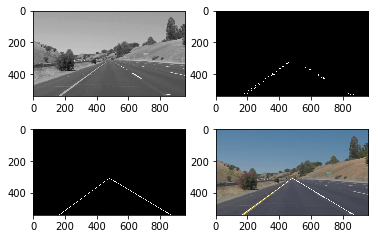

In [49]:

yellow_output = 'test_videos_output/yellow.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
yellow_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [51]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

Slope & intercept:  [[0.5757575757575758, 46.272727272727252], [0.60509554140127386, 27.547770700636988], [0.55621301775147924, 63.834319526627269], [0.061403508771929821, 619.32456140350882], [0.34061135371179041, 219.96506550218339], [0.59259259259259256, 27.296296296296305], [0.64792899408284022, -14.76035502958581], [0.32653061224489793, 208.20408163265307], [0.028571428571428571, 673.51428571428573], [0.14035087719298245, 547.70175438596493], [0.36363636363636365, 189.0], [0.48466257668711654, 129.36196319018407], [0.64864864864864868, -14.081081081081095], [0.06363636363636363, 616.56363636363642], [0.55172413793103448, 67.655172413793139], [0.28813559322033899, 240.9830508474576]]
Slope:  0.392218699115 Intercept:  228.023953071
Slope & intercept:  [[-0.72628726287262868, 890.53929539295393], [-0.6718146718146718, 855.96911196911196], [-0.070287539936102233, 461.96805111821084], [-0.2620689655172414, 593.97931034482758], [-0.067073170731707321, 463.0], [-0.25409836065573771, 590

  0%|          | 0/251 [00:00<?, ?it/s]

Slope & intercept:  [[0.5757575757575758, 46.272727272727252], [0.60509554140127386, 27.547770700636988], [0.55621301775147924, 63.834319526627269], [0.061403508771929821, 619.32456140350882], [0.34061135371179041, 219.96506550218339], [0.59259259259259256, 27.296296296296305], [0.64792899408284022, -14.76035502958581], [0.32653061224489793, 208.20408163265307], [0.028571428571428571, 673.51428571428573], [0.14035087719298245, 547.70175438596493], [0.36363636363636365, 189.0], [0.48466257668711654, 129.36196319018407], [0.64864864864864868, -14.081081081081095], [0.06363636363636363, 616.56363636363642], [0.55172413793103448, 67.655172413793139], [0.28813559322033899, 240.9830508474576]]
Slope:  0.392218699115 Intercept:  228.023953071
Slope & intercept:  [[-0.72628726287262868, 890.53929539295393], [-0.6718146718146718, 855.96911196911196], [-0.070287539936102233, 461.96805111821084], [-0.2620689655172414, 593.97931034482758], [-0.067073170731707321, 463.0], [-0.25409836065573771, 590

  0%|          | 1/251 [00:00<00:49,  5.05it/s]

(720, 1280, 3)
Slope & intercept:  [[0.015384615384615385, 656.70769230769235], [0.62121212121212122, 11.121212121212125], [0.59813084112149528, 20.644859813084167], [0.63855421686746983, -7.4578313253011856], [0.5950413223140496, 26.404958677685954], [0.625, 5.25], [0.62371134020618557, 3.3298969072164937], [0.54347826086956519, 73.130434782608688], [0.61363636363636365, 6.9318181818181301], [0.62244897959183676, 5.5204081632653015], [0.44252873563218392, 150.79885057471265], [0.21917808219178081, 274.98630136986299], [0.59649122807017541, 35.771929824561425], [0.8125, -137.125], [0.50340136054421769, 115.30612244897958], [0.061946902654867256, 617.7610619469026], [0.49090909090909091, 132.23636363636365], [0.49494949494949497, 128.3434343434343], [0.21568627450980393, 274.49019607843138]]
Slope:  0.473427179481 Intercept:  140.626539436
Slope & intercept:  [[-0.67338709677419351, 856.36693548387098], [-0.69945355191256831, 878.74863387978144], [-0.068047337278106509, 462.659763313609

  1%|          | 2/251 [00:00<00:50,  4.91it/s]


Slope & intercept:  [[0.57894736842105265, 43.10526315789474], [0.59649122807017541, 23.035087719298303], [0.032051282051282048, 671.84615384615381], [0.59909909909909909, 21.779279279279308], [0.21686746987951808, 273.91566265060243], [0.63636363636363635, -5.5454545454545041], [0.061403508771929821, 618.46491228070181], [0.5761316872427984, 42.646090534979407], [0.64864864864864868, -15.540540540540576], [0.14141414141414141, 573.59595959595958], [0.038461538461538464, 673.76923076923072], [0.625, 4.125], [0.022727272727272728, 355.40909090909093], [0.60256410256410253, 26.807692307692321], [0.59649122807017541, 35.368421052631561]]
Slope:  0.398177480786 Intercept:  222.852123268
Slope & intercept:  [[-0.67226890756302526, 856.42857142857144], [-0.72602739726027399, 889.64383561643831], [-0.26250000000000001, 593.5625], [-0.24890829694323144, 588.94323144104806], [-0.070063694267515922, 460.19108280254778], [-0.069565217391304349, 463.53913043478263], [-0.051671732522796353, 699.33

  1%|          | 3/251 [00:00<00:49,  5.03it/s]


Slope & intercept:  [[0.033333333333333333, 642.39999999999998], [0.72499999999999998, -71.0], [0.2153846153846154, 275.32307692307688], [0.67164179104477617, -32.70149253731347], [0.3559322033898305, 213.93220338983051], [0.42076502732240439, 162.81967213114754], [0.10396039603960396, 607.64851485148517], [0.62151394422310757, 4.0956175298804851], [0.014598540145985401, 661.77372262773724], [0.30769230769230771, 220.38461538461539], [0.624, 3.1360000000000241]]
Slope:  0.37216565078 Intercept:  244.346539118
Slope & intercept:  [[-0.6730038022813688, 858.63498098859316], [-0.2673913043478261, 595.88478260869567], [-0.071428571428571425, 461.42857142857144], [-0.70588235294117652, 883.35294117647061], [-0.70491803278688525, 880.60655737704917], [-0.031446540880503145, 693.54716981132071], [-0.26996197718631176, 600.61216730038018], [-0.069696969696969702, 463.93030303030304], [-0.62608695652173918, 838.22608695652184], [-0.65051903114186849, 847.59515570934252], [-0.64819277108433737,

  2%|▏         | 4/251 [00:00<00:50,  4.88it/s]

(720, 1280, 3)
Slope & intercept:  [[0.67521367521367526, -36.444444444444457], [0.061946902654867256, 618.07964601769913], [0.72388059701492535, -70.067164179104452], [0.016393442622950821, 678.93442622950818], [0.14136125654450263, 573.22513089005236], [0.092307692307692313, 616.12307692307695], [0.25, 261.75], [0.57718120805369133, 42.261744966442905], [0.32380952380952382, 210.50476190476189], [0.34188034188034189, 202.84615384615384], [0.57777777777777772, 47.466666666666697], [0.36206896551724138, 192.13793103448276], [0.625, 3.5], [0.068181818181818177, 336.63636363636363]]
Slope:  0.316394046505 Intercept:  288.232419821
Slope & intercept:  [[-0.69870129870129871, 879.93766233766235], [-0.67346938775510201, 858.75510204081638], [-0.26839826839826841, 596.82683982683989], [-0.071216617210682495, 462.28783382789317], [-0.068965517241379309, 464.27586206896552], [-0.26989619377162632, 600.59861591695505], [-0.67317073170731712, 860.31219512195116], [-0.045454545454545456, 696.0909

  2%|▏         | 5/251 [00:01<00:56,  4.36it/s]

(720, 1280, 3)
Slope & intercept:  [[0.65030674846625769, -18.306748466257659], [0.5636363636363636, 55.236363636363649], [0.62561576354679804, 3.9852216748768114], [0.021739130434782608, 424.26086956521738], [0.060606060606060608, 618.969696969697], [0.59259259259259256, 32.407407407407447], [0.64814814814814814, -15.851851851851848], [0.171875, 303.875], [0.36254980079681276, 191.51394422310756]]
Slope:  0.410785512025 Intercept:  177.343322573
Slope & intercept:  [[-0.69895287958115182, 882.80366492146595], [-0.068965517241379309, 465.20689655172413], [-0.67331670822942646, 860.73566084788035], [-0.26760563380281688, 598.26760563380276], [-0.016483516483516484, 679.47252747252742], [-0.068656716417910449, 461.51940298507463], [-0.69791666666666663, 881.41666666666663], [-0.034682080924855488, 694.97687861271675], [-0.28653295128939826, 609.26361031518627], [-0.27450980392156865, 603.72549019607845], [-0.24852071005917159, 586.50887573964496], [-0.30198019801980197, 612.7623762376238

  2%|▏         | 6/251 [00:01<00:58,  4.22it/s]

(720, 1280, 3)


  3%|▎         | 7/251 [00:01<00:52,  4.63it/s]

Slope & intercept:  [[0.625, 2.0], [0.64953271028037385, -11.504672897196258], [0.046783625730994149, 631.41520467836256], [0.10062893081761007, 608.47798742138366], [0.048484848484848485, 629.16363636363633], [0.12, 593.12], [0.24107142857142858, 267.91071428571428], [0.60185185185185186, 22.416666666666686], [0.34210526315789475, 201.65789473684211], [0.025974025974025976, 677.98701298701303]]
Slope:  0.239099997177 Intercept:  403.794346349
Slope & intercept:  [[-0.67241379310344829, 861.13793103448279], [-0.69973890339425593, 883.72584856396873], [-0.069364161849710976, 464.40462427745666], [-0.04878048780487805, 696.92682926829264], [-0.071641791044776124, 462.42686567164179], [-0.27064220183486237, 602.85779816513764], [-0.2680115273775216, 597.88760806916423], [-0.64925373134328357, 853.35074626865674], [-0.031847133757961783, 693.70700636942672], [-0.69724770642201839, 869.07339449541291], [-0.25268817204301075, 594.6559139784946], [-0.25225225225225223, 589.24324324324323], [-

  3%|▎         | 8/251 [00:01<00:47,  5.09it/s]

(720, 1280, 3)
Slope & intercept:  [[0.035714285714285712, 641.85714285714289], [0.60215053763440862, 20.043010752688133], [0.016666666666666666, 655.61666666666667], [0.67346938775510201, -32.979591836734699], [0.32110091743119268, 213.77064220183485], [0.60073260073260071, 22.934065934065927], [0.014285714285714285, 424.68571428571431], [0.34710743801652894, 200.0], [0.32743362831858408, 211.57522123893804], [0.30630630630630629, 221.76576576576576], [0.67592592592592593, -37.277777777777771]]
Slope:  0.356444855344 Intercept:  231.09007819
Slope & intercept:  [[-0.72554347826086951, 895.85869565217388], [-0.67901234567901236, 865.61728395061732], [-0.069486404833836862, 460.79154078549851], [-0.27333333333333332, 599.60666666666668], [-0.27091633466135456, 597.24302788844625], [-0.67713004484304928, 862.90582959641256], [-0.28755364806866951, 607.93562231759654], [-0.032051282051282048, 693.62820512820508], [-0.069364161849710976, 464.40462427745666], [-0.28665207877461707, 608.7702

  4%|▍         | 10/251 [00:02<00:58,  4.11it/s]

Slope & intercept:  [[0.64620938628158842, -9.574007220216572], [0.03125, 643.5625], [0.013513513513513514, 662.72972972972968], [0.59937888198757761, 22.583850931677034], [0.67391304347826086, -35.934782608695627], [0.67032967032967028, -33.087912087912059], [0.59999999999999998, 23.199999999999989], [0.20408163265306123, 285.69387755102042], [0.24489795918367346, 263.61224489795916], [0.67088607594936711, -32.177215189873436], [0.21348314606741572, 280.0561797752809]]
Slope:  0.415267573586 Intercept:  188.242224162
Slope & intercept:  [[-0.6972111553784861, 873.64143426294822], [-0.75358166189111753, 910.07449856733524], [-0.2832618025751073, 603.49785407725324], [-0.067524115755627015, 463.81028938906752], [-0.28758169934640521, 609.50326797385617], [-0.068852459016393447, 460.79016393442623], [-0.69444444444444442, 874.08333333333326], [-0.035714285714285712, 694.21428571428567], [-0.2904761904761905, 609.35714285714289], [-0.58227848101265822, 814.20253164556959], [-0.03164556962

  4%|▍         | 11/251 [00:02<00:55,  4.32it/s]

Slope & intercept:  [[0.62631578947368416, 8.0789473684210975], [0.57684210526315793, 43.934736842105224], [0.061403508771929821, 618.28070175438597], [0.59999999999999998, 21.400000000000034], [0.59957627118644063, 23.661016949152554], [0.10084033613445378, 610.53781512605042], [0.33050847457627119, 209.37288135593221], [0.30555555555555558, 222.30555555555554], [0.26923076923076922, 256.53846153846155], [0.57796257796257799, 41.553014553014521], [0.34108527131782945, 208.34883720930233], [0.30434782608695654, 224.86956521739128]]
Slope:  0.391139040463 Intercept:  207.406794456
Slope & intercept:  [[-0.69946808510638303, 875.25531914893622], [-0.069182389937106917, 464.55345911949684], [-0.26736842105263159, 600.7410526315789], [-0.72807017543859653, 898.15789473684208], [-0.051446945337620578, 451.08038585209005], [-0.72932330827067671, 900.1503759398496], [-0.065727699530516437, 705.04694835680755], [-0.29896907216494845, 613.28865979381442], [-0.24822695035460993, 586.326241134751

  5%|▌         | 13/251 [00:02<00:49,  4.84it/s]

Intercept:  232.440934035
Slope & intercept:  [[-0.7265625, 897.71875], [-0.70026525198938994, 876.87267904509281], [-0.071895424836601302, 462.50980392156862], [-0.28521126760563381, 604.32746478873241], [-0.068750000000000006, 464.20625000000001], [-0.30405405405405406, 614.46621621621625], [-0.05232558139534884, 698.76162790697674], [-0.70053475935828879, 875.24598930481284], [-0.73684210526315785, 903.52631578947364], [-0.30232558139534882, 615.09302325581393], [-0.032051282051282048, 687.71153846153845], [-0.51000000000000001, 767.75999999999999], [-0.071090047393364927, 464.78672985781992], [-0.032467532467532464, 693.79220779220782], [-0.26000000000000001, 608.24000000000001], [-0.17525773195876287, 544.31958762886597], [-0.074829931972789115, 459.36734693877554], [-0.051194539249146756, 450.4061433447099], [-0.1348314606741573, 821.48314606741576], [-0.72093023255813948, 897.39534883720933], [-0.40384615384615385, 704.25], [-0.34375, 620.65625], [-0.14942528735632185, 441.66666

  6%|▌         | 14/251 [00:02<00:46,  5.05it/s]

Slope & intercept:  [[0.5752212389380531, 43.557522123893818], [0.62135922330097082, 8.9029126213592917], [0.5770925110132159, 38.625550660792896], [0.01935483870967742, 411.7032258064516], [0.64739884393063585, -14.1098265895954], [0.018181818181818181, 654.43636363636369], [0.60365853658536583, 23.128048780487802], [0.63636363636363635, -7.7272727272727479], [0.39344262295081966, 182.47540983606558], [0.69918699186991873, -56.317073170731703], [0.44221105527638194, 180.15577889447235]]
Slope:  0.475770119738 Intercept:  133.166421807
Slope & intercept:  [[-0.74838709677419357, 906.27096774193546], [-0.69841269841269837, 873.57142857142856], [-0.054237288135593219, 452.4949152542373], [-0.70026525198938994, 876.17241379310349], [-0.2857142857142857, 603.14285714285711], [-0.29310344827586204, 609.86206896551721], [-0.05089820359281437, 454.20359281437123], [-0.70714285714285718, 885.17857142857144], [-0.3034188034188034, 614.18803418803418], [-0.10231023102310231, 474.55775577557756],

  6%|▌         | 15/251 [00:03<00:59,  3.95it/s]

(720, 1280, 3)
Slope & intercept:  [[0.033333333333333333, 641.76666666666665], [0.57553956834532372, 41.316546762589951], [0.69747899159663862, -48.983193277310875], [0.25203252032520324, 258.79674796747969], [0.67307692307692313, -34.634615384615415], [0.13636363636363635, 577.90909090909088], [0.18571428571428572, 296.31428571428569], [0.4020100502512563, 199.15577889447235]]
Slope:  0.369443663626 Intercept:  241.455163532
Slope & intercept:  [[-0.75147928994082835, 908.18934911242604], [-0.69774919614147912, 874.09003215434086], [-0.03553299492385787, 693.7817258883249], [-0.051546391752577317, 449.83505154639175], [-0.050000000000000003, 452.55000000000001], [-0.2837370242214533, 601.88235294117646], [-0.28647214854111408, 607.15384615384619], [-0.060606060606060608, 459.87878787878788], [-0.60326086956521741, 826.18478260869574], [-0.034722222222222224, 689.66666666666663], [-0.57931034482758625, 809.45517241379321], [-0.014084507042253521, 677.28169014084506], [-0.1954887218045

  6%|▋         | 16/251 [00:03<01:06,  3.56it/s]

(720, 1280, 3)
Slope & intercept:  [[0.1875, 296.1875], [0.55665024630541871, 58.433497536945822], [0.074999999999999997, 605.47500000000002], [0.59932659932659937, 23.023569023568996], [0.57638888888888884, 46.569444444444457], [0.23134328358208955, 279.73880597014926], [0.3188405797101449, 219.56521739130437], [0.10344827586206896, 604.51724137931035], [0.12437810945273632, 588.51243781094524], [0.34931506849315069, 201.9041095890411]]
Slope:  0.312219105162 Intercept:  292.392682315
Slope & intercept:  [[-0.75211267605633803, 907.37746478873237], [-0.70292887029288698, 875.25104602510464], [-0.28508771929824561, 604.87280701754389], [-0.26779661016949152, 595.51864406779657], [-0.070588235294117646, 462.94117647058823], [-0.067114093959731544, 458.14765100671138], [-0.036529680365296802, 690.10958904109589], [-0.6767676767676768, 867.40404040404042], [-0.73750000000000004, 903.67499999999995], [-0.070588235294117646, 462.08235294117645], [-0.020618556701030927, 688.24742268041234], 

  7%|▋         | 18/251 [00:04<00:59,  3.94it/s]

(720, 1280, 3)
Slope & intercept:  [[0.57805907172995785, 41.586497890295334], [0.061403508771929821, 619.63157894736844], [0.56521739130434778, 57.173913043478308], [0.20792079207920791, 284.32673267326732], [0.012738853503184714, 678.68152866242042], [0.28859060402684567, 242.6174496644295], [0.061403508771929821, 618.15789473684208], [0.15686274509803921, 556.37254901960785], [0.19780219780219779, 292.69230769230768], [0.57471264367816088, 127.06896551724139], [0.578125, 47.234375], [0.36333333333333334, 198.31666666666666], [0.72277227722772275, -71.267326732673268], [0.59090909090909094, 36.272727272727252]]
Slope:  0.325929133924 Intercept:  292.317937445
Slope & intercept:  [[-0.75290697674418605, 909.11918604651169], [-0.72272727272727277, 884.25454545454545], [-0.069767441860465115, 462.67441860465118], [-0.2734375, 598.1484375], [-0.28508771929824561, 605.73245614035091], [-0.051369863013698627, 450.26027397260276], [-0.015957446808510637, 687.23936170212767], [-0.28125, 600.

  8%|▊         | 19/251 [00:04<00:51,  4.47it/s]

Slope & intercept:  [[0.59615384615384615, 33.865384615384642], [0.60301507537688437, 20.613065326633205], [0.5791505791505791, 42.088803088803104], [0.034090909090909088, 641.72727272727275], [0.3263888888888889, 216.40972222222223], [0.60377358490566035, 26.792452830188722], [0.23134328358208955, 278.12686567164178], [0.10328638497652583, 609.40845070422529], [0.24822695035460993, 271.03546099290782], [0.64893617021276595, -16.489361702127667], [0.15238095238095239, 560.35238095238094], [0.28654970760233917, 254.94736842105263], [0.21052631578947367, 285.63157894736844], [0.22689075630252101, 279.0924369747899], [0.03669724770642202, 640.37614678899081], [0.24475524475524477, 271.79720279720277], [0.44444444444444442, 185.88888888888889], [0.017064846416382253, 411.34470989761093]]
Slope:  0.290867001052 Intercept:  295.852834815
Slope & intercept:  [[-0.72432432432432436, 883.91351351351352], [-0.75297619047619047, 909.13988095238096], [-0.06725146198830409, 461.85672514619881], [-0

  8%|▊         | 20/251 [00:04<00:50,  4.58it/s]

[[-0.7535410764872521, 909.30878186968835], [-0.72192513368983957, 883.25133689839572], [-0.26836158192090398, 596.2655367231639], [-0.27160493827160492, 601.32098765432102], [-0.070796460176991149, 463.93805309734512], [-0.069841269841269843, 460.90793650793648], [-0.67632850241545894, 862.70048309178742], [-0.018633540372670808, 688.91304347826087], [-0.26950354609929078, 599.56737588652481], [-0.068852459016393447, 459.27213114754096], [-0.75193798449612403, 909.50387596899225], [-0.32758620689655171, 609.77586206896558], [-0.44859813084112149, 730.3925233644859], [-0.048275862068965517, 696.66206896551728], [-0.33846153846153848, 615.20000000000005], [-0.77887788778877887, 919.59735973597367], [-0.34482758620689657, 662.17241379310349], [-0.068965517241379309, 456.44827586206895], [-0.33333333333333331, 616.0], [-0.22580645161290322, 586.9354838709678], [-0.085365853658536592, 713.18292682926835], [-0.27884615384615385, 599.72115384615381], [-0.72535211267605637, 902.53521126760563

  8%|▊         | 21/251 [00:04<00:50,  4.58it/s]

(720, 1280, 3)
Slope & intercept:  [[0.57668711656441718, 44.453987730061328], [0.010526315789473684, 665.34736842105258], [0.625, 9.125], [0.6966292134831461, -50.044943820224717], [0.082191780821917804, 598.71232876712327], [0.30344827586206896, 231.39310344827587], [0.36666666666666664, 199.06666666666669], [0.22695035460992907, 281.04964539007096], [0.19, 295.27999999999997], [0.28654970760233917, 255.37426900584796], [0.2878787878787879, 233.87878787878788], [0.36206896551724138, 204.44827586206895]]
Slope:  0.301633451938 Intercept:  274.375403015
Slope & intercept:  [[-0.69999999999999996, 874.79999999999995], [-0.72769953051643188, 895.09859154929575], [-0.069364161849710976, 463.47398843930637], [-0.28602620087336245, 605.20524017467244], [-0.071428571428571425, 459.57142857142856], [-0.28143712574850299, 600.81437125748505], [-0.018292682926829267, 687.82317073170736], [-0.72413793103448276, 896.13793103448279], [-0.78171091445427732, 919.07669616519172], [-0.2820512820512820

  9%|▉         | 22/251 [00:04<00:49,  4.62it/s]

(720, 1280, 3)
Slope & intercept:  [[0.60227272727272729, 32.488636363636374], [0.59999999999999998, 32.199999999999989], [0.59999999999999998, 33.800000000000068], [0.60079840319361277, 23.532934131736511], [0.57727272727272727, 52.968181818181847], [0.57581573896353166, 45.057581573896357], [0.12440191387559808, 353.55502392344499], [0.6333333333333333, -6.3333333333333144], [0.18803418803418803, 298.94017094017096], [0.5544554455445545, 67.871287128712822], [0.55092592592592593, 69.666666666666686], [0.34591194968553457, 209.0251572327044], [1.5272727272727273, -499.4909090909091], [0.32575757575757575, 220.52272727272728], [0.62666666666666671, 3.3333333333332575], [0.44311377245508982, 188.76646706586826], [0.15306122448979592, 559.5]]
Slope:  0.468863849529 Intercept:  136.555927132
Slope & intercept:  [[-0.75423728813559321, 909.51694915254234], [-0.69895287958115182, 874.11518324607323], [-0.069767441860465115, 463.60465116279067], [-0.26771653543307089, 600.48031496062993], [-

 10%|▉         | 24/251 [00:05<00:54,  4.17it/s]


Slope & intercept:  [[0.57684630738522957, 45.660678642714572], [0.014423076923076924, 657.53846153846155], [0.61194029850746268, 21.835820895522374], [0.647887323943662, -12.591549295774655], [0.64893617021276595, -12.25531914893611], [0.5490196078431373, 78.294117647058783], [0.046783625730994149, 631.27485380116957], [0.52631578947368418, 98.263157894736878], [0.67441860465116277, -33.883720930232585], [0.28947368421052633, 236.57894736842104], [0.30769230769230771, 231.76923076923077], [0.57948717948717954, 41.876923076923049], [0.67391304347826086, -32.847826086956502], [0.60122699386503065, 96.257668711656436], [0.19090909090909092, 297.89090909090908], [0.65193370165745856, -13.718232044198885]]
Slope:  0.474450425373 Intercept:  145.746507621
Slope & intercept:  [[-0.69895287958115182, 874.11518324607323], [-0.7535410764872521, 908.55524079320116], [-0.068249258160237386, 462.65875370919883], [-0.29411764705882354, 608.41176470588232], [-0.27329192546583853, 598.84472049689441

 10%|▉         | 25/251 [00:05<00:53,  4.24it/s]

Slope & intercept:  [[0.62295081967213117, 11.18032786885243], [0.59999999999999998, 23.200000000000045], [0.026666666666666668, 649.91999999999996], [0.55555555555555558, 67.777777777777715], [0.27027027027027029, 252.59459459459458], [0.3411764705882353, 212.8235294117647], [0.2608695652173913, 248.43478260869566], [0.64668769716088326, -9.5331230283911736], [0.19008264462809918, 297.51239669421489], [0.65000000000000002, -18.200000000000045], [0.08771929824561403, 622.50877192982455], [0.51030927835051543, 93.448453608247462], [0.24539877300613497, 275.10429447852761], [0.066666666666666666, 612.79999999999995], [0.08461538461538462, 622.53076923076924], [0.55223880597014929, 72.044776119402968], [0.67307692307692313, -34.730769230769283], [0.59893048128342241, 24.026737967914471], [0.57692307692307687, 46.153846153846189], [0.027777777777777776, 422.69444444444446]]
Slope:  0.379395807784 Intercept:  224.614580531
Slope & intercept:  [[-0.69895287958115182, 872.71727748691103], [-0

 11%|█         | 27/251 [00:06<00:45,  4.91it/s]

(720, 1280, 3)
Slope & intercept:  [[0.013986013986013986, 661.30069930069931], [0.62589928057553956, 8.9784172661870798], [0.64676616915422891, -14.452736318407972], [0.57928802588996764, 42.336569579288039], [0.076923076923076927, 604.30769230769226], [0.62605042016806722, 4.2226890756302282], [0.52000000000000002, 106.15999999999997], [0.62295081967213117, 8.393442622950829], [0.57746478873239437, 57.605633802816897], [0.546875, 96.828125], [0.21052631578947367, 289.63157894736844], [0.54794520547945202, 86.479452054794535], [0.23376623376623376, 279.4545454545455], [0.26911314984709478, 264.00917431192659], [0.092783505154639179, 614.89690721649481], [0.076923076923076927, 603.53846153846155], [0.60204081632653061, 30.663265306122469], [0.48677248677248675, 154.63492063492063], [0.64824120603015079, -14.7286432160804]]
Slope:  0.421279767957 Intercept:  204.434747099
Slope & intercept:  [[-0.7528089887640449, 906.0786516853932], [-0.053691275167785234, 455.24161073825502], [-0.7224

 11%|█         | 28/251 [00:06<00:43,  5.18it/s]

Slope & intercept:  [[0.061946902654867256, 616.9646017699115], [0.59999999999999998, 24.199999999999989], [0.21269841269841269, 289.06984126984128], [0.60483870967741937, 26.177419354838719], [0.064220183486238536, 615.69724770642199], [0.54455445544554459, 71.415841584158386], [0.64864864864864868, -9.4054054054054177], [0.21428571428571427, 285.07142857142856], [0.082089552238805971, 373.35820895522386], [0.52777777777777779, 85.555555555555543], [0.5714285714285714, 53.0], [0.78095238095238095, -113.54285714285709]]
Slope:  0.409453442441 Intercept:  193.130156852
Slope & intercept:  [[-0.75423728813559321, 907.25423728813553], [-0.72330097087378642, 881.46116504854376], [-0.052023121387283239, 454.11560693641616], [-0.28691983122362869, 601.96624472573842], [-0.049535603715170282, 449.89164086687305], [-0.048611111111111112, 696.85416666666663], [-0.036842105263157891, 694.17894736842106], [-0.55487804878048785, 796.8780487804878], [-0.70305676855895194, 883.61135371179034], [-0.2

 12%|█▏        | 30/251 [00:06<00:38,  5.69it/s]

(720, 1280, 3)
Slope & intercept:  [[0.60223048327137552, 23.52416356877319], [0.046783625730994149, 632.0233918128655], [0.03896103896103896, 674.67532467532465], [0.62376237623762376, 12.207920792079221], [0.48101265822784811, 127.34177215189874], [0.60869565217391308, 23.347826086956502], [0.053097345132743362, 659.29203539823004], [0.32402234636871508, 224.57541899441341], [0.0625, 381.625], [0.310126582278481, 228.22784810126583], [0.041095890410958902, 671.50684931506851], [0.32620320855614976, 226.65240641711227], [0.0546875, 392.9921875], [0.57692307692307687, 51.96153846153851], [0.57894736842105265, 48.421052631578959], [0.510752688172043, 77.258064516129025], [0.26666666666666666, 268.33333333333337], [0.38164251207729466, 238.54106280193238], [0.51006711409395977, 81.221476510067077]]
Slope:  0.336746217563 Intercept:  265.459403846
Slope & intercept:  [[-0.28695652173913044, 605.39130434782612], [-0.69565217391304346, 869.60869565217388], [-0.72049689440993792, 878.9006211

 12%|█▏        | 31/251 [00:06<00:38,  5.73it/s]

Slope & intercept:  [[0.59861591695501726, 27.387543252595208], [0.061403508771929821, 619.14035087719299], [0.57928802588996764, 42.398058252427177], [0.67045454545454541, -25.545454545454504], [0.21518987341772153, 288.27848101265823], [0.64835164835164838, -15.582417582417577], [0.18965517241379309, 300.60344827586209], [0.23076923076923078, 283.69230769230768], [0.64739884393063585, -10.820809248554895], [1.8, -626.20000000000005], [0.57761732851985559, 42.285198555956697]]
Slope:  0.441874409447 Intercept:  155.183670654
Slope & intercept:  [[-0.75433526011560692, 904.51156069364163], [-0.69402985074626866, 868.81343283582089], [-0.051987767584097858, 452.25993883792052], [-0.28444444444444444, 600.88], [-0.72142857142857142, 878.82142857142856], [-0.049450549450549448, 698.26373626373629], [-0.72180451127819545, 879.79699248120301], [-0.052795031055900624, 455.74223602484471], [-0.578125, 811.765625], [-0.23076923076923078, 577.15384615384619], [-0.017341040462427744, 688.5895953

 13%|█▎        | 32/251 [00:06<00:38,  5.68it/s]

(720, 1280, 3)
Slope & intercept:  [[0.032520325203252036, 642.41463414634143], [0.62333333333333329, 5.7800000000000296], [0.69950738916256161, -52.16748768472911], [0.015228426395939087, 418.62944162436548], [0.62318840579710144, 11.724637681159436], [0.61194029850746268, 23.970149253731392], [0.58156028368794321, 42.546099290780205], [0.5280898876404494, 92.573033707865193], [0.57794676806083645, 42.733840304182536], [0.11627906976744186, 354.62790697674416], [0.081081081081081086, 371.05405405405406], [0.052419354838709679, 400.24596774193549], [0.15625, 325.90625], [0.60240963855421692, 31.012048192771033]]
Slope:  0.378696733002 Intercept:  193.646469664
Slope & intercept:  [[-0.69834710743801653, 869.06198347107443], [-0.70124481327800825, 880.40663900414938], [-0.2670299727520436, 597.30790190735695], [-0.72535211267605637, 891.65492957746483], [-0.26815642458100558, 594.35195530726253], [-0.069486404833836862, 462.58308157099697], [-0.75366568914956011, 902.5777126099706], [-0

 14%|█▎        | 34/251 [00:07<00:39,  5.50it/s]

Slope & intercept:  [[0.64939024390243905, -9.6737804878048905], [0.57999999999999996, 43.819999999999993], [0.60148514851485146, 25.371287128712879], [0.031746031746031744, 642.57142857142856], [0.62538699690402477, 3.0030959752322133], [0.23076923076923078, 285.46153846153845], [0.6257309941520468, 12.508771929824547], [0.20903954802259886, 294.70056497175142], [0.57407407407407407, 62.703703703703695], [0.031578947368421054, 643.2421052631579], [0.55555555555555558, 67.555555555555543], [0.6026200873362445, 30.991266375545877], [0.13824884792626729, 342.59907834101381], [0.62345679012345678, 6.1049382716049649], [0.15639810426540285, 329.01895734597156], [1.5, -442.5]]
Slope:  0.415698706711 Intercept:  185.33190076
Slope & intercept:  [[-0.75433526011560692, 901.49421965317924], [-0.69907407407407407, 868.15740740740739], [-0.24925816023738873, 586.75370919881311], [-0.032967032967032968, 693.35164835164835], [-0.27127659574468083, 598.95212765957444], [-0.052631578947368418, 452.4

 14%|█▍        | 35/251 [00:07<00:53,  4.07it/s]

(720, 1280, 3)
Slope & intercept:  [[0.57751277683134583, 48.243611584327084], [0.60119047619047616, 36.529761904761926], [0.57919621749408978, 44.981087470449211], [0.59259259259259256, 43.629629629629676], [0.061403508771929821, 619.20175438596493], [0.26691729323308272, 271.72932330827064], [0.26903553299492383, 263.60406091370561], [0.23152709359605911, 287.44827586206895], [0.6028368794326241, 21.432624113475185], [0.56097560975609762, 62.292682926829229], [0.57499999999999996, 44.650000000000034], [0.050955414012738856, 653.52866242038215], [0.56451612903225812, 62.935483870967687], [0.034883720930232558, 670.68604651162786], [0.12217194570135746, 591.33031674208144], [0.34375, 219.625], [1.7301587301587302, -559.71428571428578], [0.57528957528957525, 43.150579150579176], [0.03125, 677.875], [0.48484848484848486, 116.72727272727275], [0.58015267175572516, 55.259541984732834], [0.056603773584905662, 649.75471698113211]]
Slope:  0.369648080764 Intercept:  261.172163452
Slope & inte

 14%|█▍        | 36/251 [00:07<00:56,  3.78it/s]

(720, 1280, 3)
Slope & intercept:  [[0.57534246575342463, 50.60273972602738], [0.59868421052631582, 37.671052631578959], [0.031578947368421054, 644.06315789473683], [0.6029411764705882, 34.264705882352928], [0.57342657342657344, 51.111888111888106], [0.036231884057971016, 676.85507246376812], [0.033707865168539325, 408.48314606741576], [0.57763975155279501, 42.248447204968954], [0.57499999999999996, 63.950000000000045], [0.21465968586387435, 293.44502617801049], [0.052631578947368418, 626.1052631578948], [0.140625, 341.890625], [0.55737704918032782, 61.672131147540995], [0.57499999999999996, 62.800000000000011], [0.4642857142857143, 134.5], [0.65116279069767447, -14.883720930232585], [0.57894736842105265, 43.157894736842081], [0.034722222222222224, 679.31944444444446], [0.83823529411764708, -152.92647058823536], [0.28440366972477066, 264.55045871559633], [0.57746478873239437, 45.225352112676035], [0.52542372881355937, 88.322033898305051], [0.24878048780487805, 279.13658536585365], [0.1

 15%|█▍        | 37/251 [00:08<00:55,  3.86it/s]

(720, 1280, 3)
Slope & intercept:  [[0.59909909909909909, 24.567567567567551], [0.57848837209302328, 46.441860465116292], [0.57723577235772361, 59.796747967479632], [0.59999999999999998, 36.800000000000011], [0.55555555555555558, 83.555555555555543], [0.55319148936170215, 73.234042553191443], [0.21134020618556701, 294.62371134020617], [0.042857142857142858, 670.29999999999995], [0.061403508771929821, 618.58771929824559], [0.52941176470588236, 108.76470588235293], [0.6428571428571429, -6.0714285714286689], [0.53465346534653468, 94.297029702970235], [0.25, 281.0], [0.67346938775510201, -35.265306122448976], [0.55523255813953487, 62.941860465116292], [0.24878048780487805, 277.64390243902437], [0.07407407407407407, 635.51851851851848], [0.50943396226415094, 117.66037735849056], [0.063063063063063057, 616.27927927927931], [0.6728395061728395, -33.876543209876559], [0.064935064935064929, 380.84415584415586], [0.052631578947368418, 657.57894736842104], [0.052631578947368418, 658.8947368421053

 15%|█▌        | 38/251 [00:08<00:53,  4.00it/s]

(720, 1280, 3)
Slope & intercept:  [[0.032467532467532464, 643.62337662337666], [0.034013605442176874, 409.08843537414964], [0.57627118644067798, 48.474576271186436], [0.60162601626016265, 23.57723577235771], [0.029411764705882353, 647.61764705882354], [0.48739495798319327, 118.73109243697479], [0.13775510204081631, 341.95408163265307], [0.57742782152230976, 45.905511811023587], [0.031914893617021274, 681.97872340425533], [0.57599999999999996, 63.296000000000049], [0.55223880597014929, 73.626865671641781], [0.5368421052631579, 95.199999999999989], [0.51320754716981132, 91.158490566037756], [0.65217391304347827, -11.52173913043481], [0.012987012987012988, 660.25974025974028], [0.054054054054054057, 655.29729729729729], [0.25, 275.25], [0.61538461538461542, 19.230769230769226], [0.57861635220125784, 50.955974842767318], [0.90322580645161288, -107.0]]
Slope:  0.360515120345 Intercept:  259.668635743
Slope & intercept:  [[-0.26732673267326734, 598.06930693069307], [-0.72602739726027399, 88

 16%|█▌        | 40/251 [00:08<00:48,  4.37it/s]

(720, 1280, 3)
Slope & intercept:  [[0.017142857142857144, 659.53714285714284], [0.57480314960629919, 50.102362204724443], [0.59815950920245398, 25.263803680981596], [0.050000000000000003, 629.04999999999995], [0.57857142857142863, 43.449999999999989], [0.19487179487179487, 306.30256410256413], [0.51162790697674421, 86.395348837209269], [1.2777777777777777, -299.77777777777771], [0.51515151515151514, 110.21212121212125], [0.55704697986577179, 58.919463087248346], [0.60526315789473684, 33.578947368421041], [0.035714285714285712, 670.60714285714289], [0.26785714285714285, 275.10714285714289], [0.08771929824561403, 346.91228070175441]]
Slope:  0.353379155854 Intercept:  253.495255367
Slope & intercept:  [[-0.72527472527472525, 889.97802197802196], [-0.26681127982646419, 598.22993492407807], [-0.67219917012448138, 855.73858921161832], [-0.053254437869822487, 452.73372781065086], [-0.05459770114942529, 457.7442528735632], [-0.26271186440677968, 592.84745762711862], [-0.05232558139534884, 69

 16%|█▋        | 41/251 [00:09<00:42,  4.90it/s]

Slope & intercept:  [[0.014285714285714285, 658.57142857142856], [0.017341040462427744, 659.35838150289021], [0.55654761904761907, 60.065476190476204], [0.088541666666666671, 371.578125], [0.57309941520467833, 53.31578947368422], [0.625, 36.375], [0.62318840579710144, 37.550724637681185], [0.036363636363636362, 676.85454545454547], [0.04790419161676647, 630.67664670658678], [0.19387755102040816, 305.79591836734693], [0.53333333333333333, 97.933333333333337], [0.50793650793650791, 106.82539682539687], [0.57668711656441718, 52.539877300613512], [0.19811320754716982, 311.57547169811323], [0.62204724409448819, 39.755905511811022], [0.21674876847290642, 296.42364532019701], [0.6216216216216216, 13.89189189189193], [0.052264808362369339, 398.09407665505228], [0.5089285714285714, 114.74107142857144], [0.55350553505535061, 57.228782287822867], [0.57831325301204817, 52.734939759036138]]
Slope:  0.368840438471 Intercept:  239.613639425
Slope & intercept:  [[-0.72527472527472525, 889.527472527472

 17%|█▋        | 42/251 [00:09<00:40,  5.11it/s]

(720, 1280, 3)
Slope & intercept:  [[0.625, 11.125], [0.57783641160949872, 43.860158311345629], [0.032786885245901641, 642.57377049180332], [0.53333333333333333, 104.26666666666665], [0.17488789237668162, 319.90582959641256], [0.57541899441340782, 56.223463687150854], [0.088669950738916259, 372.31034482758622], [0.085227272727272721, 376.70454545454544], [0.48076923076923078, 118.0], [0.55244755244755239, 81.804195804195842], [0.030534351145038167, 646.64122137404581], [0.55434782608695654, 77.010869565217376], [0.42460317460317459, 136.28571428571428], [0.64864864864864868, -14.081081081081095], [0.15555555555555556, 546.02222222222224], [0.60106382978723405, 35.090425531914889], [0.57714285714285718, 56.817142857142812], [0.55555555555555558, 79.222222222222229], [0.57763975155279501, 53.689440993788821], [0.60344827586206895, 30.482758620689651], [0.53543307086614178, 100.71653543307082], [0.625, 7.25], [0.6033519553072626, 34.994413407821241], [0.052631578947368418, 653.31578947368

 17%|█▋        | 43/251 [00:09<00:42,  4.88it/s]

(720, 1280, 3)
Slope & intercept:  [[0.57485029940119758, 45.359281437125787], [0.57446808510638303, 52.829787234042556], [0.59722222222222221, 34.263888888888914], [0.83660130718954251, -78.058823529411768], [0.10828025477707007, 360.64331210191085], [0.84027777777777779, -75.013888888888914], [0.6484375, 44.4296875], [0.83720930232558144, -80.069767441860506], [0.40465116279069768, 157.22325581395347], [0.84172661870503596, -85.129496402877692], [0.61855670103092786, 57.010309278350519], [0.085000000000000006, 375.32999999999998], [0.84057971014492749, -156.768115942029], [0.55263157894736847, 69.499999999999943], [0.40416666666666667, 171.25833333333333], [0.59999999999999998, 32.400000000000034], [0.072847682119205295, 633.83443708609275], [0.035294117647058823, 401.24705882352941], [0.70229007633587781, -8.4198473282442592], [0.52713178294573648, 100.52713178294573], [0.12105263157894737, 349.41578947368419]]
Slope:  0.515394070367 Intercept:  114.372015868
Slope & intercept:  [[-

 18%|█▊        | 44/251 [00:09<00:47,  4.34it/s]

(720, 1280, 3)
Slope & intercept:  [[0.013793103448275862, 663.44827586206895], [0.57692307692307687, 44.307692307692321], [0.60227272727272729, 30.909090909090878], [0.34399999999999997, 195.976], [0.1050228310502283, 366.59360730593608], [0.44486692015209123, 127.1406844106464], [0.62658227848101267, 55.25316455696202], [0.20000000000000001, 497.60000000000002], [0.90410958904109584, -107.45205479452051], [0.36575875486381321, 191.43579766536965], [0.48936170212765956, 104.97872340425533], [0.086538461538461536, 664.45192307692309], [0.90140845070422537, -102.07042253521126], [0.80769230769230771, -36.307692307692321], [0.44400000000000001, 124.876], [0.8660714285714286, -72.1875], [0.02, 652.96000000000004], [0.578125, 49.8125], [0.53061224489795922, 90.0], [0.57435897435897432, 69.092307692307713], [0.48823529411764705, 116.52941176470588], [0.42574257425742573, 159.51485148514851], [0.67400881057268724, -32.651982378854655], [0.84126984126984128, -83.0], [0.5770925110132159, 45.57

 18%|█▊        | 45/251 [00:09<00:49,  4.17it/s]

(720, 1280, 3)
Slope & intercept:  [[0.5771971496437055, 43.346793349168649], [0.014018691588785047, 658.81775700934577], [0.59999999999999998, 32.400000000000034], [0.46511627906976744, 144.06976744186048], [0.59948979591836737, 24.698979591836746], [0.8141025641025641, -62.884615384615358], [0.046728971962616821, 411.17757009345792], [0.59090909090909094, 41.772727272727252], [0.57360406091370564, 70.157360406091357], [0.016025641025641024, 420.19871794871796], [0.34583333333333333, 194.30833333333334], [0.4437869822485207, 152.6449704142012], [0.81081081081081086, -65.135135135135158], [0.50751879699248126, 89.943609022556359], [0.75167785234899331, -2.5234899328859228], [0.42236024844720499, 162.46583850931677], [0.57702349869451697, 46.490861618798931], [0.46728971962616822, 149.34579439252337], [0.52702702702702697, 101.95945945945948], [0.50769230769230766, 84.876923076923077], [0.53125, 94.09375], [0.48816568047337278, 112.44378698224853], [0.53353658536585369, 79.3048780487804

 19%|█▊        | 47/251 [00:10<00:45,  4.45it/s]

Slope & intercept:  [[0.57635467980295563, 45.044334975369452], [0.59798994974874375, 35.356783919598001], [0.034482758620689655, 642.0344827586207], [0.55555555555555558, 64.111111111111086], [0.4456140350877193, 134.80000000000001], [0.46745562130177515, 137.08875739644969], [0.57936507936507942, 40.293650793650784], [0.53000000000000003, 91.439999999999998], [0.57711442786069655, 50.910447761194007], [0.44654088050314467, 152.74842767295596], [0.19047619047619047, 507.14285714285717], [0.10480349344978165, 368.33187772925766], [0.013513513513513514, 662.74324324324323], [0.5311475409836065, 76.016393442622984], [0.01834862385321101, 689.60550458715602], [0.58620689655172409, 34.517241379310349], [0.32579185520361992, 219.52036199095022], [0.57530864197530862, 47.577777777777783], [0.93006993006993011, -99.692307692307736], [0.08666666666666667, 373.5333333333333], [0.46743295019157088, 109.11111111111111], [0.55614973262032086, 71.946524064171115], [0.34177215189873417, 204.84810126

 19%|█▉        | 48/251 [00:10<00:41,  4.88it/s]

(720, 1280, 3)
Slope & intercept:  [[0.59649122807017541, 36.157894736842138], [0.020408163265306121, 653.24489795918362], [0.5714285714285714, 49.85714285714289], [0.59999999999999998, 33.199999999999989], [0.57731958762886593, 57.546391752577335], [0.61333333333333329, 20.786666666666747], [0.62385321100917435, 7.7064220183485759], [0.011764705882352941, 660.47058823529414], [0.48797250859106528, 103.99656357388318], [0.65088757396449703, -19.443786982248525], [0.57638888888888884, 41.986111111111143], [0.44736842105263158, 155.0], [0.53066666666666662, 82.301333333333361], [0.5074626865671642, 129.28358208955223], [0.14473684210526316, 557.0526315789474], [0.56000000000000005, 75.439999999999941], [0.10416666666666667, 366.20833333333331], [0.46376811594202899, 141.53623188405797], [0.44137931034482758, 161.19310344827588], [0.75147928994082835, -32.443786982248525], [0.016, 691.03999999999996], [0.016574585635359115, 655.81215469613255], [0.1111111111111111, 577.55555555555554], [0

ValueError: cannot convert float NaN to integer

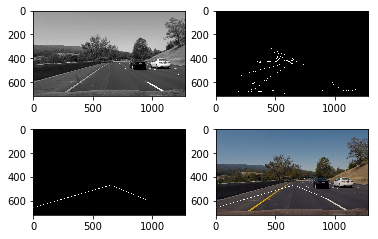

In [52]:
challenge_output = 'test_videos_output/challenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))